<a href="https://colab.research.google.com/github/jon-chun/sentimenttime/blob/main/sentimenttime_part1_lexrules_unified_sort_import_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Analytic Methodology to Extract Narratives from Text: Using Sentiment Analysis to find the Arcs and Crux Points in Novels, Social Media and Chat Transcripts**

By: Jon Chun
12 Jun 2021

References:

* Coming...

TODO:
* Clearly document workflow and partition across notebooks/libraries
* Code review and extraction to libraries
* Corpus ingestion for any format
* XAI (mlm false peak 1717SyuzhetR/1732SentimentR/1797robertalg15 adam watches war argument at dinner) 
* Centralize and Standardize Model name lists
* Normalize model SA Series lengths
* Standardize all SA Series with the same method
* Seamless report generation/file saving
* Get raw text from SentimentR
* Filter out non-printable characters
* Roll-over Crux-Points (SentNo+Sent/Parag) (plotly)
* Label/Roll-over Chapter/Sect No at Boundries
* Generate Report PDF/csv
* Option to select raw or discrete2continous transformation (Bing)
* Annotation functionality + Share/Collaboration of findings/reseearch



# Configuration (Auto)

**Global Configuration Constants**

In [392]:
# Hardcoded Sentiment Analysis Models

CORPUS_ENCODING = 'utf-8' # Default character/text encoding scheme (others: 'utf-8', but often 'iso-8859-1', 'windows-1252', 'cp1252', or 'ascii')

MODELS_LS = ['vader','textblob','stanza','afinn','bing','sentimentr','syuzhet','pattern','sentiword','senticnet','nrc']
            
# Minimum lengths for Sentences and Paragraphs
#   (Shorter Sents/Parags will be deleted)

MIN_CHAP_LEN = 5000
MIN_SECT_LEN = 25  # Minimum char length to be included in section DataFrame
MIN_PARAG_LEN = 2
MIN_SENT_LEN = 2

# Min/Max statistics on each lexicon's sentiment values applied to corpus
corpus_lexicons_stats_dt = {}
corpus_cruxes_dt = {}

# Crux Points Dict key:model, value:list of crux point tuples (x,y)
corpus_cruxes_all_dt = {}

**Install Libraries**

In [142]:
# fast detection of character set encoding for text/files

!pip install cchardet

     |████████████████████████████████| 266kB 5.2MB/s 


In [143]:
# common ML code

!pip install sklearn

In [31]:
%pip install contractions

     |████████████████████████████████| 286kB 5.1MB/s 
     |████████████████████████████████| 327kB 38.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85400 sha256=d9015df850857b4b99a694381712d1270c812975650d0f1f02e5b244a6698d08
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


**Import Libraries**

In [32]:
import os
import sys
import io
import glob
import json
import contextlib

In [33]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
import re
import string

In [35]:
from itertools import cycle  # For plotly

import collections
from collections import OrderedDict

In [36]:
# Import libraries for logging

import logging
from datetime import datetime
import time                     # (TODO: check no dependencies and delete)
from time import gmtime, strftime

In [37]:
import nltk

# Download for sentence tokenization
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# Download for nltk/VADER sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [38]:
from sklearn.preprocessing import MinMaxScaler   # To normalize time series
from sklearn.preprocessing import StandardScaler # To Standardize time series: center(sub mean) and rescale within 1 SD (only for well-behaved guassian distributions)
from sklearn.preprocessing import RobustScaler   # To Standardize time series: center(sub median) and rescale within 25%-75% (1st-3rd) IQR (better for noisy, outliers distributions)

In [39]:
mean_std_scaler = StandardScaler()
median_iqr_scaler = RobustScaler()

In [40]:
# Zoom interpolates new datapoints between existing datapoints to expand a time series 

from scipy.ndimage.interpolation import zoom

In [41]:
from scipy import interpolate
from scipy.interpolate import CubicSpline
from scipy import signal
from scipy.signal import argrelextrema

In [42]:
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from statsmodels import robust

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Define Library-Dependent Objects**

In [43]:
import contractions

In [44]:
corpus_sects_df = pd.DataFrame()

**Configure Jupyter Notebook**

In [45]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Configure matplotlib and seaborn

# Plotting pretty figures and avoid blurry images
# %config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
# sns.set_context('talk')

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

In [47]:
# Configure Jupyter

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from ipywidgets import widgets, interactive

# Configure Google Colab

%load_ext google.colab.data_table

In [48]:
# Text wrap

from IPython.display import HTML

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [49]:
from IPython.display import HTML

import plotly.graph_objects as go
import plotly.express as px
import plotly

**Configuration Details Snapshot**

In [50]:
# Snap Shot of Time, Machine, Data and Library/Version Blueprint
# TODO:

# Pick ONE Method (a) or (b) to Get Corpus Textfile

**Choose either (a) OR (b), not both**

## **Option (a): Connect to Google gDrive**

In [76]:
# Connect to Google gDrive

# Flag to indicate first run through code 
flag_first_run = True

from google.colab import drive, files
drive.mount('/gdrive')
%cd /gdrive/MyDrive/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


In [77]:
# Select the Corpus subdirectory on your Google gDrive


# gdrive_subdir = "./research/2021/sa_book_code/books_sa/imcewan_machineslikeme" #@param {type:"string"}
# gdrive_subdir = "./research/2021/sa_book_code/books_sa/vwoolf_tothelighthouse" #@param {type:"string"}
gdrive_subdir = "./research/2021/sa_book_code/books_sa/ddefoe_robinsoncrusoe" #@param {type:"string"}
CORPUS_SUBDIR = gdrive_subdir
corpus_filename = CORPUS_SUBDIR

# Change to working subdirectory
if flag_first_run == True:
  full_path_str = gdrive_subdir
  flag_first_run = False
else:
  full_path_str = f'/gdrive/MyDrive{gdrive_subdir[1:]}'

%cd $full_path_str


/gdrive/MyDrive/research/2021/sa_book_code/books_sa/ddefoe_robinsoncrusoe


## **Option (b): Upload Corpus Textfile**

***Only do this if your Google subdirectory doesn't already contain a plain text file of your Corpus or you wish to overwrite it and use a newer version***

In [ ]:
# Execute this code cell to upload plain text file of corpus
#   Should be *.txt format with paragraphs separated by at least 2 newlines

uploaded = files.upload()

In [ ]:
# Verify file was uploaded

# Get uploaded filename
corpus_filename = list(uploaded.keys())[0]
print(f'Uploaded Corpus filename is: {corpus_filename}')
CORPUS_FILENAME = corpus_filename

!ls -al $corpus_filename

# **Configuration (Manual)**

In [73]:
# Verify subdirectory change

!pwd
!ls *.txt

# TODO: Intelligently automate the filling of form based upon directory

/content
ls: cannot access '*.txt': No such file or directory


In [362]:
CORPUS_TITLE = 'Robinson Crusoe' #@param {type:"string"}
CORPUS_AUTHOR = "Daniel Defoe" #@param {type:"string"}
CHAPTER_HEADINGS = "CHAPTER (RomanNo)" #@param ["CHAPTER (ArabicNo)", "CHAPTER (RomanNo)"]
SECTION_HEADINGS = "None" #@param ["SECTION (ArabicNo)", "SECTION (RomanNo)", "----- (Hyphens)", "None"]

CORPUS_FILENAME = "ddefoe_robinsoncrusoe_hand_clean.txt" #@param {type:"string"}
CORPUS_SUBDIR = "./research/2021/sa_book_code/books_sa/ddefoe_robinsoncrusoe" #@param {type:"string"}


LEXICONS_SUBDIR = "./research/2021/sa_book_code/books_sa/lexicons" #@param {type:"string"}

# CORPUS_TITLE = 'To The Lighthouse' #@param {type:"string"}
# CORPUS_AUTHOR = "Virginia Woolf" #@param {type:"string"}
# CORPUS_FILENAME = "ttl_final_hand.txt" #@param {type:"string"}
# CORPUS_SUBDIR = "./research/2021/sa_book_code/books_sa/vwoolf_tothelighthouse" #@param {type:"string"}

# CORPUS_TITLE = 'To The Lighthouse' #@param {type:"string"}
# CORPUS_AUTHOR = "Virginia Woolf" #@param {type:"string"}
# CORPUS_FILENAME = "ttl_final_hand.txt" #@param {type:"string"}
# CORPUS_SUBDIR = "./research/2021/sa_book_code/books_sa/vwoolf_tothelighthouse" #@param {type:"string"}


CORPUS_FULL = f'{CORPUS_TITLE} by: {CORPUS_AUTHOR}'

PLOT_OUTPUT = "Major" #@param ["None", "Major", "All"]

FILE_OUTPUT = "Major" #@param ["None", "Major", "All"]


gdrive_subdir = CORPUS_SUBDIR
corpus_filename = CORPUS_FILENAME
author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()

print(f'\nWorking Corpus Datafile: ------------------------------ \n\n    {CORPUS_SUBDIR}')
print(f'\nFull Corpus Title/Author: ------------------------------ \n\n    {CORPUS_FULL}')


if CHAPTER_HEADINGS == 'CHAPTER (ArabicNo)':
  pattern_chap = r'CHAPTER [0-9]{1,2} [^\n]*'
elif CHAPTER_HEADINGS == 'CHAPTER (RomanNo)':
  pattern_chap = r'CHAPTER [IVXL]{,6}'
else:
  print(f'ERROR: Illegal CHAPTER_HEADINGS value = {CHAPTER_HEADINGS}')


if SECTION_HEADINGS == 'SECTION (ArabicNo)':
  pattern_sect = r'SECTION [0-9]{1,2} [^\n]*'
elif SECTION_HEADINGS == 'SECTION (RomanNo)':
  pattern_sect = r'SECTION [IVXL]{,6}'
elif SECTION_HEADINGS == '----- (Hyphens)':
  pattern_sect = r'^[- ]*\n'
elif SECTION_HEADINGS == 'None':
  pass
else:
  print(f'ERROR: Illegal SECTION_HEADING value = {SECTION_HEADINGS}')

print(f'\nCHAPTER Headings: ------------------------------ \n\n    {CHAPTER_HEADINGS}')

print(f'\nSECTION Headings: ------------------------------ \n\n    {SECTION_HEADINGS}')


print(f'\nCorpus file information: ------------------------------ \n')
!ls -al $CORPUS_FILENAME

# Verify contents of Corpus File is Correctly Formatted
#   
# TODO: ./utils/verify_format.py



Working Corpus Datafile: ------------------------------ 

    ./research/2021/sa_book_code/books_sa/ddefoe_robinsoncrusoe

Full Corpus Title/Author: ------------------------------ 

    Robinson Crusoe by: Daniel Defoe

CHAPTER Headings: ------------------------------ 

    CHAPTER (RomanNo)

SECTION Headings: ------------------------------ 

    None

Corpus file information: ------------------------------ 

-rw------- 1 root root 633127 Jul 13 16:52 ddefoe_robinsoncrusoe_hand_clean.txt


# **Utility Functions (Auto)**

## **Files**

In [190]:
# https://dev.to/bowmanjd/character-encodings-and-detection-with-python-chardet-and-cchardet-4hj7

import cchardet as chardet

from pathlib import Path
import sys

def get_file_encoding(filename):
    """Detect encoding and return decoded text, encoding, and confidence level."""
    filepath = Path(filename)

    # We must read as binary (bytes) because we don't yet know encoding
    blob = filepath.read_bytes()

    detection = chardet.detect(blob)
    encoding = detection["encoding"]
    confidence = detection["confidence"]
    text = blob.decode(encoding)

    return text, encoding, confidence

In [369]:
corpus_chaps_ls, corpus_raw_str = corpus2chaps(corpus_filename)

BEFORE stripping out headings len: 620615
len(corpus_chaps_ls): 21
AFTER stripping out headings len: 620326


In [370]:
len(corpus_raw_str)

620615

In [374]:
len(corpus_chaps_ls)

20

In [368]:
def corpus2chaps(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of min preprocessed raw CHAPTERs (corpus_parags_raw_temp_ls)
  '''

  with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    corpus_raw_str = infp.read()

  print(f'BEFORE stripping out headings len: {len(corpus_raw_str)}')


  """
  # TODO: Finish, https://realpython.com/python-eval-function/

  # Filter out SECTION [\d]{1,2}[^\n]* patterns from raw text corpus
  # pattern = r'SECTION [\d]{1,2}[^\n]*'
  # Replace all occurrences of character s with an empty string
  print(f'pattern_chap: {pattern_chap}')
  print(f'BEFORE stripping out headings len: {len(corpus_raw_str)}')
  pattern_str = fr"{pattern_chap}" 
  print(f'pattern_str: {pattern_str}')
  pattern = eval("re.compile("+pattern_str+")")
  print(f'pattern={pattern}')
  print(f'type(pattern): {type(pattern)}')
  
  #   pattern = exec('re.compile('+pattern_str+')')

  # res = pattern.findall('fdasjkfdl fdjasklf fjdksla CHAPTER 12 dfjdks fdsjklf ds\nfjdsk fjdsk fdsjk fds\n fds jfdksl fds jk \n fjdks fdjs')
  # print(f'res matches: {res}')
  corpus_raw_str = pattern.sub(r' ',corpus_raw_str)
  # corpus_raw_str = re.sub(pattern, '', corpus_raw_str)
  print(f'AFTER stripping out headings len: {len(corpus_raw_str)}')

  """


  # print(f'len(corpus_raw_str) = {len(corpus_raw_str)}')
  corpus_chaps_ls = re.split(rf'{pattern_chap}', corpus_raw_str, flags=re.I) # , flags=re.I)
  print(f'len(corpus_chaps_ls): {len(corpus_chaps_ls)}')

  # Strip off whitespace
  corpus_chaps_ls = [x.strip() for x in corpus_chaps_ls]

  # Filter out empty lines
  corpus_chaps_ls = [x for x in corpus_chaps_ls if not (len(x.strip()) <= MIN_PARAG_LEN)]

  # Filter out CHAPTER lines
  corpus_chaps_ls = [x for x in corpus_chaps_ls if not (x.strip().startswith('CHAPTER '))]

  print(f'AFTER stripping out headings len: {len(" ".join(corpus_chaps_ls))}')

  return corpus_chaps_ls, corpus_raw_str

In [159]:
CORPUS_ENCODING

'utf-8'

In [193]:
# Detection 

def corpus2sects(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of min preprocessed raw sections/CHAPTERs (corpus_parags_raw_temp_ls)
  '''

  # encoding = 'windows-1252', 'utf-8', 'cp1252', 'iso-8859-1'
  with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    corpus_raw_str = infp.read()

  corpus_sects_ls = re.split(SECTION_HEADINGS, corpus_raw_str)

  # Strip off whitespace
  corpus_sects_ls = [x.strip() for x in corpus_sects_ls]

  # Filter out empty lines
  corpus_sects_ls = [x for x in corpus_sects_ls if not (len(x.strip()) <= MIN_PARAG_LEN)]

  # Filter out the Section separator '-----' lines
  corpus_sects_ls = [x for x in corpus_sects_ls if not (x.strip().startswith('----- '))]

  # Filter out the Section separator 'SECTION ' lines
  corpus_sects_ls = [x for x in corpus_sects_ls if not (x.startswith('SECTION '))]

  # Filter out the Chapter separator 'CHAPTER ' lines
  # Keep for now, messy but enables proper SECTION assignments to appropraite CHAPTERs
  corpus_sects_ls = [x for x in corpus_sects_ls if not (x.startswith('CHAPTER '))]

  return corpus_sects_ls, corpus_raw_str

In [386]:
def corpus2parags(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of min preprocessed raw paragraphs (corpus_parags_ls)
  '''

  with open(corpus_filename, "r", encoding=CORPUS_ENCODING) as infp:
    corpus_raw_str = infp.read()

  corpus_parags_ls = re.split(r'[\n]{2,}', corpus_raw_str)
  print(f'Corpus Paragraph Raw Count: {len(corpus_parags_ls)}')

  # Strip off whitespace
  corpus_parags_ls = [x.strip() for x in corpus_parags_ls]

  # Filter out empty lines
  corpus_parags_ls = [x for x in corpus_parags_ls if (len(x.strip()) >= MIN_PARAG_LEN)]

  # Filter out lines containing only punctuation (e.g. '"', '.', '...', etc)
  parag_before_punctstrip_ct = len(corpus_parags_ls)
  corpus_parags_ls = [x for x in corpus_parags_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_PARAG_LEN]
  print(f'Punctuation only Paragraph Count: {len(corpus_parags_ls) - parag_before_punctstrip_ct}')

  # Filter out the Section separator '-----' lines
  corpus_parags_ls = [x for x in corpus_parags_ls if not (x.strip().startswith('----- '))]

  # Filter out the Section separator 'SECTION ' lines
  corpus_parags_ls = [x for x in corpus_parags_ls if not (x.startswith('SECTION '))]

  # Filter out the Chapter separator 'CHAPTER ' lines
  corpus_parags_ls = [x for x in corpus_parags_ls if not (x.startswith('CHAPTER '))]

  return corpus_parags_ls, corpus_raw_str


In [195]:
def parag2sents(corpus_parags_ls):
  '''
  Given a list of paragraphs,
  Return a list of lists of Sentences [sent_no, parag_no, asent(text)]
  '''

  sent_no = 0
  # sent_base = 0
  corpus_sents_ls = []
  for parag_no,aparag in enumerate(corpus_parags_ls):
    sents_ls = sent_tokenize(aparag)
    # Delete (whitespace only) sentences
    sents_ls = [x.strip() for x in sents_ls if len(x.strip()) > MIN_SENT_LEN]
    # Delete (punctuation only) sentences
    sents_ls = [x for x in sents_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_SENT_LEN]
    # Delete numbers (int or float) sentences
    sents_ls = [x for x in sents_ls if not (x.strip().isnumeric())]
    # TODO: may want to keep
    for s,asent in enumerate(sents_ls):
      corpus_sents_ls.append([sent_no, parag_no, asent])
      sent_no += 1

    # print(f'Returning with corpus_sents_ls length = {len(corpus_sents_ls)}')
  
  return corpus_sents_ls


In [83]:
# Generate full path and timestamp for new filepath/filename

def gen_pathfiletime(file_str, subdir_str=''):

  # Geenreate compressed author and title substrings
  author_raw_str = ''.join(CORPUS_AUTHOR.split()).lower()
  title_raw_str = ''.join(CORPUS_TITLE.split()).lower()

  # Generate current/unique datetime string
  datetime_str = str(datetime.now().strftime('%Y%m%d%H%M%S'))

  # Built fullpath+filename string
  file_base, file_ext = file_str.split('.')

  author_str = re.sub('[^A-Za-z0-9]+', '', author_raw_str)
  title_str = re.sub('[^A-Za-z0-9]+', '', title_raw_str)

  full_filepath_str = f'{subdir_str}{file_base}_{author_str}_{title_str}_{datetime_str}.{file_ext}'

  # print(f'Returning from gen_savepath() with full_filepath={full_filepath}')

  return full_filepath_str

# Test
# pathfilename_str = gen_pathfiletime('hist_paraglen.png')
# print(pathfilename_str)

In [84]:
# Tokenize into Sentences

"""
def parag2sents(corpus_parags_ls):
  '''
  Given a list of paragraphs,
  Return a list of lists of Sentences [sent_no, parag_no, asent(text)]
  '''

  sent_no = 0
  # sent_base = 0
  corpus_sents_row_ls = []
  for parag_no,aparag in enumerate(corpus_parags_ls):
    sents_ls = sent_tokenize(aparag)
    # Delete (whitespace only) sentences
    sents_ls = [x.strip() for x in sents_ls if len(x.strip()) > MIN_SENT_LEN]
    # Delete (punctuation only) sentences
    sents_ls = [x for x in sents_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_SENT_LEN]
    # Delete numbers (int or float) sentences
    sents_ls = [x for x in sents_ls if not (x.strip().isnumeric())]
    # TODO: may want to keep
    for s,asent in enumerate(sents_ls):
      corpus_sents_row_ls.append([sent_no, parag_no, asent])
      sent_no += 1

    # print(f'Returning with corpus_sents_row_ls length = {len(corpus_sents_row_ls)}')
  
  return corpus_sents_row_ls
""";

# Test

'''
print(f'Length {len(corpus_parags_raw_ls)}')
corpus_sents_row_ls = parag2sents(corpus_parags_raw_ls)

print(f'First row {corpus_sents_row_ls[0]}')
print('\n')
print(f'Last row {corpus_sents_row_ls[-1]}')
''';

In [85]:
#This function converts to lower-case, removes square bracket, removes numbers and punctuation
 
def text_clean(text):
    text = text.lower()
    text = contractions.fix(text)  # Expand contrations
    text = re.sub("\\'s", " own", text)  # After expanding normal apostrophes, expand possessive apostrophes "Mary's car" -> "Mary own car"

    # TODO: More formally
    # https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0
    text = re.sub("-\n", "", text)       # Join end of line words split by continuation hyphens
    text = re.sub("-\n\r", "", text)
    text = re.sub("-\r", "", text)
    text = re.sub("\[.*?\]", " ", text)

    text = re.sub("-", " ", text)  # Special care for hypenated words well-known: choose option (a)
                                   # (a) 'well known', (b) 'wellknown' (c) 'well known' and 'wellknown' cf: https://datascience.stackexchange.com/questions/81072/how-to-process-the-hyphenated-english-words-for-any-nlp-problem
    text = re.sub("/", " ", text)  # sociability/conversation/interesting -> sociability conversation interesting                             
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub("[\n]", " ", text)  # Replace newline with space
    return text

In [86]:
# Read corpus into a single string then split into sections (chapters and subchapter)

'''
if len(corpus_filename) == 0:
  # If now file uploaded, use the file in Google gDrive
  corpus_filename = CORPUS_FILENAME
else:
  # The uploaded file has priority over the gDrive Corpus file
  pass
'''

"""
def corpus2sects(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of min preprocessed raw sections/CHAPTERs (corpus_parags_raw_temp_ls)
  '''

  with open(corpus_filename, "r", encoding='windows-1252') as infp:
    corpus_raw_str = infp.read()

  # print(f'len(corpus_raw_str) = {len(corpus_raw_str)}')
  corpus_sects_ls = re.split(r'(CHAPTER [\d]{1,2}|-----)', corpus_raw_str) # , flags=re.I)

  # Filter out the Section separator '-----' lines
  corpus_sects_noseclines_ls = [x for x in corpus_sects_ls if not (x.strip().startswith('-----'))]
  # Filter out the CHAPTER lines
  corpus_sects_nochheads_ls = [x for x in corpus_sects_noseclines_ls if not (x.strip().startswith('CHAPTER '))]

  return corpus_sects_nochheads_ls
""";

'''
  corpus_parags_raw_temp_ls = corpus_raw_str.split('\n\n')
  print(f'Corpus Paragraph Raw Count: {len(corpus_parags_raw_temp_ls)}')

  # Strip excess whitespace and drop empty lines
  corpus_parags_raw_temp_ls = [x.strip() for x in corpus_parags_raw_temp_ls if len(x.strip()) > MIN_PARAG_LEN]
  print(f'Corpus Paragraph -(whitespace only) Count: {len(corpus_parags_raw_temp_ls)}')

  # Drop lines that only contain punctuation (e.g. '"', '.', '...', etc)
  corpus_parags_raw_temp_ls = [x for x in corpus_parags_raw_temp_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_PARAG_LEN]
  print(f'Corpus Paragraph -(punctuation only) Count: {len(corpus_parags_raw_temp_ls)}')

  return corpus_parags_raw_temp_ls

# Test  

corpus_parags_raw_ls = read_corpus_parags(CORPUS_FILENAME)
print(f'We found #{len(corpus_parags_raw_ls)} lines\n')

print('\nThe first 10 lines of the Corpus:')
print('-----------------------------------\n')
corpus_parags_raw_ls[:10]

print('\nThe last 10 lines of the Corpus:')
print('-----------------------------------\n')
corpus_parags_raw_ls[-10:]
print('\n')
print(sorted(corpus_parags_raw_ls, key=lambda x: (len(x), x)))
''';

In [87]:
"""
def corpus2chaps(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of min preprocessed raw CHAPTERs (corpus_parags_raw_temp_ls)
  '''

  with open(corpus_filename, "r", encoding='windows-1252') as infp:
    corpus_raw_str = infp.read()

  # print(f'len(corpus_raw_str) = {len(corpus_raw_str)}')
  corpus_chaps_ls = re.split(r'(CHAPTER [\d]{1,2})', corpus_raw_str, flags=re.I) # , flags=re.I)

  corpus_chaps_nochheads_ls = [x for x in corpus_chaps_ls if not (x.strip().startswith('CHAPTER '))]

  return corpus_chaps_nochheads_ls
""";

In [88]:
# Read corpus into a single string then split into paragraphs

'''
if len(corpus_filename) == 0:
  # If now file uploaded, use the file in Google gDrive
  corpus_filename = CORPUS_FILENAME
else:
  # The uploaded file has priority over the gDrive Corpus file
  pass
'''

"""
def corpus2parags(corpus_filename):
  '''
  Given a corpus_filename (assuming already %cd into correct subdir)
  Return a list of min preprocessed raw paragraphs (corpus_parags_raw_temp_ls)
  '''

  with open(corpus_filename, "r", encoding='windows-1252') as infp:
    corpus_raw_str = infp.read()

  corpus_parags_raw_temp_ls = corpus_raw_str.split('\n\n')
  print(f'Corpus Paragraph Raw Count: {len(corpus_parags_raw_temp_ls)}')

  # Strip excess whitespace and drop empty lines
  corpus_parags_raw_temp_ls = [x.strip() for x in corpus_parags_raw_temp_ls if len(x.strip()) > MIN_PARAG_LEN]
  print(f'Corpus Paragraph -(whitespace only) Count: {len(corpus_parags_raw_temp_ls)}')

  # Drop lines that only contain punctuation (e.g. '"', '.', '...', etc)
  corpus_parags_raw_temp_ls = [x for x in corpus_parags_raw_temp_ls if len((re.sub(r'[^\w\s]','',x)).strip()) > MIN_PARAG_LEN]
  print(f'Corpus Paragraph -(punctuation only) Count: {len(corpus_parags_raw_temp_ls)}')

  return corpus_parags_raw_temp_ls
""";

# Test  
'''
corpus_parags_raw_ls = read_corpus_parags(CORPUS_FILENAME)
print(f'We found #{len(corpus_parags_raw_ls)} lines\n')

print('\nThe first 10 lines of the Corpus:')
print('-----------------------------------\n')
corpus_parags_raw_ls[:10]

print('\nThe last 10 lines of the Corpus:')
print('-----------------------------------\n')
corpus_parags_raw_ls[-10:]
print('\n')
print(sorted(corpus_parags_raw_ls, key=lambda x: (len(x), x)))
''';

In [89]:
# Verify saved under newest filename

def get_recentfile(file_type='csv'):
  '''
  Given a file extension type,
  Return the most recently created file of that type 
  in the current directory
  '''
  file_pattern = "./*." + file_type
  print(f'file_pattern: {file_pattern}')
  list_of_files = glob.glob(file_pattern) # * means all if need specific format then *.csv
  latest_file = max(list_of_files, key=os.path.getmtime)

  return latest_file

# Test

# get_recentfile('txt')

## **Sentiment**

In [90]:
# Test to find longest String in Corpus (in terms of #tokens) 
#      must be <510 tokens for Transformers

# corpus_sents_df['sent_raw'].astype(str).apply(lambda x: len(x.split())).max() # split().len()).max()

In [91]:
# get_sentiments(model_base=model_base, sentiment_fn=sentiment_sentimentr, sentiment_type='lexicon')

In [92]:
# corpus_sents_df.head(2)

In [93]:
def get_sentiments(model_base, sentiment_fn, sentiment_type='lexicon'):
  '''
  Given a model_base name and sentiment evaluation function
  Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants
  '''

  # Calculate Sentiment Polarities

  if sentiment_type == 'lexicon':
    print(f'Processing Lexicon/Sentences...')
    corpus_sents_df[model_base] = corpus_sents_df['sent_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Paragraphs...')
    corpus_parags_df[model_base] = corpus_parags_df['parag_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Sections...')
    corpus_sects_df[model_base] = corpus_sects_df['sect_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Chapters...')
    corpus_chaps_df[model_base] = corpus_chaps_df['chap_clean'].apply(lambda text: sentiment_fn(str(text)))
  
  elif sentiment_type == 'compound':
    # VADER

    # Calculate dictionary of {neg/neu/pos/compound} values for sent_clean
    print(f'Processing Lexicon/Sentences...')
    corpus_sents_df['scores'] = corpus_sents_df['sent_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Paragraphs...')
    corpus_parags_df['scores'] = corpus_parags_df['parag_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Sections...')
    corpus_sects_df['scores'] = corpus_sects_df['sect_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Chapters...')
    corpus_chaps_df['scores'] = corpus_chaps_df['chap_clean'].apply(lambda text: sentiment_fn(str(text)))

    # Extract Compound Sentiment
    corpus_sents_df[model_base]  = corpus_sents_df['scores'].apply(lambda score_dict: score_dict['compound'])
    corpus_parags_df[model_base]  = corpus_parags_df['scores'].apply(lambda score_dict: score_dict['compound'])
    corpus_sects_df[model_base]  = corpus_sects_df['scores'].apply(lambda score_dict: score_dict['compound'])
    corpus_chaps_df[model_base]  = corpus_chaps_df['scores'].apply(lambda score_dict: score_dict['compound'])

  elif sentiment_type == 'function':
    # TextBlob

    # Calculate dictionary of {neg/neu/pos/compound} values for sent_clean
    print(f'Processing Lexicon/Sentences...')
    corpus_sents_df[model_base] = corpus_sents_df['sent_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Paragraphs...')
    corpus_parags_df[model_base] = corpus_parags_df['parag_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Sections...')
    corpus_sects_df[model_base] = corpus_sects_df['sect_clean'].apply(lambda text: sentiment_fn(str(text)))
    print(f'Processing Lexicon/Chapters...')
    corpus_chaps_df[model_base] = corpus_chaps_df['chap_clean'].apply(lambda text: sentiment_fn(str(text)))

  else:
    print(f'ERROR: sentiment_type={sentiment_type} but must be one of (lexicon, compound, function)')
    return

  # Create new column names
  col_meanstd = f'{model_base}_meanstd'
  col_medianiqr = f'{model_base}_medianiqr'
  col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'
  col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'


  # Get Chapter Standardization with MeanSTD and RobustStandardization with MedianIQRScaling
  corpus_chaps_df[col_meanstd]  = mean_std_scaler.fit_transform(np.array(corpus_chaps_df[model_base]).reshape(-1, 1))
  corpus_chaps_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_chaps_df[model_base]).reshape(-1, 1))
  # Normalize the Chapter Sentiment by dividing by Chapter Length
  chaps_len_ls = list(corpus_chaps_df['token_len'])
  chaps_sentiment_ls = list(corpus_chaps_df[model_base])
  chaps_sentiment_norm_ls = [chaps_sentiment_ls[i]/chaps_len_ls[i] for i in range(len(chaps_len_ls))]
  # RobustStandardize Chapter sentiment values
  corpus_chaps_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(chaps_sentiment_norm_ls)).reshape(-1, 1))
  corpus_chaps_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_chaps_df[model_base]).reshape(-1, 1))
  corpus_chaps_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(chaps_sentiment_norm_ls)).reshape(-1, 1))

  # Get Section Standardization with MeanSTD and RobustStandardization with MedianIQRScaling
  corpus_sects_df[col_meanstd]  = mean_std_scaler.fit_transform(np.array(corpus_sects_df[model_base]).reshape(-1, 1))
  corpus_sects_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_sects_df[model_base]).reshape(-1, 1))
  # Normalize the Section Sentiment by dividing by Section Length
  sects_len_ls = list(corpus_sects_df['token_len'])
  sects_sentiment_ls = list(corpus_sects_df[model_base])
  sects_sentiment_norm_ls = [sects_sentiment_ls[i]/sects_len_ls[i] for i in range(len(sects_len_ls))]
  # RobustStandardize Section sentiment values
  corpus_sects_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(sects_sentiment_norm_ls)).reshape(-1, 1))
  corpus_sects_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_sects_df[model_base]).reshape(-1, 1))
  corpus_sects_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(sects_sentiment_norm_ls)).reshape(-1, 1))


  # Normalize the Paragraph Sentiment by dividing by Chapter Length
  parags_len_ls = list(corpus_parags_df['token_len'])
  parags_sentiment_ls = list(corpus_parags_df[model_base])
  parags_sentiment_norm_ls = [parags_sentiment_ls[i]/parags_len_ls[i] for i in range(len(parags_len_ls))]
  # RobustStandardize Paragraph sentiment values
  corpus_parags_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(parags_sentiment_norm_ls)).reshape(-1, 1))
  corpus_parags_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_parags_df[model_base]).reshape(-1, 1))
  corpus_parags_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(parags_sentiment_norm_ls)).reshape(-1, 1))

  # Normalize the Sentence Sentiment by dividing by Chapter Length
  sents_len_ls = list(corpus_sents_df['token_len'])
  sents_sentiment_ls = list(corpus_sents_df[model_base])
  sents_sentiment_norm_ls = [sents_sentiment_ls[i]/sents_len_ls[i] for i in range(len(sents_len_ls))]
  # RobustStandardize Sentence sentiment values
  corpus_sents_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(sents_sentiment_norm_ls)).reshape(-1, 1))
  corpus_sents_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_sents_df[model_base]).reshape(-1, 1))
  corpus_sents_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(sents_sentiment_norm_ls)).reshape(-1, 1))

  return

In [94]:
# Read in lexicon at given path into Dict[word]=polarity

def get_lexicon(lexicon_name, lexicon_format=2):
    """
    Read sentiment lexicon.csv file at lexicon_path
    into appropriate Dict[word]=polarity

    1. lexicon_dt[word] = <polarity value>

    Args:
        sa_lib (str, optional): [description]. Defaults to 'syuzhet'.
    """
    
    # global lexicon_df

    lexicon_df = pd.DataFrame()
    
    # print(os.getcwd())
    """
    lexicons_ls = os.listdir('../sa_lexicons/')
    if (lexicon_name in lexicons_ls):
      print(f'Found {lexicon_name} in lexicon_directory)')
    # print(glob.glob('*.csv'))
    cp_cmd = f'copy ../sa_lexicons/{lexicon_name} ./'
    print(f'cp_cmd = {cp_cmd}')
    os.system(cp_cmd)
    os.system('cp ../sa_lexicons/' + lexicon_name.strip() + ' ./')
    os.listdir('.')  
    """;
    
    try:
      lexicon_df = pd.read_csv(lexicon_name)
      lexicon_df.info()
      # lexicon_df = lexicon_tmp_df.copy()
      # print(lexicon_df.head())
      return lexicon_df
    except:
      print(f'ERROR: Cannot read lexicon.csv at {lexicon_name}')
      return -1

'''
    print
    if (sa_lexicon == 'default'):
        lexicon_df = pd.read_csv(LEXICON_PATH)
        lexicon_df.columns = ['index_no', 'word', 'polarity']
        lexicon_df.drop(['index_no'], axis=1, inplace=True)
        lexicon_df.dropna(inplace=True)
        lexicon_dt = lexicon_df.set_index('word').T.to_dict('list')
        # unlist the polarity to type: float
        for key in lexicon_dt:
            lexicon_dt[key] = float(lexicon_dt[key][0])
        
    ### print(f"Exit get_sa_lex() with {len(lexicon_dt.keys())} entries in syuzhet_dt")
    return lexicon_dt
''';

In [95]:
# Sentence to Sentiment Polarity according to passed in Lexicon Dictionary

def text2sentiment(text_str, lexicon_dt):
  '''
  Given a text_str and lexicon_dt, calculate 
  the sentimety polarity.
  '''

  # Remove all not alphanumeric and whitespace characters
  text_str = re.sub(r'[^\w\s]', '', text_str) 

  text_str = text_str.strip().lower()
  if (len(text_str) < 1):
      print(f"ERROR: text2sentiment() given empty/null/invalid string: {text_str}")

  text_ls = text_str.split()
  # print(f'text_ls: {text_ls}')

  # Accumulated Total Sentiment Polarity for entire Sentence
  text_sa_tot = 0.0

  for aword in text_ls:
      # print(f'getting sa for word: {aword}')
      try:
          word_sa_fl = float(lexicon_dt[aword])
          text_sa_tot += word_sa_fl
          # print(f">>{aword} has a sentiment value of {word_sa_fl}")
      except TypeError: # KeyError:
          # aword is not in lexicon so it adds 0 to the sentence sa sum
          # print(f"TypeError: cannot convert {lexicon_dt[aword]} to float")
          continue
      except KeyError:
          # print(f"KeyError: missing key {aword} in defaultdict syuzhet_dt")
          continue
      except:
          e = sys.exc_info()[0]
          # print(f"ERROR {e}: sent2lex_sa() cannot catch aword indexing into syuzhet_dt error")
  
  # print(f"Leaving sent2lex_sa() with sentence sa value = {str(text_sa_tot)}")
  
  return text_sa_tot


# Test

# sent2sentiment('I hate and despise and abhor and dislike and am disgusted by Mondays.', lexicon_jockersrinker_dt)
# sent2sentiment('hate Mondays.', lexicon_jockersrinker_dt)

In [96]:
def plot_smas(section_view=True, model_name='vader', text_unit='sentence', wins_ls=[20], alpha=0.5, subtitle_str='', y_height=0, save2file=False):
  '''
  Given a model, text_unit
  Plot a SMA using default values and wrapping the function get_smas()
  '''

  if (section_view == True) and not any(x == text_unit for x in ['sentence', 'paragraph']):
    print(f'ERROR: You can only plot SMA within a Section with Sentence or Paragraph text units')
    return -99

  if text_unit == 'sentence':
    if section_view == False:
      ts_df = corpus_sents_df
    else:
      ts_df = section_sents_df
    wins_ls = [5,10,20]
  elif text_unit == 'paragraph':
    if section_view == False:
      ts_df = corpus_parags_df
    else:
      ts_df = section_parags_df
    wins_ls = [5,10,20]
  elif text_unit == 'section':
    ts_df = corpus_sects_df
    wins_ls=[20]
  else:
    print(f'ERROR: {text_unit} must be sentence, paragraph or section')

  sectno_loc = ts_df[model_name].min()

  if section_view ==False:
    # At Section boundries draw blue vertical lines 
    section_boundries_ls = list(corpus_sects_df['sent_no_start'])
    for i, sent_no in enumerate(section_boundries_ls):
      plt.text(sent_no, y_height, f'Sec#{i}', alpha=0.2, rotation=90)
      plt.axvline(sent_no, color='blue', alpha=0.1)
      # 'BigNews1', xy=(sent_no, 0.5), xytext=(-10, 25), textcoords='offset points',                   rotation=90, va='bottom', ha='center', annotation_clip=True)

      # plt.text(sent_no, -.5, 'goodbye',rotation=90, zorder=0)

    # At Chapter boundaries draw red vertical lines
    chapter_boundries_ls = list(corpus_chaps_df['sent_no_start'])
    for i, sent_no in enumerate(chapter_boundries_ls):
      plt.axvline(sent_no, color='navy', alpha=0.1)
      # plt.text(sent_no, .5, 'hello', rotation=90, zorder=0)

  get_smas(ts_df, model_name=model_name, text_unit=text_unit, wins_ls=wins_ls, alpha=alpha, subtitle_str=subtitle_str, save2file=save2file)

  if (save2file == True):
    # Save graph to file.
    plot_filename = f'plot_sma_sents_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

In [97]:
# SMA 5% Sentiment of Sentence Sentiment

def get_smas(ts_df, model_name, text_unit='sentence', wins_ls=[5,10], alpha=0.5, scale_factor=1., subtitle_str='', mean_adj=0., do_plot=True, save2file=False):
  '''
  Given a model_name and time series DataFrame and list of win_rolls in percentages
  Return the rolling means of the time series using the window sizes in win_rolls
  '''

  temp_roll_df = pd.DataFrame() # TODO: save sma rolling values into temp_df and return this value

  win_1per = int(ts_df.shape[0]*0.01)
  if text_unit ==  'sentence':
    # win_1per = win_s1per
    x_idx = 'sent_no'
    fname_abbr = 'sents'
  elif text_unit == 'paragraph':
    # win_1per = win_p1per
    x_idx = 'parag_no'
    fname_abbr = 'parags'
  elif text_unit == 'section':
    win_1per = 1
    wins_ls = [int(0.1 * corpus_sects_df.shape[0])]  # Edge case to deal with very few Section data points
    x_idx = 'sect_no'
    fname_abbr = 'sects'
  else:
    print(f'ERROR: text_unit={text_unit} but must be either sentence, paragraph or section')
  
  for i, awin_size in enumerate(wins_ls):
    if len(str(awin_size)) == 1:
      awin_str = '0'+str(awin_size)+'0'
    else:
      awin_str = str(awin_size)+ '0'
    col_roll_str = f'{model_name}_mean_roll{awin_str}'
    win_size = awin_size*win_1per
    ts_df[col_roll_str] = ts_df[model_name].rolling(window=win_size, center=True).mean()
  
    if do_plot == True:
      alabel = f'{model_name} (win={awin_size})'
      ts_df['y_scaled'] = ts_df[col_roll_str]*scale_factor + mean_adj 
      sns.lineplot(data=ts_df, x=x_idx, y='y_scaled', legend='brief', label=alabel, alpha=alpha)
      
  plt.title(f'{CORPUS_FULL} (Model: {model_name}: {subtitle_str}) \nSMA Smoothed {text_unit} Sentiment Plot (windows={wins_ls})')
  # plt.legend(loc='best')

  if save2file == True:
    # Save graph to file.
    plot_filename = f'plot_{fname_abbr}_sa_mean_050100sma.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return temp_roll_df

In [98]:
def get_lexstats(ts_df, model_name, text_unit='sentence'):
  '''
  Given a model name
  calculate, store and return time series stats
  '''
  
  global corpus_lexicons_stats_dt

  temp_dt = {}
  
  if text_unit == 'sentence':
    stat_idx = f'{model_name}_sents'
  elif text_unit == 'paragraph':
    stat_idx = f'{model_name}_parags'
  elif text_unit == 'section':
    stat_idx = f'{model_name}_sects'
  elif text_unit == 'chapter':
    stat_idx = f'{model_name}_chaps'
  else:
    print(f'ERROR: {text_unit} must either be sentence, paragraph, or section')

  sentiment_min = ts_df[model_name].min()
  sentiment_max = ts_df[model_name].max()

  temp_dt = {'sentiment_min' : sentiment_min,
             'sentiment_max' : sentiment_max}

  corpus_lexicons_stats_dt[stat_idx] = temp_dt
                                     
  return 

# Test
# get_lexstats('afinn')
# corpus_lexicons_stats_dt

In [99]:
def lex_discrete2continous_sentiment(text, lexicon):
  '''
  Given a plain text string, give it to
    Stanford Stanza (OpenNLP) to calculate sentiment for each word on a 3 point scale 0-2
  Return a sentiment value for the entire sentence (sum of word sentiments/log(len of sentence)) 
    that approximates a normal distribution for all values
    In order to get more fine grained measure of overall Sentence sentiment
    Sentiment values will be Normalized/Standardized so absolute precision is not required
  '''
  text_sentiment_tot = 0.
  text_ls = text.split()
  text_len = len(text_ls)
  for aword in text_ls:
    word_sentiment = text2sentiment(str(aword), lexicon)
    text_sentiment_tot += word_sentiment
  text_sentiment_norm = text_sentiment_tot/(np.log(text_len)+0.01)

  return text_sentiment_norm

In [100]:
def clip_outliers(floats_ser):
  '''
  Given a pd.Series of float values
  Return a list with outliers removed, values limited within 3 median absolute deviations from median
  '''
  # https://www.statsmodels.org/stable/generated/statsmodels.robust.scale.mad.html#statsmodels.robust.scale.mad

  # Old mean/std, less robust
  # ser_std = floats_ser.std()
  # ser_median = floats_ser.mean() # TODO: more robust: asym/outliers -> median/IQR or median/median abs deviation

  floats_np = np.array(floats_ser)
  ser_median = floats_ser.median()
  ser_mad = robust.mad(floats_np)
  print(f'ser_median = {ser_median}')
  print(f'ser_mad = {ser_mad}')

  if ser_mad == 0:
    # for TS with small ranges (e.g. -1.0 to +1.0) Median Abs Deviation = 0
    #   so pass back the original time series
    floats_clip_ls = list(floats_ser)

  else:
    ser_oldmax = floats_ser.max()
    ser_oldmin = floats_ser.min()
    print(f'ser_max = {ser_oldmax}')
    print(f'ser_min = {ser_oldmin}')

    ser_upperlim = ser_median + 2.5*ser_mad
    ser_lowerlim = ser_median - 2.5*ser_mad
    print(f'ser_upperlim = {ser_upperlim}')
    print(f'ser_lowerlim = {ser_lowerlim}')

    # Clip outliers to max or min values
    floats_clip_ls = np.clip(floats_np, ser_lowerlim, ser_upperlim)
    # print(f'max floast_ls {floats_ls.max()}')

    # def map2range(value, low, high, new_low, new_high):
    #   '''map a value from one range to another'''
    #   return value * 1.0 / (high - low + 1) * (new_high - new_low + 1)

    # Map all float values to range [-1.0 to 1.0]
    # floats_clip_sig_ls = [map2range(i, ser_oldmin, ser_oldmax, ser_upperlim, ser_lowerlim) for i in floats_clip_ls]

    # listmax_fl = float(max(floats_ls))
    # floats_ls = [i/listmax_fl for i in floats_ls]
    #floats_ls = [1/(1+math.exp(-i)) for i in floats_ls]

  return floats_clip_ls  # floats_clip_sig_ls

# Test
# Will not work on first run as corpus_sents_df is not defined yet
'''
data = np.array([1, 4, 4, 7, 12, 13, 16, 19, 22, 24])
test_ls = clip_outliers(corpus_sents_df['vader'])
print(f'new min is {min(test_ls)}')
print(f'new max is {max(test_ls)}')
''';

## **Pandas**

In [101]:
def rename_cols(ts_df, col_old_ls, suffix_str='_raw'):
  '''
  Given a DataFrame, list of columns in DataFrame and a suffix,
  Return a Dictionary mapping old col names to new col name (orig+suffix)
  '''

  col_new_ls = []
  for acol in col_old_ls:
    acol_new = acol + suffix_str
    col_new_ls.append(acol_new)

  # Create dict for col mapping: keys=old col names, value=new col names
  col_rename_dt = dict(zip(col_old_ls, col_new_ls))

  # ts_df.rename(columns=col_rename_dt, errors="raise")

  return col_rename_dt

# test_ls = [col for col in corpus_sents_df.columns if not(renaming_fun(col) is None)]
# print(f'test_ls: {test_ls}')

# Test
# col_rename_dt = rename_cols(corpus_sents_df, sentiment_only_cols_ls)
# col_rename_dt

## **Time Series**

In [102]:
def norm2negpos1(data_ser):
  '''
  Given a series of floating number
  Return a a list of same values normed between -1.0 and +1.0
  '''
  # data_np = np.matrix(data_ser)

  scaler=MinMaxScaler(feature_range=(-1.0, 1.0))
  temp_ser = scaler.fit_transform(np.matrix(data_ser))
  
  return temp_ser

# Test
'''
temp_np = norm2negpos1(corpus_all_df[['xlnet_sst5']])
print(type(temp_np))
temp_np.shape
''';

In [103]:
def standardize_ts(data_ser):
  '''
  Given a series of floating number
  Return a a list of same values normed between -1.0 and +1.0
  '''
  # data_np = np.matrix(data_ser)

  std_scaler = StandardScaler()
  df_std = std_scaler.fit_transform(np.array(data_ser))
  
  return df_std

# Test
'''
temp_np = norm2negpos1(corpus_all_df[['xlnet_sst5']])
print(type(temp_np))
temp_np.shape
temp_np
''';

In [104]:
# This must be defined AFTER the corpus_sects_df DataFrame is created in the Preprocessing Step below

# Raw Plot of Section Sentiments (Adjusted for (x-axis) mid-Section Sentence No and (y-axis) Sentiment weighted by Section length )

# corpus_sects_df = pd.DataFrame()  # Create empty early as required by some utility functions

def plot_crux_sections(model_names_ls, semantic_type='section', subtitle_str='', label_token_ct=0, title_xpos = 0.8, title_ypos=0.2, sec_y_height=0, save2file=False):
  '''
  Given a Sections DataFrame, model_name and semantic type,
  Return a Plot of the Cruxes
  '''

  crux_points_dt = {}
  model_stand_names_ls = []
  section_boundries_ls = []


  # print(f'Using model_names: {model_names_ls}')

  # sns.lineplot(data=ts_df, x='sent_no_mid', y=amodel_stand, markers=['o'], alpha=0.5, label=amodel_stand); # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment (Bing Lexicon)')


  # At Section boundries draw blue vertical lines 
  section_boundries_ls = list(corpus_sects_df['sent_no_start'])
  for i, sent_no in enumerate(section_boundries_ls):
    plt.text(sent_no, sec_y_height, f'Sec#{i}', alpha=0.2, rotation=90)
    plt.axvline(sent_no, color='blue', alpha=0.1);

  # At Chapter boundaries draw red vertical lines
  chapter_boundries_ls = list(corpus_chaps_df['sent_no_start'])
  for i, sent_no in enumerate(chapter_boundries_ls):
    plt.axvline(sent_no, color='navy', alpha=0.1);

  # Error check and assign DataFrame associated with each semantic_type
  if semantic_type == 'section':
    # Get midpoints of each Section
    ts_df=corpus_sects_df
    midpoints_ls = list(corpus_sects_df['sent_no_mid'])
  elif semantic_type == 'chapter':
    # Get midpoints of each Chapter
    ts_df=corpus_chaps_df
    midpoints_ls = list(corpus_chaps_df['sent_no_mid'])
  else:
    print(f"ERROR: semantic_type={semantic_type} must be either 'section' or 'chapter'")
    return -1

  # How many sentiment time series are we plotting?
  if len(model_names_ls) == 1:
    
    # Plotting only one model
    model_name_full = str(model_names_ls[0])
    model_name_root = model_name_full.split('_')[0]
    print(f'model_name_full: {model_name_full} and model_name_root: {model_name_root}')
    if model_name_root in MODELS_LS:
      # Plot
      print(f'about to sns.lineplot model: ') # {ts_df}')
      g = sns.lineplot(data=ts_df, x='sent_no_mid', y=model_name_full, markers=['o'], alpha=0.5, label=model_name_full) # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment and Cruxes (Model: {models_names_ls[0].capitalize()})')
      # g._legend.remove()
      # print(f'model_name_full={model_name_full}')
      # plt.plot(ts_df.sent_no_mid, ts_df[model_name_full], markers="o", alpha=0.5, label=model_name_full)
    else:
      print(f'ERROR: model_names_ls[0]={model_name_root} is invalid,\n    must be one of {MODELS_LS}')
      return -1

    # If plotting only one model, add labels
    midpoints_sentiment_ls = list(ts_df[model_name_full])
    sect_ct = 0
    for x,y in zip(midpoints_ls, midpoints_sentiment_ls): 
      label_token_int = int(label_token_ct)
      if label_token_int < 0:
        label = ''
      elif label_token_int == 0:
        # if arg label_token_ct == 0, just print sent_no
        label = f"#{x}({sect_ct})"
      else:
        # if arg label_token_ct > 0, print the first label_token_ct words of sentence at crux point
        label = f"#{x}({sect_ct}) {' '.join(corpus_sents_df.iloc[x-1]['sent_raw'].split()[:label_token_int])}"; # \nPolarity: {y:.2f}'

      # Save Crux point in crux_points_dt Dictionary if plotting Cruxes for a single/specific Model
      crux_full_str = ' '.join(corpus_sents_df.iloc[x]['sent_raw'].split())
      crux_points_dt[x] = [y, crux_full_str]

      plt.annotate(label,
                   (x,y),
                   textcoords='offset points',
                   xytext=(0,10),
                   ha='center',
                   rotation=90)
      sect_ct += 1

    plt.title(f'{CORPUS_FULL} \n Plot {semantic_type.capitalize()} Sentiment ({model_name_full.capitalize()})\n{subtitle_str}', x=title_xpos, y=title_ypos);
    # Plot
    plt.plot(midpoints_ls, midpoints_sentiment_ls, marker="o", ms=6) # , markevery=[0,1])

  else:
    # If plotting multiple models
    model_names_str = 'Multiple Models'
    for i, model_name_full in enumerate(model_names_ls):
      # Error check and assign correct model names
      model_name_root = model_name_full.split('_')[0]
      if model_name_root in MODELS_LS:
        # Plot
        g = sns.lineplot(data=ts_df, x='sent_no_mid', y=model_name_full, markers=['o'], alpha=0.5, label=model_name_full) # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment and Cruxes (Model: {models_names_ls[0].capitalize()})')
        # g._legend.remove()
        # plt.plot(ts_df.sent_no_mid, ts_df[model_name_full], marker="o", alpha=0.5, label=model_name_full)
      else:
        print(f'ERROR: model_names_ls[]={model_name_root} is invalid,\n    must be one of {MODELS_LS}')
        return -1

      # Plot
      g = sns.lineplot(data=ts_df, x='sent_no_mid', y=model_name_full, markers=['o'], alpha=0.5, label=model_name_full) # .set_title(f'{CORPUS_FULL} \n Plot Section Sentiment and Cruxes (Model: {models_names_ls[0].capitalize()})')
      # g._legend.remove()

    plt.title(f'{CORPUS_FULL} \n Plot {semantic_type.capitalize()} Sentiment (Standardized Models)\n{subtitle_str}', x=title_xpos, y=title_ypos)

  # plt.legend(loc='best');

  if (save2file == True):
    # Save graph to file.
    models_names_ls = [x[:2] for x in model_names_ls]
    models_names_str = ''.join(models_names_ls)
    plot_filename = f'plot_cruxes_{semantic_type}_{models_names_str}_{models_names_str}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return crux_points_dt

In [105]:
def plot_histogram(model_name='vader', text_unit='sentence', save2file=False):
  '''
  Given a model, text_unit
  Plot a Histogram using the default DataFrame
  '''

  if text_unit == 'sentence':
    ts_df = corpus_sents_df

  elif text_unit == 'paragraph':
    ts_df = corpus_parags_df

  elif text_unit == 'section':
    ts_df = corpus_sects_df

  elif text_unit == 'chapter':
    ts_df = corpus_chaps_df

  else:
    print(f'ERROR: {text_unit} must be sentence, paragraph or section')

  sns.histplot(ts_df[model_name], kde=True).set_title(f'{CORPUS_FULL} \n Histogram {text_unit.capitalize()} Sentiment (Model {model_name.capitalize()})')
  # get_smas(ts_df, model_name=model_name, text_unit=text_unit, win_ls=wins_def_ls)

  if (save2file == True):
    # Save graph to file.
    plot_filename = f'plot_hist_{text_unit}_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

In [106]:
# Raw Plot of Section Sentiments (Not scaled by mid-Section Sentence No to match Sentence/Paragraph x-axes)

def plot_raw_sections(ts_df='corpus_sents_df', model_name='vader', semantic_type='sentence', save2file=False):
  '''
  Given a DataFrame, model_name column, semantic_type 
  Plot the raw sentiment types
  Options to save2file
  ''' 
  
  # if (PLOT_OUTPUT == 'All') | (PLOT_OUTPUT == 'Major'):
  sns.lineplot(data=ts_df, x='sect_no', y=model_name, alpha=0.5).set_title(f'{CORPUS_FULL} \n Plot {semantic_type} Sentiment (Raw {model_name.capitalize()})')

  if save2file == True:
    # Save graph to file.
    plot_filename = f'plot_nostand_sects_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

# Test
# plot_raw_sections(ts_df=corpus_sects_df, model_name='pattern', semantic_type='section', save2file=False);

In [107]:
# Raw Plot of Section Sentiments (Not scaled by mid-Section Sentence No to match Sentence/Paragraph x-axes)

def plot_raw_sentiments(model_name='vader', semantic_type='sentence', save2file=False):
  '''
  Given a DataFrame, model_name column, semantic_type 
  Plot the raw sentiment types
  Options to save2file
  ''' 
  
  if semantic_type == 'sentence':
    ts_df = corpus_sents_df
    x_units = 'sent_no'
  elif semantic_type == 'paragraph':
    ts_df = corpus_parags_df
    x_units = 'parag_no'
  elif (semantic_type == 'section') | (semantic_type == 'section_stand'):
    ts_df = corpus_sects_df
    x_units = 'sect_no'
  elif (semantic_type == 'chapter') | (semantic_type == 'chapter_stand'):
    ts_df = corpus_chaps_df
    x_units = 'chap_no'
    
  else:
    print(f'ERROR: {semantic_type} must be sentence, paragraph or section')


  # if (PLOT_OUTPUT == 'All') | (PLOT_OUTPUT == 'Major'):
  sns.lineplot(data=ts_df, x=x_units, y=model_name, alpha=0.5, label=model_name).set_title(f'{CORPUS_FULL} \n Plot {semantic_type} Sentiment (Raw {model_name.capitalize()})')
  
  plt.legend(loc='best')

  if save2file == True:
    # Save graph to file.
    plot_filename = f'plot_raw_sentiments_{semantic_type}_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return

# Test
# plot_raw_sections(ts_df=corpus_sects_df, model_name='pattern', semantic_type='section', save2file=False);

In [108]:
# TODO: must plot in order to save, cannot save without first plotting

def get_lowess(ts_df='corpus_parags_df', models_ls=MODELS_LS, text_unit='paragraph', plot_subtitle='', alabel='', afrac=1./10, ait=5, alpha=0.5, do_plot=True, save2file=False):
  '''
  Given a DataFrame, list of column to plot, LOWESS params fraction and iterations,
  Return a DataFrame with LOWESS values
  If 'plot=True', also output plot
  '''

  # global corpus_all_df

  lowess_df = pd.DataFrame()

  # Step 1: Calculate LOWESS smoothed values
  for i,acol in enumerate(models_ls):
    sm_x, sm_y = sm_lowess(endog=ts_df[acol].values, exog=ts_df.index.values, frac=afrac, it=ait, return_sorted = True).T
    col_new = f'{acol}_lowess'
    lowess_df[col_new] = pd.Series(sm_y)
    # Optionally plot LOWESS for all models
    if do_plot:
      if alabel == '':
        alabel == acol
      plt.plot(sm_x, sm_y, label=alabel, alpha=alpha, linewidth=2)

  lowess_df['median'] = lowess_df.median(axis=1) # sm_y # corpus_all_df[df_cols_ls].median(axis=1)
  
  # Step 2: Optionally plot LOWESS for median
  if do_plot:
    # sm_x, sm_y = sm_lowess(endog=lowess_df.median, exog=lowess_df.index.values,  frac=afrac, it=ait, return_sorted = True).T
    # plt.plot(sm_x, sm_y, label='median', alpha=0.9, linewidth=2, color='black')
    
    frac_str = str(round(100*afrac))
    plt.title(f'{CORPUS_FULL} \n {plot_subtitle} {text_unit} Standardized Sentiment Smoothed with LOWESS (frac={frac_str})')
    plt.legend(title='Sentiment Model')

  # Step 3: Optionally save to file
  if save2file:
    # Save Plot to file.
    plot_filename = f'plot_{text_unit}_lowess_{plot_subtitle.split()[0].lower()}_{author_str}_{title_str}.png'
    # plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plot_filename, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');


  return lowess_df

# Test
'''
new_lowess_col = f'{sa_model}_lowess'
my_frac = 1./10
my_frac_per = round(100*my_frac)
new_lowess_col = f'{sa_model}_lowess_{my_frac_per}'
corpus_all_df[new_lowess_col] = plot_lowess(corpus_all_df, [sa_model], afrac=my_frac)
corpus_all_df.head()
''';

In [109]:
def get_sent2dets(sent_no):
  '''
  Given a Sentence Number
  Return the corresponding Paragraph, Section and Chapter Numbers that contain it
  '''

  # Get Paragraph No containing given Sentence No
  sent_parag_no = int(corpus_sents_df[corpus_sents_df['sent_no']==sent_no]['parag_no'])

  # Get Section No containing given Sentence No.
  corpus_sects_ls = list(corpus_sects_df['sect_no'])
  for asect_no in corpus_sects_ls:
    if (int(corpus_sects_df[corpus_sects_df['sect_no'] == asect_no]['sent_no_start']) > sent_no):
      break
    sent_sect_no = asect_no
    # print(f'asect={asect_no}')

  # Get Chapter No containing given Sentence No.
  corpus_chaps_ls = list(corpus_chaps_df['chap_no'])
  for achap_no in corpus_chaps_ls:
    if (int(corpus_chaps_df[corpus_chaps_df['chap_no'] == achap_no]['sent_no_start']) > sent_no):
      break
    sent_chap_no = achap_no
    # print(f'achap={achap_no}')


  return sent_parag_no, sent_sect_no, sent_chap_no

# Test
# sent_parag_no, sent_sect_no, sent_chap_no = get_sent2dets(1408)
# print(f'sent_parag_no={sent_parag_no}\nsent_sect_no={sent_sect_no}\nsent_chap_no={sent_chap_no}')

In [110]:
# get_sentnocontext_report(the_sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)

In [111]:
def get_sentnocontext(sent_no=1, n_sideparags=1, sent_highlight=True):
  '''
  Given a sentence number in the Corpus
  Return the containing paragraph and n-paragraphs on either side
  (e.g. if n=2, return 2+1+2=5 paragraphs)
  '''

  parag_target_no = int(corpus_sents_df[corpus_sents_df['sent_no'] == sent_no]['parag_no'])
  # print(f'parag_target_no = {parag_target_no} and type: {type(parag_target_no)}')

  if n_sideparags == 0:
    parags_context_ls = list(corpus_parags_df[corpus_parags_df['parag_no'] == parag_target_no]['parag_raw'])

  else:
    parag_start = parag_target_no - n_sideparags
    parag_end = parag_target_no + n_sideparags + 1
    parags_context_ls = list(corpus_parags_df.iloc[parag_start:parag_end]['parag_raw'])


  if sent_highlight == True:
    parag_match_str = str(parags_context_ls[n_sideparags])
    # print(f'parag_match_str:\n  {parag_match_str}')
    sent_idx = sent_no
    sent_str = (corpus_sents_df[corpus_sents_df['sent_no']==sent_idx]['sent_raw'].values)[0]
    sent_str_up = sent_str.upper()
    # print(f'sent_str:\n  {sent_str}')
    # parags_context_ls[n_sideparags] 
    parags_context_ls[n_sideparags] = parag_match_str.replace(sent_str, sent_str_up)

  return parags_context_ls

# Te
# context_highlighted = get_sentnoparags(sent_no=1051, n_sideparags=1)
# print(context_highlighted)

In [112]:
def get_sentnocontext_report(the_sent_no=7, the_n_sideparags=1, the_sent_highlight=True):
  '''
  Wrapper function around  get_sentnocontext()
  Prints a nicely formatted context report
  '''

  context_noparags = the_n_sideparags*2+1

  # print('-------------------------------------------------------------')
  print(f'The {context_noparags} Paragraph(s) Context around the Sentence #{the_sent_no} Crux Point:')
  print('-------------------------------------------------------------')
  print(f"\nCrux Sentence #{the_sent_no} Raw Text: -------------------------------\n\n    {str(corpus_sents_df[corpus_sents_df['sent_no'] == the_sent_no]['sent_raw'].values[0])}\n") # iloc[the_sent_no]['sent_raw']}")

  sent_parag_no, sent_sect_no, sent_chap_no = get_sent2dets(the_sent_no)
  print(f"\nCrux Sentence #{the_sent_no} is Contained in: ---------------------------\n\n    Paragraph #{sent_parag_no}\n      Section #{sent_sect_no}\n      Chapter #{sent_chap_no}\n")

  print(f"\n{context_noparags} Paragraph(s) Context: ------------------------------")
  context_parags_ls = get_sentnocontext(sent_no=the_sent_no, n_sideparags=the_n_sideparags, sent_highlight=the_sent_highlight)
  context_len = len(context_parags_ls)
  context_mid = context_len//2
  for i, aparag in enumerate(context_parags_ls):
    if i==context_mid:
      # print(f'\n>>> Paragraph #{i}: <<< Crux Point Sentence CAPITALIZED within this Paragraph\n\n    {aparag}')
      print(f'\n<*> {aparag}')
    else:
      # print(f'\n    Paragraph #{i}:\n\n    {aparag}')
      print(f'\n    {aparag}')

  return

# Test
# get_sentnocontext_report(sent_no=1051, n_sideparags=1, sent_highlight=True)

In [113]:
def get_section_timeseries(sect_no):
  '''
  Given a Section No in the current Corpus
  Return the start,mid and ending Sent No for this Section as well as the Sentiment Time Series between the start/end Sentence for this Section
  '''
  
  section_count = corpus_sects_df.shape[0]

  # Compute the start, mid and end Sentence numbers for the selected Section
  if Select_Section_No >= section_count:
    print(f'ERROR: You picked Section #{Select_Section_No}.\n  Section for this Corpus must be between 0 and {section_count-1}')
    return -1

  else:

    # Get the starting and middle Sentence No of this Section
    sect_sent_start = int(corpus_sects_df[corpus_sects_df['sect_no'] == Select_Section_No]['sent_no_start'].values)
    # sect_sent_mid = int(corpus_sects_df[corpus_sects_df['sect_no'] == Select_Section_No]['sent_no_mid'].values)

    # Calculate last Sentence No of this Section
    if Select_Section_No == (section_count-1):   
      print(f'You selected the last Section of this Corpus')
      sect_sent_end = corpus_sents_df.shape[0] - 1
    else:
      sect_sent_end = int(corpus_sects_df[corpus_sects_df['sect_no'] == Select_Section_No+1]['sent_no_start'].values) # - 1
      
    print(f'Section #{sect_no}:----------')
    print(f'\nsect_sent_start: {sect_sent_start}')
    # print(f'sect_sent_mid: {sect_sent_mid}')
    print(f'sect_sent_end: {sect_sent_end}')


  # Comput the start, and end Paragraph numbers for the selected Section
  sect_parag_start = int(corpus_sents_df[corpus_sents_df['sent_no'] == sect_sent_start]['parag_no'].values)
  sect_parag_end = int(corpus_sents_df[corpus_sents_df['sent_no'] == sect_sent_end]['parag_no'].values)

  print(f'\nsect_parag_start: {sect_parag_start}')
  print(f'sect_parag_end: {sect_parag_end}')


  # Extract and Return both a Sentence and Paragraph DataFrame for this Section 

  section_sents_df = corpus_sents_df.iloc[sect_sent_start:sect_sent_end]

  section_parags_df = corpus_parags_df.iloc[sect_parag_start:sect_parag_end]


  return section_sents_df, section_parags_df

# Test

# section_sents_df, section_parags_df = get_section_timeseries(Select_Section_No)

# section_sents_df.head()

# print(f'\nsection_sents_df.shape: {section_sents_df.shape}')
# print(f'section_parags_df.shape: {section_parags_df.shape}')

In [114]:
"""


def get_crux_points(col_series, semantic_type='sentence', win_lowess=5, do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  crux_ls = []

  if semantic_type == 'sentence':
    ts_df = corpus_sents_df
    x_units = 'sent_no'
  elif semantic_type == 'paragraph':
    ts_df = corpus_parags_df
    x_units = 'parag_no'
  elif (semantic_type == 'section') | (semantic_type == 'section_stand'):
    ts_df = corpus_sects_df
    x_units = 'sect_no'
  elif (semantic_type == 'chapter') | (semantic_type == 'chapter_stand'):
    ts_df = corpus_chaps_df
    x_units = 'chap_no'
    
  else:
    print(f'ERROR: {semantic_type} must be sentence, paragraph or section')



  series_len = ts_df.shape[0]

  series_no_min = ts_df[x_units].min()
  seires_no_max = ts_df[x_units].max()

  sm_x = ts_df.index.values
  sm_y = ts_df[col_series].values

  half_win = int((win_lowess/100)*series_len)

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_y_ls = list(sm_y[peak_indexes])

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win) # np.less, order=half_win, mode='clip')
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_y_ls = list(sm_y[valley_indexes])

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  print(f'type peak_x_ls is: {type(peak_x_ls)}')
  x_all_ls = peak_x_ls + valley_x_ls
  y_all_ls = peak_y_ls + valley_y_ls
  crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')

    plt.title(f'{CORPUS_FULL}\nRaw Sentence Sentiments with selected Section #{Select_Section_No}')
    plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value')
    plt.legend(loc='best');
  
  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n LOWESS Smoothed Median Sentiment Curve with Crux Points via SciPy.argrelextrema')
    plt.legend(loc='best')
    plt.savefig('argrelextrema.png')

  return crux_coord_ls


  # if (PLOT_OUTPUT == 'All') | (PLOT_OUTPUT == 'Major'):
  sns.lineplot(data=ts_df, x=x_units, y=model_name, alpha=0.5, label=model_name).set_title(f'{CORPUS_FULL} \n Plot {semantic_type} Sentiment (Raw {model_name.capitalize()})')
  
  plt.legend(loc='best')

  if save2file == True:
    # Save graph to file.
    plot_filename = f'plot_raw_sentiments_{semantic_type}_{model_name}.png'
    plotpathfilename_str = gen_pathfiletime(plot_filename)
    plt.savefig(plotpathfilename_str, format='png', dpi=300)
    print(f'Plot saved: {plot_filename}');

  return



""";

In [115]:
"""
def get_lowess_cruxes(ts_df, col_series, text_type='sentence', win_lowess=5, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  crux_ls = []

  series_len = ts_df.shape[0]

  sent_no_min = ts_df.sent_no.min()
  sent_no_max = ts_df.sent_no.max()
  # print(f'sent_no_min {sent_no_min}')

  sm_x = ts_df.index.values
  sm_y = ts_df[col_series].values

  half_win = int((win_lowess/100)*series_len)

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  # peak_indexes = peak_indexes + sent_no_min
  # print(f'peak_indexes[0]: {peak_indexes_np[0]}')
  # print(f'peak_indexes type: {type(peak_indexes_np[0])}')
  # peak_indexes_np = peak_indexes_np + sent_no_min
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_y_ls = list(sm_y[peak_indexes])

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win)
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_y_ls = list(sm_y[valley_indexes])

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  # print(f'type peak_x_ls is: {type(peak_x_ls)}')
  x_all_ls = peak_x_ls + valley_x_ls
  # readjust starting Sentence No to start with first sentence in segement window
  x_all_ls = [x+sent_no_min for x in x_all_ls]
  y_all_ls = peak_y_ls + valley_y_ls
  crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    if text_type == 'sentence':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(sent_no, sec_y_height, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
          plt.axvline(sent_no, color='blue', alpha=0.1)
    elif text_type == 'paragraph':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag_no in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(aparag_no, sec_y_height, f'Paragraph #{aparag_no}', alpha=0.2, rotation=90)
          plt.axvline(aparag_no, color='blue', alpha=0.1)    
    else:
      print(f"ERROR: text_type is {text_type} but must be either 'sentence' or 'paragarph'")

    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")

    # readjust starting Sentence No to start with first sentence in segement window
    peak_x_ls = [x+sent_no_min for x in peak_x_ls]
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    # readjust starting Sentence No to start with first sentence in segement window
    valley_x_ls = [x+sent_no_min for x in valley_x_ls]
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')

    plt.title(f'{CORPUS_FULL} Raw Sentence Crux Detection in Section #{Select_Section_No}\nLOWESS Smoothed {subtitle_str} and SciPy find_peaks')
    plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    # plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value')
    plt.legend(loc='best');
  
  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n LOWESS Smoothed Median Sentiment Curve with Crux Points via SciPy.argrelextrema')
    plt.legend(loc='best')
    plt.savefig('argrelextrema.png')

  return crux_coord_ls
  """

'\ndef get_lowess_cruxes(ts_df, col_series, text_type=\'sentence\', win_lowess=5, sec_y_height=0, subtitle_str=\' \', do_plot=True, save2file=False):\n  \'\'\'\n  Given a DataFrame and a Time Series Column within it and a LOWESS window\n  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series\n  \'\'\'\n\n  crux_ls = []\n\n  series_len = ts_df.shape[0]\n\n  sent_no_min = ts_df.sent_no.min()\n  sent_no_max = ts_df.sent_no.max()\n  # print(f\'sent_no_min {sent_no_min}\')\n\n  sm_x = ts_df.index.values\n  sm_y = ts_df[col_series].values\n\n  half_win = int((win_lowess/100)*series_len)\n\n  # Find peaks(max).\n  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode=\'wrap\') argrelextrema will not detect flat peaks\n  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode=\'wrap\')\n  # peak_indexes = peak_indexes + sent_no_min\n  # print(f\'peak_indexes[0]: {peak_indexes_np[0]}\')\n  # print(f\'p

In [116]:
"""
def get_crux_points(ts_df, col_series, text_type='sentence', win_per=5, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  crux_ls = []

  series_len = ts_df.shape[0]

  sent_no_min = ts_df.sent_no.min()
  sent_no_max = ts_df.sent_no.max()
  # print(f'sent_no_min {sent_no_min}')

  sm_x = ts_df.index.values
  sm_y = ts_df[col_series].values

  half_win = int((win_per/100)*series_len)

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  # peak_indexes = peak_indexes + sent_no_min
  # print(f'peak_indexes[0]: {peak_indexes_np[0]}')
  # print(f'peak_indexes type: {type(peak_indexes_np[0])}')
  # peak_indexes_np = peak_indexes_np + sent_no_min
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_y_ls = list(sm_y[peak_indexes])

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win)
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_y_ls = list(sm_y[valley_indexes])

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  # print(f'type peak_x_ls is: {type(peak_x_ls)}')
  x_all_ls = peak_x_ls + valley_x_ls
  # readjust starting Sentence No to start with first sentence in segement window
  x_all_ls = [x+sent_no_min for x in x_all_ls]
  y_all_ls = peak_y_ls + valley_y_ls
  crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    if text_type == 'sentence':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(sent_no, sec_y_height, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
          plt.axvline(sent_no, color='blue', alpha=0.1)
    elif text_type == 'paragraph':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag_no in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(aparag_no, sec_y_height, f'Paragraph #{aparag_no}', alpha=0.2, rotation=90)
          plt.axvline(aparag_no, color='blue', alpha=0.1)    
    else:
      print(f"ERROR: text_type is {text_type} but must be either 'sentence' or 'paragarph'")

    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")

    # readjust starting Sentence No to start with first sentence in segement window
    peak_x_ls = [x+sent_no_min for x in peak_x_ls]
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    # readjust starting Sentence No to start with first sentence in segement window
    valley_x_ls = [x+sent_no_min for x in valley_x_ls]
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')

    plt.title(f'{CORPUS_FULL} Raw Sentence Crux Detection in Section #{Select_Section_No}\nLOWESS Smoothed {subtitle_str} and SciPy find_peaks')
    plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    # plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value')
    plt.legend(loc='best');
  
  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n LOWESS Smoothed Median Sentiment Curve with Crux Points via SciPy.argrelextrema')
    plt.legend(loc='best')
    plt.savefig('argrelextrema.png')

  return crux_coord_ls
""";

In [117]:
def crux_sortsents(crux_ls, atop_n=3, get_peaks=True, sort_key='sent_no'):
  '''
  Given a list of tuples (sent_no, sentiment value), atop_n cruxes to retrieve and bool flag get_peaks
  Return a sorted list of peaks/valleys (sentiment_value, sent_no, sent_raw) from greatest down for top_n items
  '''
  print(f'Entered crux_sortsents with crux_ls={crux_ls}\natop_n={atop_n}')

  crux_old_ls = []
  crux_new_ls = []

  if sort_key == 'sent_no':
    crux_old_ls = sorted(crux_ls, key=lambda tup: (tup[0]))
  else:
    crux_old_ls = sorted(crux_ls, key=lambda tup: (tup[1]), reverse=get_peaks)

  """
  if get_peaks == True:
    crux_old_ls = [x for x in crux_old_ls if x[1] > 0]
  else:
    crux_old_ls = [x for x in crux_old_ls if x[1] < 0]
  """;

  # Return only the n_top cruxes if more cruxes than n_top else return all cruxes
  if (sort_key != 'sent_no') & (len(crux_old_ls) >= atop_n):
    # trim crux list if user asked for less than total number
    crux_old_ls = crux_old_ls[:atop_n]

  # Retrieve the Sentence raw text for each Crux and add as Tuple(sent_no, sentiment_val, raw_text) to return List
  for asent_no, asentiment_val in crux_old_ls:
    asent_raw = str(corpus_sents_df[corpus_sents_df['sent_no'] == asent_no]['sent_raw'].values[0])
    crux_new_ls.append((int(asent_no), float(f'{asentiment_val:.3f}'), str(asent_raw),)) # Append a Tuple to return List

  return crux_new_ls

# Test
# crux_n_top_ls = crux_sortsents(section_crux_ls, atop_n=3, get_peaks=True)

In [118]:
def crux_sortsents_report(crux_ls, library_type='baseline', top_n=3, get_peaks=True, sort_by='sent_no', n_sideparags=1, sentence_highlight=True):
  '''
  Wrapper function to produce report based upon 'crux_sortsents() described as:
    Given a list of tuples (sent_no, sentiment value), top_n cruxes to retrieve and bool flag get_peaks
    Return a sorted list of peaks/valleys (sentiment_value, sent_no, sent_raw) from greatest down for top_n items

    # get_sentnocontext_report
  '''

  if get_peaks == True:
    crux_label = 'Peak'
  else:
    crux_label = 'Valley'

  # Filter and keep only the desired crux type in List crux_subset_ls
  crux_subset_ls = []
  for acrux_tup in crux_ls:
    crux_type, crux_x_coord, crux_y_coord = acrux_tup
    if crux_type.lower() == crux_label.lower():
      crux_subset_ls.append((crux_x_coord,crux_y_coord)) # Append a Tuple to List

  flag_2few_cruxes = False

  # Check to see if asked for more Cruxes than were found 
  top_n_found = len(crux_subset_ls)
  if top_n_found < top_n:
    flag_2few_cruxes = True
    print(f'\n\nWARNING: You asked for {top_n} {crux_label}s\n         but there only {top_n_found} were found above.\n')
    print(f'             Displaying as many {crux_label}s as possible,')
    print(f'             to retrieve more, go back to the previous code cells and re-run with wider Crux Window.\n\n')


  # Get Sentence no and raw text for appropriate Crux subset
  print(f'Calling crux_n_top_ls with crux_subset_ls={crux_subset_ls}\ntop_n={top_n}\nget_peaks={get_peaks}')
  crux_n_top_ls = crux_sortsents(crux_ls=crux_subset_ls, atop_n=top_n, get_peaks=get_peaks, sort_key=sort_by)
  print(f'Returning crux_n_top_ls = {crux_n_top_ls}')

  # Print appropriate header
  print('------------------------------')
  # print(f'library_type: {library_type}')
  if library_type in ['baselines','sentimentr','syuzhetr','transformers']:
    if (sort_by != 'sent_no') & (flag_2few_cruxes == False):
      print(f'Library: {library_type.capitalize()} ALL Top {top_n} {crux_label}s Found\n')
    else:
      print(f'Library #{library_type.capitalize()} ONLY Top {top_n_found} {crux_label}s Found\n')
  else:
    if (sort_by != 'sent_no') & (flag_2few_cruxes == False):
      print(f'Section #{Select_Section_No} ALL Top {top_n} {crux_label}s Found\n')
    else:
      print(f'Section #{Select_Section_No} ONLY Top {top_n_found} {crux_label}s Found\n')

  # Print summary of subset Cruxes
  for i,crux_sent_tup in enumerate(crux_n_top_ls):
    crux_type, crux_x_coord, crux_y_coord = crux_sent_tup
    print(f'   {crux_type} #{i} at Sentence #{crux_x_coord} with Sentiment Value {crux_y_coord}')
  # print('------------------------------\n')
  # print('Sent_No  Sentiment   Sentence (Raw Text)\n')
  
  # Print details of each Crux in subset
  for sent_no, sent_pol, sent_raw in crux_n_top_ls: 
    sent_no = int(sent_no)
    print('\n\n-------------------------------------------------------------')
    print(f'Sentence #{sent_no}   Sentiment: {sent_pol:.3f}\n') #     {sent_raw}\n')
    # print('------------------------------')
    get_sentnocontext_report(the_sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)
    # get_sentnocontext(sent_no=sent_no, the_n_sideparags=n_sideparags, the_sent_highlight=sentence_highlight)


In [119]:
library_type='syuzhetr'
if library_type in ['baseline','sentimentr','syuzhetr','transformers']:
  print("It is IN")
else:
  print("BOO")

It is IN


In [120]:
# For the selected Section, create an expanded Paragraph DataFrame to match the number of Sentences in the Section

def expand_parags2sents(parags_df='corpus_parags_df', sents_df='corpus_sents_df', model_name='vader_lnorm_medianiqr'):
  '''
  Given a Corpus Paragraph DataFrame and a longer Sentence DataFrame that cover the same Section of a Corpus
  Return an expanded version of the Paragraph DataFrame of equal length to the Sentence DataFrame so they can be plotted/compared along the same x-axis
  '''

  parag_sentiment_expanded_ls = []
  parags_midpoint_ls = []
  sent_sum = 0
  parag_start = section_parags_df.parag_no.min()
  print(f'parag_start: {parag_start}')
  parag_end = section_parags_df.parag_no.max() + 1 # shape[0] + 3
  print(f'parag_end: {parag_end}')
  parags_range_ls = list(range(parag_start, parag_end, 1))
  print(f'parags_range_ls: {parags_range_ls}')
  for i, aparag_no in enumerate(parags_range_ls):
    aparag_sentiment_fl = float(corpus_parags_df[corpus_parags_df['parag_no']==aparag_no][model_name])
    sent_ct = len(corpus_sents_df[corpus_sents_df.parag_no == aparag_no])
    parag_midpoint_int = int(sent_ct//2 + sent_sum)
    parags_midpoint_ls.append(parag_midpoint_int)
    for asent in range(sent_ct):
      parag_sentiment_expanded_ls.append(aparag_sentiment_fl)
    sent_sum += sent_ct
    print(f'#{i}: Paragraph #{aparag_no} has {sent_ct} Sentences and Avg Sentiment: {aparag_sentiment_fl:.3f}')

  print(f'\nSentence Total: {sent_sum} vs Original section_sents_df: {section_sents_df.shape[0]}')
  print(f'  Paragraph Sentiment length: {len(parag_sentiment_expanded_ls)}')

  # section_sents_parags_df = section_sents_df.copy()
  
  # section_sents_parags_df.head(1);

  # corpus_sents_df['']

  return parag_sentiment_expanded_ls, parags_midpoint_ls

# Test
# section_sents_df['vader_lnorm_medianiqr_parag'] = expand_parags2sents(parags_df='corpus_parags_df', sents_df='corpus_sents_df')


In [121]:
def get_crux_points(ts_df, col_series, text_type='sentence', win_per=5, sec_y_height=0, subtitle_str=' ', do_plot=True, save2file=False):
  '''
  Given a DataFrame and a Time Series Column within it and a LOWESS window
  Return a list of Min/Max Crux Point (x,y) coordinate tuples for that Column Time Series
  '''

  # print('entered get_crux_points')
  crux_ls = []

  series_len = ts_df.shape[0]
  # print(f'series_len = {series_len}')

  sent_no_min = ts_df.sent_no.min()
  sent_no_max = ts_df.sent_no.max()
  # print(f'sent_no_min {sent_no_min}')

  sm_x = ts_df.index.values
  sm_y = ts_df[col_series].values.flatten()

  half_win = int((win_per/100)*series_len)
  # print(f'half_win = {half_win}')
  # print(f'sm_y type = {type(sm_y)}')

  # Find peaks(max).
  # peak_indexes = signal.argrelextrema(sm_y, np.greater, order=half_win, mode='wrap') argrelextrema will not detect flat peaks
  peak_indexes = signal.find_peaks(sm_y, distance=half_win) # np.greater, order=half_win, mode='wrap')
  # peak_indexes = peak_indexes + sent_no_min
  # print(f'peak_indexes[0]: {peak_indexes_np[0]}')
  # print(f'peak_indexes type: {type(peak_indexes_np[0])}')
  # peak_indexes_np = peak_indexes_np + sent_no_min
  # print(f'peak_indexes type = {type(peak_indexes)}')
  peak_indexes = peak_indexes[0]

  peak_x_ls = list(peak_indexes)
  peak_x_adj_ls = [x+sent_no_min for x in peak_x_ls]

  peak_y_ls = list(sm_y[peak_indexes])

  peak_label_ls = ['peak'] * len(peak_y_ls)
  peak_coord_ls = tuple(zip(peak_label_ls, peak_x_adj_ls, peak_y_ls))

  # peak_y_all_ls = peak_y_ls + valley_y_ls
  # crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # Find valleys(min).
  # valley_indexes = signal.argrelextrema(sm_y, np.less, order=half_win, mode='clip')
  valley_indexes = signal.find_peaks(-sm_y, distance=half_win)
  valley_indexes = valley_indexes[0]
  
  valley_x_ls = list(valley_indexes)
  valley_x_adj_ls = [x+sent_no_min for x in valley_x_ls]

  valley_y_ls = list(sm_y[valley_indexes])

  valley_label_ls = ['valley'] * len(valley_y_ls)
  valley_coord_ls = tuple(zip(valley_label_ls, valley_x_adj_ls, valley_y_ls))

  # Combine Peaks and Valley Coordinates into List of Tuples(label, x_coord, y_coord)
  crux_coord_ls = peak_coord_ls + valley_coord_ls

  # Save all peaks/valleys as list of (x,y) coordinate tuples
  # print(f'type peak_x_ls is: {type(peak_x_ls)}')
  #  x_all_ls = peak_x_ls + valley_x_ls
  # readjust starting Sentence No to start with first sentence in segement window
  #  x_all_ls = [x+sent_no_min for x in x_all_ls]
  #  y_all_ls = peak_y_ls + valley_y_ls
  # crux_coord_ls = tuple(zip(x_all_ls, y_all_ls)) 

  # print(f'Original Series length={series_len} vs LOWESS Series length={len(x_all_ls)}')


  if do_plot == True:
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(sm_x, sm_y)

    section_sent_no_boundries_ls = list(corpus_sects_df['sent_no_start'])
    section_no_ls = list(corpus_sects_df['sect_no'])
    for i, asect_no in enumerate(section_sent_no_boundries_ls):
      # Plot vertical lines for section boundries
      plt.text(asect_no, sec_y_height, f'Section #{section_no_ls[i]}', alpha=0.2, rotation=90)
      plt.axvline(asect_no, color='blue', alpha=0.1)    


    win_half = 0 # 2500

    # Plot peaks.
    # ax.plot(peak_x + win_half, peak_y, marker='o', linestyle='none', color='green', label="Peaks")

    # readjust starting Sentence No to start with first sentence in segement window
    peak_x_ls = [x+sent_no_min for x in peak_x_ls]
    ax.scatter(peak_x_ls, peak_y_ls)
    for i, txt in enumerate(list(peak_x_ls)):
        ax.annotate(f'  Sent #{txt}', (peak_x_ls[i], peak_y_ls[i]), rotation=90, annotation_clip=True)

    # Plot valleys.
    # ax.plot(valley_x + win_half, valley_y, marker='o', linestyle='none', color='red', label="Valleys")
    # readjust starting Sentence No to start with first sentence in segement window
    valley_x_ls = [x+sent_no_min for x in valley_x_ls]
    ax.scatter(valley_x_ls, valley_y_ls)
    for i, txt in enumerate(list(valley_x_ls)):
        ax.annotate(f'Sent #{txt}', (valley_x_ls[i], valley_y_ls[i]), rotation=270, annotation_clip=True) # xytext=(valley_x_ls[i], valley_y_ls[i]-4))

    # for i, txt in enumerate(list(valley_x_ls)):
    #     ax.annotate(f'\n\n\nSent No.\n   {txt}', (valley_x_ls[i], valley_y_ls[i]))
    # plt.plot(x, y, 'bo')
    # texts = [plt.text(valley_x_ls[i], valley_y_ls[i], 'Sent No.\n   %s' %valley_x_ls[i], ha='right', va='top') for i in range(len(valley_x_ls))]
    # adjust_text(texts)

    # Confidence Interval (Min/Max Range)
    # plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3, color='lightskyblue')

    plt.title(f'{CORPUS_FULL} SMA Smoothed Sentence Sentiment Arcs Crux Detection\n{subtitle_str} Models: {col_series}')
    plt.xlabel(f'Sentence No') # within selected Section #{Select_Section_No}')

    # locs, labels = xticks()  # Get the current locations and labels.
    # plt.xticks(np.arange(sent_no_min, sent_no_max, step=10))  # Set label locations.

    plt.ylabel(f'Sentiment Value')
    plt.legend(loc='best');
  
  if save2file == True:
    # Save graph to file.
    plt.title(f'{BOOK_TITLE_FULL} \n SMA Smoothed Sentence Sentiment Arcs Crux Points')
    # plt.legend(loc='best')
    plt.savefig(f"{CORPUS_FILENAME.split('.')[0]}_find_peaks.png")

  return crux_coord_ls;

In [122]:
def get_standardscaler(series_name, values_ser):
  '''
  Given a Series of values
  Return a list of StandardSclar transformations on that input Series
  '''

  scaler = StandardScaler()  

  # Convert to np.array
  values_np = np.array(values_ser)
  
  values_flat_np = values_np.reshape((len(values_np), 1))

  scaler = scaler.fit(values_flat_np)
  print(f'Model: {series_name}\n       Mean: {scaler.mean_}, StandardDeviation: {np.sqrt(scaler.var_)}') # % (scaler.mean_, np.sqrt(scaler.var_)))
  values_flat_xform_np = scaler.transform(values_flat_np)

  return values_flat_xform_np.flatten().tolist()

# Test
# stdscaler_series_ls = get_standardscaler('vader_lnorm_medianiqr_roll100', corpus_sents_df['vader_lnorm_medianiqr_roll100'])
# corpus_sents_df['vader_roll100_stdscaler'] = pd.Series(stdscaler_series_ls)


# **Preprocess and Review Corpus Text (Auto)**

In [123]:
"""

len(sections_ls)
min(sections_ls, key=len) 

# TODO: Spell check and correct common OCR errors

# SymSpellPy
# JamSpell
# OCR - https://github.com/Alvant/MIL-OCR

# !pip install -U symspellpy

# Did not need these
# dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
# bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")

""";

In [124]:
"""
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# lookup suggestions for single-word input strings
input_term = "memebers"  # misspelling of "members"
input_term = "summermorning"
# max edit distance per lookup
# (max_edit_distance_lookup <= max_dictionary_edit_distance)
suggestions = sym_spell.lookup(input_term, Verbosity.CLOSEST,
                               max_edit_distance=2)
# display suggestion term, term frequency, and edit distance
for suggestion in suggestions:
    print(suggestion)



import pkg_resources
from symspellpy.symspellpy import SymSpell

# Set max_dictionary_edit_distance to avoid spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# a sentence without any spaces
input_term = "thequickbrownfoxjumpsoverthelazydog"
input_term = "summermorning"
result = sym_spell.word_segmentation(input_term)
print("{}, {}, {}".format(result.corrected_string, result.distance_sum,
                          result.log_prob_sum))
""";

### **Get Corpus by Sections, Chapters, Paragraphs and Sentences**

#### **Try to Automatically Detected File/Text Encoding**

In [375]:
# Try to automatically discover Corpus text Encoding scheme (default to 'utf-8', but often 'iso-8859-1', 'windows-1252', 'cp1252', or 'ascii')

CORPUS_ENCODING = 'utf-8' # Python3 default encoding

corpus_str, corpus_encode, encoding_confidence = get_file_encoding(CORPUS_FILENAME)
CORPUS_ENCODING = str(corpus_encode).lower()

if encoding_confidence > 0.6:
  print(f'Setting file/text encoding to {CORPUS_ENCODING}\n')
  print(f"    {encoding_confidence*100:.2f}% confidence Encoding = '{CORPUS_ENCODING}' for '{CORPUS_FILENAME}'")
else:
  print(f"ERROR: Less than 60% confidence estimating Encoding scheme for '{CORPUS_FILENAME}'\n")
  print(f"       Only {encoding_confidence*100:.2f}% confidence Encoding = '{CORPUS_ENCODING}'")
  print(f"       Manually verify corpus file '{CORPUS_FILENAME}' encoding, set as GLOBAL_CONSTATANT and rerun")

Setting file/text encoding to utf-8

    99.00% confidence Encoding = 'utf-8' for 'ddefoe_robinsoncrusoe_hand_clean.txt'


#### **Get Sections**

In [201]:
# Verify Corpus filename/contents

corpus_filename
print('\n')
!ls ddefoe*.txt
print('\n')
!head -n 5 $corpus_filename

'ddefoe_robinsoncrusoe_hand_clean.txt'



ddefoe_robinsoncrusoe_final_hand.txt
ddefoe_robinsoncrusoefurther_final_hand.txt
ddefoe_robinsoncrusoe_hand_clean.txt
ddefoe_robinsoncrusoe_segs.txt
ddefoe_robinsoncrusoe_sentimentr_jr_peaks.txt
ddefoe_robinsoncrusoe_sentimentr_jr_valleys.txt


CHAPTER I. START IN LIFE


I was born in the year 1632, in the city of York, of a good family,
though not of that country, my father being a foreigner of Bremen, who


In [202]:
# encoding = 'windows-1252', 'utf-8', 'cp1252', 'iso-8859-1'
# with open(corpus_filename, "r", encoding='cp1252') as infp:
# with open(corpus_filename, "r", encoding='cp1252') as infp:
# with open(corpus_filename, "r", encoding='cp1252') as infp:
with open(corpus_filename, "r", encoding='utf-8') as infp:
  corpus_raw_str = infp.read()

len(corpus_raw_str)

620615

In [208]:
if SECTION_HEADINGS != 'None':
  # If this Corpus has subsections then extract and process them
  corpus_sects_ls, corpus_str_raw = corpus2sects(corpus_filename)

  print('\n\nAFTER ----------')
  print(f'len(corpus_raw_str): {len(corpus_raw_str)}')
  print("\n\n-----")
  print(f'len(corpus_sects_ls): {len(corpus_sects_ls)}')
  print("\n\n-----")
  print(f'corpus_sects_ls[0]:\n\n    {corpus_sects_ls[0]}')
  print("\n\n-----")
  print(f'corpus_sects_ls[1]:\n\n    {corpus_sects_ls[1]}')
  print("\n\n-----")
  print(f'corpus_sects_ls[2]:\n\n    {corpus_sects_ls[2]}')
  print("\n\n-----")
  print(f'corpus_sects_ls[-2]:\n\n    {corpus_sects_ls[-2]}')
  print("\n\n-----")
  print(f'corpus_sects_ls[-1]:\n\n    {corpus_sects_ls[-1]}')

else:
  print(f'SKIPPING Subsection extractions/parsing\n\n    No Subsections within Chapters for {CORPUS_FULL}')

SKIPPING Subsection extractions/parsing

    No Subsections within Chapters for Robinson Crusoe by: Daniel Defoe


In [209]:
# Verify no CHAPTER headings remain
if SECTION_HEADINGS != 'None':
  for i,aline in enumerate(corpus_sects_ls):
    if aline.strip().startswith('CHAPTER '):
      print(f'CHAPTER aline: {aline}')

In [210]:
# Verify
if SECTION_HEADINGS != 'None':
  print(f'len(corpus_sects_ls): {len(corpus_sects_ls)}')
  print(corpus_sects_ls[0])

#### **Get Chapters**

In [376]:
# Verify Corpus filename/contents

corpus_filename
print('\n')
!ls ddefoe*.txt
print('\n')
!head -n 5 $corpus_filename

'ddefoe_robinsoncrusoe_hand_clean.txt'



ddefoe_robinsoncrusoe_final_hand.txt
ddefoe_robinsoncrusoefurther_final_hand.txt
ddefoe_robinsoncrusoe_hand_clean.txt
ddefoe_robinsoncrusoe_segs.txt
ddefoe_robinsoncrusoe_sentimentr_jr_peaks.txt
ddefoe_robinsoncrusoe_sentimentr_jr_valleys.txt


CHAPTER I. START IN LIFE


I was born in the year 1632, in the city of York, of a good family,
though not of that country, my father being a foreigner of Bremen, who


In [378]:
corpus_chaps_ls, corpus_raw_str = corpus2chaps(corpus_filename)

print('\n\nAFTER ----------')
print(f'len(corpus_raw_str): {len(corpus_raw_str)}')
print("\n\n-----")
print(f'len(corpus_chaps_ls): {len(corpus_chaps_ls)}')
print("\n\n-----")

"""
print(f'corpus_chaps_ls[0]:\n\n    {corpus_chaps_ls[0]}')
print("\n\n-----")
print(f'corpus_chaps_ls[1]:\n\n    {corpus_chaps_ls[1]}')
print("\n\n-----")
print(f'corpus_chaps_ls[2]:\n\n    {corpus_chaps_ls[2]}')

print("\n\n-----")
print(f'corpus_chaps_ls[-2]:\n\n    {corpus_chaps_ls[-2]}')
print("\n\n-----")
print(f'corpus_chaps_ls[-1]:\n\n    {corpus_chaps_ls[-1]}')
""";

BEFORE stripping out headings len: 620615
len(corpus_chaps_ls): 21
AFTER stripping out headings len: 620326


AFTER ----------
len(corpus_raw_str): 620615


-----
len(corpus_chaps_ls): 20


-----


In [381]:
%whos list

Variable          Type    Data/Info
-----------------------------------
MODELS_LS         list    n=11
corpus_chaps_ls   list    n=20
corpus_sects_ls   list    n=1


In [382]:
# IF no Seections, then just copy Chapters to Sections

if SECTION_HEADINGS == 'None':
  corpus_sects_ls = [x for x in corpus_chaps_ls]

In [383]:
# Verify Chapter and Section Counts

print(f'CHAPTER Count: len(corpus_chaps_ls): {len(corpus_chaps_ls)}')
print(f'SECTION Count: len(corpus_sects_ls): {len(corpus_sects_ls)}')

CHAPTER Count: len(corpus_chaps_ls): 20
SECTION Count: len(corpus_sects_ls): 20


#### **Get Paragraphs**

In [387]:
# Read corpus into a single string then split into paragraphs

corpus_parags_ls, corpus_raw_str = corpus2parags(CORPUS_FILENAME)
print(f'F ound #{len(corpus_parags_ls)} paragraphs\n')

print('\nThe first 10 Paragraphs of the Corpus:')
print('-----------------------------------\n')
corpus_parags_ls[:10]

print('\nThe last 10 Paragraphs of the Corpus:')
print('-----------------------------------\n')
corpus_parags_ls[-10:]
print('\n')

n_shortest = 10
print(f'The {n_shortest} shortest Paragraphs in the Corpus are:')
print('--------------------------------------------')
temp_ls = sorted(corpus_parags_ls, key=lambda x: (len(x), x))
for i, asent in enumerate(temp_ls[:n_shortest]):
  print(f'Shortest Paragraph #{i}: {asent}')

Corpus Paragraph Raw Count: 747
Punctuation only Paragraph Count: 0
F ound #727 paragraphs


The first 10 Paragraphs of the Corpus:
-----------------------------------



['I was born in the year 1632, in the city of York, of a good family,\nthough not of that country, my father being a foreigner of Bremen, who\nsettled first at Hull. He got a good estate by merchandise, and leaving\noff his trade, lived afterwards at York, from whence he had married my\nmother, whose relations were named Robinson, a very good family in that\ncountry, and from whom I was called Robinson Kreutznaer; but, by the\nusual corruption of words in England, we are now called—nay we call\nourselves and write our name—Crusoe; and so my companions always called\nme.',
 'I had two elder brothers, one of whom was lieutenant-colonel to an\nEnglish regiment of foot in Flanders, formerly commanded by the famous\nColonel Lockhart, and was killed at the battle near Dunkirk against the\nSpaniards. What became of my second brother I never knew, any more than\nmy father or mother knew what became of me.',
 'Being the third son of the family and not bred to any trade, my head\nbegan to be fil


The last 10 Paragraphs of the Corpus:
-----------------------------------



['And now, having resolved to dispose of my plantation in the Brazils, I\nwrote to my old friend at Lisbon, who, having offered it to the two\nmerchants, the survivors of my trustees, who lived in the Brazils, they\naccepted the offer, and remitted thirty-three thousand pieces of eight\nto a correspondent of theirs at Lisbon to pay for it.',
 'In return, I signed the instrument of sale in the form which they sent\nfrom Lisbon, and sent it to my old man, who sent me the bills of\nexchange for thirty-two thousand eight hundred pieces of eight for the\nestate, reserving the payment of one hundred moidores a year to him\n(the old man) during his life, and fifty moidores afterwards to his son\nfor his life, which I had promised them, and which the plantation was\nto make good as a rent-charge. And thus I have given the first part of\na life of fortune and adventure—a life of Providence’s chequer-work,\nand of a variety which the world will seldom be able to show the like\nof; beginning fool



The 10 shortest Paragraphs in the Corpus are:
--------------------------------------------
Shortest Paragraph #0: _Evil_.
Shortest Paragraph #1: _Good_.
Shortest Paragraph #2: _June_ 24.—Much better.
Shortest Paragraph #3: _Dec._ 25.—Rain all day.
Shortest Paragraph #4: But to return to my Journal.
Shortest Paragraph #5: But to return to my Journal.
Shortest Paragraph #6: I have no clothes to cover me.
Shortest Paragraph #7: _Master_.—Do they come hither?
Shortest Paragraph #8: _Master_.—Where do they carry them?
Shortest Paragraph #9: _Master_.—Have you been here with them?


#### **Get Sentences**

In [388]:
corpus_sents_ls = parag2sents(corpus_parags_ls)

print(f'Found {len(corpus_sents_ls)} Sentences in Corpus\n')

print(f'    First List Object in Sentence List {corpus_sents_ls[0]}\n')

print(f'    Last List Object in Sentence List {corpus_sents_ls[-1]}\n');

print(f"List Object format: ['sent_no', 'parag_no', 'sent_raw']\n")

Found 2229 Sentences in Corpus

    First List Object in Sentence List [0, 0, 'I was born in the year 1632, in the city of York, of a good family,\nthough not of that country, my father being a foreigner of Bremen, who\nsettled first at Hull.']

    Last List Object in Sentence List [2228, 726, 'All these things, with some very surprising incidents in some new\nadventures of my own, for ten years more, I shall give a farther\naccount of in the Second Part of my Story.']

List Object format: ['sent_no', 'parag_no', 'sent_raw']



### **Create DataFrames**

**Create Sentence DataFrame: [corpus_sents_df]**

In [389]:
# Create Corpus Sentence DataFrame

corpus_sents_df = pd.DataFrame(corpus_sents_ls)
corpus_sents_df.columns = ['sent_no', 'parag_no', 'sent_raw']
corpus_sents_df['sent_raw'] = corpus_sents_df['sent_raw'].astype('string')
# Double check to drop any rows where raw Sentence is NaN or empty string ''
corpus_sents_df.dropna(subset=['sent_raw'], inplace=True)


print(f'First 10 Sentences of {CORPUS_FULL}')
corpus_sents_df.head(10)
corpus_sents_df.info()

First 10 Sentences of Robinson Crusoe by: Daniel Defoe


,sent_no,parag_no,sent_raw
0,0,0,"I was born in the year 1632, in the city of Yo..."
1,1,0,"He got a good estate by merchandise, and leavi..."
2,2,1,"I had two elder brothers, one of whom was lieu..."
3,3,1,"What became of my second brother I never knew,..."
4,4,2,Being the third son of the family and not bred...
5,5,2,"My father, who was very ancient, had given me ..."
6,6,3,"My father, a wise and grave man, gave me serio..."
7,7,3,"He called me one morning into his chamber, whe..."
8,8,3,"He asked me what reasons, more than a mere wan..."
9,9,3,He told me it was men of desperate fortunes on...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 0 to 2228
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sent_no   2229 non-null   int64 
 1   parag_no  2229 non-null   int64 
 2   sent_raw  2229 non-null   string
dtypes: int64(2), string(1)
memory usage: 69.7 KB


**Create Paragraph DataFrame: [corpus_parags_df]**

In [390]:
# Create Corpus Paragraph DataFrame

parag_no_ls = []
parag_raw_ls = []

corpus_parags_df = pd.DataFrame()

for i, aparag in enumerate(corpus_parags_ls):
  parag_no_ls.append(i)
  parag_raw_ls.append(aparag)

corpus_parags_df = pd.DataFrame(
    {'parag_no': parag_no_ls,
     'parag_raw': parag_raw_ls,
    })

# Double check to drop any rows where raw Paragraph is NaN or empty string ''
corpus_parags_df.dropna(subset=['parag_raw'], inplace=True)

# Test 
print(f'First 10 Paragraphs of {CORPUS_FULL}')
corpus_parags_df.head(10)
corpus_parags_df.info()

First 10 Paragraphs of Robinson Crusoe by: Daniel Defoe


,parag_no,parag_raw
0,0,"I was born in the year 1632, in the city of Yo..."
1,1,"I had two elder brothers, one of whom was lieu..."
2,2,Being the third son of the family and not bred...
3,3,"My father, a wise and grave man, gave me serio..."
4,4,"He bade me observe it, and I should always fin..."
5,5,"After this he pressed me earnestly, and in the..."
6,6,"I observed in this last part of his discourse,..."
7,7,"I was sincerely affected with this discourse, ..."
8,8,This put my mother into a great passion; she t...
9,9,Though my mother refused to move it to my fath...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 726
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   parag_no   727 non-null    int64 
 1   parag_raw  727 non-null    object
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


**Create Section DataFrame: [corpus_sects_df]**

In [393]:
# Create Corpus Section DataFrame

sect_no_ls = []
sect_raw_ls = []

# corpus_sects_df = pd.DataFrame()

# Filter out all the CHAPTER [\d]{1,2} lines
corpus_sects_noheaders_ls = []
pattern = r'CHAPTER [\d]{1,2}[^\n]*'
for asect in corpus_sects_ls:
  if re.search(pattern, asect) == None:
    corpus_sects_noheaders_ls.append(asect)
corpus_sects_ls = corpus_sects_noheaders_ls


for i, asect in enumerate(corpus_sects_ls):
  sect_no_ls.append(i)
  sect_raw_ls.append(asect)


corpus_sects_df = pd.DataFrame(
    {'sect_no': sect_no_ls,
     'sect_raw': sect_raw_ls,
    })


# Calculate the sentence number at the mid-point of each Section

sect_mid_sentno_ls = []
sect_start_sentno_ls = []
sect_sentno_base = 0
for i, sect_text in enumerate(corpus_sects_df.sect_raw):
  if len(sect_text) > MIN_SECT_LEN:
    # Create list of Sentences by sent_tokenizing Section raw text string
    sect_sents_ls = sent_tokenize(sect_text)

    # Calc and save the sent_no that begins each Section
    sect_first_sent = sect_sents_ls[0].strip()[:30]  # Match on the first 20 chars

    # Fix to remove leading/trailing parenthesis that are being interpreted by Python
    # sect_first_sent = sect_first_sent.replace('(','').replace(')','')
    sect_first_sent = sect_first_sent.strip('()[]')

    # Find Sentence No for the starting Sentence of each Section
    print(f'For Section #{i} seeking first sentence: {sect_first_sent}')
    sect_start_sentno = list(corpus_sents_df[corpus_sents_df['sent_raw'].str.contains(sect_first_sent, regex=False)]['sent_no'])[0] # Problems with Sentences beginning/endings with parenthenses
    sect_start_sentno_ls.append(int(sect_start_sentno))

    # Find the Sentence No for the middle Sentence of each Section
    sect_sents_len = len(sect_sents_ls)
    sect_mid_sentno = int(sect_sents_len/2 + sect_sentno_base)
    # print(f'Section #{i}: {len(sect_sents_ls)} Sentences, midpoint: {sect_mid_sentno}, cumulative midpoint: {sect_mid_sentno}')
    sect_mid_sentno_ls.append(sect_mid_sentno)
    sect_sentno_base += sect_sents_len

corpus_sects_df['sent_no_start'] = pd.Series(sect_start_sentno_ls)
corpus_sects_df['sent_no_mid'] = pd.Series(sect_mid_sentno_ls)

# Test 
print(f'First 2 Sections of {CORPUS_FULL}')
# corpus_sects_df.head(2)
corpus_sects_df.info()

For Section #0 seeking first sentence: .
For Section #1 seeking first sentence: .
For Section #2 seeking first sentence: .
For Section #3 seeking first sentence: .
For Section #4 seeking first sentence: .
For Section #5 seeking first sentence: .
For Section #6 seeking first sentence: .
For Section #7 seeking first sentence: .
For Section #8 seeking first sentence: .
For Section #9 seeking first sentence: .
For Section #10 seeking first sentence: .
For Section #11 seeking first sentence: .
For Section #12 seeking first sentence: .
For Section #13 seeking first sentence: .
For Section #14 seeking first sentence: .
For Section #15 seeking first sentence: .
For Section #16 seeking first sentence: .
For Section #17 seeking first sentence: .
For Section #18 seeking first sentence: .
For Section #19 seeking first sentence: .
First 2 Sections of Robinson Crusoe by: Daniel Defoe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column    

In [394]:
corpus_sects_df.tail()

,sect_no,sect_raw,sent_no_start,sent_no_mid
15,15,. RESCUE OF PRISONERS FROM CANNIBALS\n\n\nUpon...,0,1728
16,16,". VISIT OF MUTINEERS\n\n\nIn a little time, ho...",0,1852
17,17,. THE SHIP RECOVERED\n\n\nWhile we were thus p...,0,1973
18,18,. RETURN TO ENGLAND\n\n\nHaving done all this ...,0,2086
19,19,. FIGHT BETWEEN FRIDAY AND A BEAR\n\n\nBut nev...,0,2178


In [395]:
# Test

corpus_sents_df[corpus_sents_df['sent_raw'].str.contains('No going to the Lighthouse')]['sent_no']

Series([], Name: sent_no, dtype: int64)

**Create Chapter DataFrame: [corpus_chaps_df]**

In [396]:
# Create Corpus Chapter DataFrame

chap_no_ls = []
chap_raw_ls = []

# corpus_chaps_df = pd.DataFrame()

for i, achap in enumerate(corpus_chaps_ls):
  chap_no_ls.append(i)
  chap_raw_ls.append(achap)


corpus_chaps_df = pd.DataFrame(
    {'chap_no': chap_no_ls,
     'chap_raw': chap_raw_ls,
    })


# Calculate the sentence number at the mid-point of each Chapter

chap_mid_sentnos_ls = []
chap_start_sentnos_ls = []
chap_sentno_base = 0
for i, chap_text in enumerate(corpus_chaps_df.chap_raw):
  if len(chap_text) > MIN_CHAP_LEN:
    chap_sents_ls = sent_tokenize(chap_text)
    # Calc and save the sent_no that begins each Chapter
    chap_first_sent = chap_sents_ls[0].strip()
    # print(f'Searching for first sentence: {chap_first_sent}')
    chap_start_sentnos_ls.append(int(corpus_sents_df[corpus_sents_df['sent_raw'].str.contains(chap_first_sent, regex=False)]['sent_no']))
    # Calc and save the sent_no in the middle of each Chapter
    chap_sents_len = len(chap_sents_ls)
    chap_mid_sentno = int(chap_sents_len/2) + chap_sentno_base
    # print(f'Chapter #{i}: {len(chap_sents_ls)} Sentences, midpoint: {chap_mid_sentno}, cumulative midpoint: {chap_mid_sentno}')
    chap_mid_sentnos_ls.append(chap_mid_sentno)
    chap_sentno_base += chap_sents_len

corpus_chaps_df['sent_no_start'] = pd.Series(chap_start_sentnos_ls)
corpus_chaps_df['sent_no_mid'] = pd.Series(chap_mid_sentnos_ls)

# Test 
print(f'First 2 Chapters of {CORPUS_FULL}')
# corpus_chaps_df.head(2)
corpus_chaps_df.info()

TypeError: ignored

In [ ]:
print(corpus_sents_df.iloc[237]['sent_raw'])

In [ ]:
# TODO: More General Cleanup

In [ ]:
# TODO: Normalize Paragraphs by Lengths (Smart Aggregate/Split)

In [ ]:
corpus_sects_df.columns

### **Add Descriptive Statistics and Clean Raw Text**

In [ ]:
# Calculate some char/token metrics and do some EDA on them

# This code must be run AFTER corpus_sects_df is created below

corpus_sents_df['char_len'] = corpus_sents_df['sent_raw'].apply(lambda x: len(x))
corpus_sents_df['token_len'] = corpus_sents_df['sent_raw'].apply(lambda x: len(x.split())) 

corpus_parags_df['char_len'] = corpus_parags_df['parag_raw'].apply(lambda x: len(x))
corpus_parags_df['token_len'] = corpus_parags_df['parag_raw'].apply(lambda x: len(x.split())) 

corpus_sects_df['char_len'] = corpus_sects_df['sect_raw'].apply(lambda x: len(x))
corpus_sects_df['token_len'] = corpus_sects_df['sect_raw'].apply(lambda x: len(x.split())) 

corpus_chaps_df['char_len'] = corpus_chaps_df['chap_raw'].apply(lambda x: len(x))
corpus_chaps_df['token_len'] = corpus_chaps_df['chap_raw'].apply(lambda x: len(x.split())) 

# corpus_sents_df.head()


In [ ]:
# Default cleaned raw text

# Sentences
# Let's take a look at the updated text
corpus_sents_df['sent_clean'] = corpus_sents_df['sent_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Sentences with NaN or '' Raw Text
corpus_sents_df.replace("", np.nan, regex=True, inplace=True)
corpus_sents_df.dropna(how='any', axis=0, subset=['sent_raw'], inplace=True)
corpus_sents_df.dropna(how='any', axis=0, subset=['sent_clean'], inplace=True)

print('\nCompare Raw and Cleaned Sentences:')
print('--------------------------------------')
corpus_sents_df.head(2)


# Paragraphs
# Let's take a look at the updated text
corpus_parags_df['parag_clean'] = corpus_parags_df['parag_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Sentences with NaN or '' Raw Text
corpus_parags_df.replace("", np.nan, regex=True, inplace=True)
corpus_parags_df.dropna(how='any', axis=0, subset=['parag_raw'], inplace=True)

print('\nCompare Raw and Cleaned Paragraphs:')
print('--------------------------------------')
corpus_parags_df.head(2)


# Sections
# Let's take a look at the updated text
corpus_sects_df['sect_clean'] = corpus_sects_df['sect_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Sentences with NaN or '' Raw Text
corpus_sects_df.replace("", np.nan, regex=True, inplace=True)
corpus_sects_df.dropna(how='any', axis=0, subset=['sect_raw'], inplace=True)

print('\nCompare Raw and Cleaned Sections:')
print('--------------------------------------')
# corpus_sects_df.head(2)


# Chapters
# Let's take a look at the updated text
corpus_chaps_df['chap_clean'] = corpus_chaps_df['chap_raw'].apply(lambda x: text_clean(x))
# Ensure to drop all Chapters with NaN or '' Raw Text
corpus_chaps_df.replace("", np.nan, regex=True, inplace=True)
corpus_chaps_df.dropna(how='any', axis=0, subset=['chap_raw'], inplace=True)

print('\nCompare Raw and Cleaned Chapters:')
print('--------------------------------------')
# corpus_sects_df.head(2)

In [ ]:
# Verify 

print(f'corpus_sents_df.shape: {corpus_sents_df.shape}')
print(f'corpus_parags_df.shape: {corpus_parags_df.shape}')
print(f'corpus_sects_df.shape: {corpus_sects_df.shape}')
print(f'corpus_chaps_df.shape: {corpus_chaps_df.shape}')

##**Save Preprocess Corpus DataFrames**

In [ ]:
# Save Preprocessed Corpus Sentences DataFrame

author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")

# Sentences
corpus_sents_filename = f'corpus_sents_clean_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving to file: {corpus_sents_filename}')
corpus_sents_df.to_csv(corpus_sents_filename)

# Paragraphs
corpus_parags_filename = f'corpus_parags_clean_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving to file: {corpus_parags_filename}')
corpus_parags_df.to_csv(corpus_parags_filename)

# Sections
corpus_sects_filename = f'corpus_sects_clean_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving to file: {corpus_sects_filename}')
corpus_sects_df.to_csv(corpus_sects_filename)

# Chapters
corpus_chaps_filename = f'corpus_chaps_clean_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving to file: {corpus_chaps_filename}')
corpus_chaps_df.to_csv(corpus_chaps_filename)

# (Optional) EDA Raw Text Features: Interactive

**(Optional) Can Skip Ahead to: 'EDA of Raw Text and Extracted Features'**

In [ ]:
# Review Cleaned Up Sentences

corpus_sents_df.head(5)

In [ ]:
# Summary Statistics

corpus_sents_df.describe()
corpus_sents_df['token_len'].value_counts()

In [ ]:
# Create histogram of Paragraph lengths

sns.histplot(data=corpus_sents_df['char_len'], kde=True).set_title(f'{CORPUS_FULL} \n Histogram of Paragraph Lengths');

if (PLOT_OUTPUT == 'All'):
  # Save graph to file.
  plot_filename = 'hist_paraglen.png'
  plotpathfilename_str = gen_pathfiletime(plot_filename)
  plt.savefig(plotpathfilename_str, format='png', dpi=300)
  print(f'Plot saved: {plot_filename}');

In [ ]:
# Plot histogram of Sentence lengths

sns.histplot(data=corpus_sents_df['token_len'], kde=True).set_title(f'{CORPUS_FULL} \n Histogram of Sentence Lengths')

if (PLOT_OUTPUT == 'All'):
  # Save graph to file.
  plot_filename = 'hist_sentlen.png'
  plotpathfilename_str = gen_pathfiletime(plot_filename)
  plt.savefig(plotpathfilename_str, format='png', dpi=300)
  print(f'Plot saved: {plot_filename}');

In [ ]:
# SELECT CORPUS TYPE
# TODO: Customized Preprocessing (e.g. Tweets) by Corpus Type

# Novel, Tweets, Chat Transcript

# Processing Options

# Apply first level cleaning

# (Optional) Manually Create Sentiment Arc Baseline

***Can skip to Section [Load Sentiment Polarities...] or [Calculate VADER...]***

**Interactively Enter Cruxes and Edge Cases**

In [ ]:
# Setup data structures for endpoints of Sentiment Time Series

#   [-1.0 to +1.0] = [v.neg, neg, neutral, pos, v.pos]

corpus_man_crux_ols = []  # working datastructure to dynamically build ordered list of manually selected Crux Points
corpus_man_cruxes_odt = OrderedDict() # Once all manual Crux points selected, this will be working data structure

corpus_sents_len = corpus_sents_df.shape[0] - 1

corpus_parags_len = corpus_sents_df.parag_no.max() # make sure no omissions/repeats/skips


In [ ]:
# <INPUT> Set the Begining and Ending Sentiment Values (Manual Versions)

# Start of Corpus Sentiment Analysis Time Series
Corpus_Starting_Sentiment = -0.1 #@param {type:"slider", min:-1, max:1, step:0.1}
# corpus_sa_begin = Corpus_Starting_Sentiment

# End of Corpus Sentiment Analysis Time Series
Corpus_Ending_Sentiment = -1 #@param {type:"slider", min:-1, max:1, step:0.1}
# corpus_sa_end = Corpus_Ending_Sentiment

corpus_man_crux_ols = [tuple((0, Corpus_Starting_Sentiment)), tuple((corpus_sents_len, Corpus_Ending_Sentiment))]
# corpus_man_cruxes_dt[0.] = corpus_sa_begin
# corpus_man_cruxes_dt[float(corpus_sents_len)] = corpus_sa_end

print(f'Manual Cruxes with Start/End: {corpus_man_crux_ols}')

**Seach for Key Words that suggest Min/Max Sentiment Crux**
* Specific to the Novel: Introduction of Pivotal Character, Scene, Factual Reveal, McGuffin, etc...
* General to Events/Themes: Death, Birth, Fight, Accident, Money, Sex, etc... 

In [ ]:
# <INPUT> Search Corpus for Line No of Peaks/Valleys
# TODO: Better Vis
Search_String = "Death" #@param {type:"string"}
if (Search_String == ""):
  search_str = "accident"
else:
  search_str = Search_String.lower()

# search the list of cleaned paragraphs
# results_ls = [x for x in search_match_ls if re.search(subs, x)]

# creating and passsing series to new column
match_sents_ser = corpus_sents_df["sent_clean"].str.find(search_str)

# print(f'Found #{len(match_index>0)} Matches')
match_sents_df = corpus_sents_df.loc[match_sents_ser > 0]
print(f'Found #{match_sents_df.shape[0]} Matching Sentences')
print('------------------------------------')
# print(f'  {match_sents_df}')
match_sents_df[['sent_no', 'parag_no', 'sent_raw', 'token_len']]

**Get Context for Matched Sentence by Retrieving Surrounding Paragraph**

In [ ]:
# Extract Surrounding Paragraphs for context on matching Sentences

def get_parag4sentno(asent_no):
  '''
  Return the original raw paragraph containing a 
  given sentence number.
  '''
  # parag_df = pd.DataFrame()
  # print(f'Passed in sent_no: {asent_no}')
  aparag_no = int(corpus_sents_df.loc[corpus_sents_df['sent_no'] == asent_no]['parag_no'])
  # print(f'  This sent_no {asent_no} is in parag_no: {aparag_no}')
  aparag_str = corpus_sents_df.loc[corpus_sents_df['parag_no'] == aparag_no]['sent_raw'].str.cat() # ['sent_clean']
  # sentno_parag_df = corpus_sents_df[corpus_sents_df['sent_no']==asent_no]
  # print(f'Sent #{asent_no} is in the paragraph: ')
  # print(aparag)
  # print(f'returning aparag_no: [{aparag_no}]: {aparag}')
  return aparag_no, aparag_str

'''
# Testing
asent_no = 7
print(f'Searching for paragraph containing Sentence #{asent_no}')

aparag_no, aparag_str = get_parag4sentno(asent_no)
print(f'\n  Found in Paragraph #{aparag_no} \n\n{aparag_str}')
''';

In [ ]:
# Extract Surrounding Paragraphs for context on matching Sentences

def get_parag_str(aparag_no):
  '''
  Return the original raw paragraph containing a 
  given sentence number.
  '''
  # parag_df = pd.DataFrame()
  # print(f'Passed in sent_no: {asent_no}')
  # aparag_no = int(corpus_sents_df.loc[corpus_sents_df['sent_no'] == asent_no]['parag_no'])
  # print(f'  This sent_no {asent_no} is in parag_no: {aparag_no}')
  aparag_str = corpus_sents_df.loc[corpus_sents_df['parag_no'] == aparag_no]['sent_raw'].str.cat() # ['sent_clean']
  # sentno_parag_df = corpus_sents_df[corpus_sents_df['sent_no']==asent_no]
  # print(f'Sent #{asent_no} is in the paragraph: ')
  # print(aparag)
  # print(f'returning aparag_no: [{aparag_no}]: {aparag}')
  return aparag_str

In [ ]:
# Summarize current status of manually selected Crux Points
# TODO:

def crux_sum_short():
  print(f'\nOrdered list of all manually selected Crux Points')
  print('---------------------------------------')
  for i, acrux_tp in enumerate(corpus_man_crux_ols):
    asent_no, asent_pol = acrux_tp
    asent_str = corpus_sents_df[corpus_sents_df.sent_no==asent_no].sent_raw.str.cat()
    # print(f'Type: {type(asent_str)}')
    print(f'Sent No {asent_no:4d}: Polarity: {asent_pol}\nText: {asent_str}\n\n')

In [ ]:
# Summarize current manually selected Crux Points

def crux_summary():
  print(f'\nOrdered list of all manually selected Crux Points')
  print('---------------------------------------\n\n')
  for i, acrux_tp in enumerate(corpus_man_crux_ols):
    asent_no, asent_pol = acrux_tp
    asent_str = corpus_sents_df[corpus_sents_df.sent_no==asent_no].sent_raw.str.cat()
    # print(f'Type: {type(asent_str)}')
    print(f'Sent No {asent_no:4d}: Polarity: {asent_pol}')
    print('------------------------------')
    print(f'Text: {asent_str}\n\n')

In [ ]:
# View the Paragraph containing your Matching Sentence:

def get_nparags_context(crux_sent_no, parag_ct):

  parag_win = int(parag_ct)
  parag_crux_str = ''

  parag_crux_no = 0

  if (crux_sent_no < 0) | (crux_sent_no > corpus_sents_len):
    print(f'ERROR: Pick a Sentence No between 0-{corpus_sents_len-1}')
  else:
    # get_sent_no = crux_sent_no
    # print(f'Retrieving Sentence No: {get_sent_no}')
    # print('----------')

    parag_crux_no, aparag_str = get_parag4sentno(crux_sent_no)
    if parag_win == 1:
      print(f'Match #{i}: Sentence No. {asent_no} found in Paragraph No. {parag_crux_no}')
      print('----------------------------')
      print(f'Sentence:\n')
      # print(f'     {corpus_sents_df[corpus_sents_df.sent_no == crux_sent_no]}\n\n')
      corpus_sents_df[corpus_sents_df.sent_no == crux_sent_no]
      print('----------------------------')
      print(f'Paragraph Context:\n')
      print(f'     {aparag_str}\n\n')
    else:
      parag_half_win = int((parag_win-1)/2)
      parag_start = parag_crux_no - parag_half_win
      parag_end = parag_crux_no + parag_half_win
      print(f'Retrieving {parag_ct} Contextual Paragraphs Nos {parag_start} to {parag_end}')
      print(f'  for Crux Point centered on Sentence No {crux_sent_no}')
      for i in range(parag_start, parag_end + 1, 1):
        if i == parag_crux_no:
          print(f'\n   ---------------------------------------------------------')
          print(f'** Crux Point Paragraph #{i} with Sentence No. {crux_sent_no} **')
          print(f'   ---------------------------------------------------------')
          parag_crux_str = get_parag_str(i)
          print(parag_crux_str)
        else:
          print(f'\n   ----------------------')
          print(f'   Regular Paragraph #{i}')
          print(f'   ----------------------')
          print(get_parag_str(i))

In [ ]:
# Insert new crux point into ordered list: corpus_man_crux_ls

# NOTE: For very long lists, use Python simple bisect library (at cost of additional dependency)


def insert_ord_tp_list(crux_ord_ols, crux_tp):
  '''
  Insert new crux tuple: crux_tp = (sent_no, sentiment_polarity)
  into ordered list of tuples while maintaining sent_no order
  '''
  sent_no, senti_pol = crux_tp

  # Searching for the position
  for i in range(len(crux_ord_ols)):
    if crux_ord_ols[i][0] == sent_no:
      # Attempting to insert duplicate
      return crux_ord_ols
    elif crux_ord_ols[i][0] < sent_no:
      insert_idx = i
    else:
      break
      
  # Inserting n in the list
  list = crux_ord_ols[:i] + [crux_tp] + crux_ord_ols[i:]
  return list

'''
# Test
crux_test_ls = [(1,0), (5,1), (10,-1)]
crux_test_tp = (3,10)
  
print(insert_ord_tp_list(crux_test_ls, crux_test_tp))
''';

**Start of Human in the Loop Manual Crux Point Identification**

In [ ]:
# Instructions

print('Enter a Sentence number based upon your search above to see the ')
print('  surrounding Paragraph context.')
print('----------------------------------------')
print(f'(Enter an integer between 0 and {corpus_sents_len-1})\n\n')

print('\n')
print('Enter an ODD NUMBER for the Number of surrounding Paragraphs ')
print('  around the Sentence No to give Context.')
print('----------------------------------------')
print(f'(Enter an integer: 3, 5, 7\n\n')

In [ ]:
# Input your Context Retrieval Parameters

Sentence_No =  2692#@param {type:"integer"}
No_Paragraphs_Context = "3" #@param ["1", "3", "5"]

get_nparags_context(Sentence_No, No_Paragraphs_Context)

**Add Crux to Manually Generated Sentiment Arc**

In [ ]:
# Instructions to add current sentence as a Crux Point

crux_summary()

print('--------------------------------------------------------')
print(f'INSTRUCTIONS To current Sentence No: {Sentence_No} as a Crux Point')
print('--------------------------------------------------------')

print("\nCheck this box if you want to add the Sentence/Paragraph above ")
print("  as a new Min/Max Crux Point with your approximation ")
print("  for a Sentiment Polarity value between -1.0 to +1.0\n\n")

print(f"Crux Sentence No: {Sentence_No} in Paragraph No: {parag_crux_no}\n")
print(parag_crux_str)

print("\n\nLeave Add_Sentence_Crux 'unchecked' to not add")

In [ ]:
# <INPUT> Option to add this Sentence/Paragraph as a Min/Max Crux Point

Sentiment_Polarity = -0.4 #@param {type:"slider", min:-1, max:1, step:0.1}
Add_Sentence_Crux = True #@param {type:"boolean"}


# Add Crux if selected and give current summary status

if Add_Sentence_Crux == True:
  crux_new_tp = tuple((Sentence_No, Sentiment_Polarity))
  corpus_man_crux_ols = insert_ord_tp_list(corpus_man_crux_ols, crux_new_tp)
  if (corpus_man_crux_ols):
    print(f'Successfully inserted new Crux = {crux_new_tp}')
    print(f'Added Crux at Sentence No={Sentence_No} with Polarity={Sentiment_Polarity}')
    # corpus_man_cruxes_dt[Sentence_No] = Sentiment_Polarity
  else:
    print(f'ERROR: Could not insert new Crux = {crux_new_tp}')

In [ ]:
# Summary of current Crux Points after addition

print('\n------------------------------------------------------------')
print(f'After addition of new Crux Point (Sentence No {Sentence_No})')
print('------------------------------------------------------------\n')

crux_summary()

**Delete Manually Selected Crux Points**

In [ ]:
len(corpus_man_crux_ols)

In [ ]:
crux_tp = (1, 2)
a, b = crux_tp
print(f'a is {a} and b is {b}')

In [ ]:
# Insert new crux point into ordered list: corpus_man_crux_ls

# FIX: 20210616 and move to utility functions

# NOTE: For very long lists, use Python simple bisect library (at cost of additional dependency)


def del_ord_tp_list(acorpus_man_crux_ols, crux_tp):
  '''
  Insert new crux tuple: crux_tp = (sent_no, sentiment_polarity)
  into ordered list of tuples while maintaining sent_no order
  '''
  crux_ct = len(acorpus_man_crux_ols)
  sent_no = crux_tp[0]
  print(f'Deleting sent_no: {sent_no} over crux_ls len={len(acorpus_man_crux_ols)}')

  # Searching for the positionk
  del_idx = -1
  for i in range(len(acorpus_man_crux_ols)):
    acrux_sent_no = acorpus_man_crux_ols[i][0]
    print(f'Crux #{i} is sent_no={acrux_sent_no}')
    if acrux_sent_no == sent_no:
      print(f'Matching index at {i}')
      del_idx = i
      
  # Delete n in the list
  print(f'Deletion index = {del_idx}')
  if del_idx == 0:
    # Delete the first Crux
    list = acorpus_man_crux_ols[1:]
    return list
  elif del_idx == crux_ct -1:
    # Delete the last Crux
    list = acorpus_man_crux_ols[:-1]
    return list    
  elif (del_idx > 0) & (del_idx < crux_ct):
    # Delete an interior Crux
    before_idx = i - 1
    after_idx = i
    list = acorpus_man_crux_ols[:before_idx] + acorpus_man_crux_ols[after_idx:]
    print(f'Returning list: {list}')
    return list
  else:
    print('No matching Crux tuple found')
    return acorpus_man_crux_ols
  

# Test
crux_test_ls = [(1,0), (5,1), (10,-1)]
crux_test_tp = (5,5)
  
print(del_ord_tp_list(crux_test_ls, crux_test_tp))

In [ ]:
# Instructions to Delete a Crux Point

crux_summary()

print('--------------------------------------------------------')
print('INSTRUCTIONS To Delete a Crux Point')
print('--------------------------------------------------------')

print("\nEnter the Sentence No of a Crux you want to delete.\n")
print(f'     Current Crux Points by Sentence No: {corpus_man_crux_ols}\n\n')
print(" Skip this if you want to keep all manually selected Crux Points.\n")

In [ ]:
# Instructions

print("\nEnter the Sentence No of a Crux you want to delete.\n")
print(f'     Current Crux Points by Sentence No: {corpus_man_crux_ols}\n\n')
print(" Skip this if you want to keep all manually selected Crux Points.\n")

In [ ]:
Delete_Sent_No =  777#@param {type:"integer"}
# Select a Crux to Delete
# TODO: Drop down list

# corpus_man_crux_ols
corpus_man_crux_temp_ols = []

crux_sent_set = set([x[0] for x in corpus_man_crux_ols])
if not(Delete_Sent_No in crux_sent_set):
  print(f'ERROR: {Delete_Sent_No} is not a Crux Point Sentence No')
else:
  # Keep the same tuple format for uniformity and future features
  crux_del_tp = tuple((Delete_Sent_No, 'dummy_sentence'))
  print(f'Selected {(crux_del_tp)} to delete')
  # corpus_man_crux_temp_ols = 
  print(f'WTF: {del_ord_tp_list(corpus_man_crux_ols, crux_del_tp)}')
  corpus_man_crux_old = del_ord_tp_list(corpus_man_crux_ols, crux_del_tp)
  print(f"corpus_man_crux_ols: {corpus_man_crux_ols}")
  # get_sent_no = Sentence_No
  # print(f'Retrieving Sentence No: {get_sent_no}')
  # print('----------')
  print(f'Updated Crux Points by Sentence No: {corpus_man_crux_ols}\n\n')


**Review Summary of all Manually Selected Crux Points**

In [ ]:
# Generate Report Summary of All Manually Selected Cruxes

f = io.StringIO()
with contextlib.redirect_stdout(f):
    crux_summary()
crux_summary = f.getvalue()

# Print Manual Crux Report Summary to Screen

# print(crux_summary)

In [ ]:
# Save Manual Crux Summary Report

plot_filename = 'man_cruxes.txt'
plotpathfilename_str = gen_pathfiletime(plot_filename)

with open(plotpathfilename_str, 'a+') as outfp:
  outfp.write(crux_summary)

# Verify 

!ls -alt $plotpathfilename_str

In [ ]:
# Verify Report Content

!cat man_cruxes_fscottfitzgerald_thegreatgatsby_20210616214050.txt

**Clean and Organize Manual Crux Points into new Data Structures**

In [ ]:
print(corpus_sents_df[corpus_sents_df['sent_no']==5]['sent_raw'].squeeze())

In [ ]:
# Convert and assemble all the Crux values in lists to save in a new Crux DataFrame


pol_val_ls = [x[1] for x in corpus_man_crux_ols]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
parag_no_ls = [(get_parag4sentno(x))[0] for x in sent_no_ls]
parag_str_ls = [get_parag_str(x) for x in parag_no_ls]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
sent_raw_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_raw'].squeeze() for x in sent_no_ls]
sent_raw_ls
sent_clean_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_clean'].squeeze() for x in sent_no_ls]
sent_clean_ls

In [ ]:
# Create a Dict of Crux Points to Tuples (Polarity, Raw Sentence)

# First Create the Tuples for each Sentence No (Sentiment Polarity, Raw Text)
def merge(list1, list2):
    merged_list = tuple(zip(list1, list2)) 
    return merged_list
      
crux_tp_ls = merge(pol_val_ls, sent_raw_ls)

# Second, Create the Dictionary C
corpus_man_cruxes_dt = {sent_no_ls[i]: crux_tp_ls[i] for i in range(len(crux_tp_ls))}

# Verify
corpus_man_cruxes_dt

In [ ]:
corpus_sents_df.head()

**Plot Interpolated Manual Sentiment Arc**

In [ ]:
corpus_man_sa_df = pd.DataFrame({'sent_no':xn, 'sentiment':yn, 'sent_raw':corpus_sents_df.sent_raw.values})
corpus_man_sa_df

In [ ]:
# Hermite Interpolation with SciPy

pol_val_ls = [x[1] for x in corpus_man_crux_ols]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
parag_no_ls = [(get_parag4sentno(x))[0] for x in sent_no_ls]
parag_str_ls = [get_parag_str(x) for x in parag_no_ls]
sent_no_ls = [x[0] for x in corpus_man_crux_ols]
sent_raw_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_raw'].squeeze() for x in sent_no_ls]
sent_raw_ls
sent_clean_ls = [corpus_sents_df[corpus_sents_df['sent_no']==x]['sent_clean'].squeeze() for x in sent_no_ls]
sent_clean_ls

In [ ]:
sent_no_ls
pol_val_ls

In [ ]:
corpus_man_crux_np = np.asarray(corpus_man_crux_ols)
corpus_man_crux_np

In [ ]:
import numpy as np

In [ ]:
x2 = np.array(sent_no_ls)
y2 = np.array(pol_val_ls)

xn = np.linspace(0, corpus_sents_len, corpus_sents_len)
yn = interpolate.pchip_interpolate(x2, y2, xn)

crux_man_df = pd.DataFrame(
    {'sent_no': sent_no_ls,
     'pol_val': pol_val_ls
     }
)

# plt.plot(x2, y2, 'ok', label='True values')
# plt.plot(xn, yn, label='Hermite Interpolation')

# plt.plot(xn, yn4, label='Spline order 4')
# plt.plot(xn, yn5, label='Spline order 5')
# plt.plot(xn, yn6, label='Spline order 6')
# plt.plot(xn, yn7, label='Spline order 7')
plt.legend()
plt.show()


# sns.histplot(data=corpus_sents_df['char_len'], kde=True).set_title(f'{CORPUS_FULL} \n Histogram of Paragraph Lengths')
sns.histplot(data=crux_man_df, x='sent_no', y='pol_val', kde=True).set_title(f'{CORPUS_FULL} \n Manual Cruxes with Hermite Smoothing')


# Save graph to file.
plot_filename = 'man_crux_plot.png'
plotpathfilename_str = gen_pathfiletime(plot_filename)
plt.savefig(plotpathfilename_str, format='png', dpi=300)


**Gaussian Process Regression**

* https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

# (Optional) Load Sentiment Polarities: Interactive

***If you upload a file of Sentiment Values you don't have to Calculate them in the following sections***

In [ ]:
!ls -altr *.csv

In [ ]:
# Test

files.download('sentiments_raw_all_virginiawoolf_tothelighthouse_20210618161224.csv')

In [ ]:
# Upload your precomputed Sentiment Values

uploaded = files.upload()

In [ ]:
%whos DataFrame

In [ ]:
# Verify the file was uploaded correctly

newest_csvfile = get_recentfile().split('/')[-1]
print(f'The most recently updated *.csv file is: {newest_csvfile}')

!head -n 10 $newest_file

In [ ]:
%whos DataFrame


In [ ]:
# Upload file into DataFrame

corpus_test_df = pd.read_csv(newest_csvfile)
corpus_test_df['sent_clean'] = corpus_test_df['sent_clean'].astype('string')
corpus_test_df['sent_raw'] = corpus_test_df['sent_raw'].astype('string')
corpus_test_df.head()
corpus_test_df.info()

***Skip to Section <Calculate Median of All...> if SA Loaded***

In [ ]:
corpus_lexicons_stats_dt

# **Either (Load) and/or (Calculate) Sentiment Values**

Sentiment Models

* VADER [-1.0 to 1.0] zero peak
* TextBlob [-1.0 to 1.0] zero peak
* Stanza outliers [-1.0 to 199.0] pos, outliers(+peak)
* AFINN [-14 (-8 to 8) 20] discrete
* SentimentR 11,710 [-5.4 to 8.8] norm
* Syuzhet [-5.4 to 8.8] norm
* Bing [-100.0 (-20.0 to 20.0) 100] discrete, outliers
* Pattern [-1.0 to 1.0] norm
* SentiWord [-3.8 to 4.4] norm
* SenticNet [-3.8 to 10] norm
* NRC [-100.0 (-5.0 to 5.0) 100] zero, outliers

## **Read Verification**

In [ ]:
%whos DataFrame

Variable           Type         Data/Info
-----------------------------------------
corpus_chaps_df    DataFrame       chap_no  ...          <...>.\n\n[3 rows x 7 columns]
corpus_parags_df   DataFrame         parag_no  ...       <...>n\n[494 rows x 5 columns]
corpus_sects_df    DataFrame        sect_no  ...         <...>\n\n[43 rows x 7 columns]
corpus_sents_df    DataFrame          sent_no  ...       <...>\n[3550 rows x 6 columns]


In [ ]:
# Verfiy there are no NaN or Empty strings that passed the cleaning process

# Only execute if previously datafile/corpus_sents_df


# corpus_sents_df[corpus_sents_df['sent_clean'].isnull()]

# corpus_sents_df[corpus_sents_df['sent_clean'].apply(lambda x: len(str(x)) <= 0)]

In [ ]:
# Verify that hyphenated words are correctly handled (e.g. 'summer-mroning' -> 'summer morning')

# corpus_sents_df[corpus_sents_df['sent_clean'].str.contains('summer', na=False)]

## **(Optional) Load Raw Sentence Sentiment Time Series**

### **Select Datafile to Read**

In [ ]:
# By convention, Summary Sentiment files are named with the RegEx template 'sum_sentiments_*.csv'

!ls -altr sum_sentiments_*.csv

ls: cannot access 'sum_sentiments_*.csv': No such file or directory


#### **(Required) Import Baselines (Lexicons, Rules, Embeddings, OpenNLP)**

In [ ]:
# Read in previous Corpus DataFrames with Baseline Model Sentiment Series

# These files are just raw text and metadata, no Sentiment Series
# !ls -altr corpus_*_clean_ianmcewan_machineslikeme_20210708_2125.csv

!ls -altr corpus_*_lexrules_ianmcewan_machineslikeme.csv

ls: cannot access 'corpus_*_lexrules_ianmcewan_machineslikeme.csv': No such file or directory


In [ ]:
# (Optional) Read Corpus Sentence DataFrame 

corpus_sents_df_filename = 'corpus_sentences_lexrules_ianmcewan_machineslikeme.csv'
corpus_sents_df = pd.read_csv(corpus_sents_df_filename)

# corpus_sents_df.head(2)
# corpus_sents_df.info()
corpus_sents_df.columns

FileNotFoundError: ignored

In [ ]:
# (Optional) Read Corpus Paragraph DataFrame 

corpus_parags_df_filename = 'corpus_paragraphs_lexrules_ianmcewan_machineslikeme.csv'
corpus_parags_df = pd.read_csv(corpus_parags_df_filename)

# corpus_parags_df.head(2)
# corpus_parags_df.info()
corpus_parags_df.columns

In [ ]:
# (Optional) Read Corpus Section DataFrame 

corpus_sects_df_filename = 'corpus_section_summary_lexrules_ianmcewan_machineslikeme.csv'
corpus_sects_df = pd.read_csv(corpus_sects_df_filename)

# corpus_sects_df.head(2)
# corpus_sects_df.info()
corpus_sects_df.columns

In [ ]:
# (Optional) Read Corpus Chapter DataFrame

corpus_chaps_df_filename = 'corpus_chapter_summary_lexrules_ianmcewan_machineslikeme.csv'
corpus_chaps_df = pd.read_csv(corpus_chaps_df_filename)

# corpus_chaps_df.head(2)
# corpus_chaps_df.info()
corpus_chaps_df.columns


##### **Sentence Baseline SMA Plots**

In [ ]:
SentimentR_Arc = True #@param {type:"boolean"}
Syuzhet_Arc = True #@param {type:"boolean"}
Bing_Arc = True #@param {type:"boolean"}
SenticNet_Arc = True #@param {type:"boolean"}
SentiWord_Arc = True #@param {type:"boolean"}
NRC_Arc = True #@param {type:"boolean"}
AFINN_Arc = True #@param {type:"boolean"}
VADER_Arc = True #@param {type:"boolean"}
TextBlob_Arc = True #@param {type:"boolean"}
Pattern_Arc = True #@param {type:"boolean"}
Stanza_Arc = True #@param {type:"boolean"}
Mean_All_Arc = False #@param {type:"boolean"}
Mean_Subset_Arc = False #@param {type:"boolean"}
MPQA_Arc = False #@param {type:"boolean"}
SentiStrength_Arc = False #@param {type:"boolean"}


In [ ]:
corpus_sents_df.columns

In [ ]:
# Plotly Interactive/Zoom Sentiment Plots

SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = SMA_Window_Percent
win_roll = int(win_per/100 * corpus_sents_df.shape[0])

if len(str(win_per)) == 1:
  roll_str = 'roll0' + str(win_per) + '0'
else:
  roll_str = 'roll' + str(win_per) + '0'

# display(corpus_sents_df.head())

model_baselines_ls = ['sentimentr','syuzhet','bing',
                      'sentiword','senticnet','nrc',
                      'afinn','vader','textblob',
                      'pattern','stanza']

# list of (scale, center) adjustments for each model so they can be compared on same graph
model_baselines_scale_ls = [(3, -0.6), (2000,0.1), (100,0.1), 
                            (100,0.1), (0.2,0.1), (200,0.1),
                            (10,0.1), (5000,0.1), (4000,0.1),
                            (1000,0.1), (200,-1000)]

col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_baselines_ls:
  # if not(amodel.endswith('roll050')):
  col_name_roll = f'{amodel}_lnorm_medianiqr_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  # print(f'creating: {col_name_roll}')
  corpus_sents_df[col_name_roll] = corpus_sents_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_lnorm_medianiqr_' + roll_str
# model_transformers_lnorm_medianiqr_ls = []
corpus_sents_df[col_mean_roll] = corpus_sents_df[col_name_roll_ls].mean(axis=1)


# display(corpus_sents_df.head())
"""
model_baseline_ls = ['sentimentr_lnorm_medianiqr', 'syuzhet_lnorm_medianiqr', 
                     'bing_lnorm_medianiqr', 'senticnet_lnorm_medianiqr',
                     'sentiword_lnorm_medianiqr', 'nrc_lnorm_medianiqr',
                     'afinn_lnorm_medianiqr', 'vader_lnorm_medianiqr',
                     'textblob_lnorm_medianiqr', 'pattern_lnorm_medianiqr',
                     'stanza_lnorm_medianiqr'] # , 'mean_roll050']
""";

model_baseline_subset_ls = []
if SentimentR_Arc == True:
  model_baseline_subset_ls.append('sentimentr_lnorm_medianiqr_' + roll_str)
if Syuzhet_Arc == True:
  model_baseline_subset_ls.append('syuzhet_lnorm_medianiqr_' + roll_str)
if Bing_Arc == True:
  model_baseline_subset_ls.append('bing_lnorm_medianiqr_' + roll_str)
if SenticNet_Arc == True:
  model_baseline_subset_ls.append('senticnet_lnorm_medianiqr_' + roll_str)
if SentiWord_Arc == True:
  model_baseline_subset_ls.append('sentiword_lnorm_medianiqr_' + roll_str)
if NRC_Arc == True:
  model_baseline_subset_ls.append('nrc_lnorm_medianiqr_' + roll_str)
if AFINN_Arc == True:
  model_baseline_subset_ls.append('afinn_lnorm_medianiqr_' + roll_str)
if VADER_Arc == True:
  model_baseline_subset_ls.append('vader_lnorm_medianiqr_' + roll_str)
if TextBlob_Arc == True:
  model_baseline_subset_ls.append('textblob_lnorm_medianiqr_' + roll_str)
if Pattern_Arc == True:
  model_baseline_subset_ls.append('pattern_lnorm_medianiqr_' + roll_str)
if Stanza_Arc == True:
  model_baseline_subset_ls.append('stanza_lnorm_medianiqr_' + roll_str)
if Mean_All_Arc == True:
  model_baseline_subset_ls.append('mean_all_' + roll_str)

col_mean_subset_roll = f'mean_subset_{roll_str}'
corpus_sents_df[col_mean_subset_roll] = corpus_sents_df[model_baseline_subset_ls].mean(axis=1)

if Mean_Subset_Arc == True:
  model_baseline_subset_ls.append('mean_subset_' + roll_str)


palette = cycle(px.colors.qualitative.Safe)
# palette = cycle(px.colors.sequential.PuBu)

my_layout = go.Layout(
    autosize=False,
    width=1600,
    height=800,
    margin=go.layout.Margin(
        l=10,
        r=50,
        b=100,
        t=100,
        pad = 1
    )
)


fig = go.Figure(layout=my_layout)

# add traces
for i,amodel in enumerate(model_baseline_subset_ls):
  fig.add_traces(go.Line(x = corpus_sents_df['sent_no'],
                        y = model_baselines_scale_ls[i][0]*corpus_sents_df[amodel]+model_baselines_scale_ls[i][1],
                        text = corpus_sents_df['sent_raw'],
                        name = amodel,
                        hovertemplate = "Model: <b>"+amodel+"</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y}</b><br>Text: <b><i>%{text}</i></b>", 
                        marker_color=next(palette)))

if Mean_Subset_Arc == True:
  mean_subset_col = 'mean_subset_'+roll_str
  corpus_sents_df[mean_subset_col] = corpus_sents_df[model_baseline_subset_ls].mean(axis=1)
  fig.add_traces(go.Line(x=corpus_sents_df['sent_no'],
                        y = 0.1*corpus_sents_df[mean_subset_col],
                        line=dict(
                              # color='#000000',
                              width=5
                              ),
                        text = 'NA', # corpus_sents_df['sent_raw'],
                        name = amodel,
                        hovertemplate = "Model <b>%{mean_subset_col}</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y}</b>", 
                        marker_color=next(palette)))


fig.update_layout(
    title="Sentence Baseline Sentiment Models<b><i> " + roll_str.upper() + "</i></b>",
    xaxis_title="Sentence Number",
    # yaxis_title="Sentiment Value",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show();

##### **(ABOVE) Plotly SMA Sentence Baselines**

##### **Paragraph Baseline SMA Plots**

In [ ]:
SentimentR_Arc = False #@param {type:"boolean"}
Syuzhet_Arc = False #@param {type:"boolean"}
Bing_Arc = False #@param {type:"boolean"}
SenticNet_Arc = False #@param {type:"boolean"}
SentiWord_Arc = False #@param {type:"boolean"}
NRC_Arc = False #@param {type:"boolean"}
AFINN_Arc = False #@param {type:"boolean"}
VADER_Arc = False #@param {type:"boolean"}
TextBlob_Arc = False #@param {type:"boolean"}
Pattern_Arc = False #@param {type:"boolean"}
Stanza_Arc = True #@param {type:"boolean"}
Mean_All_Arc = False #@param {type:"boolean"}
Mean_Subset_Arc = False #@param {type:"boolean"}
MPQA_Arc = False #@param {type:"boolean"}
SentiStrength_Arc = False #@param {type:"boolean"}


In [ ]:
# Paragraph SMA Sentiment Plots

SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = SMA_Window_Percent
win_roll = int(win_per/100 * corpus_parags_df.shape[0])

if len(str(win_per)) == 1:
  roll_str = 'roll0' + str(win_per) + '0'
else:
  roll_str = 'roll' + str(win_per) + '0'

# display(corpus_parags_df.head())

model_baselines_ls = ['sentimentr','syuzhet','bing',
                      'sentiword','senticnet','nrc',
                      'afinn','vader','textblob',
                      'pattern','stanza']

# list of (scale, center) adjustments for each model so they can be compared on same graph
model_baselines_scale_ls = [(3, -6), (2000,1), (200,1), 
                            (10000,1), (0.001,-1000), (200,1),
                            (1000,1), (15000,1), (20000,1),
                            (5000,1), (150,-50000)]

model_baselines_scale_ls = [(1,1),(1,1),(1,1),
                            (1,1),(0.01,1),(1,1),
                            (1,1),(1,1),(30,1),
                            (1,1),(0.0001,1)]

col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_baselines_ls:
  # if not(amodel.endswith('roll050')):
  col_name_roll = f'{amodel}_lnorm_medianiqr_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  # print(f'creating: {col_name_roll}')
  corpus_parags_df[col_name_roll] = corpus_parags_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_lnorm_medianiqr_' + roll_str
# model_transformers_lnorm_medianiqr_ls = []
corpus_parags_df[col_mean_roll] = corpus_parags_df[col_name_roll_ls].mean(axis=1)


# display(corpus_parags_df.head())
"""
model_baseline_ls = ['sentimentr_lnorm_medianiqr', 'syuzhet_lnorm_medianiqr', 
                     'bing_lnorm_medianiqr', 'senticnet_lnorm_medianiqr',
                     'sentiword_lnorm_medianiqr', 'nrc_lnorm_medianiqr',
                     'afinn_lnorm_medianiqr', 'vader_lnorm_medianiqr',
                     'textblob_lnorm_medianiqr', 'pattern_lnorm_medianiqr',
                     'stanza_lnorm_medianiqr'] # , 'mean_roll050']
""";

model_baseline_subset_ls = []
if SentimentR_Arc == True:
  model_baseline_subset_ls.append('sentimentr_lnorm_medianiqr_' + roll_str)
if Syuzhet_Arc == True:
  model_baseline_subset_ls.append('syuzhet_lnorm_medianiqr_' + roll_str)
if Bing_Arc == True:
  model_baseline_subset_ls.append('bing_lnorm_medianiqr_' + roll_str)
if SenticNet_Arc == True:
  model_baseline_subset_ls.append('senticnet_lnorm_medianiqr_' + roll_str)
if SentiWord_Arc == True:
  model_baseline_subset_ls.append('sentiword_lnorm_medianiqr_' + roll_str)
if NRC_Arc == True:
  model_baseline_subset_ls.append('nrc_lnorm_medianiqr_' + roll_str)
if AFINN_Arc == True:
  model_baseline_subset_ls.append('afinn_lnorm_medianiqr_' + roll_str)
if VADER_Arc == True:
  model_baseline_subset_ls.append('vader_lnorm_medianiqr_' + roll_str)
if TextBlob_Arc == True:
  model_baseline_subset_ls.append('textblob_lnorm_medianiqr_' + roll_str)
if Pattern_Arc == True:
  model_baseline_subset_ls.append('pattern_lnorm_medianiqr_' + roll_str)
if Stanza_Arc == True:
  model_baseline_subset_ls.append('stanza_lnorm_medianiqr_' + roll_str)
if Mean_All_Arc == True:
  model_baseline_subset_ls.append('mean_all_' + roll_str)

col_mean_subset_roll = f'mean_subset_{roll_str}'
corpus_parags_df[col_mean_subset_roll] = corpus_parags_df[model_baseline_subset_ls].mean(axis=1)

if Mean_Subset_Arc == True:
  model_baseline_subset_ls.append('mean_subset_' + roll_str)


palette = cycle(px.colors.qualitative.Safe)
# palette = cycle(px.colors.sequential.PuBu)

my_layout = go.Layout(
    autosize=False,
    width=1600,
    height=800,
    margin=go.layout.Margin(
        l=10,
        r=50,
        b=100,
        t=100,
        pad = 1
    )
)


model_base_standardized_roll_ls = []
for amodel in model_baselines_ls:
  col_name = f'{amodel}_lnorm_medianiqr_{roll_str}'  # TODO: drop lnorm_medianiqr earlier and just Standardize here
                                                     # NOTE: Simple SciPy StandardScaler works on SMA Series that don't have outliers like Raw Series
  # print(f'col_name: {col_name}')
  model_base_standardized_roll_ls.append(col_name)


scaler = StandardScaler()

for i,amodel in enumerate(model_base_standardized_roll_ls):
  col_name_roll_stand = f'{col_name}_stand'
  # print(f'col_name_roll_stand: {col_name_roll_stand}')
  model_roll_stand_np = np.array(corpus_parags_df[amodel])
  # .apply(lambda x: Scale_SentimentR*x))
  
  model_roll_stand_np = model_roll_stand_np.reshape((len(model_roll_stand_np), 1))

  scaler = scaler.fit(model_roll_stand_np)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
  model_roll_stand_xform_np = scaler.transform(model_roll_stand_np)

  corpus_sents_df[col_name_roll_stand] = pd.Series(model_roll_stand_xform_np.flatten())

  # Plot
  corpus_sents_df[col_name_roll_stand].plot(label=amodel) # label=col_name_roll_stand))


fig = go.Figure(layout=my_layout)

# add traces
for i,amodel in enumerate(model_baseline_subset_ls):
  fig.add_traces(go.Line(x = corpus_parags_df['parag_no'],
                        y = model_baselines_scale_ls[i][0]*corpus_parags_df[amodel]+model_baselines_scale_ls[i][1],
                        text = corpus_parags_df['parag_raw'][:5],
                        name = amodel,
                        hovertemplate = "Model: <b>"+amodel+"</b><br>Paragraph #<b>%{x}</b><br>Polarity <b>%{y}</b><br>Text: <b><i>%{text}</i></b>", 
                        marker_color=next(palette)))

if Mean_Subset_Arc == True:
  mean_subset_col = 'mean_subset_'+roll_str
  corpus_parags_df[mean_subset_col] = corpus_parags_df[model_baseline_subset_ls].mean(axis=1)
  fig.add_traces(go.Line(x=corpus_parags_df['parag_no'],
                        y = 0.1*corpus_parags_df[mean_subset_col],
                        line=dict(
                              # color='#000000',
                              width=5
                              ),
                        text = 'NA', # corpus_parags_df['sent_raw'],
                        name = amodel,
                        hovertemplate = "Model <b>%{mean_subset_col}</b><br>Paragraph #<b>%{x}</b><br>Polarity <b>%{y}</b>", 
                        marker_color=next(palette)))


fig.update_layout(
    title="Paragraph Baseline Sentiment Models<b><i> " + roll_str.upper() + "</i></b>",
    xaxis_title="Paragraph Number",
    showlegend=True,
    # yaxis_title="Sentiment Value",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

plt.grid()
fig.show();

##### **(ABOVE) Plotly SMA Paragraph Baselines**

##### **Comparison of Sentence Baseline Models**

In [ ]:
# Compare Sentence Baseline Standardized Sentiment Values

model_baselines_ls = ['sentimentr', 'syuzhet', 'bing',
                  'sentiword', 'senticnet', 'nrc',
                  'afinn', 'vader', 'textblob',
                  'pattern', 'stanza']

model_base_standardized_roll_ls = []
for amodel in model_baselines_ls:
  col_name = f'{amodel}_lnorm_medianiqr_{roll_str}'  # TODO: drop lnorm_medianiqr earlier and just Standardize here
                                                     # NOTE: Simple SciPy StandardScaler works on SMA Series that don't have outliers like Raw Series
  # print(f'col_name: {col_name}')
  model_base_standardized_roll_ls.append(col_name)


scaler = StandardScaler()

for i,amodel in enumerate(model_base_standardized_roll_ls):
  col_name_roll_stand = f'{col_name}_stand'
  # print(f'col_name_roll_stand: {col_name_roll_stand}')
  model_roll_stand_np = np.array(corpus_sents_df[amodel])
  # .apply(lambda x: Scale_SentimentR*x))
  
  model_roll_stand_np = model_roll_stand_np.reshape((len(model_roll_stand_np), 1))

  scaler = scaler.fit(model_roll_stand_np)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
  model_roll_stand_xform_np = scaler.transform(model_roll_stand_np)

  corpus_sents_df[col_name_roll_stand] = pd.Series(model_roll_stand_xform_np.flatten())

  # Plot
  corpus_sents_df[col_name_roll_stand].plot(label=amodel) # label=col_name_roll_stand))

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentences for Baseline Model Sentiments\nMean Length-Normed MedianIQR Sentiments SMA ({roll_str.capitalize()})')
plt.legend(loc='best');

In [ ]:
# Create a comparison DataFrame of SentimentR Sentence Models

baseline_corr_models_ls = ['sentimentr','syuzhet','bing','sentiword','senticnet','nrc','afinn','vader','textblob','pattern','stanza']

corr_df = corpus_sents_df[baseline_corr_models_ls].corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show();

##### **Explore Crux Points and Contexts**

In [ ]:
# Search Corpus Sentences for substring

# Test search of Sentences

corpus_sents_df[corpus_sents_df['sent_raw'].str.contains('summer')]

sents_matching_ls = corpus_sents_df[corpus_sents_df['sent_raw'].str.contains('rape', regex=False)]['sent_raw'] # ,'sent_raw']
# sents_matching_ls

for i, asent in enumerate(sents_matching_ls):
  # sentno, sentraw = asent
  print(f'Match #{i}: {asent}')

In [ ]:
corpus_sents_df[corpus_sents_df['sent_raw']str.apply(lambda x: x.startswith('He wrestled her')]['sent_no'])

**Plot Top-n Crux Peaks/Valleys for selected Model**

INSTRUCTIONS:

* Select [Crux_Window_Percent] exclusive zone around Crux Points as a percentage of Corpus length

* [Sentiment_Model] Select a Sentiment Analysis model

* Select [Anomaly_Detction] to plot raw Sentiment values to detect outlier/anomaly Sentences. Leave unchecked to plot SMA smoothed Sentiment arc and detect Crux points

* Select [Save_to_File] to also save plot to external *.png file

In [ ]:
Crux_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}
SentimentR_SMA_Model = "Stanza" #@param ["SentimentR", "SyuzhetR", "Bing", "SenticNet", "SentiWord", "NRC", "AFINN", "VADER", "TextBlob", "Pattern", "Stanza"]
Anomaly_Detection = False #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if SentimentR_SMA_Model == 'SentimentR':
  model_selected = f'sentimentr'
if SentimentR_SMA_Model == 'SyuzhetR':
  model_selected = f'syuzhet'
if SentimentR_SMA_Model == 'Bing':
  model_selected = f'bing'
if SentimentR_SMA_Model == 'SenticNet':
  model_selected = f'senticnet'
if SentimentR_SMA_Model == 'SentiWord':
  model_selected = f'sentiword'
if SentimentR_SMA_Model == 'NRC':
  model_selected = f'nrc'
if SentimentR_SMA_Model == 'AFINN':
  model_selected = f'afinn'
if SentimentR_SMA_Model == 'VADER':
  model_selected = f'vader'
if SentimentR_SMA_Model == 'TextBlob':
  model_selected = f'textblob'
if SentimentR_SMA_Model == 'Pattern':
  model_selected = f'pattern'
if SentimentR_SMA_Model == 'Stanza':
  model_selected = f'stanza'

if Anomaly_Detection == False:
  # (a) Use Sentence SMA smoothed Sentiment models to detect Crux Points
  model_selected_fullname = f'{model_selected}_lnorm_medianiqr_{roll_str}'
else:
  # (b)Use Sentence Raw Sentiment models to detect outliers
  model_selected_fullname = f'{model_selected}'


# TODO: enable multiple overlay crux points with underlying mean/median arc
corpus_models_stand_ls = [model_selected_fullname]

# Warning: requires definitions of: x, section_sents_df
#          so Baseline models must be run first

for amodel in corpus_models_stand_ls:
  corpus_cruxes_all_dt[amodel] = get_crux_points(ts_df=corpus_sents_df, 
                                         col_series=corpus_models_stand_ls, 
                                         text_type='sentence', 
                                         win_per=Crux_Window_Percent, 
                                         sec_y_height=4.8, 
                                         subtitle_str=' ', 
                                         do_plot=True, 
                                         save2file=False);
  
model_crux_ls = corpus_cruxes_all_dt[amodel]
# model_crux_ls;

In [ ]:
model_crux_ls

**Get Top-n Crux Peaks/Valleys with surrounding Context**

INSTRUCTIONS:

* Select [Get_Peak_Cruxes] to retrieve Peaks (if unchecked Valleys are retrieved)

* [Get_n_Cruxes] determines how many Top-n Cruxes to retrieve

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Crux Point Details
Get_Peak_Cruxes = True #@param {type:"boolean"}
Get_n_Cruxes = 5 #@param {type:"slider", min:1, max:10, step:1}
Sort_by_SentenceNo = True #@param {type:"boolean"}

# Context Details
No_Paragraphs_on_Each_Side = 2 #@param {type:"slider", min:0, max:5, step:1}
Highlight_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}


if Sort_by_SentenceNo == True:
  sort_on = 'sent_no'
else:
  sort_on = 'sentiment_val'

if Save_to_Report == False:
  crux_sortsents_report(model_crux_ls, 
                        library_type='baselines', 
                        top_n=Get_n_Cruxes, 
                        get_peaks=Get_Peak_Cruxes,
                        sort_by = sort_on, # sent_no, or abs(polarity)
                        n_sideparags=No_Paragraphs_on_Each_Side,
                        sentence_highlight=Highlight_Sentence)
else:
  # import sys
  # with open('filename.txt', 'w') as f:
  #   print('This message will be written to a file.', file=f)
  # https://www.kite.com/python/answers/how-to-get-stdout-and-stderr-from-a-process-as-a-string-in-python
  # process = subprocess.run(["echo", "This goes to stdout"], capture_output=True)
  # stdout_as_str = process.stdout.decode("utf-8")
  # print(stdout_as_str)
  temp_out = StringIO()
  sys.stdout = temp_out
  crux_sortsents_report(model_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)
  print(temp_out)
  # attempt to save temp_out to generated filename
  sys.stdout = sys.__stdout__


**Zoom in on Context surrounding a particular Crux Point**

INSTRUCTIONS:

* Enter [Crux_Sentence_No] that matches a Crux point/Sentence No you want to explore

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Select details about the Crux Point Context to Retrieve

# print(f'Last Sentence No: {corpus_sents_df.shape[0]}')
Crux_Sentence_No =  2620#@param {type:"number"}
No_Paragraphs_on_Each_Side = 4 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

corpus_sents_len = corpus_sents_df.shape[0]

# if (Crux_Sentence_No >= No_Paragraphs_on_Each_Side) & (Crux_Sentence_No+No_Paragraphs_on_Each_Side <= corpus_parag_len):
# get_sentnocontext_report()
# try:
get_sentnocontext_report(the_sent_no=Crux_Sentence_No, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)
# except:
#   print('ERROR')
# else:
#   print(f'ERROR: The combination of your [Crux_Sentence_No] and [No_Pargraphs_on_Each_Side]\n       results in a window outside the range of the Corpus Paragraphs.\n\n       Try again with different values.')

#### **Import SentimentR Sentiment Data**

In [ ]:
# Test

# !pip install kmeans1d

In [ ]:
"""
import kmeans1d

k = corpus_sentimentr_df.shape[0]//500  

clusters, centroids = kmeans1d.cluster(np.array(corpus_sentimentr_df['jockers_rinker']), k)
type(clusters)

[[x,clusters.count(x)] for x in set(clusters)]
centroids
""";

In [ ]:
# Verify SentimentR Sentiment Files exported from RStudio

!ls -altr sum_sentiments_sentimentR*

-rw------- 1 root root 63610 Jul 12 22:21 sum_sentiments_sentimentR_7models_vwoolf_tothelighthouse.csv


In [ ]:
corpus_sents_sentimentr_df.columns

Index(['Unnamed: 0', 'ttl_sents_syuzhet_vec', 'ttl_sents_bing_vec',
       'ttl_sents_afinn_vec', 'ttl_sents_nrc_vec'],
      dtype='object')

In [ ]:
# (Optional) Read Sentiment Series generated in RStudio by SentimentR into DataFrame: corpus_sents_sentimentr_df
#            SKIP if no SyuzhetR sentiment datafile to read in

sum_sentiment_sentimentR_filename = 'sum_sentiments_sentimentR_7models_vwoolf_tothelighthouse.csv'
corpus_sents_sentimentr_df = pd.read_csv(sum_sentiment_sentimentR_filename)

col_rename_map = {'Unnamed: 0' : 'sent_no', 
                  'ttl_sents_syuzhet_vec' : 'syuzhet',
                  'ttl_sents_bing_vec' : 'bing',
                  'ttl_sents_afinn_vec' : 'afinn',
                  'ttl_sents_nrc_vec' : 'nrc'}
    
corpus_sents_sentimentr_df.rename(columns=col_rename_map,inplace=True)

corpus_sents_sentimentr_df.head(2)
corpus_sents_sentimentr_df.info()
corpus_sents_sentimentr_df.columns

corpus_sents_sentimentr_len = corpus_sents_sentimentr_df.shape[0]

# BUG FIX: SentimentR can create many additional rows that must be deleted 
#          to enable it to be merged with other Sentiment Models on the same Corpus
#          OR just leave SentimentR unmerged and analyze separately (preferred)
#
# POSSIBLE SOLUTIONS (from worst/easiest to better)
#     
#   1) Trim extra n rows from head/tail
#   2) Naive Downsampling of Series
#   3) Clustering and distribute deletes of near-medians from longest runs, avoiding outliers, start/end
#   4) DTW character-preserving Compression
# 
#          Simplification, 1D cluster jockers_rinker column as proxy for full interrow distance features
#                          and delete rows near the median from the largest cluster (vs taking into account
#                          all features in Euclidian or other distance metric)

# import kmeans1d

# Approximate k cluster number as 1 cluster for every 500 sentences in Corpus
# k = corpus_sents_sentimentr_df.shape[0]//500  
# clusters, centroids = kmeans1d.cluster(np.array(corpus_sents_sentimentr_df['jockers_rinker']), k)

def del_oneincluster(df, cluster_per=1):
  '''
  TODO: Skip for now and use kmeans1d instead
  Given a DataFrame and a Cluster Percent to calculate a sliding window
  Return DataFrame with one row removed within a sliding window cluster with most self-similiar rows
  '''

  # Compute sliding window for cluster size
  win_cluster_len = int(cluster_per/100 * df.shape[0])
  win_start = 0
  win_stop = df.shape[0] - win_cluster_len

  # Get numeric columns
  numeric_df = df.select_dtypes(include=numerics)

  most_selfsimilar_value = 0
  most_selfsimilar_index = 0
  for i in range(win_start, win_stop, 1):
    selfsim_score = selfsim_metric(numeric_df.iloc[i:win_cluster_len+1])
    if selfsim_score > most_selfsimilar_value:
      most_selfsimilar_index = i

  oneless_df = del_onerow(most_selfsimilar_index)

  return oneless_df

# BAD SOLUTION, just trim the last n rows of corpus_sents_sentimentr_df to make lengths match for merging
# corpus_sents_sentimentr_df = corpus_sents_sentimentr_df.iloc[:-n,:]

if corpus_sents_sentimentr_len != corpus_sents_df.shape[0]:
  print('\n\n\n======================================================================\n')
  print(f'ERROR: sentence sentiment values read into corpus_syuzhetr (len={corpus_sents_sentimentr_len})')
  print(f'       is not the same length as corpus_sents_df (len={corpus_sents_df.shape[0]}) ')
  print(f'\nRECOMMENDATION: Use the preprocessed corpus output created by this notebook ')
  print(f'                as input to SentimentR in RStudio to generate sentiment series')
  print(f'                and then retry importing')
  print('\n======================================================================\n')

,sent_no,syuzhet,bing,afinn,nrc
0,1,1.05,1,3,0
1,2,0.00,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3484 entries, 0 to 3483
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sent_no  3484 non-null   int64  
 1   syuzhet  3484 non-null   float64
 2   bing     3484 non-null   int64  
 3   afinn    3484 non-null   int64  
 4   nrc      3484 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 136.2 KB


Index(['sent_no', 'syuzhet', 'bing', 'afinn', 'nrc'], dtype='object')





ERROR: sentence sentiment values read into corpus_syuzhetr (len=3484)
       is not the same length as corpus_sents_df (len=3550) 

RECOMMENDATION: Use the preprocessed corpus output created by this notebook 
                as input to SentimentR in RStudio to generate sentiment series
                and then retry importing




##### **Sentence SentimentR SMA Plots**

In [ ]:
# Plotly Interactive/Zoom Sentiment Plots

SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

# display(corpus_sentimentr_df.head())

win_per = SMA_Window_Percent             
win_roll = int(win_per/100 * corpus_sents_sentimentr_df.shape[0])

model_sentimentr_ls = ['jockers_rinker', 'jockers', 'huliu', 
                       'senticnet', 'sentiword', 'nrc', 'lmcd']


col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_sentimentr_ls:
  # if not(amodel.endswith('roll050')):
  if len(str(win_per)) == 1:
    roll_str = 'roll0' + str(win_per) + '0'
  else:
    roll_str = 'roll' + str(win_per) + '0'
  col_name_roll = f'{amodel}_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  corpus_sents_sentimentr_df[col_name_roll] = corpus_sents_sentimentr_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_' + roll_str
corpus_sents_sentimentr_df[col_mean_roll] = corpus_sents_sentimentr_df[col_name_roll_ls].mean(axis=1)


palette = cycle(px.colors.qualitative.Bold)
# palette = cycle(px.colors.sequential.PuBu)

my_layout = go.Layout(
    autosize=False,
    width=1600,
    height=800,
    margin=go.layout.Margin(
        l=10,
        r=50,
        b=100,
        t=100,
        pad = 1
    )
)


fig = go.Figure(layout=my_layout)

# add traces
model = 'mean_' + roll_str
fig.add_traces(go.Line(x=corpus_sents_sentimentr_df['sent_no'],
                       y = corpus_sents_sentimentr_df[model],
                       line=dict(
                            color='#000000',
                            width=5
                            ),
                       text = corpus_sents_sentimentr_df.index.values,
                       name = model,
                       hovertemplate = "Model <b>Mean: "+str(win_per)+"%</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y}</b>", 
                       marker_color=next(palette)))

for amodel in model_sentimentr_ls:
  model_roll = f'{amodel}_' + roll_str
  fig.add_traces(go.Line(x=corpus_sents_sentimentr_df['sent_no'],
                        y = corpus_sents_sentimentr_df[model_roll],
                        text = corpus_sents_sentimentr_df.index,
                        name = model_roll,
                        hovertemplate = "Model <b>"+model_roll+"</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y:.4f}</b><br>Index: <b><i>%{text}</i></b>", 
                        marker_color=next(palette)))


fig.update_layout(
    title="SentimentR Sentence Sentiment Models <b><i>" + roll_str.upper() + '</i></b>',
    xaxis_title="Sentence Number",
    # yaxis_title="Sentiment Value",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show();

KeyError: ignored

##### **(ABOVE) Plotly SMA Sentence SentimentR**

##### **Comparison of Sentence SentimentR Models**

In [ ]:
corpus_sents_sentimentr_df.columns

In [ ]:
# Compare Sentence SentimentR Standardized Sentiment Values

model_sentimentr_ls = ['jockers_rinker', 'jockers', 'huliu', 'senticnet', 'sentiword', 'nrc', 'lmcd']

model_sentimentr_standardized_roll_ls = []
for amodel in model_sentimentr_ls:
  col_name = f'{amodel}_{roll_str}'  # TODO: drop lnorm_medianiqr earlier and just Standardize here
                                                     # NOTE: Simple SciPy StandardScaler works on SMA Series that don't have outliers like Raw Series
  # print(f'col_name: {col_name}')
  model_sentimentr_standardized_roll_ls.append(col_name)


scaler = StandardScaler()

for i,amodel in enumerate(model_sentimentr_standardized_roll_ls):
  col_name_roll_stand = f'{amodel}_stand'
  # print(f'col_name_roll_stand: {col_name_roll_stand}')
  model_roll_stand_np = np.array(corpus_sents_sentimentr_df[amodel])
  # .apply(lambda x: Scale_SentimentR*x))
  
  model_roll_stand_np = model_roll_stand_np.reshape((len(model_roll_stand_np), 1))

  scaler = scaler.fit(model_roll_stand_np)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
  model_roll_stand_xform_np = scaler.transform(model_roll_stand_np)

  corpus_sents_sentimentr_df[col_name_roll_stand] = pd.Series(model_roll_stand_xform_np.flatten())

  # Plot
  corpus_sents_sentimentr_df[col_name_roll_stand].plot(label=amodel) # label=col_name_roll_stand))

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentence SentimentR Sentiments\nMean Length-Normed MedianIQR Sentiments SMA ({roll_str.capitalize()})')
plt.legend(loc='best');

In [ ]:
# Create a comparison DataFrame of SentimentR Sentence Models

sentimentr_corr_models_ls = ['jockers_rinker', 'jockers', 'huliu', 'senticnet', 'sentiword', 'nrc', 'lmcd']

corr_df = corpus_sents_sentimentr_df[sentimentr_corr_models_ls].corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show();

In [ ]:
    """
    if text_type == 'sentence':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(sent_no, sec_y_height, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
          plt.axvline(sent_no, color='blue', alpha=0.1)
    elif text_type == 'paragraph':
      paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
      for i, aparag_no in enumerate(paragraph_boundries_ls):
        if i%5 == 0:
          # Plot every 5th paragraph
          sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
          plt.text(aparag_no, sec_y_height, f'Paragraph #{aparag_no}', alpha=0.2, rotation=90)
          plt.axvline(aparag_no, color='blue', alpha=0.1)    
    else:
      print(f"ERROR: text_type is {text_type} but must be either 'sentence' or 'paragarph'")
    """;

In [ ]:
corpus_sects_df.columns

##### **Explore Crux Points and Contexts**

**Plot Top-n Crux Peaks/Valleys for selected Model**

INSTRUCTIONS:

* Select [Crux_Window_Percent] exclusive zone around Crux Points as a percentage of Corpus length

* [Sentiment_Model] Select a Sentiment Analysis model

* Select [Anomaly_Detction] to plot raw Sentiment values to detect outlier/anomaly Sentences. Leave unchecked to plot SMA smoothed Sentiment arc and detect Crux points

* Select [Save_to_File] to also save plot to external *.png file

In [ ]:
Crux_Window_Percent = 5 #@param {type:"slider", min:1, max:20, step:1}
SentimentR_SMA_Model = "SentiWord" #@param ["Jockers-Rinker", "Jockers", "Hu-Liu", "SenticNet", "SentiWord", "NRC", "Loughan-McDonald"]
Anomaly_Detection = False #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if SentimentR_SMA_Model == 'Jockers-Rinker':
  model_selected = f'jockers_rinker'
if SentimentR_SMA_Model == 'Jockers':
  model_selected = f'jockers_rinker'
if SentimentR_SMA_Model == 'Hu-Liu':
  model_selected = f'huliu'
if SentimentR_SMA_Model == 'SenticNet':
  model_selected = f'senticnet'
if SentimentR_SMA_Model == 'SentiWord':
  model_selected = f'sentiword'
if SentimentR_SMA_Model == 'NRC':
  model_selected = f'nrc'
if SentimentR_SMA_Model == 'Loughran-McDonald':
  model_selected = f'lmcd'

if Anomaly_Detection == False:
  # (a) Use Sentence SMA smoothed Sentiment models to detect Crux Points
  model_selected_fullname = f'{model_selected}_{roll_str}_stand'
else:
  # (b)Use Sentence Raw Sentiment models to detect outliers
  model_selected_fullname = f'{model_selected}'


# TODO: enable multiple overlay crux points with underlying mean/median arc
corpus_models_stand_ls = [model_selected_fullname]

# Warning: requires definitions of: x, section_sents_df
#          so Baseline models must be run first

for amodel in corpus_models_stand_ls:
  corpus_cruxes_all_dt[amodel] = get_crux_points(ts_df=corpus_sents_sentimentr_df, 
                                         col_series=corpus_models_stand_ls, 
                                         text_type='sentence', 
                                         win_per=Crux_Window_Percent, 
                                         sec_y_height=0, 
                                         subtitle_str=' ', 
                                         do_plot=True, 
                                         save2file=False)
  
model_crux_ls = corpus_cruxes_all_dt[amodel]
# model_crux_ls;

**Get Top-n Crux Peaks/Valleys with surrounding Context**

INSTRUCTIONS:

* Select [Get_Peak_Cruxes] to retrieve Peaks (if unchecked Valleys are retrieved)

* [Get_n_Cruxes] determines how many Top-n Cruxes to retrieve

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Crux Details
Get_Peak_Cruxes = False #@param {type:"boolean"}
Get_n_Cruxes = 1 #@param {type:"slider", min:1, max:10, step:1}
Sort_by_SentenceNo = True #@param {type:"boolean"}

# Context Details
No_Paragraphs_on_Each_Side = 3 #@param {type:"slider", min:0, max:5, step:1}
Highlight_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if Save_to_Report == False:
  crux_sortsents_report(model_crux_ls, 
                        library_type='sentimentr',
                        top_n=Get_n_Cruxes, 
                        get_peaks=Get_Peak_Cruxes, 
                        sort_by = sort_on, # sent_no, or abs(polarity)
                        n_sideparags=No_Paragraphs_on_Each_Side,
                        sentence_highlight=Highlight_Sentence)
else:
  # https://www.kite.com/python/answers/how-to-get-stdout-and-stderr-from-a-process-as-a-string-in-python
  # process = subprocess.run(["echo", "This goes to stdout"], capture_output=True)
  # stdout_as_str = process.stdout.decode("utf-8")
  # print(stdout_as_str)
  temp_out = StringIO()
  sys.stdout = temp_out
  crux_sortsents_report(model_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)
  print(temp_out)
  # attempt to save temp_out to generated filename
  sys.stdout = sys.__stdout__


**Zoom in on Context surrounding a particular Crux Point**

INSTRUCTIONS:

* Enter [Crux_Sentence_No] that matches a Crux point/Sentence No you want to explore

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Select details about the Crux Point Context to Retrieve

# print(f'Last Sentence No: {corpus_sents_df.shape[0]}')
Crux_Sentence_No =  1864#@param {type:"number"}
No_Paragraphs_on_Each_Side = 4 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

corpus_sents_len = corpus_sents_df.shape[0]

# if (Crux_Sentence_No >= No_Paragraphs_on_Each_Side) & (Crux_Sentence_No+No_Paragraphs_on_Each_Side <= corpus_parag_len):
# get_sentnocontext_report()
# try:
get_sentnocontext_report(the_sent_no=Crux_Sentence_No, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)
# except:
#   print('ERROR')
# else:
#   print(f'ERROR: The combination of your [Crux_Sentence_No] and [No_Pargraphs_on_Each_Side]\n       results in a window outside the range of the Corpus Paragraphs.\n\n       Try again with different values.')

In [ ]:
# Plot Annotated Section Cruxes of Raw Sentiment Time Series
"""
sec_y_ht = 0

model_base = 'syuzhet_lnorm_medianiqr' # Anomaly detection on Raw Sentiment
model_base = f'syuzhet_lnorm_medianiqr_{roll_str}'


corpus_cruxes_dt[col_lnorm_medianiqr] = get_crux_points(ts_df=corpus_sents_df, col_series=[model_base], text_type='sentence', win_per=5, sec_y_height=sec_y_ht, subtitle_str='TEST', do_plot=True, save2file=False)

# corpus_cruxes_dt[col_lnorm_medianiqr] = plot_crux_points(model_names_ls=[model_base], semantic_type='section', label_token_ct=-1, title_xpos=0.8, title_ypos=1.05, sec_y_height=sec_y_ht, save2file=False)
""";

#### **Import SyuzhetR Sentiment Data**

In [ ]:
# (Optional) Read Sentiment Series generated in RStudio by SyuzhetR into DataFrame: corpus_sents_syuzhetr_df
#            SKIP if no SyuzhetR sentiment datafile to read in

sum_sentiment_syuzhetR_filename = 'sum_sentiments_syuzhetR_4models.csv'
corpus_sents_syuzhetr_df = pd.read_csv(sum_sentiment_syuzhetR_filename)

corpus_sents_syuzhetr_df.head(2)
corpus_sents_syuzhetr_df.info()
corpus_sents_syuzhetr_df.columns

corpus_sents_syuzhetr_len = corpus_sents_syuzhetr_df.shape[0]

if corpus_sents_syuzhetr_len != corpus_sents_df.shape[0]:
  print('\n\n\n======================================================================\n')
  print(f'ERROR: sentence sentiment values read into corpus_syuzhetr (len={corpus_syuzhetr_len})')
  print(f'       is not the same length as corpus_sents_df (len={corpus_sents_df.shape[0]}) ')
  print(f'\nRECOMMENDATION: Use the preprocessed corpus output created by this notebook ')
  print(f'                as input to SyuzhetR in RStudio to generate sentiment series')
  print(f'                and then retry importing')
  print('\n======================================================================\n')

##### **Sentence Syuzhet SMA Plots**

In [ ]:
# BUG: Causes multiple plots rather than one plot with multiple lines

# !pip install -U kaleido

# import kaleido

In [ ]:
# Plotly Interactive/Zoom Sentiment Plots

# SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

# Save_to_File = True #@param {type:"boolean"}


# display(corpus_syuzhetr_df.head())

model_syuzhetr_ls = ['syuzhet', 'bing', 'afinn', 'nrc'] # , 'mean_roll050']

win_per = 10 # SMA_Window_Percent
win_roll = int(win_per/100 * corpus_sents_syuzhetr_df.shape[0])

col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_syuzhetr_ls:
  # if not(amodel.endswith('roll050')):
  if len(str(win_per)) == 1:
    roll_str = 'roll0' + str(win_per) + '0'
  else:
    roll_str = 'roll' + str(win_per) + '0'
  col_name_roll = f'{amodel}_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  corpus_sents_syuzhetr_df[col_name_roll] = corpus_sents_syuzhetr_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_' + roll_str
corpus_sents_syuzhetr_df[col_mean_roll] = corpus_sents_syuzhetr_df[col_name_roll_ls].mean(axis=1)

"""
col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_syuzhetr_ls:
  # if not(amodel.endswith('roll050')):
  if len(str(win_per)) == 1:
    roll_str = 'roll0' + str(win_per) + '0'
  else:
    roll_str = 'roll' + str(win_per) + '0'
  col_name_roll = f'{amodel}_lnorm_medianiqr_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  corpus_sents_syuzhetr_df[col_name_roll] = corpus_sents_syuzhetr_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_' + roll_str
model_syuzhetr_roll_ls = []
for acol_name in model_syuzhetr_ls:
  model_syuzhetr_roll_ls.append(acol_name + '_' + roll_str)
corpus_sents_syuzhetr_df[col_mean_roll] = corpus_sents_syuzhetr_df[model_syuzhetr_roll_ls].mean(axis=1)

col_mean_lnorm_median_roll = 'mean_lnorm_medianiqr_' + roll_str
model_syuzhetr_lnorm_medianiqr_ls = []
for acol_name in model_syuzhetr_ls:
  model_syuzhetr_lnorm_medianiqr_ls.append(acol_name+'_lnorm_medianiqr_'+roll_str)
corpus_sents_syuzhetr_df[col_mean_lnorm_median_roll] = corpus_sents_syuzhetr_df[model_syuzhetr_lnorm_medianiqr_ls].mean(axis=1)
""";

palette = cycle(px.colors.qualitative.Bold)
# palette = cycle(px.colors.sequential.PuBu)

my_layout = go.Layout(
    autosize=False,
    width=1600,
    height=800,
    margin=go.layout.Margin(
        l=10,
        r=50,
        b=100,
        t=100,
        pad = 1
    )
)


fig = go.Figure(layout=my_layout)

# add traces
model = 'mean_' + roll_str # 'mean_lnorm_medianiqr_' + roll_str
fig.add_traces(go.Line(x=corpus_sents_syuzhetr_df['sent_no'],
                       y = corpus_sents_syuzhetr_df[model],
                       line=dict(
                            color='#000000',
                            width=5
                            ),
                       text = corpus_sents_syuzhetr_df['sent_raw'],
                       name = model,
                       hovertemplate = "Model <b>Mean "+ str(SMA_Window_Percent) + "% Roll</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y}</b>", 
                       marker_color=next(palette)))

for amodel in model_syuzhetr_ls:
  model_roll = f'{amodel}_' + roll_str # lnorm_medianiqr_' + roll_str
  fig.add_traces(go.Line(x=corpus_sents_syuzhetr_df['sent_no'],
                        y = corpus_sents_syuzhetr_df[model_roll],
                        text = corpus_sents_syuzhetr_df['sent_raw'],
                        name = model_roll,
                        hovertemplate = "Model <b>"+model_roll+"</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y:.4f}</b><br>Text: <b><i>%{text}</i></b>", 
                        marker_color=next(palette)))


fig.update_layout(
    title="SyuzhetR Sentence Sentiment Models<b><i> " + roll_str.upper() + "</i></b>",
    xaxis_title="Sentence Number",
    # yaxis_title="Sentiment Value",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show();

##### **(ABOVE) Plotly SMA Sentence Syuzhet**

##### **Comparison of Sentence SyuzhetR Models**

In [ ]:
# Compare Sentence SyuzhetR Standardized Sentiment Values

model_syuzhetr_ls = ['syuzhet', 'bing', 'afinn', 'nrc']

model_syuzhetr_standardized_roll_ls = []
for amodel in model_syuzhetr_ls:
  col_name = f'{amodel}_{roll_str}'  # TODO: drop lnorm_medianiqr earlier and just Standardize here
                                                     # NOTE: Simple SciPy StandardScaler works on SMA Series that don't have outliers like Raw Series
  # print(f'col_name: {col_name}')
  model_syuzhetr_standardized_roll_ls.append(col_name)


scaler = StandardScaler()

for i,amodel in enumerate(model_syuzhetr_standardized_roll_ls):
  col_name_roll_stand = f'{col_name}_stand'
  # print(f'col_name_roll_stand: {col_name_roll_stand}')
  model_roll_stand_np = np.array(corpus_sents_syuzhetr_df[amodel])
  # .apply(lambda x: Scale_SentimentR*x))
  
  model_roll_stand_np = model_roll_stand_np.reshape((len(model_roll_stand_np), 1))

  scaler = scaler.fit(model_roll_stand_np)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
  model_roll_stand_xform_np = scaler.transform(model_roll_stand_np)

  corpus_sents_syuzhetr_df[col_name_roll_stand] = pd.Series(model_roll_stand_xform_np.flatten())

  # Plot
  corpus_sents_syuzhetr_df[col_name_roll_stand].plot(label=amodel) # label=col_name_roll_stand))

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentence SyuzhetR Sentiments\nMean Length-Normed MedianIQR Sentiments SMA ({roll_str.capitalize()})')
plt.legend(loc='best');

In [ ]:
# Create a comparison DataFrame of SentimentR Sentence Models

syuzhetr_corr_models_ls = ['syuzhet', 'bing', 'afinn', 'nrc']

corr_df = corpus_sents_syuzhetr_df[syuzhetr_corr_models_ls].corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show();

##### **Explore Crux Points and Contexts**

**Plot Top-n Crux Peaks/Valleys for selected Model**

INSTRUCTIONS:

* Select [Crux_Window_Percent] exclusive zone around Crux Points as a percentage of Corpus length

* [Sentiment_Model] Select a Sentiment Analysis model

* Select [Anomaly_Detction] to plot raw Sentiment values to detect outlier/anomaly Sentences. Leave unchecked to plot SMA smoothed Sentiment arc and detect Crux points

* Select [Save_to_File] to also save plot to external *.png file

In [ ]:
Crux_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}
SyuzhetR_SMA_Model = "Syuzhet" #@param ["Syuzhet", "Bing", "AFINN", "NRC"]
Anomaly_Detection = False #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if SyuzhetR_SMA_Model == 'Syuzhet':
  model_selected = f'syuzhet'
if SyuzhetR_SMA_Model == 'Bing':
  model_selected = f'bing'
if SyuzhetR_SMA_Model == 'AFINN':
  model_selected = f'afinn'
if SyuzhetR_SMA_Model == 'NRC':
  model_selected = f'nrc'

if Anomaly_Detection == False:
  # (a) Use Sentence SMA smoothed Sentiment models to detect Crux Points
  model_selected_fullname = f'{model_selected}_{roll_str}'
  print(f'model_selected_fullname: {model_selected_fullname}')
else:
  # (b)Use Sentence Raw Sentiment models to detect outliers
  model_selected_fullname = f'{model_selected}'


# TODO: enable multiple overlay crux points with underlying mean/median arc
corpus_models_stand_ls = [model_selected_fullname]
print(f'corpus_models_stand_ls: {corpus_models_stand_ls}')

# Warning: requires definitions of: x, section_sents_df
#          so Baseline models must be run first

for amodel in corpus_models_stand_ls:
  corpus_cruxes_all_dt[amodel] = get_crux_points(ts_df=corpus_sents_syuzhetr_df, 
                                         col_series=corpus_models_stand_ls, 
                                         text_type='sentence', 
                                         win_per=Crux_Window_Percent, 
                                         sec_y_height=0, 
                                         subtitle_str=' ', 
                                         do_plot=True, 
                                         save2file=False)
  
model_crux_ls = corpus_cruxes_all_dt[amodel]
print(f'model_crux_ls: {model_crux_ls}')

**Get Top-n Crux Peaks/Valleys with surrounding Context**

INSTRUCTIONS:

* Select [Get_Peak_Cruxes] to retrieve Peaks (if unchecked Valleys are retrieved)

* [Get_n_Cruxes] determines how many Top-n Cruxes to retrieve

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Crux Details
Get_Peak_Cruxes = True #@param {type:"boolean"}
Get_n_Cruxes = 10 #@param {type:"slider", min:1, max:10, step:1}
Sort_by_SentenceNo = True #@param {type:"boolean"}

# Context Details
No_Paragraphs_on_Each_Side = 1 #@param {type:"slider", min:0, max:5, step:1}
Highlight_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if Save_to_Report == False:
  crux_sortsents_report(model_crux_ls, 
                        library_type='syuzhetr',
                        top_n=Get_n_Cruxes, 
                        get_peaks=Get_Peak_Cruxes, 
                        sort_by = sort_on, # sent_no, or abs(polarity)
                        n_sideparags=No_Paragraphs_on_Each_Side,
                        sentence_highlight=Highlight_Sentence)
else:
  # https://www.kite.com/python/answers/how-to-get-stdout-and-stderr-from-a-process-as-a-string-in-python
  # process = subprocess.run(["echo", "This goes to stdout"], capture_output=True)
  # stdout_as_str = process.stdout.decode("utf-8")
  # print(stdout_as_str)
  temp_out = StringIO()
  sys.stdout = temp_out
  crux_sortsents_report(model_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)
  print(temp_out)
  # attempt to save temp_out to generated filename
  sys.stdout = sys.__stdout__


**Zoom in on Context surrounding a particular Crux Point**

INSTRUCTIONS:

* Enter [Crux_Sentence_No] that matches a Crux point/Sentence No you want to explore

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Select details about the Crux Point Context to Retrieve

# print(f'Last Sentence No: {corpus_sents_df.shape[0]}')
Crux_Sentence_No =  3787#@param {type:"number"}
No_Paragraphs_on_Each_Side = 5 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

corpus_sents_len = corpus_sents_df.shape[0]

# if (Crux_Sentence_No >= No_Paragraphs_on_Each_Side) & (Crux_Sentence_No+No_Paragraphs_on_Each_Side <= corpus_parag_len):
# get_sentnocontext_report()
# try:
get_sentnocontext_report(the_sent_no=Crux_Sentence_No, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)
# except:
#   print('ERROR')
# else:
#   print(f'ERROR: The combination of your [Crux_Sentence_No] and [No_Pargraphs_on_Each_Side]\n       results in a window outside the range of the Corpus Paragraphs.\n\n       Try again with different values.')

#### **Compare Sentence SentimentR vs Syuzhet Sentiment**

In [ ]:
# transformer_mean_roll_norm_np

In [ ]:
# Compare Sentence SentimentR vs SyuzhetR SMA smoothed series

scaler = StandardScaler()

# Standardize SentimentR Mean Rolling
sentimentr_mean_roll_np = np.array(corpus_sents_sentimentr_df[f'mean_{roll_str}'])
sentimentr_mean_roll_np = sentimentr_mean_roll_np.reshape((len(sentimentr_mean_roll_np), 1))

scaler = scaler.fit(sentimentr_mean_roll_np)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
sentimentr_mean_roll_norm_np = scaler.transform(sentimentr_mean_roll_np)

# Standardize SyuzhetR Mean Rolling
syuzhetr_mean_roll_np = np.array(corpus_sents_syuzhetr_df[f'mean_{roll_str}'])
syuzhetr_mean_roll_np = syuzhetr_mean_roll_np.reshape((len(syuzhetr_mean_roll_np), 1))

scaler = scaler.fit(syuzhetr_mean_roll_np)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
syuzhetr_mean_roll_norm_np = scaler.transform(syuzhetr_mean_roll_np)


# Plot normalized Series
plt.plot(sentimentr_mean_roll_norm_np, label="SentimentR")
plt.plot(syuzhetr_mean_roll_norm_np, label="SyuzhetR")
# plt.plot(transformer_mean_roll_norm_np, label="SyuzhetR")

# corpus_sents_syuzhetr_df[f'mean_{roll_str}'].apply(lambda x: Scale_SyuzhetR*x).plot(label='SyuzhetR')

plt.grid()
plt.title(f'{CORPUS_FULL} Sentence SentimentR vs Syuzhet Sentiments\nMean Length-Normed MedianIQR Sentiments SMA ({roll_str.capitalize()})')
plt.legend(loc='best');

In [ ]:
# Compare Sentence SentimentR vs SyuzhetR SMA smoothed series

# Create a unified DataFrame of Mean Roll_{win_per} from
#     SentimentR and SyuzhetR

col_mean_roll = f'mean_{roll_str}'

compare_sentimentr_syuzhetr_df = pd.concat([
    corpus_sents_sentimentr_df[col_mean_roll],
    corpus_sents_syuzhetr_df[col_mean_roll]],
    axis=1)

col_sentimentr_mean_roll = f'sentimentr_{col_mean_roll}'
col_syuzhetr_mean_roll = f'syuzhet_{col_mean_roll}'

col_mapping = {
    compare_sentimentr_syuzhetr_df.columns[0]:'sentimentr_mean_roll', 
    compare_sentimentr_syuzhetr_df.columns[1]:'syuzhet_mean_roll'
}

compare_sentimentr_syuzhetr_df.rename(columns=col_mapping,
                                      inplace=True)

# compare_sentimentr_syuzhetr_df.iloc[1000:1005]


# Get correlation matrix of the comparison DataFrame
corr_df = compare_sentimentr_syuzhetr_df.corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()


#### **Import Transformer Sentiment Data**

In [ ]:
!pwd

In [ ]:
# By convention, Summary Sentiment files are named with the RegEx template 'sum_sentiments_*.csv'

!ls -altr sum_sentiments_*_transformers*.csv

**Sentences**

In [ ]:
# (Optional) Read Sentence Sentiment Data generated by Transformers into DataFrame: corpus_sents_trans_df
#            SKIP if no Transformer Sentence Sentiment datafile to read in

sum_sentiment_sents_transformers_filename = 'sum_sentiments_sents_transformers_ianmcewan_machineslikeme.csv'
corpus_sents_trans_df = pd.read_csv(sum_sentiment_sents_transformers_filename)

# Optional columns to drop
corpus_sents_trans_df.drop(columns=['bertsst_pol', 'bertsst_prob'], axis=1, inplace=True)

corpus_sents_trans_df.head(2)
corpus_sents_trans_df.info()
corpus_sents_trans_df.columns


In [ ]:
# Standardize all values with MedianIQR

model_transformers_ls = ['nlptown', 'robertalg15', 'distillbertsst', 'bertsst']

for model_transformer in model_transformers_ls:

  # Normalize the Sentence Sentiment by dividing Sentiment by Sentence Length
  sents_len_ls = list(corpus_sents_trans_df['token_len'])
  sents_sentiment_ls = list(corpus_sents_trans_df[model_transformer])
  sents_sentiment_norm_ls = [sents_sentiment_ls[i]/sents_len_ls[i] for i in range(len(sents_len_ls))]

  # RobustStandardize Sentence sentiment values
  # corpus_sents_trans_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(sents_sentiment_norm_ls)).reshape(-1, 1))
  col_medianiqr = f'{model_transformer}_medianiqr'
  corpus_sents_trans_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_sents_trans_df[model_transformer]).reshape(-1, 1))
  col_lnorm_medianiqr = f'{model_transformer}_lnorm_medianiqr'
  corpus_sents_trans_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(sents_sentiment_norm_ls)).reshape(-1, 1))



##### **Sentence Transformers SMA Plots**

In [ ]:
NLPTown_Arc = True #@param {type:"boolean"}
RoBERTaLg15_Arc = True #@param {type:"boolean"}
DistillBERTSST_Arc = True #@param {type:"boolean"}
BERTSST_Arc = True #@param {type:"boolean"}
Mean_Subset_Arc = True #@param {type:"boolean"}

In [ ]:
# Plotly Interactive/Zoom Sentiment Plots

# display(corpus_sents_df.head())

SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

# display(corpus_syuzhetr_df.head())

model_transformers_ls = ['nlptown', 'robertalg15', 'distillbertsst', 'bertsst']

# list of (scale, center) adjustments for each model so they can be compared on same graph
model_transformers_scale_ls = [(0.5, -1), (1,0), (1,0), (1,0)]

win_per = SMA_Window_Percent
win_roll = int(win_per/100 * corpus_sents_trans_df.shape[0])

col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_transformers_ls:
  # if not(amodel.endswith('roll050')):
  if len(str(win_per)) == 1:
    roll_str = 'roll0' + str(win_per) + '0'
  else:
    roll_str = 'roll' + str(win_per) + '0'
  col_name_roll = f'{amodel}_lnorm_medianiqr_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  corpus_sents_trans_df[col_name_roll] = corpus_sents_trans_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_' + roll_str
model_transformers_lnorm_medianiqr_ls = []
corpus_sents_trans_df[col_mean_roll] = corpus_sents_trans_df[model_transformers_lnorm_medianiqr_ls].mean(axis=1)

col_mean_lnorm_median_roll = 'mean_lnorm_medianiqr_' + roll_str
model_transformers_lnorm_medianiqr_ls = []
for acol_name in model_transformers_ls:
  model_transformers_lnorm_medianiqr_ls.append(acol_name+'_lnorm_medianiqr_'+roll_str)
corpus_sents_trans_df[col_mean_lnorm_median_roll] = corpus_sents_trans_df[model_transformers_lnorm_medianiqr_ls].mean(axis=1)


model_transformers_subset_ls = []
if NLPTown_Arc == True:
  # model_transformers_subset_ls.append('nlptown_lnorm_medianiqr_roll050')
  model_transformers_subset_ls.append('nlptown_lnorm_medianiqr'+'_'+roll_str)
if RoBERTaLg15_Arc == True:
  model_transformers_subset_ls.append('robertalg15_lnorm_medianiqr'+'_'+roll_str)
if DistillBERTSST_Arc == True:
  model_transformers_subset_ls.append('distillbertsst_lnorm_medianiqr'+'_'+roll_str)
if BERTSST_Arc == True:
  model_transformers_subset_ls.append('bertsst_lnorm_medianiqr'+'_'+roll_str)

  

palette = cycle(px.colors.qualitative.Safe)
# palette = cycle(px.colors.sequential.PuBu)

my_layout = go.Layout(
    autosize=False,
    width=1600,
    height=800,
    margin=go.layout.Margin(
        l=10,
        r=50,
        b=100,
        t=100,
        pad = 1
    )
)


fig = go.Figure(layout=my_layout)


# add traces
for i, amodel in enumerate(model_transformers_subset_ls):
  fig.add_traces(go.Line(x = corpus_sents_trans_df['sent_no'],
                        y = model_transformers_scale_ls[i][0]*corpus_sents_trans_df[amodel] + model_transformers_scale_ls[i][1],
                        text = corpus_sents_trans_df['sent_raw'],
                        name = amodel,
                        hovertemplate = "Model <b>"+amodel+"</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y:.4f}</b><br>Text: <b><i>%{text}</i></b>", 
                        marker_color=next(palette)))

if Mean_Subset_Arc == True:
  mean_subset_col = col_mean_roll
  corpus_sents_trans_df[mean_subset_col] = corpus_sents_trans_df[model_transformers_subset_ls].mean(axis=1)
  fig.add_traces(go.Line(x=corpus_sents_trans_df['sent_no'],
                        y = corpus_sents_trans_df[mean_subset_col],
                        line=dict(
                              # color='#000000',
                              width=5
                              ),
                        text = 'NA', # corpus_sents_trans_df['sent_raw'],
                        name = mean_subset_col,
                        hovertemplate = "Model <b>"+mean_subset_col+"</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y:.4f}</b>", 
                        marker_color=next(palette)))



fig.update_layout(
    title=f"Sentence Transformer Sentiment Models<b><i> " + roll_str.upper() + "</i></b>",
    xaxis_title="Sentence Number",
    # yaxis_title="Sentiment Value",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show();

##### **(ABOVE) Plotly SMA Sentence Transformers**

##### **Comparison of Sentence Transformer Models**

In [ ]:
# Compare Sentence Transformer Standardized Sentiment Values

model_trans_ls = ['nlptown', 'robertalg15', 'distillbertsst', 'bertsst']

model_trans_standardized_roll_ls = []
for amodel in model_trans_ls:
  col_name = f'{amodel}_lnorm_medianiqr_{roll_str}'  # TODO: drop lnorm_medianiqr earlier and just Standardize here
                                                     # NOTE: Simple SciPy StandardScaler works on SMA Series that don't have outliers like Raw Series
  # print(f'col_name: {col_name}')
  model_trans_standardized_roll_ls.append(col_name)


scaler = StandardScaler()

for i,amodel in enumerate(model_trans_standardized_roll_ls):
  col_name_roll_stand = f'{col_name}_stand'
  # print(f'col_name_roll_stand: {col_name_roll_stand}')
  model_roll_stand_np = np.array(corpus_sents_trans_df[amodel])
  # .apply(lambda x: Scale_SentimentR*x))
  
  model_roll_stand_np = model_roll_stand_np.reshape((len(model_roll_stand_np), 1))

  scaler = scaler.fit(model_roll_stand_np)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
  model_roll_stand_xform_np = scaler.transform(model_roll_stand_np)

  corpus_sents_trans_df[col_name_roll_stand] = pd.Series(model_roll_stand_xform_np.flatten())

  # Plot
  corpus_sents_trans_df[col_name_roll_stand].plot(label=amodel) # label=col_name_roll_stand))

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentence Transformer Sentiments\nMean Length-Normed MedianIQR Sentiments SMA ({roll_str.capitalize()})')
plt.legend(loc='best');

In [ ]:
# Create a comparison DataFrame of SentimentR Sentence Models

transformer_corr_models_ls = ['nlptown','robertalg15', 'distillbertsst','bertsst']

corr_df = corpus_sents_trans_df[transformer_corr_models_ls].corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show();

##### **Explore Sentence Crux Points and Contexts**

**Plot Top-n Crux Peaks/Valleys for selected Model**

INSTRUCTIONS:

* Select [Crux_Window_Percent] exclusive zone around Crux Points as a percentage of Corpus length

* [Sentiment_Model] Select a Sentiment Analysis model

* Select [Anomaly_Detction] to plot raw Sentiment values to detect outlier/anomaly Sentences. Leave unchecked to plot SMA smoothed Sentiment arc and detect Crux points

* Select [Save_to_File] to also save plot to external *.png file

In [ ]:
Crux_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}
SentimentR_SMA_Model = "RoBERTa Large 15 Databases" #@param ["NLPTown", "RoBERTa Large 15 Databases", "Distilled BERT SST", "BERT SST"]
Anomaly_Detection = False #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if SentimentR_SMA_Model == 'NLPTown':
  model_selected = f'nlptown'
if SentimentR_SMA_Model == 'RoBERTa Large 15 Databases':
  model_selected = f'robertalg15'
if SentimentR_SMA_Model == 'Distilled BERT SST':
  model_selected = f'distillbertsst'
if SentimentR_SMA_Model == 'BERT SST':
  model_selected = f'bertsst'

if Anomaly_Detection == False:
  # (a) Use Sentence SMA smoothed Sentiment models to detect Crux Points
  model_selected_fullname = f'{model_selected}_lnorm_medianiqr_{roll_str}'
else:
  # (b)Use Sentence Raw Sentiment models to detect outliers
  model_selected_fullname = f'{model_selected}'


# TODO: enable multiple overlay crux points with underlying mean/median arc
corpus_models_stand_ls = [model_selected_fullname]

# Warning: requires definitions of: x, section_sents_df
#          so Baseline models must be run first

for amodel in corpus_models_stand_ls:
  corpus_cruxes_all_dt[amodel] = get_crux_points(ts_df=corpus_sents_trans_df, 
                                         col_series=corpus_models_stand_ls, 
                                         text_type='sentence', 
                                         win_per=Crux_Window_Percent, 
                                         sec_y_height=0, 
                                         subtitle_str=' ', 
                                         do_plot=True, 
                                         save2file=False)
  
model_crux_ls = corpus_cruxes_all_dt[amodel]
# model_crux_ls;

**Get Top-n Crux Peaks/Valleys with surrounding Context**

INSTRUCTIONS:

* Select [Get_Peak_Cruxes] to retrieve Peaks (if unchecked Valleys are retrieved)

* [Get_n_Cruxes] determines how many Top-n Cruxes to retrieve

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
Get_Peak_Cruxes = False #@param {type:"boolean"}
Get_n_Cruxes = 10 #@param {type:"slider", min:1, max:10, step:1}
No_Paragraphs_on_Each_Side = 0 #@param {type:"slider", min:0, max:5, step:1}
Highlight_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if Save_to_Report == False:
  crux_sortsents_report(model_crux_ls, 
                        library_type='transformers',
                        top_n=Get_n_Cruxes, 
                        get_peaks=Get_Peak_Cruxes, 
                        n_sideparags=No_Paragraphs_on_Each_Side,
                        sentence_highlight=Highlight_Sentence)
else:
  # https://www.kite.com/python/answers/how-to-get-stdout-and-stderr-from-a-process-as-a-string-in-python
  # process = subprocess.run(["echo", "This goes to stdout"], capture_output=True)
  # stdout_as_str = process.stdout.decode("utf-8")
  # print(stdout_as_str)
  temp_out = StringIO()
  sys.stdout = temp_out
  crux_sortsents_report(model_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)
  print(temp_out)
  # attempt to save temp_out to generated filename
  sys.stdout = sys.__stdout__


**Zoom in on Context surrounding a particular Crux Point**

INSTRUCTIONS:

* Enter [Crux_Sentence_No] that matches a Crux point/Sentence No you want to explore

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Select details about the Crux Point Context to Retrieve

# print(f'Last Sentence No: {corpus_sents_df.shape[0]}')
Crux_Sentence_No =  1047#@param {type:"number"}
No_Paragraphs_on_Each_Side = 3 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

corpus_sents_len = corpus_sents_df.shape[0]

# if (Crux_Sentence_No >= No_Paragraphs_on_Each_Side) & (Crux_Sentence_No+No_Paragraphs_on_Each_Side <= corpus_parag_len):
# get_sentnocontext_report()
# try:
get_sentnocontext_report(the_sent_no=Crux_Sentence_No, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)
# except:
#   print('ERROR')
# else:
#   print(f'ERROR: The combination of your [Crux_Sentence_No] and [No_Pargraphs_on_Each_Side]\n       results in a window outside the range of the Corpus Paragraphs.\n\n       Try again with different values.')

##### **Paragraph Transformers SMA Plots**

In [ ]:
# (Optional) Read Paragraph Sentiment Data generated by Transformers into DataFrame: corpus_parags_trans_df
#            SKIP if no Transformer Paragraph Sentiment datafile to read in

sum_sentiment_parags_transformers_filename = 'sum_sentiments_sents_transformers_ianmcewan_machineslikeme.csv'
corpus_parags_trans_df = pd.read_csv(sum_sentiment_parags_transformers_filename)

# Optional columns to drop
corpus_parags_trans_df.drop(columns=['bertsst_pol', 'bertsst_prob'], axis=1, inplace=True)

corpus_parags_trans_df.head(2)
corpus_parags_trans_df.info()
corpus_parags_trans_df.columns

"""
corpus_parags_trans_len = corpus_parags_trans_df.shape[0]

if corpus_parags_trans_len != corpus_sents_df.shape[0]:
  print('\n\n\n======================================================================\n')
  print(f'ERROR: sentence sentiment values read into corpus_syuzhetr (len={corpus_transformers_len})')
  print(f'       is not the same length as corpus_parags_trans_df (len={corpus_parags_trans_df.shape[0]}) ')
  print(f'\nRECOMMENDATION: Use the preprocessed corpus output created by this notebook ')
  print(f'                as input to SyuzhetR in RStudio to generate sentiment series')
  print(f'                and then retry importing')
  print('\n======================================================================\n')
""";

In [ ]:
# Standardize all values with MedianIQR

model_transformers_ls = ['nlptown', 'robertalg15', 'distillbertsst', 'bertsst']

for model_transformer in model_transformers_ls:

  # Normalize the Sentence Sentiment by dividing by Chapter Length
  parags_len_ls = list(corpus_parags_trans_df['token_len'])
  parags_sentiment_ls = list(corpus_parags_trans_df[model_transformer])
  parags_sentiment_norm_ls = [parags_sentiment_ls[i]/parags_len_ls[i] for i in range(len(parags_len_ls))]

  # RobustStandardize Sentence sentiment values
  # corpus_parags_trans_df[col_lnorm_meanstd]  = mean_std_scaler.fit_transform(np.array(pd.Series(parags_sentiment_norm_ls)).reshape(-1, 1))
  col_medianiqr = f'{model_transformer}_medianiqr'
  corpus_parags_trans_df[col_medianiqr]  = median_iqr_scaler.fit_transform(np.array(corpus_parags_trans_df[model_transformer]).reshape(-1, 1))
  col_lnorm_medianiqr = f'{model_transformer}_lnorm_medianiqr'
  corpus_parags_trans_df[col_lnorm_medianiqr]  = median_iqr_scaler.fit_transform(np.array(pd.Series(parags_sentiment_norm_ls)).reshape(-1, 1))


In [ ]:
# Calculate Transformer Rolling Windows = win_per of Corpus (default 5%)



win_per = 10           
win_roll = int(win_per/100 * corpus_parags_trans_df.shape[0])

# model_transformers_ls = ['nlptown', 'robertalg15', 'distillbertsst', 'bertsst']
model_transformers_ls = ['nlptown_lnorm_medianiqr', 'robertalg15_lnorm_medianiqr', 'distillbertsst_lnorm_medianiqr', 'bertsst_lnorm_medianiqr']

col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_transformers_ls:
  # if not(amodel.endswith('roll050')):
  col_name_roll = f'{amodel}_roll050'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  corpus_parags_trans_df[col_name_roll] = corpus_parags_trans_df[amodel].rolling(win_roll, center=True).mean()

corpus_parags_trans_df['mean_all_roll050'] = corpus_parags_trans_df[col_name_roll_ls].mean(axis=1)


In [ ]:
NLPTown_Arc = True #@param {type:"boolean"}
RoBERTaLg15_Arc = True #@param {type:"boolean"}
DistillBERTSST_Arc = True #@param {type:"boolean"}
BERTSST_Arc = True #@param {type:"boolean"}
Mean_Subset_Arc = True #@param {type:"boolean"}

In [ ]:
"""

col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_transformers_ls:
  # if not(amodel.endswith('roll050')):
  if len(str(win_per)) == 1:
    roll_str = 'roll0' + str(win_per) + '0'
  else:
    roll_str = 'roll' + str(win_per) + '0'
  col_name_roll = f'{amodel}_lnorm_medianiqr_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  corpus_sents_trans_df[col_name_roll] = corpus_sents_trans_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_' + roll_str
model_transformers_lnorm_medianiqr_ls = []
corpus_sents_trans_df[col_mean_roll] = corpus_sents_trans_df[model_transformers_lnorm_medianiqr_ls].mean(axis=1)

col_mean_lnorm_median_roll = 'mean_lnorm_medianiqr_' + roll_str
model_transformers_lnorm_medianiqr_ls = []
for acol_name in model_transformers_ls:
  model_transformers_lnorm_medianiqr_ls.append(acol_name+'_lnorm_medianiqr_'+roll_str)
corpus_sents_trans_df[col_mean_lnorm_median_roll] = corpus_sents_trans_df[model_transformers_lnorm_medianiqr_ls].mean(axis=1)
""";

In [ ]:
# Plotly Interactive/Zoom Sentiment Plots

SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = SMA_Window_Percent
win_roll = int(win_per/100 * corpus_parags_trans_df.shape[0])

if len(str(win_per)) == 1:
  roll_str = 'roll0' + str(win_per) + '0'
else:
  roll_str = 'roll' + str(win_per) + '0'

# display(corpus_sents_df.head())

model_transformers_ls = ['nlptown', 'robertalg15', 'distillbertsst', 'bertsst']

# list of (scale, center) adjustments for each model so they can be compared on same graph
model_transformers_scale_ls = [(0.3, -0.6), (1,0.1), (1,0.1), (1,0.1)]

col_name_roll_ls = []
# fig, ax = plt.subplots()
for amodel in model_transformers_ls:
  # if not(amodel.endswith('roll050')):
  col_name_roll = f'{amodel}_lnorm_medianiqr_{roll_str}'
  col_name_roll_ls.append(col_name_roll)
  # else:
  #   col_name_roll_ls.append(amodel)
  print(f'creating: {col_name_roll}')
  corpus_parags_trans_df[col_name_roll] = corpus_parags_trans_df[amodel].rolling(win_roll, center=True).mean()

col_mean_roll = 'mean_lnorm_medianiqr_' + roll_str
# model_transformers_lnorm_medianiqr_ls = []
corpus_parags_trans_df[col_mean_roll] = corpus_parags_trans_df[col_name_roll_ls].mean(axis=1)

"""
col_mean_lnorm_median_roll = 'mean_lnorm_medianiqr_' + roll_str
# model_transformers_lnorm_medianiqr_ls = []
for acol_name in model_transformers_ls:
  model_transformers_lnorm_medianiqr_ls.append(acol_name)
corpus_parags_trans_df[col_mean_lnorm_median_roll] = corpus_parags_trans_df[model_transformers_lnorm_medianiqr_ls].mean(axis=1)
""";


model_transformers_subset_ls = []
if NLPTown_Arc == True:
  # model_transformers_subset_ls.append('nlptown_lnorm_medianiqr_roll050')
  model_transformers_subset_ls.append('nlptown_lnorm_medianiqr' + '_' + roll_str)
if RoBERTaLg15_Arc == True:
  model_transformers_subset_ls.append('robertalg15_lnorm_medianiqr' +'_' + roll_str)
if DistillBERTSST_Arc == True:
  model_transformers_subset_ls.append('distillbertsst_lnorm_medianiqr' + '_' + roll_str)
if BERTSST_Arc == True:
  model_transformers_subset_ls.append('bertsst_lnorm_medianiqr' + '_' + roll_str)


palette = cycle(px.colors.qualitative.Safe)
# palette = cycle(px.colors.sequential.PuBu)

my_layout = go.Layout(
    autosize=False,
    width=1600,
    height=800,
    margin=go.layout.Margin(
        l=10,
        r=50,
        b=100,
        t=100,
        pad = 1
    )
)


fig = go.Figure(layout=my_layout)

# add traces
for i,amodel in enumerate(model_transformers_subset_ls):
  fig.add_traces(go.Line(x = corpus_parags_trans_df['sent_no'],
                        y = model_transformers_scale_ls[i][0]*corpus_parags_trans_df[amodel]+model_transformers_scale_ls[i][1],
                        text = corpus_parags_trans_df['sent_raw'],
                        name = amodel,
                        hovertemplate = "Model: <b>"+amodel+"</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y:.4f}</b><br>Text: <b><i>%{text}</i></b>", 
                        marker_color=next(palette)))

if Mean_Subset_Arc == True:
  mean_subset_col = 'mean_subset_roll050'
  corpus_parags_trans_df[mean_subset_col] = corpus_parags_trans_df[model_transformers_subset_ls].mean(axis=1)
  fig.add_traces(go.Line(x=corpus_parags_trans_df['sent_no'],
                        y = corpus_parags_trans_df[mean_subset_col],
                        line=dict(
                              # color='#000000',
                              width=5
                              ),
                        text = 'NA', # corpus_parags_trans_df['sent_raw'],
                        name = mean_subset_col,
                        hovertemplate = "Model <b>%{mean_subset_col}</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y:.4f}</b>", 
                        marker_color=next(palette)))



fig.update_layout(
    title="Paragraph Transformer Sentiment Models<b><i> " + roll_str.upper() + "</i></b>",
    xaxis_title="Paragraph Number",
    # yaxis_title="Sentiment Value",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show();

##### **(ABOVE) Plotly SMA Paragraph Transformers**

##### **Comparison of Paragraph Transformer Models**

In [ ]:
# Compare Paragraph Transformer Standardized Sentiment Values

model_trans_ls = ['nlptown', 'robertalg15', 'distillbertsst', 'bertsst']

model_trans_standardized_roll_ls = []
for amodel in model_trans_ls:
  col_name = f'{amodel}_lnorm_medianiqr_{roll_str}'  # TODO: drop lnorm_medianiqr earlier and just Standardize here
                                                     # NOTE: Simple SciPy StandardScaler works on SMA Series that don't have outliers like Raw Series
  # print(f'col_name: {col_name}')
  model_trans_standardized_roll_ls.append(col_name)


scaler = StandardScaler()

for i,amodel in enumerate(model_trans_standardized_roll_ls):
  col_name_roll_stand = f'{col_name}_stand'
  # print(f'col_name_roll_stand: {col_name_roll_stand}')  # sent
  model_roll_stand_np = np.array(corpus_parags_trans_df[amodel])
  # .apply(lambda x: Scale_SentimentR*x))
  
  model_roll_stand_np = model_roll_stand_np.reshape((len(model_roll_stand_np), 1))

  scaler = scaler.fit(model_roll_stand_np)
  print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
  model_roll_stand_xform_np = scaler.transform(model_roll_stand_np)

  corpus_parags_trans_df[col_name_roll_stand] = pd.Series(model_roll_stand_xform_np.flatten())

  # Plot
  corpus_parags_trans_df[col_name_roll_stand].plot(label=amodel) # label=col_name_roll_stand))

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Paragraph Transformer Sentiments\nMean Length-Normed MedianIQR Sentiments SMA ({roll_str.capitalize()})')
plt.legend(loc='best');

In [ ]:
# Create a comparison DataFrame of SentimentR Paragraph Models

corr_transformers_models_ls = ['nlptown','robertalg15', 'distillbertsst','bertsst']

corr_transformers_df = corpus_parags_trans_df[corr_transformers_models_ls].corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show();

In [ ]:
# Quick Sentence vs Paragraph Transformer Sentiment SMA Comparison

plt.close()

# Colab Jupyter wouldn't plot pd.Series from 2 different DataFrames on the same graph
#   so combine into temporary DataFrame as a workaround

temp_df = pd.DataFrame(columns = ['Sentences', 'Paragraphs'])

y_col = f'mean_lnorm_medianiqr_{roll_str}'
temp_df['Sentences'] = corpus_sents_trans_df[y_col]
temp_df['Paragraphs'] = corpus_parags_trans_df[y_col]

temp_df['Sentences'].plot(linewidth=10)
temp_df['Paragraphs'].plot()


# plt.plot(corpus_sents_trans_df[y_col], label='Sentences')

# y_col = f'mean_lnorm_medianiqr_{roll_str}'
# plt.plot(corpus_parags_trans_df[y_col], label='Paragraphs')

# plt.grid()
plt.title(f'{CORPUS_FULL} Paragraph Transformer Sentiments\nMean Length-Normed MedianIQR Sentiments SMA ({roll_str.capitalize()})')
plt.legend(loc='best')
plt.show()

In [ ]:
corpus_sents_trans_df.columns

##### **Explore Paragraph Crux Points and Contexts**

**Plot Top-n Crux Peaks/Valleys for selected Model**

INSTRUCTIONS:

* Select [Crux_Window_Percent] exclusive zone around Crux Points as a percentage of Corpus length

* [Sentiment_Model] Select a Sentiment Analysis model

* Select [Anomaly_Detction] to plot raw Sentiment values to detect outlier/anomaly Sentences. Leave unchecked to plot SMA smoothed Sentiment arc and detect Crux points

* Select [Save_to_File] to also save plot to external *.png file

In [ ]:
Crux_Window_Percent = 2 #@param {type:"slider", min:1, max:20, step:1}
SentimentR_SMA_Model = "RoBERTa Large 15 Databases" #@param ["NLPTown", "RoBERTa Large 15 Databases", "Distilled BERT SST", "BERT SST"]
Anomaly_Detection = False #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

if SentimentR_SMA_Model == 'NLPTown':
  model_selected = f'nlptown'
if SentimentR_SMA_Model == 'RoBERTa Large 15 Databases':
  model_selected = f'robertalg15'
if SentimentR_SMA_Model == 'Distilled BERT SST':
  model_selected = f'distillbertsst'
if SentimentR_SMA_Model == 'BERT SST':
  model_selected = f'bertsst'

if Anomaly_Detection == False:
  # (a) Use Sentence SMA smoothed Sentiment models to detect Crux Points
  model_selected_fullname = f'{model_selected}_lnorm_medianiqr_{roll_str}'
else:
  # (b)Use Sentence Raw Sentiment models to detect outliers
  model_selected_fullname = f'{model_selected}'


# TODO: enable multiple overlay crux points with underlying mean/median arc
corpus_models_stand_ls = [model_selected_fullname]

# Warning: requires definitions of: x, section_sents_df
#          so Baseline models must be run first

for amodel in corpus_models_stand_ls:
  corpus_cruxes_all_dt[amodel] = get_crux_points(ts_df=corpus_sents_trans_df, 
                                         col_series=corpus_models_stand_ls, 
                                         text_type='sentence', 
                                         win_per=Crux_Window_Percent, 
                                         sec_y_height=0, 
                                         subtitle_str=' ', 
                                         do_plot=True, 
                                         save2file=False)
  
model_crux_ls = corpus_cruxes_all_dt[amodel]
# model_crux_ls;

**Get Top-n Crux Peaks/Valleys with surrounding Context**

INSTRUCTIONS:

* Select [Get_Peak_Cruxes] to retrieve Peaks (if unchecked Valleys are retrieved)

* [Get_n_Cruxes] determines how many Top-n Cruxes to retrieve

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Crux Details
Get_Peak_Cruxes = True #@param {type:"boolean"}
Get_n_Cruxes = 6 #@param {type:"slider", min:1, max:10, step:1}
Sort_by_SentenceNo = True #@param {type:"boolean"}

# Context Details
No_Paragraphs_on_Each_Side = 3 #@param {type:"slider", min:0, max:5, step:1}
Save_to_Report = False #@param {type:"boolean"}


if Save_to_Report == False:
  crux_sortsents_report(model_crux_ls, 
                        library_type='transformers',
                        top_n=Get_n_Cruxes, 
                        get_peaks=Get_Peak_Cruxes, 
                        sort_by = sort_on, # sent_no, or abs(polarity)
                        n_sideparags=No_Paragraphs_on_Each_Side,
                        sentence_highlight=Highlight_Sentence)
else:
  # https://www.kite.com/python/answers/how-to-get-stdout-and-stderr-from-a-process-as-a-string-in-python
  # process = subprocess.run(["echo", "This goes to stdout"], capture_output=True)
  # stdout_as_str = process.stdout.decode("utf-8")
  # print(stdout_as_str)
  temp_out = StringIO()
  sys.stdout = temp_out
  crux_sortsents_report(model_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)
  print(temp_out)
  # attempt to save temp_out to generated filename
  sys.stdout = sys.__stdout__


**Zoom in on Context surrounding a particular Crux Point**

INSTRUCTIONS:

* Enter [Crux_Sentence_No] that matches a Crux point/Sentence No you want to explore

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Select details about the Crux Point Context to Retrieve

# print(f'Last Sentence No: {corpus_sents_df.shape[0]}')
Crux_Sentence_No =  4494#@param {type:"number"}
No_Paragraphs_on_Each_Side = 3 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

corpus_sents_len = corpus_sents_df.shape[0]

# if (Crux_Sentence_No >= No_Paragraphs_on_Each_Side) & (Crux_Sentence_No+No_Paragraphs_on_Each_Side <= corpus_parag_len):
# get_sentnocontext_report()
# try:
get_sentnocontext_report(the_sent_no=Crux_Sentence_No, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)
# except:
#   print('ERROR')
# else:
#   print(f'ERROR: The combination of your [Crux_Sentence_No] and [No_Pargraphs_on_Each_Side]\n       results in a window outside the range of the Corpus Paragraphs.\n\n       Try again with different values.')

### **Compare ALL Models**

#### **Review, Processes and Combine into Unified DataFrame**

**Review**

In [ ]:
corpus_sents_df.columns

In [ ]:
corpus_sents_sentimentr_df.columns

In [ ]:
corpus_sents_syuzhetr_df.columns

In [ ]:
corpus_sents_trans_df.columns

**Process**

NOTE: Assume only base_model Raw Sentiment Series exist in each of the 4 Library DataFrames

In [ ]:
groups_ls = ['models_baseline_ls',
                'models_sentimentr_ls',
                'models_syuzhetr_ls',
                'models_transformer_ls']

models_baseline_ls = ['sentimentr',
                      'syuzhet',
                      'bing',
                      'sentiword',
                      'senticnet',
                      'nrc',
                      'afinn',
                      'vader',
                      'textblob',
                      'pattern',
                      'stanza']

models_sentimentr_ls = ['jockers_rinker',
                        'jockers',
                        'huliu',
                        'senticnet',
                        'sentiword',
                        'nrc',
                        'lmcd']

models_syuzhetr_ls = ['syuzhet',
                      'bing',
                      'afinn',
                      'nrc']

models_transformer_ls = ['nlptown',
                         'robertalg15',
                         'distillbertsst',
                         'bertsst']

In [ ]:
# StandardScaler SMA for Baseline Models

SMA_Window_Percentage = 10 #@param {type:"slider", min:1, max:20, step:1}

# Convert the SMA Window from Percentage of Corpus to No of Sentences
win_per = SMA_Window_Percentage
win_sents = int(corpus_sents_df.shape[0]*win_per/100)

# Loop over every Group and within each Group, loop over each Model
for amodel in models_baseline_ls:

  # Print the current Group/Model that is being used
  # print(f'Processing Model: {amodel:>15} in Group: Baselines')

  # Generate new SMA col name
  if len(str(win_per)) < 2:
    col_sma_winper = f'{amodel}_roll0{str(win_per)}0'
  else:
    col_sma_winper = f'{amodel}_roll{str(win_per)}0'

  # Create new SMA Column
  # print(f'creating roll col: {col_sma_winper}')
  corpus_sents_df[col_sma_winper] = corpus_sents_df[amodel].rolling(win_sents, center=True).mean()

  # Standardize SMA Column
  col_sma_winper_stdscale = f'{col_sma_winper}_stdscale'
  # print(f'creating stdscale col of roll: {col_sma_winper_stdscale}')
  series_stdscale_ls = get_standardscaler(amodel, corpus_sents_df[col_sma_winper])
  corpus_sents_df[col_sma_winper_stdscale] = pd.Series(series_stdscale_ls)

  # Plot
  # corpus_sents_df.iloc[200:1000][col_sma_winper_stdscale].plot()
  corpus_sents_df[col_sma_winper_stdscale].plot()

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentence Baseline Sentiments\nStandardScaler of SMA Smoothed Arcs ({roll_str.capitalize()})')
plt.legend(loc='best');

"""
for agroup in groups_ls:
  for amodel in globals()[agroup]:
    print(f'Processing Model: {amodel:>15} in Group: {agroup}')
""";

In [ ]:
# StandardScaler SMA for SentimentR Models

SMA_Window_Percentage = 10 #@param {type:"slider", min:1, max:20, step:1}

# Convert the SMA Window from Percentage of Corpus to No of Sentences
win_per = SMA_Window_Percentage
win_sents = int(corpus_sents_sentimentr_df.shape[0]*win_per/100)

# Loop over every Group and within each Group, loop over each Model
for amodel in models_sentimentr_ls:

  # Print the current Group/Model that is being used
  # print(f'Processing Model: {amodel:>15} in Group: Baselines')

  # Generate new SMA col name
  if len(str(win_per)) < 2:
    col_sma_winper = f'{amodel}_roll0{str(win_per)}0'
  else:
    col_sma_winper = f'{amodel}_roll{str(win_per)}0'

  # Create new SMA Column
  # print(f'creating roll col: {col_sma_winper}')
  corpus_sents_sentimentr_df[col_sma_winper] = corpus_sents_sentimentr_df[amodel].rolling(win_sents, center=True).mean()

  # Standardize SMA Column
  col_sma_winper_stdscale = f'{col_sma_winper}_stdscale'
  # print(f'creating stdscale col of roll: {col_sma_winper_stdscale}')
  series_stdscale_ls = get_standardscaler(amodel, corpus_sents_sentimentr_df[col_sma_winper])
  corpus_sents_sentimentr_df[col_sma_winper_stdscale] = pd.Series(series_stdscale_ls)

  # Plot
  # corpus_sents_sentimentr_df.iloc[200:1000][col_sma_winper_stdscale].plot()
  corpus_sents_sentimentr_df[col_sma_winper_stdscale].plot()

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentence Baseline Sentiments\nStandardScaler of SMA Smoothed Arcs ({roll_str.capitalize()})')
plt.legend(loc='best');

"""
for agroup in groups_ls:
  for amodel in globals()[agroup]:
    print(f'Processing Model: {amodel:>15} in Group: {agroup}')
""";

In [ ]:
corpus_sents_syuzhetr_df.columns

In [ ]:
# StandardScaler SMA for SyuzhetR Models

SMA_Window_Percentage = 10 #@param {type:"slider", min:1, max:20, step:1}

# Convert the SMA Window from Percentage of Corpus to No of Sentences
win_per = SMA_Window_Percentage
win_sents = int(corpus_sents_syuzhetr_df.shape[0]*win_per/100)

# Loop over every Group and within each Group, loop over each Model
for amodel in models_syuzhetr_ls:

  # Print the current Group/Model that is being used
  # print(f'Processing Model: {amodel:>15} in Group: Baselines')

  # Generate new SMA col name
  if len(str(win_per)) < 2:
    col_sma_winper = f'{amodel}_roll0{str(win_per)}0'
  else:
    col_sma_winper = f'{amodel}_roll{str(win_per)}0'

  # Create new SMA Column
  # print(f'creating roll col: {col_sma_winper}')
  corpus_sents_syuzhetr_df[col_sma_winper] = corpus_sents_syuzhetr_df[amodel].rolling(win_sents, center=True).mean()

  # Standardize SMA Column
  col_sma_winper_stdscale = f'{col_sma_winper}_stdscale'
  # print(f'creating stdscale col of roll: {col_sma_winper_stdscale}')
  series_stdscale_ls = get_standardscaler(amodel, corpus_sents_syuzhetr_df[col_sma_winper])
  corpus_sents_syuzhetr_df[col_sma_winper_stdscale] = pd.Series(series_stdscale_ls)

  # Plot
  # corpus_sents_syuzhetr_df.iloc[200:1000][col_sma_winper_stdscale].plot()
  corpus_sents_syuzhetr_df[col_sma_winper_stdscale].plot()

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentence Baseline Sentiments\nStandardScaler of SMA Smoothed Arcs ({roll_str.capitalize()})')
plt.legend(loc='best');

"""
for agroup in groups_ls:
  for amodel in globals()[agroup]:
    print(f'Processing Model: {amodel:>15} in Group: {agroup}')
""";

In [ ]:
# StandardScaler SMA for Transformer Models

SMA_Window_Percentage = 10 #@param {type:"slider", min:1, max:20, step:1}

# Convert the SMA Window from Percentage of Corpus to No of Sentences
win_per = SMA_Window_Percentage
win_sents = int(corpus_sents_trans_df.shape[0]*win_per/100)

# Loop over every Group and within each Group, loop over each Model
for amodel in models_transformer_ls:

  # Print the current Group/Model that is being used
  # print(f'Processing Model: {amodel:>15} in Group: Baselines')

  # Generate new SMA col name
  if len(str(win_per)) < 2:
    col_sma_winper = f'{amodel}_roll0{str(win_per)}0'
  else:
    col_sma_winper = f'{amodel}_roll{str(win_per)}0'

  # Create new SMA Column
  # print(f'creating roll col: {col_sma_winper}')
  corpus_sents_trans_df[col_sma_winper] = corpus_sents_trans_df[amodel].rolling(win_sents, center=True).mean()

  # Standardize SMA Column
  col_sma_winper_stdscale = f'{col_sma_winper}_stdscale'
  # print(f'creating stdscale col of roll: {col_sma_winper_stdscale}')
  series_stdscale_ls = get_standardscaler(amodel, corpus_sents_trans_df[col_sma_winper])
  corpus_sents_trans_df[col_sma_winper_stdscale] = pd.Series(series_stdscale_ls)

  # Plot
  # corpus_sents_trans_df.iloc[200:1000][col_sma_winper_stdscale].plot()
  corpus_sents_trans_df[col_sma_winper_stdscale].plot()

plt.grid()
plt.title(f'{CORPUS_FULL} Compare Sentence Transformer Sentiments\nStandardScaler of SMA Smoothed Arcs ({roll_str.capitalize()})')
plt.legend(loc='best');

"""
for agroup in groups_ls:
  for amodel in globals()[agroup]:
    print(f'Processing Model: {amodel:>15} in Group: {agroup}')
""";

In [ ]:
# Vertically Concatenate ALL 4 Sentiment Groups StandardizedScaled SMA Sentence Sentiment Series into 1 Big DataFrame

# Get Baseline Model StandardScaled SMA column names
cols_baseline_stdscale_ls = []
for amodel in models_baseline_ls:
  col_roll_stdscale = f'{amodel}_{roll_str}_stdscale'
  cols_baseline_stdscale_ls.append(col_roll_stdscale)
# print(f'\nBaseline StdScaled SMA Columns:\n    {cols_baseline_stdscale_ls}')

temp_baseline_df = corpus_sents_df[cols_baseline_stdscale_ls].copy()
temp_baseline_df = temp_baseline_df.add_prefix('baseline_')
temp_baseline_df.columns

# Get SentimentR Model StandardScaled SMA column names
cols_sentimentr_stdscale_ls = []
for amodel in models_sentimentr_ls:
  col_roll_stdscale = f'{amodel}_{roll_str}_stdscale'
  cols_sentimentr_stdscale_ls.append(col_roll_stdscale)
# print(f'\nSentimentR StdScaled SMA Columns:\n    {cols_sentimentr_stdscale_ls}')

temp_sentimentr_df = corpus_sents_sentimentr_df[cols_sentimentr_stdscale_ls].copy()
temp_sentimentr_df = temp_sentimentr_df.add_prefix('sentimentr_')
temp_sentimentr_df.columns

# Get SyuzhetR Model StandardScaled SMA column names
cols_syuzhetr_stdscale_ls = []
for amodel in models_syuzhetr_ls:
  col_roll_stdscale = f'{amodel}_{roll_str}_stdscale'
  cols_syuzhetr_stdscale_ls.append(col_roll_stdscale)
# print(f'\nSyuzhetR StdScaled SMA Columns:\n    {cols_syuzhetr_stdscale_ls}')

temp_syuzhetr_df = corpus_sents_syuzhetr_df[cols_syuzhetr_stdscale_ls].copy()
temp_syuzhetr_df = temp_syuzhetr_df.add_prefix('syuzhetr_')
temp_syuzhetr_df.columns

# Get Transformer Model StandardScaled SMA column names
cols_transformer_stdscale_ls = []
for amodel in models_transformer_ls:
  col_roll_stdscale = f'{amodel}_{roll_str}_stdscale'
  cols_transformer_stdscale_ls.append(col_roll_stdscale)
# print(f'\nTransformer StdScaled SMA Columns:\n    {cols_transformer_stdscale_ls}')

temp_transformer_df = corpus_sents_trans_df[cols_transformer_stdscale_ls].copy()
temp_transformer_df = temp_transformer_df.add_prefix('transformer_')
temp_transformer_df.columns

corpus_sents_all_df = pd.concat([temp_baseline_df,
                                 temp_sentimentr_df,
                                 temp_syuzhetr_df,
                                 temp_transformer_df],
                                 axis=1)

temp_baseline_df = pd.DataFrame()
temp_sentimentr_df = pd.DataFrame()
temp_syuzhetr_df = pd.DataFrame()
temp_transformer_df = pd.DataFrame()

print(f'\n\ncorpus_sents_all_df.shape: {corpus_sents_all_df.shape}')
# corpus_sents_all_df.columns

In [ ]:
# Create a comparison DataFrame of SentimentR Sentence Models

syuzhetr_corr_models_ls = ['syuzhet', 'bing', 'afinn', 'nrc']

# corr_df = corpus_sents_syuzhetr_df[syuzhetr_corr_models_ls].corr(method='spearman')
corr_df = corpus_sents_all_df.corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show();

#### **Compare any StandardizedScale Sentence Sentiment Models**

INSTRUCTIONS:

* Select any combination of Sentiment Models in order of the following four Groups: Baseline, SentimentR, SyuzhetR and Transformers

* All Sentiment Time Series are StandardizedScaled version of SMA created in the notebook above this cell

In [ ]:
Baseline_SentimentR = False #@param {type:"boolean"}
Baseline_Syuzhet = False #@param {type:"boolean"}
Baseline_Bing = False #@param {type:"boolean"}
Baseline_SenticNet = False #@param {type:"boolean"}
Baseline_SentiWord = False #@param {type:"boolean"}
Baseline_NRC = False #@param {type:"boolean"}
Baseline_AFINN = False #@param {type:"boolean"}
Baseline_VADER = False #@param {type:"boolean"}
Baseline_TextBlob = False #@param {type:"boolean"}
Baseline_Pattern = False #@param {type:"boolean"}
Baseline_Stanza = True #@param {type:"boolean"}
# Baseline-Mean_All = False #@param {type:"boolean"}
# Baseline-Mean_Subset = False #@param {type:"boolean"}
# Baseline-MPQA = False #@param {type:"boolean"}
# Baseline-SentiStrength = False #@param {type:"boolean"}

SentimentR_JockersRinker = False #@param {type:"boolean"}
SentimentR_Jockers = False #@param {type:"boolean"}
SentimentR_HuLiu = False #@param {type:"boolean"}
SentimentR_SenticNet = False #@param {type:"boolean"}
SentimentR_SentiWord = True #@param {type:"boolean"}
SentimentR_NRC = False #@param {type:"boolean"}
SentimentR_LoughranMcDonald = False #@param {type:"boolean"}

SyuzhetR_Syuzhet = False #@param {type:"boolean"}
SyuzhetR_Bing = False #@param {type:"boolean"}
SyuzhetR_AFINN = False #@param {type:"boolean"}
SyuzhetR_NRC = False #@param {type:"boolean"}

Transformer_NLPTown = False #@param {type:"boolean"}
Transformer_RoBERTaLg15 = True #@param {type:"boolean"}
Transformer_DistillBERTSST = False #@param {type:"boolean"}
Transformer_BERTSST = False #@param {type:"boolean"}
# Mean_Subset_Arc = True #@param {type:"boolean"}



In [ ]:
# Plotly Interactive/Zoom Sentiment Plots

# SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

# win_per = SMA_Window_Percent
# win_roll = int(win_per/100 * corpus_sents_all_df.shape[0])

# NOTE: all 4 Groups need to be run with the same SMA roll_per (usually 5 or 10%)
#       to compare Models from the 4 different Groups


model_all_subset_ls = []

if Baseline_SentimentR == True:
  model_all_subset_ls.append('baseline_sentimentr_roll100_stdscale')
if Baseline_Syuzhet == True:
  model_all_subset_ls.append('baseline_syuzhet_roll100_stdscale')
if Baseline_Bing == True:
  model_all_subset_ls.append('baseline_bing_roll100_stdscale')
if Baseline_SenticNet == True:
  model_all_subset_ls.append('baseline_senticnet_roll100_stdscale')
if Baseline_SentiWord == True:
  model_all_subset_ls.append('baseline_sentiword_roll100_stdscale')
if Baseline_NRC == True:
  model_all_subset_ls.append('baseline_nrc_roll100_stdscale')
if Baseline_AFINN == True:
  model_all_subset_ls.append('baseline_afinn_roll100_stdscale')
if Baseline_VADER == True:
  model_all_subset_ls.append('baseline_vader_roll100_stdscale')
if Baseline_TextBlob == True:
  model_all_subset_ls.append('baseline_stanza_roll100_stdscale')
if Baseline_Pattern == True:
  model_all_subset_ls.append('baseline_pattern_roll100_stdscale')
if Baseline_Stanza == True:
  model_all_subset_ls.append('baseline_stanza_roll100_stdscale')

if SentimentR_JockersRinker == True:
  model_all_subset_ls.append('sentimentr_jockers_rinker_roll100_stdscale')
if SentimentR_Jockers == True:
  model_all_subset_ls.append('sentimentr_jockers_roll100_stdscale')
if SentimentR_HuLiu == True:
  model_all_subset_ls.append('sentimentr_huliu_roll100_stdscale')
if SentimentR_SenticNet == True:
  model_all_subset_ls.append('sentimentr_senticnet_roll100_stdscale')
if SentimentR_SentiWord == True:
  model_all_subset_ls.append('sentimentr_sentiword_roll100_stdscale')
if SentimentR_NRC == True:
  model_all_subset_ls.append('sentimentr_nrc_roll100_stdscale')
if SentimentR_LoughranMcDonald == True:
  model_all_subset_ls.append('sentimentr_lmcd_roll100_stdscale')


if SyuzhetR_Syuzhet == True:
  model_all_subset_ls.append('syuzhetr_syuzhet_roll100_stdscale')
if SyuzhetR_Bing == True:
  model_all_subset_ls.append('syuzhetr_bing_roll100_stdscale')
if SyuzhetR_AFINN == True:
  model_all_subset_ls.append('syuzhetr_afinn_roll100_stdscale')
if SyuzhetR_NRC == True:
  model_all_subset_ls.append('syuzhetr_nrc_roll100_stdscale')


if Transformer_NLPTown == True:
  model_all_subset_ls.append('transformer_nlptown_roll100_stdscale')
if Transformer_RoBERTaLg15 == True:
  model_all_subset_ls.append('transformer_robertalg15_roll100_stdscale')
if Transformer_DistillBERTSST == True:
  model_all_subset_ls.append('transformer_distillbertsst_roll100_stdscale')
if Transformer_BERTSST == True:
  model_all_subset_ls.append('transformer_bertsst_roll100_stdscale')


palette = cycle(px.colors.qualitative.Safe)
# palette = cycle(px.colors.sequential.PuBu)

my_layout = go.Layout(
    autosize=False,
    width=1600,
    height=800,
    margin=go.layout.Margin(
        l=10,
        r=50,
        b=100,
        t=100,
        pad = 1
    )
)


fig = go.Figure(layout=my_layout)

# add traces
for i,amodel in enumerate(model_all_subset_ls):
  fig.add_traces(go.Line(x = corpus_sents_all_df.index.values,
                        y = corpus_sents_all_df[amodel],
                        text = corpus_sents_df['sent_raw'], # corpus_sents_df.iloc[x]['sent_raw'],
                        name = amodel,
                        hovertemplate = "Model: <b>"+amodel+"</b><br>Sentence #<b>%{x}</b><br>Polarity <b>%{y}</b><br>Text: <b><i>%{text}</i></b>", 
                        marker_color=next(palette)))


fig.update_layout(
    title="Compare Sentence StandardizedScaled SMA Sentiment Models<b><i> " + roll_str.upper() + "</i></b>",
    xaxis_title="Sentence Number",
    # yaxis_title="Sentiment Value",
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show();

### **Save Sentiment DataFrames**

In [ ]:
%whos DataFrame

In [ ]:
# Save Preprocessed Corpus Sentences DataFrame

author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")


# Save the Sentences in the original Raw and Cleaned Corpus 
corpus_text_sentences_raw_filename = f'corpus_text_sentences_raw_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text raw sentences to file: {corpus_text_sentences_raw_filename}')
corpus_sents_df['sent_raw'].to_csv(corpus_text_sentences_raw_filename)

corpus_text_sentences_clean_filename = f'corpus_text_sentences_clean_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text clean sentences to file: {corpus_text_sentences_clean_filename}')
corpus_sents_df['sent_clean'].to_csv(corpus_text_sentences_clean_filename)


# Save the Paragraphs in the original Raw and Cleaned Corpus
corpus_text_paragraphs_raw_filename = f'corpus_text_paragraphs_raw_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text raw paragraphs to file: {corpus_text_paragraphs_raw_filename}')
corpus_parags_df['parag_raw'].to_csv(corpus_text_paragraphs_raw_filename)

corpus_text_paragraphs_clean_filename = f'corpus_text_sentences_clean_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text clean sentences to file: {corpus_text_paragraphs_clean_filename}')
corpus_parags_df['parag_clean'].to_csv(corpus_text_paragraphs_clean_filename)


# Save the Sentences of each of the 4 Groups DataFrames 
corpus_sents_baseline_filename = f'sum_sentiments_sents_baseline_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Sentence Baselines to file: {corpus_sents_baseline_filename}')
corpus_sents_df.to_csv(corpus_sents_baseline_filename)

corpus_sents_sentimentr_filename = f'sum_sentiments_sents_sentimentr_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Sentence SentimentR to file: {corpus_sents_sentimentr_filename}')
corpus_sents_sentimentr_df.to_csv(corpus_sents_sentimentr_filename)

corpus_sents_syuzhetr_filename = f'sum_sentiments_sents_syuzhetr_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Sentence SyuzhetR to file: {corpus_sents_syuzhetr_filename}')
corpus_sents_syuzhetr_df.to_csv(corpus_sents_syuzhetr_filename)

corpus_sents_transformer_filename = f'sum_sentiments_sents_transformer_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Sentence Transformer to file: {corpus_sents_transformer_filename}')
corpus_sents_df.to_csv(corpus_sents_transformer_filename)


# Save StandardizedScaled SMA Sentences of ALL Models from the Unified DataFrame
corpus_sents_all_filename = f'sum_sentiments_sents_all_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Sentence ALL Models to file: {corpus_sents_all_filename}')
corpus_sents_all_df.to_csv(corpus_sents_all_filename)

### **Calculate Lexical Statistics**

In [ ]:
# models_ls = ['vader', 'textblob', 'stanza', 'afinn', 'sentimentr', 'syuzhet', 'bing', 'pattern', 'sentiword', 'senticnet', 'nrc']

# corpus_lexicons_stats_dt = {}

# for amodel in models_ls:
#   get_lexstats(amodel)

# Validate
# corpus_lexicons_stats_dt

In [ ]:
corpus_sents_df.shape

## **(Optional) Calculate Baseline Sentiments (Auto)**

### **Select Sentiment Models (Manual)**

NOTE:

* Stanza (Stanford OpenNLP) can take upto 50 minutes to run

* Listed in increasing order of (approx) run time

* MPQA/SentiStrength not yet implemented (placeholders only for now)

In [ ]:
SentimentR_Arc = True #@param {type:"boolean"}
Syuzhet_Arc = True #@param {type:"boolean"}
Bing_Arc = True #@param {type:"boolean"}
SenticNet_Arc = True #@param {type:"boolean"}
SentiWord_Arc = True #@param {type:"boolean"}
NRC_Arc = True #@param {type:"boolean"}
AFINN_Arc = True #@param {type:"boolean"}
VADER_Arc = True #@param {type:"boolean"}
TextBlob_Arc = True #@param {type:"boolean"}
Pattern_Arc = True #@param {type:"boolean"}
Stanza_Arc = True #@param {type:"boolean"}
MPQA_Arc = False #@param {type:"boolean"}
SentiStrength_Arc = False #@param {type:"boolean"}


In [ ]:
# Create and Verify custom list of Models to include

MODELS_CUSTOM_LS = []

if VADER_Arc:
  MODELS_CUSTOM_LS.append('vader')
if TextBlob_Arc:
  MODELS_CUSTOM_LS.append('textblob')
if Stanza_Arc:
  MODELS_CUSTOM_LS.append('stanza')
if SentimentR_Arc:
  MODELS_CUSTOM_LS.append('sentimentr')
if Syuzhet_Arc:
  MODELS_CUSTOM_LS.append('syuzhet')
if AFINN_Arc:
  MODELS_CUSTOM_LS.append('afinn')
if Bing_Arc:
  MODELS_CUSTOM_LS.append('bing')
if Pattern_Arc:
  MODELS_CUSTOM_LS.append('pattern')
if SentiWord_Arc:
  MODELS_CUSTOM_LS.append('sentiword')
if SenticNet_Arc:
  MODELS_CUSTOM_LS.append('senticnet')
if NRC_Arc:
  MODELS_CUSTOM_LS.append('nrc')

print(f'Here are the Models we are using to ensemble and save:\n\n   {MODELS_CUSTOM_LS}')

"""
models_incl_ls = []
for amodel in MODELS_CUSTOM_LS:
  models_incl_ls.append(amodel[:2])
models_incl_str = ''.join(models_incl_ls)

print(f'Here is a custom name abbr: {models_incl_str}')
""";

Here are the Models we are using to ensemble and save:

   ['vader', 'textblob', 'stanza', 'sentimentr', 'syuzhet', 'afinn', 'bing', 'pattern', 'sentiword', 'senticnet', 'nrc']


In [ ]:
# Calculate (win_(x)1per) 1% of Corpus length for smallest (odd-valued) rolling window

# Sentences
corpus_sents_len = corpus_sents_df.shape[0]

win_raw_s1per = int(corpus_sents_len * 0.01)
# print(f'1% Rolling Window: {win_raw_s1per}')

if win_raw_s1per % 2:
  win_s1per = win_raw_s1per
else:
  win_s1per = win_raw_s1per + 1

# Paragraphs

corpus_parags_len = corpus_parags_df.shape[0]

win_raw_p1per = int(corpus_parags_len * 0.01)
# print(f'1% Rolling Window: {win_raw_1per}')

if win_raw_p1per % 2:
  win_p1per = win_raw_p1per
else:
  win_p1per = win_raw_p1per + 1


# Sections

# NO NEED FOR SLIDING WINDOW ON SECTIONS


print(f'Sentence 1 Percent window: {win_s1per}')
print(f'Paragraph 1 Percent window: {win_p1per}')

Sentence 1 Percent window: 35
Paragraph 1 Percent window: 5


In [ ]:
# Verify hash files for sentiment lexicons

!pwd
!ls hash*csv

/gdrive/My Drive/research/2021/sa_book_code/books_sa/vwoolf_tothelighthouse
hash_sentiment_bing.csv       hash_sentiment_sentimentr.csv
hash_sentiment_nrc.csv	      hash_sentiment_sentiword.csv
hash_sentiment_senticnet.csv  hash_sentiment_syuzhet.csv


### **Calculate SentimentR (Jockers-Rinker) Sentiment Polarities (Optional: Auto)**

In [ ]:
model_base = 'sentimentr'
model_name = 'sentimentr_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
# Verify Lexicon subdirectory and datafiles
!ls /gdrive/MyDrive/$LEXICONS_SUBDIR

print('\nTop of Dictionary datafile ----------')
!head -n 5  /gdrive/MyDrive/$LEXICONS_SUBDIR/hash_sentiment_sentimentr.csv

hash_sentiment_bing.csv       hash_sentiment_sentimentr.csv
hash_sentiment_nrc.csv	      hash_sentiment_sentiword.csv
hash_sentiment_senticnet.csv  hash_sentiment_syuzhet.csv

Top of Dictionary datafile ----------
"","x","y"
"1","a plus",1
"2","abandon",-0.75
"3","abandoned",-0.5
"4","abandoner",-0.25


In [ ]:
# Read Lexicon into DataFrame 

if SentimentR_Arc == True:

  lexicon_sentimentr_df = get_lexicon(f'/gdrive/MyDrive/{LEXICONS_SUBDIR}/hash_sentiment_sentimentr.csv')
  lexicon_sentimentr_df['x'] = lexicon_sentimentr_df['x'].astype('string')

  # Clean/Reorg DataFrame
  lexicon_sentimentr_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
  lexicon_sentimentr_df.rename(columns={'x':'word', 'y':'polarity'}, inplace=True)

  # Verify
  if (PLOT_OUTPUT == 'All'):
    lexicon_sentimentr_df.head()
    lexicon_sentimentr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11710 entries, 0 to 11709
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11710 non-null  int64  
 1   x           11710 non-null  object 
 2   y           11710 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 274.6+ KB


In [ ]:
# Convert DataFrame to Dict[word] = polarity

if SentimentR_Arc == True:

  id = lexicon_sentimentr_df.word.values
  values = lexicon_sentimentr_df.polarity.values

  lexicon_sentimentr_dt = dict(zip(id, values))
  # lexicon_sentimentr_dt

  # Test
  sent_test='I hate Mondays.'
  print(text2sentiment(sent_test, lexicon_sentimentr_dt))

-0.75


In [ ]:
corpus_sents_df['sent_clean'].isna().any()

False

In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Sentiment evaluation function
def sentiment_sentimentr(text_str):
  '''
  Given a text string
  Return corresponding sentiment value based on sentimentr lexicon
  '''
  
  sentiment_val = text2sentiment(str(text_str), lexicon_sentimentr_dt)

  return sentiment_val 

# Calculate all Sentiment values and variants
if SentimentR_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=sentiment_sentimentr, sentiment_type='lexicon')

Processing Lexicon/Sentences...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Paragraphs...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Sections...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Chapters...


In [ ]:
corpus_sents_df['sentimentr'].min()

-5.45

In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'sentimentr_chaps': {'sentiment_max': 353.55000000000183,
  'sentiment_min': -44.69999999999998},
 'sentimentr_parags': {'sentiment_max': 14.650000000000002,
  'sentiment_min': -9.800000000000002},
 'sentimentr_sects': {'sentiment_max': 115.29999999999983,
  'sentiment_min': -23.050000000000004},
 'sentimentr_sents': {'sentiment_max': 8.149999999999999,
  'sentiment_min': -5.45},
 'syuzhet_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'syuzhet_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'syuzhet_sects': {'sentiment_max': 596.128753033

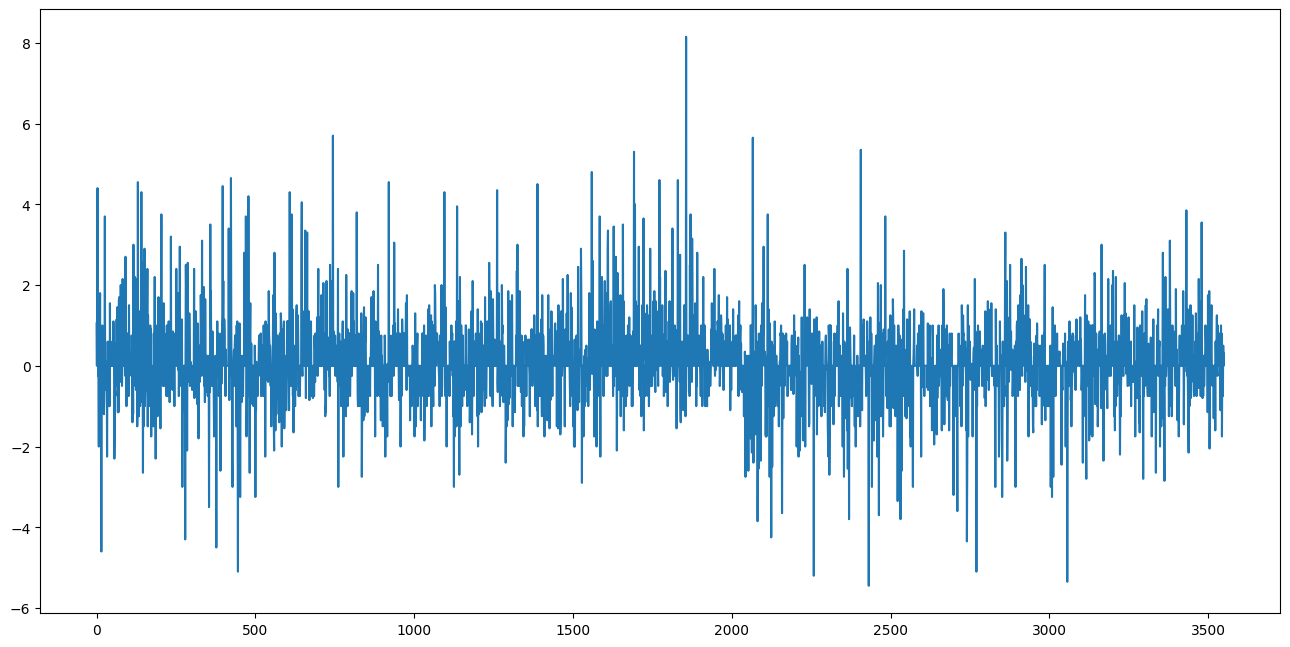

In [ ]:
# Verify 

corpus_sents_df['sentimentr'].plot();

### **Calculate Syuzhet (Jockers) Sentiment Polarities (Optional: Auto)**

In [ ]:
# Define Model names
model_base = 'syuzhet'
model_name = 'syuzhet_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
# Verify Lexicon subdirectory and datafiles
!ls /gdrive/MyDrive/$LEXICONS_SUBDIR

print('\nTop of Dictionary datafile ----------')
!head -n 5  /gdrive/MyDrive/$LEXICONS_SUBDIR/hash_sentiment_syuzhet.csv

hash_sentiment_bing.csv       hash_sentiment_sentimentr.csv
hash_sentiment_nrc.csv	      hash_sentiment_sentiword.csv
hash_sentiment_senticnet.csv  hash_sentiment_syuzhet.csv

Top of Dictionary datafile ----------
"","word","value"
"1","abandon",-0.75
"2","abandoned",-0.5
"3","abandoner",-0.25
"4","abandonment",-0.25


In [ ]:
# Read Lexicon into DataFrame 

if Syuzhet_Arc == True:

  lexicon_syuzhet_df = get_lexicon(f'/gdrive/MyDrive/{LEXICONS_SUBDIR}/hash_sentiment_syuzhet.csv')
  lexicon_syuzhet_df['word'] = lexicon_syuzhet_df['word'].astype('string')

  # Clean/Reorg DataFrame
  lexicon_syuzhet_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
  lexicon_syuzhet_df.rename(columns={'x':'word', 'y':'polarity'}, inplace=True)

  # Verify
  if (PLOT_OUTPUT == 'All'):
    lexicon_syuzhet_df.head()
    lexicon_syuzhet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10748 entries, 0 to 10747
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10748 non-null  int64  
 1   word        10748 non-null  object 
 2   value       10748 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 252.0+ KB


In [ ]:
# Convert DataFrame to Dict[word] = polarity

if Syuzhet_Arc == True:

  id = lexicon_syuzhet_df.word.values
  values = lexicon_syuzhet_df.value.values

  lexicon_syuzhet_dt = dict(zip(id, values))
  # lexicon_sentimentr_dt

  # Test
  sent_test='I hate Mondays.'
  print(text2sentiment(sent_test, lexicon_syuzhet_dt))

-0.75


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Sentiment evaluation function
def sentiment_syuzhet(text_str):
  '''
  Given a text string
  Return corresponding sentiment value based on sentimentr lexicon
  '''
  
  sentiment_val = text2sentiment(str(text_str), lexicon_syuzhet_dt)

  return sentiment_val 

# Calculate all Sentiment values and variants

if Syuzhet_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=sentiment_syuzhet, sentiment_type='lexicon')

Processing Lexicon/Sentences...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Paragraphs...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Sections...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'sentimentr_chaps': {'sentiment_max': 353.55000000000183,
  'sentiment_min': -44.69999999999998},
 'sentimentr_parags': {'sentiment_max': 14.650000000000002,
  'sentiment_min': -9.800000000000002},
 'sentimentr_sects': {'sentiment_max': 115.29999999999983,
  'sentiment_min': -23.050000000000004},
 'sentimentr_sents': {'sentiment_max': 8.149999999999999,
  'sentiment_min': -5.45},
 'syuzhet_chaps': {'sentiment_max': 367.85000000000224,
  'sentiment_min': -37.599999999999994},
 'syuzhet_parags': {'sentiment_max': 12.900000000000002,
  'sentiment_min': -10.800000000000002},
 'syuzhet_sects': {'sentiment_max': 118.34999999

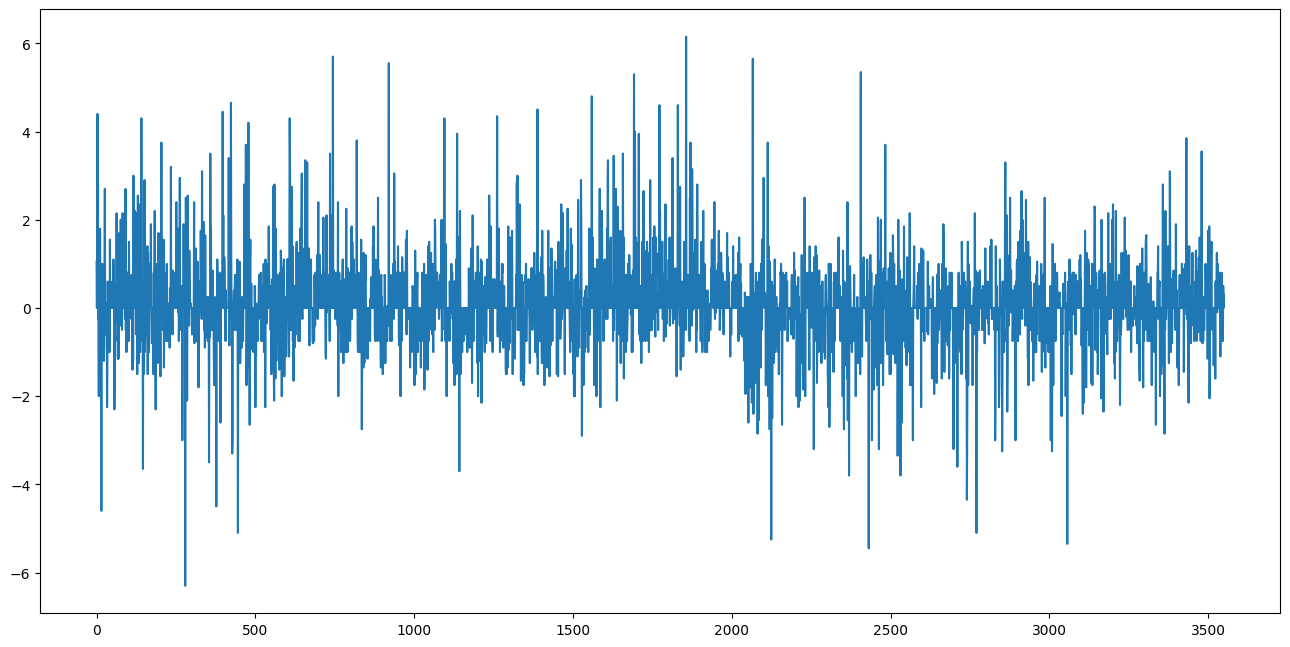

In [ ]:
# Verify 

corpus_sents_df['syuzhet'].plot();

### **Calculate Bing (HuLiu) Sentiment Polarities (Optional: Auto)**

In [ ]:
model_base = 'bing'
model_name = 'bing_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
# Verify Lexicon subdirectory and datafiles
!ls /gdrive/MyDrive/$LEXICONS_SUBDIR

print('\nTop of Dictionary datafile ----------')
!head -n 5  /gdrive/MyDrive/$LEXICONS_SUBDIR/hash_sentiment_bing.csv

hash_sentiment_bing.csv       hash_sentiment_sentimentr.csv
hash_sentiment_nrc.csv	      hash_sentiment_sentiword.csv
hash_sentiment_senticnet.csv  hash_sentiment_syuzhet.csv

Top of Dictionary datafile ----------
"","x","y"
"1","a plus",1
"2","abnormal",-1
"3","abolish",-1
"4","abominable",-1


In [ ]:
# Read Lexicon into DataFrame 

if Bing_Arc == True:
  
  lexicon_bing_df = get_lexicon(f'/gdrive/MyDrive/{LEXICONS_SUBDIR}/hash_sentiment_bing.csv')
  lexicon_bing_df['x'] = lexicon_bing_df['x'].astype('string')

  # Clean/Reorg DataFrame
  lexicon_bing_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
  lexicon_bing_df.rename(columns={'x':'word', 'y':'polarity'}, inplace=True)

  # Verify
  if (PLOT_OUTPUT == 'All'):
    lexicon_bing_df.head()
    lexicon_bing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6874 entries, 0 to 6873
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6874 non-null   int64  
 1   x           6874 non-null   object 
 2   y           6874 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 161.2+ KB


In [ ]:
# Convert DataFrame to Dict[word] = polarity

if Bing_Arc == True:

  id = lexicon_bing_df.word.values
  values = lexicon_bing_df.polarity.values

  lexicon_bing_dt = dict(zip(id, values))


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Sentiment evaluation function
def sentiment_bing(text_str):
  '''
  Given a text string
  Return corresponding sentiment value based on sentimentr lexicon
  '''
  
  sentiment_val = text2sentiment(str(text_str), lexicon_bing_dt)

  return sentiment_val 

# Calculate all Sentiment values and variants
if Bing_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=sentiment_bing, sentiment_type='lexicon')

Processing Lexicon/Sentences...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Paragraphs...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Sections...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Chapters...


In [ ]:
# Calculate Bing Sentiment [0,1,2]

def bing_discrete2continous_sentiment(text):
  '''
  Given a plain text string, give it to
    Stanford Stanza (OpenNLP) to calculate sentiment for each word on a 3 point scale 0-2
  Return a sentiment value for the entire sentence (sum of word sentiments/log(len of sentence)) 
    that approximates a normal distribution for all values
    In order to get more fine grained measure of overall Sentence sentiment
    Sentiment values will be Normalized/Standardized so absolute precision is not required
  '''
  text_sentiment_total = 0.
  text_ls = text.split()
  text_len = len(text_ls)
  for aword in text_ls:
    text_sentiment_total += lex_discrete2continous_sentiment(str(aword), lexicon_bing_dt)
  text_sentiment_norm = text_sentiment_total/(np.log(text_len)+1)

  return text_sentiment_norm

In [ ]:
# Test

if Bing_Arc == True:
  sent_test='I hate Mondays.'
  print(bing_discrete2continous_sentiment(sent_test))

-47.650535804050435


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Calculate all Sentiment values and variants
if Bing_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=bing_discrete2continous_sentiment, sentiment_type='function')

Processing Lexicon/Sentences...
Processing Lexicon/Paragraphs...
Processing Lexicon/Sections...
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'sentimentr_chaps': {'sentiment_max': 353.55000000000183,
  'sentiment_min': -44.69999999999998},
 'sentimentr_parags': {'sentiment_max': 14.650000000000002,
  'sentiment_min': -9.800000000000002},
 'sentimentr_sects': {'sentiment_max': 115.29999999999983,
  'sentiment_min': -23.050000000000004},
 'sentimentr_sents': {'sentiment_max': 8.149999999999999,
  'sentiment_min': -5.45},
 'syuzhet_chaps': {'sentiment_max': 367.85000000000224,
  'sentiment_min': -37.599999999999994},
 'syuzhet_parags': {'sentiment_max': 12.900000000000002,
  'sentiment_min': -10.800000000000002},
 'syuzhet_sects': {'sentiment_max': 118.34999999

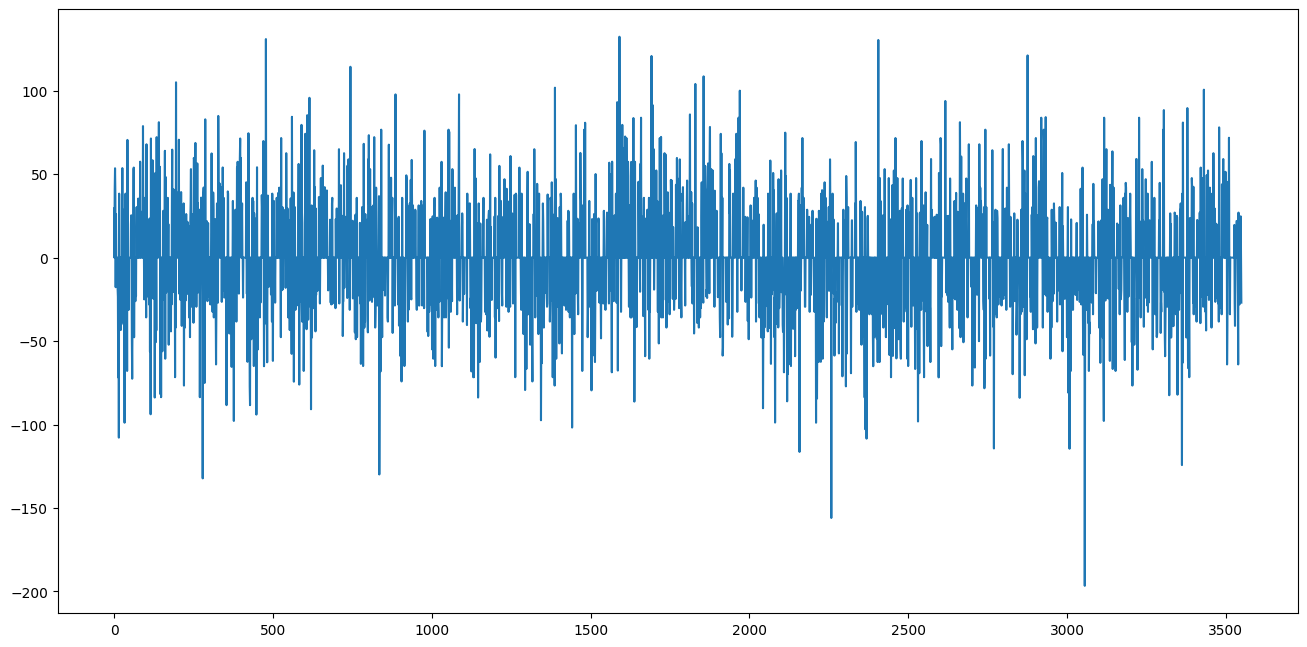

In [ ]:
# Verify 

corpus_sents_df['bing'].plot();

### **Calculate SentiWord Sentiment Polarities (Optional: Auto)**

In [ ]:
model_base = 'sentiword'
model_name = 'sentiword_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
# Verify Lexicon subdirectory and datafiles
!ls /gdrive/MyDrive/$LEXICONS_SUBDIR

print('\nTop of Dictionary datafile ----------')
!head -n 5  /gdrive/MyDrive/$LEXICONS_SUBDIR/hash_sentiment_sentiword.csv

hash_sentiment_bing.csv       hash_sentiment_sentimentr.csv
hash_sentiment_nrc.csv	      hash_sentiment_sentiword.csv
hash_sentiment_senticnet.csv  hash_sentiment_syuzhet.csv

Top of Dictionary datafile ----------
"","x","y"
"1","365 days",-0.5
"2","366 days",0.25
"3","3tc",-0.25
"4","a fortiori",0.25


In [ ]:
# Read Lexicon into DataFrame 

if SentiWord_Arc == True:

  lexicon_sentiword_df = get_lexicon(f'/gdrive/MyDrive/{LEXICONS_SUBDIR}/hash_sentiment_sentiword.csv')
  lexicon_sentiword_df['x'] = lexicon_sentiword_df['x'].astype('string')

  # Clean/Reorg DataFrame
  lexicon_sentiword_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
  lexicon_sentiword_df.rename(columns={'x':'word', 'y':'polarity'}, inplace=True)

  # Verify
  if (PLOT_OUTPUT == 'All'):
    lexicon_sentiword_df.head()
    lexicon_sentiword_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20093 entries, 0 to 20092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20093 non-null  int64  
 1   x           20092 non-null  object 
 2   y           20093 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 471.1+ KB


In [ ]:
# Convert DataFrame to Dict[word] = polarity

if SentiWord_Arc == True:

  id = lexicon_sentiword_df.word.values
  values = lexicon_sentiword_df.polarity.values

  lexicon_sentiword_dt = dict(zip(id, values))
  # lexicon_sentiword_dt

  # Test
  sent_test='I hate Mondays.'
  print(text2sentiment(sent_test, lexicon_sentiword_dt))

-0.25


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Sentiment evaluation function
def sentiment_sentiword(text_str):
  '''
  Given a text string
  Return corresponding sentiment value based on sentimentr lexicon
  '''
  
  sentiment_val = text2sentiment(str(text_str), lexicon_sentiword_dt)

  return sentiment_val 

# Calculate all Sentiment values and variants
if SentiWord_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=sentiment_sentiword, sentiment_type='lexicon')

Processing Lexicon/Sentences...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Paragraphs...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Sections...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'sentimentr_chaps': {'sentiment_max': 353.55000000000183,
  'sentiment_min': -44.69999999999998},
 'sentimentr_parags': {'sentiment_max': 14.650000000000002,
  'sentiment_min': -9.800000000000002},
 'sentimentr_sects': {'sentiment_max': 115.29999999999983,
  'sentiment_min': -23.050000000000004},
 'sentimentr_sents': {'sentiment_max': 8.149999999999999,
  'sentiment_min': -5.45},
 'sentiword_chaps': {'sentiment_max': 228.27798095238086,
  'sentiment_min': -14.021707539682547},
 'sentiword_parags': {'sentiment_max': 11.328394444444445,
  'sentiment_min': -7.099702380952381},
 'sentiword_sects': {'sentiment_max': 80.2253

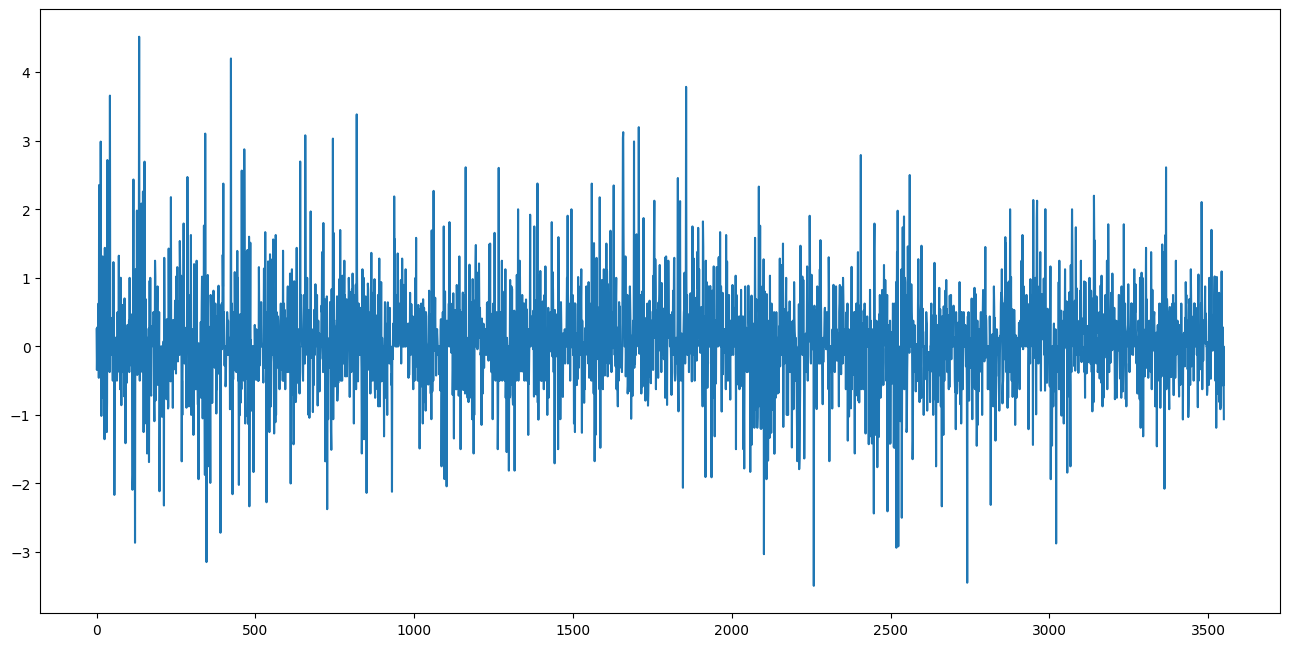

In [ ]:
# Verify 

corpus_sents_df['sentiword'].plot();

### **Calculate SenticNet Sentiment Polarities (Optional: Auto)**

* https://sentic.net/

In [ ]:
model_base = 'senticnet'
model_name = 'senticnet_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
# Verify Lexicon subdirectory and datafiles
!ls /gdrive/MyDrive/$LEXICONS_SUBDIR

print('\nTop of Dictionary datafile ----------')
!head -n 5  /gdrive/MyDrive/$LEXICONS_SUBDIR/hash_sentiment_senticnet.csv

hash_sentiment_bing.csv       hash_sentiment_sentimentr.csv
hash_sentiment_nrc.csv	      hash_sentiment_sentiword.csv
hash_sentiment_senticnet.csv  hash_sentiment_syuzhet.csv

Top of Dictionary datafile ----------
"","x","y"
"1","aaa",0.606
"2","aah",-0.51
"3","abandon",-0.56
"4","abandonment",-0.65


In [ ]:
# Read Lexicon into DataFrame 

if SenticNet_Arc == True:

  lexicon_senticnet_df = get_lexicon(f'/gdrive/MyDrive/{LEXICONS_SUBDIR}/hash_sentiment_senticnet.csv')
  lexicon_senticnet_df['x'] = lexicon_senticnet_df['x'].astype('string')

  # Clean/Reorg DataFrame
  lexicon_senticnet_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
  lexicon_senticnet_df.rename(columns={'x':'word', 'y':'polarity'}, inplace=True)

  # Verify
  if (PLOT_OUTPUT == 'All'):
    lexicon_senticnet_df.head()
    lexicon_senticnet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23626 entries, 0 to 23625
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  23626 non-null  int64  
 1   x           23625 non-null  object 
 2   y           23626 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 553.9+ KB


In [ ]:
# Convert DataFrame to Dict[word] = polarity

if SenticNet_Arc == True:

  id = lexicon_senticnet_df.word.values
  values = lexicon_senticnet_df.polarity.values

  lexicon_senticnet_dt =dict(zip(id, values))
  # lexicon_jockersrinker_dt

  # Test
  sent_test='I hate Mondays.'
  text2sentiment(sent_test, lexicon_senticnet_dt)

-0.83

In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Sentiment evaluation function
def sentiment_senticnet(text_str):
  '''
  Given a text string
  Return corresponding sentiment value based on senticnet lexicon
  '''
  
  sentiment_val = text2sentiment(str(text_str), lexicon_senticnet_dt)

  return sentiment_val 

# Calculate all Sentiment values and variants
if SenticNet_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=sentiment_senticnet, sentiment_type='lexicon')

Processing Lexicon/Sentences...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Paragraphs...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Sections...
ERROR: text2sentiment() given empty/null/invalid string: 
ERROR: text2sentiment() given empty/null/invalid string: 
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'senticnet_chaps': {'sentiment_max': 917.4810000000164,
  'sentiment_min': 34.97100000000007},
 'senticnet_parags': {'sentiment_max': 35.447999999999965,
  'sentiment_min': -12.118999999999993},
 'senticnet_sects': {'sentiment_max': 176.34399999999988,
  'sentiment_min': -6.565999999999999},
 'senticnet_sents': {'sentiment_max': 10.437000000000001,
  'sentiment_min': -5.943999999999999},
 'sentimentr_chaps': {'sentiment_max': 353.55000000000183,
  'sentiment_min': -44.69999999999998},
 'sentimentr_parags': {'sentiment_max': 14.650000000000002,
  'sentiment_min': -9.800000000000002},
 'sentimentr_sects': {'sentiment_max

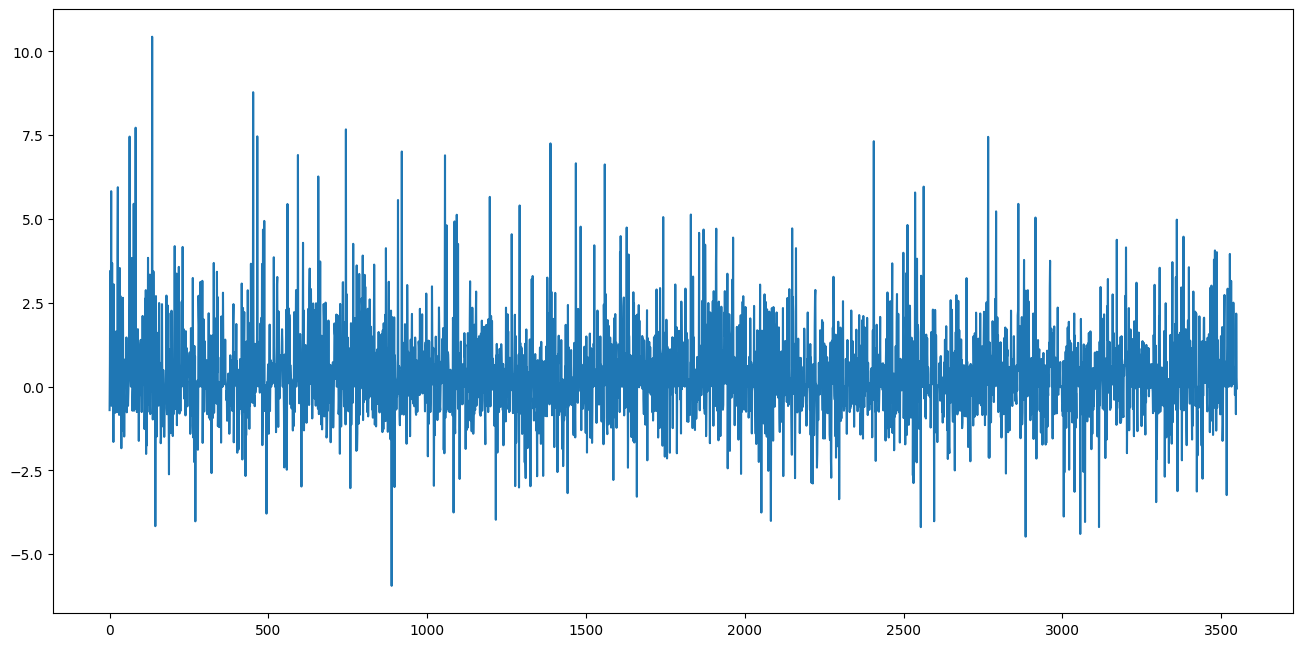

In [ ]:
# Verify 

corpus_sents_df['senticnet'].plot();

### **Calculate NRC Sentiment Polarities (Optional: Auto)**

In [ ]:
model_base = 'nrc'
model_name = 'nrc_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
# Verify Lexicon subdirectory and datafiles
!ls /gdrive/MyDrive/$LEXICONS_SUBDIR

print('\nTop of Dictionary datafile ----------')
!head -n 5  /gdrive/MyDrive/$LEXICONS_SUBDIR/hash_sentiment_nrc.csv

hash_sentiment_bing.csv       hash_sentiment_sentimentr.csv
hash_sentiment_nrc.csv	      hash_sentiment_sentiword.csv
hash_sentiment_senticnet.csv  hash_sentiment_syuzhet.csv

Top of Dictionary datafile ----------
"","x","y"
"1","abandon",-1
"2","abandoned",-1
"3","abandonment",-1
"4","abba",1


In [ ]:
# Read Lexicon into DataFrame 

if NRC_Arc == True:

  lexicon_nrc_df = get_lexicon(f'/gdrive/MyDrive/{LEXICONS_SUBDIR}/hash_sentiment_nrc.csv')
  lexicon_nrc_df['x'] = lexicon_nrc_df['x'].astype('string')

  # Clean/Reorg DataFrame
  lexicon_nrc_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
  lexicon_nrc_df.rename(columns={'x':'word', 'y':'polarity'}, inplace=True)

  # Verify
  if (PLOT_OUTPUT == 'All'):
    lexicon_nrc_df.head()
    lexicon_nrc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5468 entries, 0 to 5467
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5468 non-null   int64 
 1   x           5468 non-null   object
 2   y           5468 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 128.3+ KB


In [ ]:
# Convert DataFrame to Dict[word] = polarity

if NRC_Arc == True:

  id = lexicon_nrc_df.word.values
  values = lexicon_nrc_df.polarity.values

  lexicon_nrc_dt =dict(zip(id, values))
  # lexicon_jockersrinker_dt

In [ ]:
# Calculate NRC Sentiment [0,1,2]

def nrc_discrete2continous_sentiment(text):
  '''
  Given a plain text string, give it to
    Stanford Stanza (OpenNLP) to calculate sentiment for each word on a 3 point scale 0-2
  Return a sentiment value for the entire sentence (sum of word sentiments/log(len of sentence)) 
    that approximates a normal distribution for all values
    In order to get more fine grained measure of overall Sentence sentiment
    Sentiment values will be Normalized/Standardized so absolute precision is not required
  '''
  text_sentiment_total = 0.
  text_ls = text.split()
  text_len = len(text_ls)
  for aword in text_ls:
    text_sentiment_total += lex_discrete2continous_sentiment(str(aword), lexicon_nrc_dt)
  text_sentiment_norm = text_sentiment_total/(np.log(text_len)+10)

  return text_sentiment_norm
  

In [ ]:
# Test

if NRC_Arc == True:
  sent_test='I hate Mondays.'
  print(nrc_discrete2continous_sentiment(sent_test))

-9.010135447483094


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Calculate all Sentiment values and variants
if NRC_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=nrc_discrete2continous_sentiment, sentiment_type='function')

Processing Lexicon/Sentences...
Processing Lexicon/Paragraphs...
Processing Lexicon/Sections...
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'nrc_chaps': {'sentiment_max': 2329.948433604704,
  'sentiment_min': 10.732506313018147},
 'nrc_parags': {'sentiment_max': 111.59987578668733,
  'sentiment_min': -97.04213146044125},
 'nrc_sects': {'sentiment_max': 769.5231890169007,
  'sentiment_min': -172.97624844389225},
 'nrc_sents': {'sentiment_max': 62.744855603576006,
  'sentiment_min': -44.35782995049411},
 'senticnet_chaps': {'sentiment_max': 917.4810000000164,
  'sentiment_min': 34.97100000000007},
 'senticnet_parags': {'sentiment_max': 35.447999999999965,
  'sentiment_min': -12.118999999999993},
 'senticnet_sects': {'sentiment_max': 176.34399999999988,
  'se

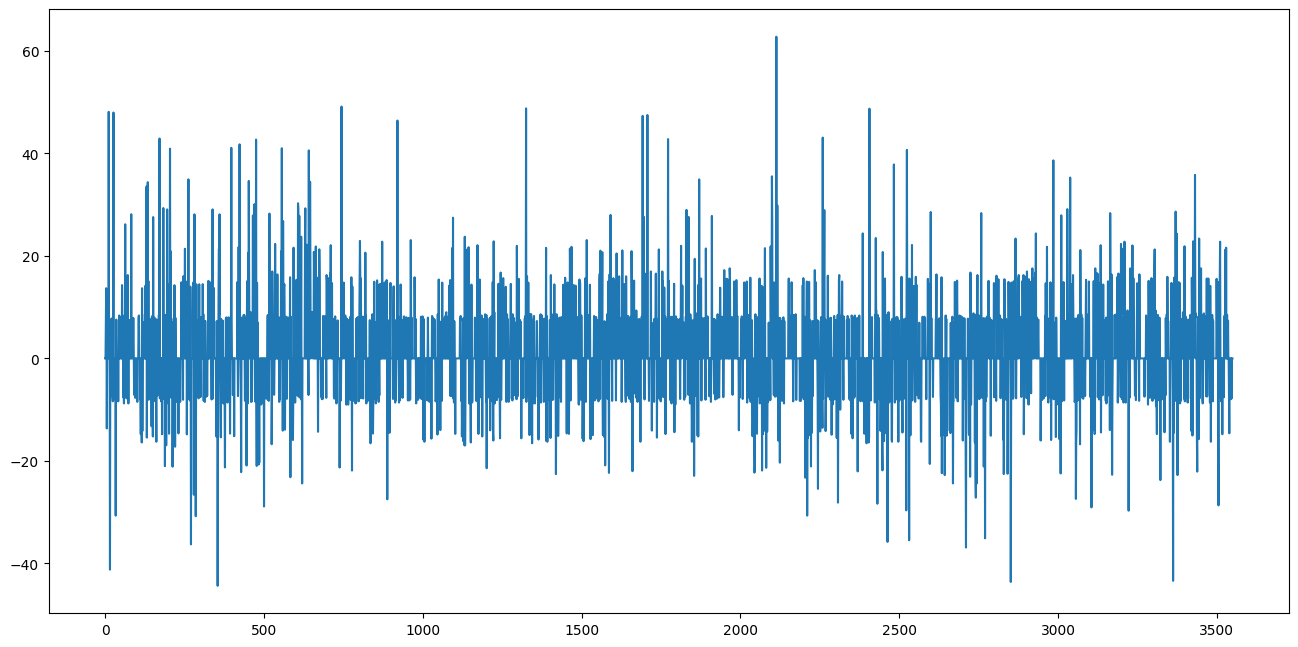

In [ ]:
# Verify 

corpus_sents_df['nrc'].plot();

### **Calculate Afinn Sentiment Polarities (Optional: Auto)**

* https://github.com/fnielsen/afinn

In [ ]:
model_base = 'afinn'
model_name = 'afinn_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
!pip install afinn

     |████████████████████████████████| 61kB 5.8MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53452 sha256=082883846696e1ae68698c3f4f3addba24c1ea10ae42f4cfa99a038cbdd72952
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [ ]:
# Install and configure for English

from afinn import Afinn
afinn = Afinn(language='en')

# Test

# afinn.score('I had the worst day.')

In [ ]:
# Calculate AFINN Sentiment [0,1,2]

def afinn_discrete2continous_sentiment(text):
  '''
  Given a plain text string, give it to
    Stanford Stanza (OpenNLP) to calculate sentiment for each word on a 3 point scale 0-2
  Return a sentiment value for the entire sentence (sum of word sentiments/log(len of sentence)) 
    that approximates a normal distribution for all values
    In order to get more fine grained measure of overall Sentence sentiment
    Sentiment values will be Normalized/Standardized so absolute precision is not required
  '''
  text_sentiment_total = 0.
  text_ls = text.split()
  text_len = len(text_ls)
  for aword in text_ls:
    text_sentiment_total += afinn.score(aword)
  text_sentiment_norm = text_sentiment_total/(np.log(text_len)+0.1)

  return float(text_sentiment_norm)  # return float vs np.float64

In [ ]:
# Test

if AFINN_Arc == True:
  sent_test='I hate Mondays.'
  print(afinn_discrete2continous_sentiment(sent_test))

-2.5028944124489


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Calculate all Sentiment values and variants
if AFINN_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=afinn_discrete2continous_sentiment, sentiment_type='function')

Processing Lexicon/Sentences...
Processing Lexicon/Paragraphs...
Processing Lexicon/Sections...
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'afinn_chaps': {'sentiment_max': 96.79610737139646,
  'sentiment_min': -1.1448228066158495},
 'afinn_parags': {'sentiment_max': 5.328106604950624,
  'sentiment_min': -5.308809711640159},
 'afinn_sects': {'sentiment_max': 34.93098375367672,
  'sentiment_min': -6.406879497008019},
 'afinn_sents': {'sentiment_max': 10.0, 'sentiment_min': -20.0},
 'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'nrc_chaps': {'sentiment_max': 2329.948433604704,
  'sentiment_min': 10.732506313018147},
 'nrc_parags': {'sentiment_max': 111.59987578668733,
  'sentiment_min': -97.04213146044125},
 'nrc_sects': {'sentiment_max': 769.5231890169007,
  'sentiment_min': -172.97624844389225},
 'nrc

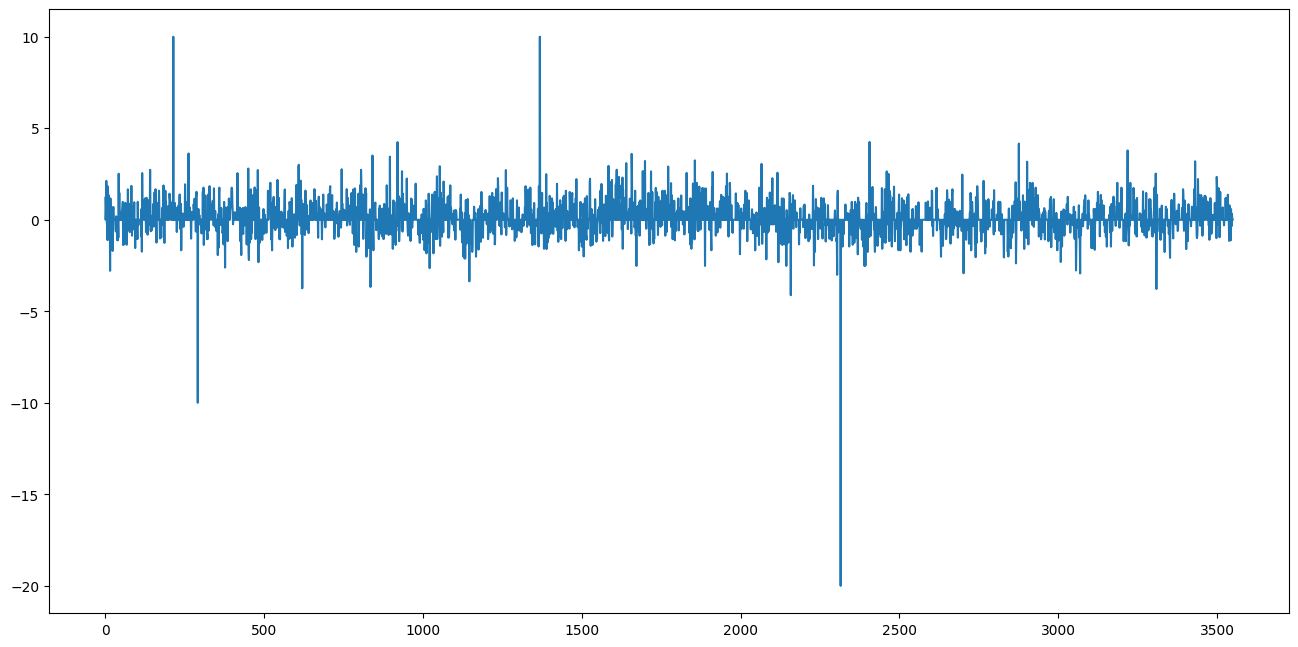

In [ ]:
# Verify 

corpus_sents_df['afinn'].plot();

### **Calculate VADER Sentiment Polarities (Optional: Auto)**

In [ ]:
model_base = 'vader'
model_name = 'vader_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
# Sentiment evaluation function
sid = SentimentIntensityAnalyzer()

# Test
sid.polarity_scores('hello world')

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

if VADER_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=sid.polarity_scores, sentiment_type='compound')

Processing Lexicon/Sentences...
Processing Lexicon/Paragraphs...
Processing Lexicon/Sections...
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'afinn_chaps': {'sentiment_max': 96.79610737139646,
  'sentiment_min': -1.1448228066158495},
 'afinn_parags': {'sentiment_max': 5.328106604950624,
  'sentiment_min': -5.308809711640159},
 'afinn_sects': {'sentiment_max': 34.93098375367672,
  'sentiment_min': -6.406879497008019},
 'afinn_sents': {'sentiment_max': 10.0, 'sentiment_min': -20.0},
 'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'nrc_chaps': {'sentiment_max': 2329.948433604704,
  'sentiment_min': 10.732506313018147},
 'nrc_parags': {'sentiment_max': 111.59987578668733,
  'sentiment_min': -97.04213146044125},
 'nrc_sects': {'sentiment_max': 769.5231890169007,
  'sentiment_min': -172.97624844389225},
 'nrc

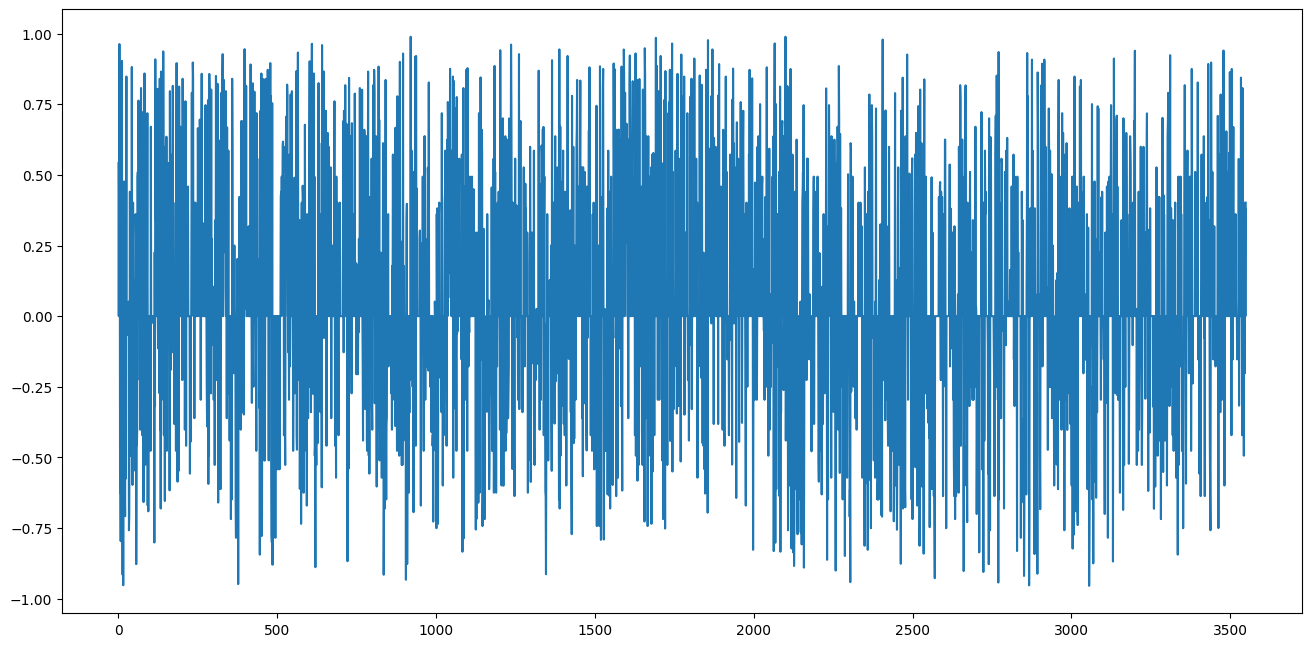

In [ ]:
# Verify 

corpus_sents_df['vader'].plot();

### **Calculate TextBlob Sentiment Polarities (Optional: Auto)**

In [ ]:
model_base = 'textblob'
model_name = 'textblob_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
from textblob import TextBlob

In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

def textblob_sentiment(text_str):
  '''
  Given a text string
  Return a sentiment value between -1.0 to +1.0 using TextBlob
  '''
  return TextBlob(text_str).sentiment.polarity

# Calculate all Sentiment values and variants
if TextBlob_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=textblob_sentiment, sentiment_type='function')

Processing Lexicon/Sentences...
Processing Lexicon/Paragraphs...
Processing Lexicon/Sections...
Processing Lexicon/Chapters...


In [ ]:
corpus_sects_df.columns

Index(['sect_no', 'sect_raw', 'sent_no_start', 'sent_no_mid', 'char_len',
       'token_len', 'sect_clean', 'sentimentr', 'sentimentr_meanstd',
       'sentimentr_medianiqr', 'sentimentr_lnorm_meanstd',
       'sentimentr_lnorm_medianiqr', 'syuzhet', 'syuzhet_meanstd',
       'syuzhet_medianiqr', 'syuzhet_lnorm_meanstd', 'syuzhet_lnorm_medianiqr',
       'bing', 'bing_meanstd', 'bing_medianiqr', 'bing_lnorm_meanstd',
       'bing_lnorm_medianiqr', 'sentiword', 'sentiword_meanstd',
       'sentiword_medianiqr', 'sentiword_lnorm_meanstd',
       'sentiword_lnorm_medianiqr', 'senticnet', 'senticnet_meanstd',
       'senticnet_medianiqr', 'senticnet_lnorm_meanstd',
       'senticnet_lnorm_medianiqr', 'nrc', 'nrc_meanstd', 'nrc_medianiqr',
       'nrc_lnorm_meanstd', 'nrc_lnorm_medianiqr', 'afinn', 'afinn_meanstd',
       'afinn_medianiqr', 'afinn_lnorm_meanstd', 'afinn_lnorm_medianiqr',
       'scores', 'vader', 'vader_meanstd', 'vader_medianiqr',
       'vader_lnorm_meanstd', 'vader_lnorm

In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_name, text_unit='sentence')
get_lexstats(corpus_parags_df, model_name, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_name, text_unit='section')
get_lexstats(corpus_chaps_df, model_name, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'afinn_chaps': {'sentiment_max': 96.79610737139646,
  'sentiment_min': -1.1448228066158495},
 'afinn_parags': {'sentiment_max': 5.328106604950624,
  'sentiment_min': -5.308809711640159},
 'afinn_sects': {'sentiment_max': 34.93098375367672,
  'sentiment_min': -6.406879497008019},
 'afinn_sents': {'sentiment_max': 10.0, 'sentiment_min': -20.0},
 'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'nrc_chaps': {'sentiment_max': 2329.948433604704,
  'sentiment_min': 10.732506313018147},
 'nrc_parags': {'sentiment_max': 111.59987578668733,
  'sentiment_min': -97.04213146044125},
 'nrc_sects': {'sentiment_max': 769.5231890169007,
  'sentiment_min': -172.97624844389225},
 'nrc

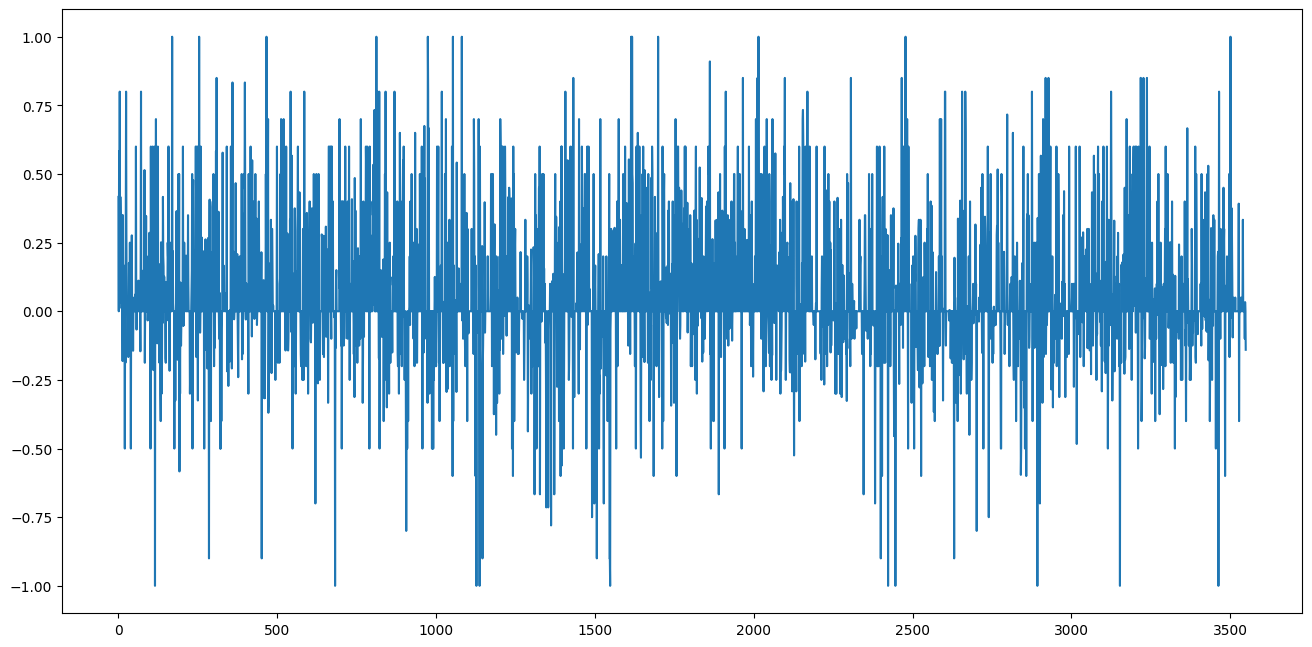

In [ ]:
# Verify 

corpus_sents_df['textblob'].plot();

### **Calculate Pattern Sentiment Polarities (Optional: Auto)**

In [ ]:
model_base = 'pattern'
model_name = 'pattern_lnorm_medianiqr'

col_medianiqr = f'{model_base}_medianiqr'
col_meanstd = f'{model_base}_meanstd'

col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
!pip install pattern

     |████████████████████████████████| 22.3MB 1.3MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 5.6MB 32.3MB/s 
     |████████████████████████████████| 5.6MB 22.4MB/s 
     |████████████████████████████████| 430kB 45.3MB/s 
     |████████████████████████████████| 3.2MB 30.3MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
  Created wheel for pattern: filename=Pattern-3.6-cp37-none-any.whl size=22332722 sha256=15df955afe98f354e651164a4fcfd3749605b8352c2abcacf8674fd9acdaa1b6
  Stored in directory: /root/.cache/pip/wheels/dc/9a/0e/5fb1a603ed4e3aa8722a88e9cf4a82da7d1b63e3d2cc34bee5
  Created wheel for mysqlclient: filename=mysqlclient-2.0.3-cp37-cp37m-linux_x86_64.whl size=100118 sha256=d3ab61a287ec7b7aec3b3e59ba2daebe0fba951d3b95880e9e3f14f2f19df8a5
  Stored in directory: /root/.cache/pip/wheels/75/ca/e8/ad4e7ce3df18bcd91c7d84dd28c7c08db491a2a2360efed363
  Created wheel

In [ ]:
from pattern.en import sentiment as pattern_sa

In [ ]:
# Test

sent_test='I hate Mondays.'
pattern_sa(sent_test)[0]

-0.8

In [ ]:
# Calculate Pattern Sentiment [0,1,2]

def pattern_discrete2continous_sentiment(text):
  '''
  Given a plain text string, give it to
    Stanford Stanza (OpenNLP) to calculate sentiment for each word on a 3 point scale 0-2
  Return a sentiment value for the entire sentence (sum of word sentiments/log(len of sentence)) 
    that approximates a normal distribution for all values
    In order to get more fine grained measure of overall Sentence sentiment
    Sentiment values will be Normalized/Standardized so absolute precision is not required
  '''
  text_sentiment_total = 0.
  text_ls = text.split()
  text_len = len(text_ls)
  for aword in text_ls:
    text_sentiment_total += pattern_sa(str(aword))[0]
  text_sentiment_norm = text_sentiment_total/(np.log(text_len)+0.01)

  return text_sentiment_norm

In [ ]:
# Test

if Pattern_Arc == True:
  sent_test='I hate Mondays.'
  print(pattern_discrete2continous_sentiment(sent_test))

-0.7216228867182435


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# Calculate all Sentiment values and variants
if Pattern_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=pattern_discrete2continous_sentiment, sentiment_type='function')

Processing Lexicon/Sentences...
Processing Lexicon/Paragraphs...
Processing Lexicon/Sections...
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
get_lexstats(corpus_sects_df, model_base, text_unit='section')
get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

# Validate
corpus_lexicons_stats_dt

# corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'afinn_chaps': {'sentiment_max': 96.79610737139646,
  'sentiment_min': -1.1448228066158495},
 'afinn_parags': {'sentiment_max': 5.328106604950624,
  'sentiment_min': -5.308809711640159},
 'afinn_sects': {'sentiment_max': 34.93098375367672,
  'sentiment_min': -6.406879497008019},
 'afinn_sents': {'sentiment_max': 10.0, 'sentiment_min': -20.0},
 'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'nrc_chaps': {'sentiment_max': 2329.948433604704,
  'sentiment_min': 10.732506313018147},
 'nrc_parags': {'sentiment_max': 111.59987578668733,
  'sentiment_min': -97.04213146044125},
 'nrc_sects': {'sentiment_max': 769.5231890169007,
  'sentiment_min': -172.97624844389225},
 'nrc

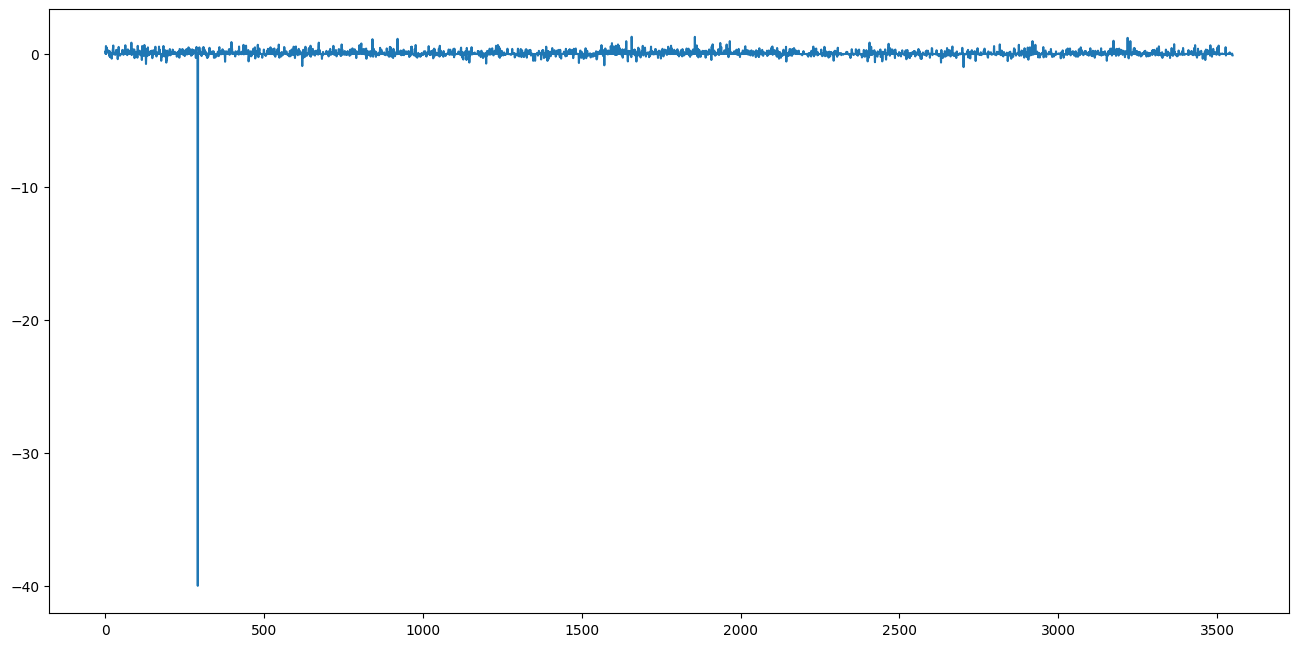

In [ ]:
# Verify 

corpus_sents_df['pattern'].plot();

In [ ]:
# Explore far outlier
corpus_sents_df[corpus_sents_df['pattern'] == corpus_sents_df['pattern'].min()]['sent_no']
print('\n')
corpus_sents_df[corpus_sents_df['pattern'] == corpus_sents_df['pattern'].min()]['sent_raw']

291    291
Name: sent_no, dtype: int64

291    Alas!
Name: sent_raw, dtype: string

In [ ]:
pattern_sa('Alas!')[0]

-0.5

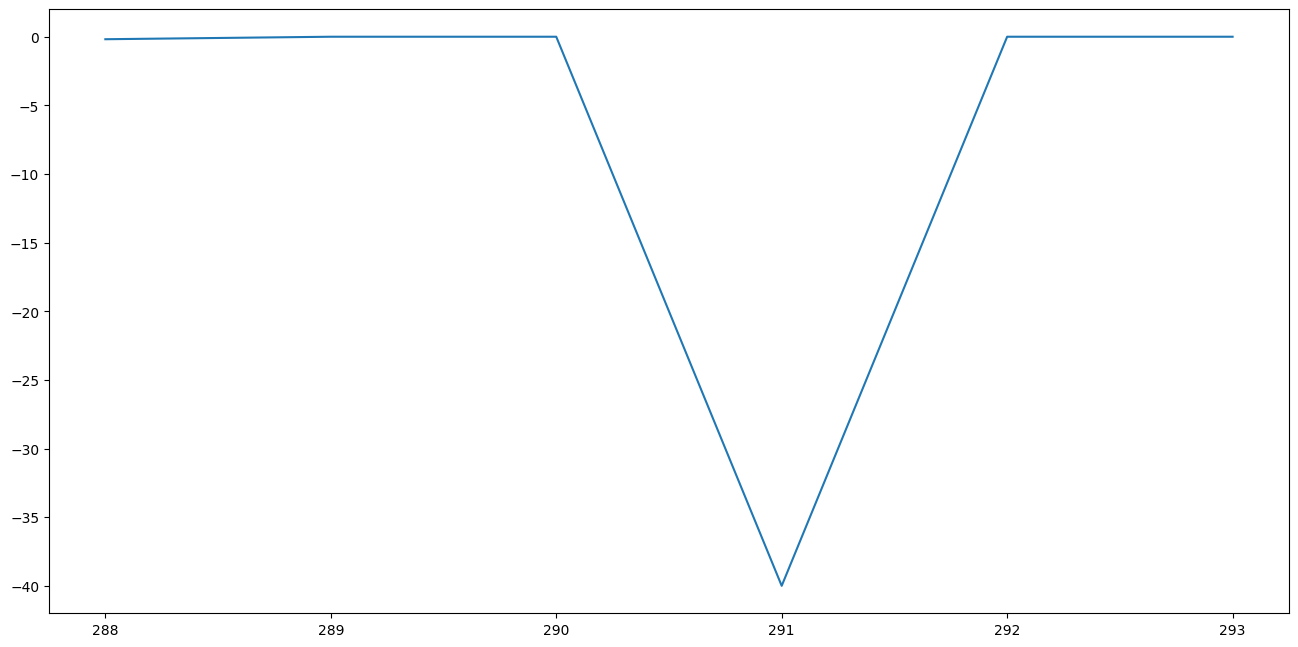

In [ ]:
corpus_sents_df.iloc[288:294]['pattern'].plot()

### **Calculate Stanza/OpenNLP Sentiment Polarities (Optional: Auto)**

* https://github.com/piyushpathak03/NLP-using-STANZA/blob/main/Stanza.ipynb

In [ ]:
if Stanza_Arc == True:
  model_base = 'stanza'
  model_name = 'stanza_lnorm_medianiqr'

  col_medianiqr = f'{model_base}_medianiqr'
  col_meanstd = f'{model_base}_meanstd'

  col_lnorm_medianiqr = f'{model_base}_lnorm_medianiqr'
  col_lnorm_meanstd = f'{model_base}_lnorm_meanstd'

In [ ]:
!pip install stanza

     |████████████████████████████████| 337kB 15.0MB/s 


In [ ]:
%time

import stanza

if Stanza_Arc == True:
  stanza.download('en')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


2021-07-12 21:40:04 INFO: Downloading default packages for language: en (English)...


2021-07-12 21:41:27 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
if Stanza_Arc == True:
  nlp = stanza.Pipeline('en', processors='tokenize,sentiment')

2021-07-12 21:41:27 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-07-12 21:41:27 INFO: Use device: cpu
2021-07-12 21:41:27 INFO: Loading: tokenize
2021-07-12 21:41:27 INFO: Loading: sentiment
2021-07-12 21:41:28 INFO: Done loading processors!


In [ ]:
# Test stanza directly

# doc = nlp('Ram is a bad boy')
# for i, sentence in enumerate(doc.sentences):
#     print(i, sentence.sentiment)

In [ ]:
# Calculate Stanza Sentiment [0,1,2]

def stanza_discrete2continous_sentiment(text):
  '''
  Given a plain text string, give it to
    Stanford Stanza (OpenNLP) to calculate sentiment for each word on a 3 point scale 0-2
  Return a sentiment value for the entire sentence (sum of word sentiments/log(len of sentence)) 
    that approximates a normal distribution for all values
    In order to get more fine grained measure of overall Sentence sentiment
    Sentiment values will be Normalized/Standardized so absolute precision is not required
  '''
  text_sentiment_tot = 0.
  text_ls = text.split()
  text_len = len(text_ls)
  for aword in text_ls:
    adoc = nlp(aword)
    for i, sentence in enumerate(adoc.sentences):
      text_sentiment_tot += float(sentence.sentiment)
  text_sentiment_norm = text_sentiment_tot/(np.log(text_len)+0.1)

  return text_sentiment_norm

In [ ]:
# Test

if Stanza_Arc == True:
  sent_test='I hate Mondays.'
  print(stanza_discrete2continous_sentiment(sent_test))

1.6685962749659333


In [ ]:
# Calculate all the Sentence, Paragraph, Section and Chapter Sentiment Scores and Standardized variants

# NOTE: requires about 50mins (20210708 at 0730) Colab Pro: GPU+RAM

# Calculate all Sentiment values and variants
if Stanza_Arc == True:
  get_sentiments(model_base=model_base, sentiment_fn=stanza_discrete2continous_sentiment, sentiment_type='function')

Processing Lexicon/Sentences...
Processing Lexicon/Paragraphs...
Processing Lexicon/Sections...
Processing Lexicon/Chapters...


In [ ]:
# Get/Set Sentiment Statistics

if Stanza_Arc == True:
  get_lexstats(corpus_sents_df, model_base, text_unit='sentence')
  get_lexstats(corpus_parags_df, model_base, text_unit='paragraph')
  get_lexstats(corpus_sects_df, model_base, text_unit='section')
  get_lexstats(corpus_chaps_df, model_base, text_unit='chapter')

  # Validate
  corpus_lexicons_stats_dt

  # corpus_lexicons_stats_dt['vader']['sents']['sentiment_max']

{'afinn_chaps': {'sentiment_max': 96.79610737139646,
  'sentiment_min': -1.1448228066158495},
 'afinn_parags': {'sentiment_max': 5.328106604950624,
  'sentiment_min': -5.308809711640159},
 'afinn_sects': {'sentiment_max': 34.93098375367672,
  'sentiment_min': -6.406879497008019},
 'afinn_sents': {'sentiment_max': 10.0, 'sentiment_min': -20.0},
 'bing_chaps': {'sentiment_max': 1236.6636015978838,
  'sentiment_min': -1536.0499575687145},
 'bing_parags': {'sentiment_max': 198.15014248737035,
  'sentiment_min': -287.4960256143749},
 'bing_sects': {'sentiment_max': 596.1287530332917,
  'sentiment_min': -469.2323620910902},
 'bing_sents': {'sentiment_max': 132.3136502201503,
  'sentiment_min': -196.59989945944406},
 'nrc_chaps': {'sentiment_max': 2329.948433604704,
  'sentiment_min': 10.732506313018147},
 'nrc_parags': {'sentiment_max': 111.59987578668733,
  'sentiment_min': -97.04213146044125},
 'nrc_sects': {'sentiment_max': 769.5231890169007,
  'sentiment_min': -172.97624844389225},
 'nrc

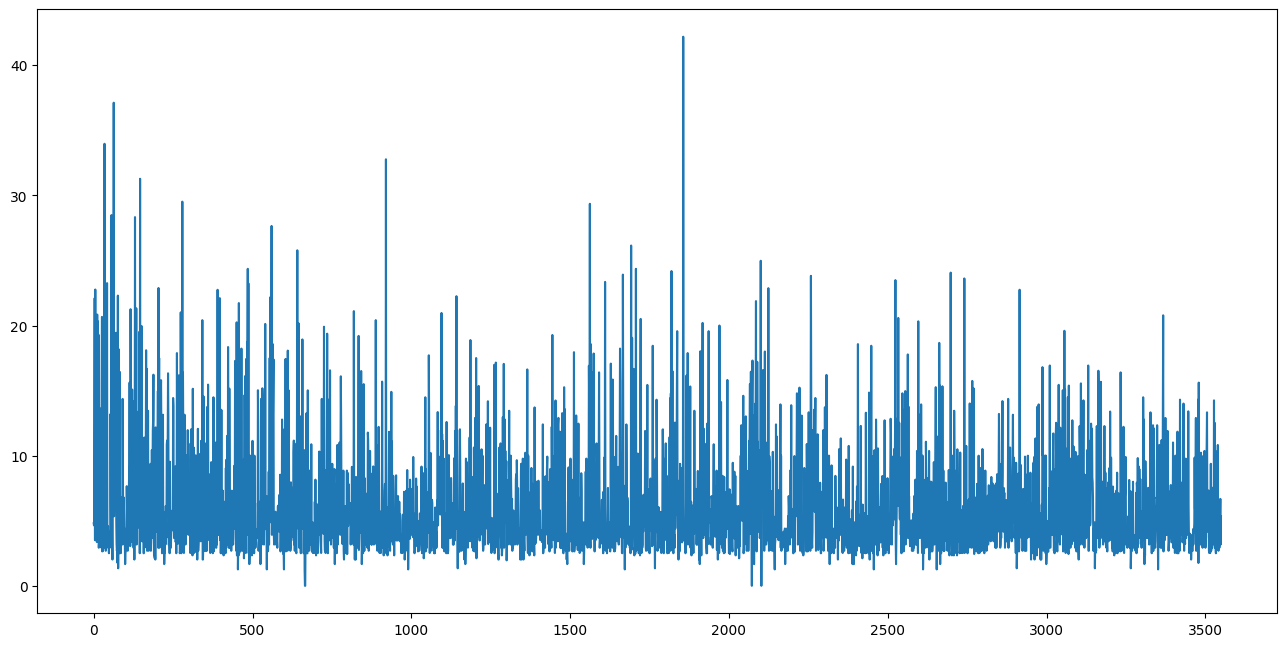

In [ ]:
# Verify 

corpus_sents_df['stanza'].plot();

## **(Optional) Calculate SentimentR Sentiments (Auto)**

```
> getwd()
> library('syuzhet')
> ttl_str <- syuzhet::get_text_as_string('ttl_final_hand.txt')
> ttl_sents_vec <- syuzhet::get_sentences(ttl_str)
> ttl_sents_syuzhet_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='syuzhet')
> ttl_sents_bing_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='bing')
> ttl_sents_afinn_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='afinn')
> ttl_sents_nrc_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='nrc')
> ttl_sents_syuzhet_df <- data.frame(ttl_sents_syuzhet_vec, ttl_sents_bing_vec, ttl_sents_afinn_vec, ttl_sents_nrc_vec)
> write.csv(ttl_sents_syuzhet_df, 'sum_sentiments_syuzhetR_4models_vwoolf_tothelighthouse.csv')
> ttl_sents_syuzhet_df
```

## **(Optional) Calculate SyuzhetR Sentiments (Auto)**

```
> getwd()
> library('syuzhet')
> ttl_str <- syuzhet::get_text_as_string('ttl_final_hand.txt')
> ttl_sents_vec <- syuzhet::get_sentences(ttl_str)
> ttl_sents_syuzhet_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='syuzhet')
> ttl_sents_bing_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='bing')
> ttl_sents_afinn_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='afinn')
> ttl_sents_nrc_vec <- syuzhet::get_sentiment(ttl_sents_vec, method='nrc')
> ttl_sents_syuzhet_df <- data.frame(ttl_sents_syuzhet_vec, ttl_sents_bing_vec, ttl_sents_afinn_vec, ttl_sents_nrc_vec)
> write.csv(ttl_sents_syuzhet_df, 'sum_sentiments_syuzhetR_4models_vwoolf_tothelighthouse.csv')
> ttl_sents_syuzhet_df
```

# **Save Raw Sentiment Time Series**

## **Sentence and Paragraph DataFrames (incl raw/clean text)**

In [ ]:
!pwd

/gdrive/My Drive/research/2021/sa_book_code/books_sa/vwoolf_tothelighthouse


In [ ]:
corpus_sents_df['sent_raw'].isna().any()

False

In [ ]:
CORPUS_TITLE

'To The Lighthouse'

In [ ]:
# Save Preprocessed Corpus Sentences DataFrame

author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")


# Save Sentences of original Raw and Cleaned Corpus
corpus_text_sentences_raw_filename = f'corpus_text_sentences_raw_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text raw sentences to file: {corpus_text_sentences_raw_filename}')
corpus_sents_df['sent_raw'].to_csv(corpus_text_sentences_raw_filename)

corpus_text_sentences_clean_filename = f'corpus_text_sentences_clean_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text clean sentences to file: {corpus_text_sentences_clean_filename}')
corpus_sents_df['sent_clean'].to_csv(corpus_text_sentences_clean_filename)


# Save Paragraphs of original Raw and Cleaned Corpus
corpus_text_paragraphs_raw_filename = f'corpus_text_paragraphs_raw_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text raw paragraphs to file: {corpus_text_paragraphs_raw_filename}')
corpus_parags_df['parag_raw'].to_csv(corpus_text_paragraphs_raw_filename)

corpus_text_paragraphs_clean_filename = f'corpus_text_paragraphs_clean_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus text clean sentences to file: {corpus_text_paragraphs_clean_filename}')
corpus_parags_df['parag_clean'].to_csv(corpus_text_paragraphs_clean_filename)



# Save the Sentiment Values at both the Sentence and Paragraph Levels
corpus_sents_filename = f'sum_sentiments_sents_baselines_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus Sentences to file: {corpus_sents_filename}')
corpus_sents_df.to_csv(corpus_sents_filename)

corpus_parags_filename = f'sum_sentiments_parags_baselines_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus Paragraphs to file: {corpus_parags_filename}')
corpus_parags_df.to_csv(corpus_parags_filename)

Saving Corpus text raw sentences to file: corpus_text_sentences_raw_virginiawoolf_tothelighthouse.csv
Saving Corpus text clean sentences to file: corpus_text_sentences_clean_virginiawoolf_tothelighthouse.csv
Saving Corpus text raw paragraphs to file: corpus_text_paragraphs_raw_virginiawoolf_tothelighthouse.csv
Saving Corpus text clean sentences to file: corpus_text_paragraphs_clean_virginiawoolf_tothelighthouse.csv
Saving Corpus Sentences to file: sum_sentiments_sents_baselines_virginiawoolf_tothelighthouse.csv
Saving Corpus Paragraphs to file: sum_sentiments_parags_baselines_virginiawoolf_tothelighthouse.csv


In [ ]:
# Verify exported Sentence Sentiments file

!head -n 5 $corpus_sents_filename

,sent_no,parag_no,sent_raw,char_len,token_len,sent_clean,sentimentr,sentimentr_lnorm_meanstd,sentimentr_medianiqr,sentimentr_lnorm_medianiqr,syuzhet,syuzhet_lnorm_meanstd,syuzhet_medianiqr,syuzhet_lnorm_medianiqr,bing,bing_lnorm_meanstd,bing_medianiqr,bing_lnorm_medianiqr,sentiword,sentiword_lnorm_meanstd,sentiword_medianiqr,sentiword_lnorm_medianiqr,senticnet,senticnet_lnorm_meanstd,senticnet_medianiqr,senticnet_lnorm_medianiqr,nrc,nrc_lnorm_meanstd,nrc_medianiqr,nrc_lnorm_medianiqr,afinn,afinn_lnorm_meanstd,afinn_medianiqr,afinn_lnorm_medianiqr,scores,vader,vader_lnorm_meanstd,vader_medianiqr,vader_lnorm_medianiqr,textblob,textblob_lnorm_meanstd,textblob_medianiqr,textblob_lnorm_medianiqr,pattern,pattern_lnorm_meanstd,pattern_medianiqr,pattern_lnorm_medianiqr,stanza,stanza_lnorm_meanstd,stanza_medianiqr,stanza_lnorm_medianiqr
0,0,0,"""Yes, of course, if it's fine tomorrow,"" said Mrs. Ramsay.",58,10,yes of course if it is fine tomorrow said mrs ramsay,1.05,1.221350182451316,1.2352941

# **EDA (Repeat for each Sentiment Model)** (Auto)

#### **Histograms**

**Sentiment Histogram Plots**

INSTRUCTIONS:

* Histograms are provided for the (a) Length-Normed and (b) Scaled (Median Interquartile Range) Sentiment values for Sentences, Paragraphs and Sections. 

* There we used extensively early on to compare which Sentiment Time series preprocessing techniques worked best with our various Novel corpora according to two criteria: 

* (a) Vertical Scaling Method with the ability to transform histograms of sentiment values to well-behaved near-gaussian distributions and clipping outliers. After experimenting with various techniques including: mean/STD, median/MAD, and various two stage outlier/normalization methods median/IQR proved best (define).

* (b) Horizontal Scaling

In [ ]:
plot_histogram(model_name=model_name, text_unit='sentence', save2file=False)

In [ ]:
# col_medianiqr = f'{model_name}_medianiqr'
plot_histogram(model_name=col_medianiqr, text_unit='sentence', save2file=False)

In [ ]:
corpus_sents_df.info()

In [ ]:
# Plot Histogram of Sentence lengths

# col_lnorm_medianiqr = f'{model_name}_lnorm_medianiqr'
plot_histogram(model_name=col_lnorm_medianiqr, text_unit='sentence', save2file=False)

In [ ]:
plot_histogram(model_name=model_name, text_unit='paragraph', save2file=False)

In [ ]:
# col_medianiqr = f'{model_name}_medianiqr'
plot_histogram(model_name=col_medianiqr, text_unit='paragraph', save2file=False)

In [ ]:
# Plot Histogram of Paragraph lengths

# col_lnorm_medianiqr = f'{model_name}_lnorm_medianiqr'
plot_histogram(model_name=col_lnorm_medianiqr, text_unit='paragraph', save2file=False)

In [ ]:
plot_histogram(model_name=model_name, text_unit='section', save2file=False)

In [ ]:
# col_medianiqr = f'{model_name}_medianiqr'
plot_histogram(model_name=col_medianiqr, text_unit='section', save2file=False)

In [ ]:
# Plot Histogram of Section lengths

# col_lnorm_medianiqr = f'{model_name}_lnorm_medianiqr'
plot_histogram(model_name=col_lnorm_medianiqr, text_unit='section', save2file=False)

#### **Raw Sentiment Plots**

In [ ]:
plot_raw_sentiments(model_name=model_name, semantic_type='sentence', save2file=False)

In [ ]:
# col_medianiqr = f'{model_name}_medianiqr'
plot_raw_sentiments(model_name=col_medianiqr, semantic_type='sentence', save2file=False)

In [ ]:
# Plot Raw Sentence Sentiments

# col_lnorm_medianiqr = f'{model_name}_lnorm_medianiqr'
plot_raw_sentiments(model_name=col_lnorm_medianiqr, semantic_type='sentence', save2file=False)

In [ ]:
plot_raw_sentiments(model_name=model_name, semantic_type='paragraph', save2file=False)

In [ ]:
# col_medianiqr = f'{model_name}_medianiqr'
plot_raw_sentiments(model_name=col_medianiqr, semantic_type='paragraph', save2file=False)

In [ ]:
# Plot Raw Paragraph Sentiments

# col_lnorm_medianiqr = f'{model_name}_lnorm_medianiqr'
plot_raw_sentiments(model_name=model_name, semantic_type='paragraph', save2file=False)

In [ ]:
# TODO: Add Section Crux Nos

In [ ]:
plot_raw_sentiments(model_name=model_name, semantic_type='section', save2file=False)

plt.legend(loc='best')

In [ ]:
# col_medianiqr = f'{model_name}_medianiqr'
# col_meanstd = f'{model_name}_meanstd'

plot_raw_sentiments(model_name=col_medianiqr, semantic_type='section', save2file=False)
plot_raw_sentiments(model_name=col_meanstd, semantic_type='section', save2file=False)

plt.legend(loc='best')

In [ ]:
# Plot Raw Standardized Section Sentiments

# NOTE: Compared with Length-Normed, the Raw Standardizations lose most SATS features

# col_lnorm_medianiqr = f'{model_name}_lnorm_medianiqr'
# col_lnorm_meanstd = f'{model_name}_lnorm_meanstd'

plot_raw_sentiments(model_name=col_lnorm_medianiqr, semantic_type='section', save2file=False)
plot_raw_sentiments(model_name=col_lnorm_meanstd, semantic_type='section', save2file=False)

plt.legend(loc='best')

In [ ]:
# Plot Raw Standardized Chapter Sentiments

# col_lnorm_medianiqr = f'{model_name}_lnorm_medianiqr'
# col_lnorm_meanstd = f'{model_name}_lnorm_meanstd'

plot_raw_sentiments(model_name=col_lnorm_medianiqr, semantic_type='chapter', save2file=False)
plot_raw_sentiments(model_name=col_lnorm_meanstd, semantic_type='chapter', save2file=False)

#### **Crux Points and Surrounding Contexts**

In [ ]:
# Veify all the model sentiment variations

[x for x in corpus_sects_df.columns if x.startswith(model_base)]

**Compare Chapters vs Sections Crux Points**

INSTRUCTIONS:

* At the highest level, the Corpus is divided into Chapters which may then futher subdivided into Sections (e.g. extra spaces, punctuation like '* * *' or special printer glyph/fleuron).  Horizonal dark blue lines indicate Chapter divisions while Section boundries lie at both dark and light blue vertical lines.

* Since each Chapter may contain multiple Sections, the Section Sentiment plot is more detailed/jagged than the Chapter Sentiment plots. By plotting both together, the smoother Chapter Sentiment plot gives a more general sense of the Corpus Sentiment Arc while the next, more-detailed Section Sentiment plot enables a more detailed investigation/localization of Crux Point neighborhoods.

* At this early stage both the Chapter and Section Sentiment plots are too general to provide accurate/fixed Crux localization. As such, only aggregrate Sentiment values for each Chapter/Section are assigned to the mid-point of each Chapter/Section.

In [ ]:
# col_lnorm_medianiqr = 'pattern_lnorm_medianiqr'
col_lnorm_medianiqr

In [ ]:
# col_lnorm_medianiqr = 'vader_lnorm_medianiqr'

# corpus_chaps_df.drop(columns=['textblob_lnorm_medianiqr_lnorm_medianiqr', 'textblob_lnorm_medianiqr_medianiqr', 'textblob_lnorm_medianiqr_lnorm_meanstd'], inplace=True, axis=1)

In [ ]:
corpus_chaps_df.shape

In [ ]:
corpus_chaps_df.columns
# corpus_chaps_df.iloc[:20][['chap_no','sent_no_start','sent_no_mid','char_len','token_len','vader', 'vader_lnorm_medianiqr', 'textblob', 'textblob_lnorm_medianiqr']]

In [ ]:
corpus_chaps_df.vader_lnorm_medianiqr.min()

In [ ]:
col_lnorm_medianiqr = 'syuzhet_lnorm_medianiqr'
model_name = 'syuzhet_lnorm_medianiqr'
model_base = 'syuzhet'

In [ ]:
# Plot Annotated Section Cruxes of Raw Sentiment Time Series

sec_y_ht = 0

corpus_cruxes_dt[col_lnorm_medianiqr] = plot_crux_sections(model_names_ls=[model_base], semantic_type='chapter', label_token_ct=3, title_xpos=0.8, title_ypos=1.05, sec_y_height=sec_y_ht, save2file=False)

corpus_cruxes_dt[col_lnorm_medianiqr] = plot_crux_sections(model_names_ls=[model_base], semantic_type='section', label_token_ct=-1, title_xpos=0.8, title_ypos=1.05, sec_y_height=sec_y_ht, save2file=False)


In [ ]:
# Plot Annotated Section Cruxes of Standardized Sentiment Time Series

sec_y_ht = 0

corpus_cruxes_dt[col_lnorm_medianiqr] = plot_crux_sections(model_names_ls=[col_lnorm_medianiqr], semantic_type='chapter', label_token_ct=3, title_xpos=0.8, title_ypos=1.05, sec_y_height=sec_y_ht, save2file=False)

corpus_cruxes_dt[col_lnorm_medianiqr] = plot_crux_sections(model_names_ls=[col_lnorm_medianiqr], semantic_type='section', label_token_ct=-1, title_xpos=0.8, title_ypos=1.05, sec_y_height=sec_y_ht, save2file=False)


**Sections Crux Points in Detail**

In [ ]:
# Corpus Section Standardized Sentiment Time Series

sec_y_ht = 0

corpus_cruxes_dt[col_lnorm_medianiqr] = plot_crux_sections(model_names_ls=[col_lnorm_medianiqr], semantic_type='section', label_token_ct=5, title_xpos=0.8, title_ypos=1.05, sec_y_height=sec_y_ht, save2file=False)


**Verify Crux Point Sentence Number and Text Match**

INSTRUCTIONS:

* At [Crux_Sentence_Text] enter the first few words that uniquely identify the Crux Sentence and confirm the Sentence No matches the information in the plot above. (NOTE: Search is for an exact match including case and puncutation)

In [ ]:
Crux_Sentence_Text = "haiku" #@param {type:"string"}

# Verify individual Crux Sentence Numbers matches Content

crux_sent_no = int(corpus_sents_df[corpus_sents_df['sent_raw'].str.contains(Crux_Sentence_Text)]['sent_no'])

print(f'The Sentence:\n\n    {Crux_Sentence_Text}\n\nMatches Sentence #{crux_sent_no}')


**Review Context Around Any Crux Point**

INSTRUCTIONS:

* Enter [Crux_Sentence_No] that matches a Crux point/Sentence No you want to explore

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

In [ ]:
# Select details about the Crux Point Context to Retrieve

# print(f'Last Sentence No: {corpus_sents_df.shape[0]}')
Crux_Sentence_No =  4494#@param {type:"number"}
No_Paragraphs_on_Each_Side = 3 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}

corpus_sents_len = corpus_sents_df.shape[0]

# if (Crux_Sentence_No >= No_Paragraphs_on_Each_Side) & (Crux_Sentence_No+No_Paragraphs_on_Each_Side <= corpus_parag_len):
# get_sentnocontext_report()
# try:
get_sentnocontext_report(the_sent_no=Crux_Sentence_No, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)
# except:
#   print('ERROR')
# else:
#   print(f'ERROR: The combination of your [Crux_Sentence_No] and [No_Pargraphs_on_Each_Side]\n       results in a window outside the range of the Corpus Paragraphs.\n\n       Try again with different values.')

**Compare Paragraph vs Section Crux Points**

In [ ]:
# Verify the valid ranges for Sentences and Paragraphs

corpus_sents_len = corpus_sents_df.shape[0]
print(f'There are {corpus_sents_len} Sentences in the Corpus')
corpus_parags_len = corpus_parags_df.shape[0]
print(f'There are {corpus_parags_len} Paragraphs in the Corpus')

# Create a new Corpus Paragraph DataFrame (corpus_parags_zoom_df) that is streteched out to have as many sample points as there are Sentences
#   That is, go from an original corpus_parags_df of #Paragraph datapoints to an expanded corpus_parags_zoom_df of #Sentences datapoints using scipy.ndimage.interpolation.zoom

corpus_parags_zoom_df = pd.DataFrame()

resample_ratio = corpus_sents_df.shape[0]/corpus_parags_df.shape[0]   # ratio = no_sents/no_parags

corpus_parags_df_numcols_ls = corpus_parags_df.select_dtypes(include=['number']).columns

for acol in corpus_parags_df_numcols_ls:
  parags_zoom_temp_np = zoom(np.array(corpus_parags_df[acol]), resample_ratio)
  corpus_parags_zoom_df[acol] = pd.Series(parags_zoom_temp_np)

print('\n')
print(f'New expanded corpus_parags_zoom_df.shape = {corpus_parags_zoom_df.shape}')
print(f'           matches corpus_sents_df.shape = {corpus_sents_df.shape}')

**Adjust the Paragraph Sentiment Plot to compare it with the Section Sentiment Plot for this Corpus**

INSTRUCTIONS:

* Adjust [Scale_Vertical_Rolling_Paragraph] until the vertical min/max spans of the two plots are approximately equal

* Adjust [Set_Paragraph_Rolling_Window_Percent] to set horizonal smoothness of Rolling Paragraph (typically 5,10 or 20%)


In [ ]:
col_lnorm_medianiqr

In [ ]:
Scale_Vertical_Rolling_Paragraph = 2.7 #@param {type:"slider", min:0, max:20, step:0.1}
Set_Paragraph_Rolling_Window_Percent = 3 #@param {type:"slider", min:0, max:30, step:1}

# Compare Section Midpoints vs Sentence SMA Sentiment Values

scale_sma_paragraph = Scale_Vertical_Rolling_Paragraph
sentence_count = corpus_sents_df.shape[0]
if Set_Paragraph_Rolling_Window_Percent == 0:
  sma_parag_win = 1
else:
  sma_parag_win = int((Set_Paragraph_Rolling_Window_Percent/100)*sentence_count)


# corpus_parags_zoom_df['vader_lnorm_medianiqr'].rolling(window=sma_parag_win, center=True).mean().apply(lambda x: x*scale_sma_paragraph).plot(label=f'{model_base} Paragraphs', alpha=0.3)
corpus_parags_zoom_df[col_lnorm_medianiqr].rolling(window=sma_parag_win, center=True).mean().apply(lambda x: x*scale_sma_paragraph).plot(label=f'{model_base} Paragraphs', alpha=0.3)

_ = plot_crux_sections(model_names_ls=[col_lnorm_medianiqr], semantic_type='section', label_token_ct=0, title_xpos=0.5, title_ypos=1.0, sec_y_height=0, save2file=False)
plt.title(f'{CORPUS_FULL} \n SMA vs midpoint Paragraph MedianIQR Sentiment with Crux Points via SciPy.peaks')
plt.legend(loc='best');

#### **Zoom into a Section**

INSTRUCTIONS:

* At [Select_Section_No] pick a Section of the Corpus to zoom into

* Adjust [Scale_Vertical_Rolling_Sentences] until the vertical min/max spans of the two plots are approximately equal 

* Adjust [Set_Sentence_Rolling_Window_Percent] to set horizonal smoothness of Rolling Paragraph (typically 5,10 or 20%)

In [ ]:
# Explore a Corpus Section Up-Close

section_count = corpus_sects_df.shape[0]
print(f'There are {section_count} Sections in this corpus,\n  pick one numbered between 0 and {section_count-1}')

In [ ]:
Select_Section_No =  24#@param {type:"integer"}
Scale_Vertical_Rolling_Sentences = 0.2 #@param {type:"slider", min:0, max:20, step:0.1}
Set_Sentence_Rolling_Window_Percent = 3 #@param {type:"slider", min:0, max:30, step:1}

# Make Copies instead of just using References / Only Reference, not copy()
# section_sents_df = pd.DataFrame()
# section_parags_df = pd.DataFrame()

section_sents_df, section_parags_df = get_section_timeseries(Select_Section_No)

# section_sents_df.head()

print(f'section_sents_df.shape: {section_sents_df.shape}')
print(f'section_parags_df.shape: {section_parags_df.shape}')

In [ ]:
model_name

In [ ]:
# Add expanded Paragraph sentiment to corpus_sents_df
# section_sents_parags_df['vader_lnorm_medianiqr_parag'] = expand_parags2sents(parags_df='corpus_parags_df', sents_df='corpus_sents_df')

# NOTE: Define section_sents_df, MUST BE EXECUTED BEFORE ANY CRUX POINT DETECTION!!!

parags_midpoint_ls = []
col_name_parag = f'{model_name}_parag'
section_sents_df[col_name_parag], parags_midpoint_ls = expand_parags2sents(parags_df='corpus_parags_df', sents_df='corpus_sents_df', model_name=model_name)

# Verify Sentences and Expanded Paragraph lengths match
print(f'\nIn Section #{Select_Section_No}\n')
print(f'            Sentence Count: {section_sents_df.shape[0]}')
print(f"(expanded) Paragraph Count: {str(section_sents_df['parag_no'].unique().shape[0])}") 

##### **Section Histograms**

EDA Unbalanced Paragraph and Sentence Features within selected Section

In [ ]:
# Verify the non-uniform distribution of Paragraph lengths within selected Section (thus necessity for noralizing Paragraph Sentiment by Paragraph length)

section_sents_df['parag_no'].value_counts().hist(bins=30)
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nHistogram of Number of Sentences per Paragraph in Section #{Select_Section_No}')
plt.xlabel('Number of Sentences per Paragraph')
plt.ylabel('Frequency');

In [ ]:
section_parags_df.columns

In [ ]:
section_sents_df[model_name].hist(bins=30)
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nHistogram of Sentence Sentiment in Section #{Select_Section_No}')
plt.xlabel('Sentence Sentiment')
plt.ylabel('Frequency');

In [ ]:
# Histogram of Paragraph Sentiments within selected Section
 
# create a unified Section DataFrame with equal length Sentences and (expanded) Paragraphs Sentiment Series
# section_sents_parags_df = section_sents_df.copy()
# section_sents_parags_df['vader_lnorm_medianiqr_parag_approx'] = parag_sentiment_expanded_ls


section_sents_df[col_name_parag].hist(bins=30)
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nHistogram of Length-Normed Paragraph Sentiment in Section #{Select_Section_No}')
plt.xlabel('Length-Normed Sentiment of Paragraph')
plt.ylabel('Frequency');

**Naive Raw and LOWESS Smoothed Paragraph Sentiment plots within selected Section**

NOTE: Horizonal x-axis narrative time axis not adjusted for variable paragraph lengths - simply used midpoints assuming equal length Paragraphs.

**Raw and SMA Sentence Sentiment Plot within selected Section**

In [ ]:
# section_crux_sents_dt

# type(section_crux_sents_dt['vader_lnorm_medianiqr_roll50_frac14_win10'][0][0])

##### **Section SMA**

In [ ]:
# SMA with Raw Sentiment values over entire Corpus

sec_y_ht = -0.06

plot_smas(section_view=False, model_name=model_base, text_unit='sentence', wins_ls=[5,10,15,20], alpha=0.5, y_height=sec_y_ht, subtitle_str=f'(Model: {model_base.capitalize()})', save2file=False)

In [ ]:
# SMA with Length-Normed MedianIQR Sentiment values over entire Corpus

sec_y_ht = -0.11

plot_smas(section_view=False, model_name=model_name, text_unit='sentence', wins_ls=[5,10,15,20], alpha=0.5, y_height=sec_y_ht, subtitle_str=f'(Model: {model_base.capitalize()})', save2file=False)


In [ ]:
# Within the Selected_Section_No, plot Sentence SMA with vertical Paragraph boundries indicated

sec_y_ht = 0.65

# At Section boundries draw blue vertical lines 
paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
for i, aparag in enumerate(paragraph_boundries_ls):
  if i%5 == 0:
    # Plot every 5th paragraph
    sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
    plt.text(sent_no, sec_y_ht, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
    plt.axvline(sent_no, color='blue', alpha=0.1)
  # 'BigNews1', xy=(sent_no, 0.5), xytext=(-10, 25), textcoords='offset points',                   rotation=90, va='bottom', ha='center', annotation_clip=True)

  # plt.text(sent_no, -.5, 'goodbye',rotation=90, zorder=0)
      
for win_size in range(50,250,25):
  section_sents_df[model_name].rolling(win_size, center=True).mean().plot(alpha=0.5, label=f'SMA win={win_size}')
plt.title(f'{CORPUS_FULL} (Model: {model_base.capitalize()})\nSMA Length-Normed Sentence Sentiment in Section #{Select_Section_No}')
plt.legend(loc='best');

In [ ]:
# Within the Selected_Section_No, compare Sentence SMA with vertical Paragraph boundries indicated
#    3 Sentence SMAs: (a)Raw vs (b)Standardized MedianIQR vs (c)Length-Normed Standardized MedianIQR

sec_y_ht = -0.5

paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
for i, aparag in enumerate(paragraph_boundries_ls):
  if i%5 == 0:
    # Plot every 5th paragraph
    sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
    plt.text(sent_no, sec_y_ht, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
    plt.axvline(sent_no, color='blue', alpha=0.1)

awins_ls = [10]
get_smas(section_sents_df, model_name=model_name, text_unit='sentence', wins_ls=awins_ls, alpha=0.5, scale_factor=1., subtitle_str=f'Section #{Select_Section_No}', mean_adj=0., do_plot=True, save2file=False)
get_smas(section_sents_df, model_name=col_medianiqr, text_unit='sentence', wins_ls=awins_ls, alpha=0.5, scale_factor=1.8, subtitle_str='', mean_adj=0., do_plot=True, save2file=False)
get_smas(section_sents_df, model_name=model_base, text_unit='sentence', wins_ls=awins_ls, alpha=0.5, scale_factor=8., subtitle_str=f'Section #{Select_Section_No}', mean_adj=0., do_plot=True, save2file=False);
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nSMA Length-Normed Sentence Sentiment in Section #{Select_Section_No} (win={awins_ls[0]}%)')
plt.legend(loc='best');

In [ ]:
# Within the Selected_Section_No, compare Paragraph SMA: (a)Raw vs (b)Standardized MedianIQR vs (c)Length-Normed Standardized MedianIQR
#     Plot Paragraph by Sentence Sentiment within selected Section

get_smas(section_sents_df, model_name=model_name, text_unit='paragraph', wins_ls=[5], alpha=0.5, scale_factor=1., subtitle_str=f'Section #{Select_Section_No}', mean_adj=0., do_plot=True, save2file=False)
get_smas(section_sents_df, model_name=col_medianiqr, text_unit='paragraph', wins_ls=[5], alpha=0.5, scale_factor=1.8, subtitle_str='', mean_adj=0., do_plot=True, save2file=False)
get_smas(section_sents_df, model_name=model_base, text_unit='paragraph', wins_ls=[5], alpha=0.5, scale_factor=8., subtitle_str=f'Section #{Select_Section_No}', mean_adj=0., do_plot=True, save2file=False)
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nSMA Length-Normed Sentence Sentiment in Section #{Select_Section_No} (win={awins_ls[0]}%)')
plt.legend(loc='best');

In [ ]:
# Within the Selected_Section_No, compare Paragraph SMA: (a)Raw vs (b)Standardized MedianIQR vs (c)Length-Normed Standardized MedianIQR
#     Plot Paragraph by Paragraph Sentiment within selected Section

"""
# TODO: Fix ValueError: Image size of 1311x82731 pixels is too large. It must be less than 2^16 in each direction.


sec_y_ht = -15

paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
for i, aparag_no in enumerate(paragraph_boundries_ls):
  if i%5 == 0:
    # Plot every 5th paragraph
    sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
    plt.text(aparag_no, sec_y_ht, f'Paragraph #{aparag_no}', alpha=0.2, rotation=90)
    plt.axvline(aparag_no, color='blue', alpha=0.1)

awins_ls = [5]
get_smas(section_parags_df, model_name=model_name, text_unit='paragraph', wins_ls=awins_ls, alpha=0.5, scale_factor=1., subtitle_str=f'Section #{Select_Section_No}', mean_adj=0., do_plot=True, save2file=False)
get_smas(section_parags_df, model_name=col_medianiqr, text_unit='paragraph', wins_ls=awins_ls, alpha=0.5, scale_factor=8., subtitle_str='', mean_adj=0., do_plot=True, save2file=False)
get_smas(section_parags_df, model_name=model_base, text_unit='paragraph', wins_ls=awins_ls, alpha=0.5, scale_factor=10., subtitle_str=f'Section #{Select_Section_No}', mean_adj=0., do_plot=True, save2file=False)
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nSMA Length-Normed Paragraph Sentiment in Section #{Select_Section_No} (win={awins_ls[0]}%)')
plt.legend(loc='best');
""";

##### **Raw Sentiments**

In [ ]:
# Within the Selected_Section_No, compare Sentence Sentiment: (a)Raw vs (b)Standardized MedianIQR vs (c)Length-Normed Standardized MedianIQR
#     Plot Raw vs MedianIQR Sentence Sentiment within selected Section

sec_y_ht = -4.0

paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
for i, aparag in enumerate(paragraph_boundries_ls):
  if i%5 == 0:
    # Plot every 5th paragraph
    sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
    plt.text(sent_no, sec_y_ht, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
    plt.axvline(sent_no, color='blue', alpha=0.1)

plt.plot(model_base, data=section_sents_df, alpha=0.3, label=f'Raw Sentence Sentiment ({model_base})')
plt.plot(col_medianiqr, data=section_sents_df, alpha=0.5, label=f'MedianIQR Sentence Sentiment ({model_base})')
plt.plot(col_lnorm_medianiqr, data=section_sents_df, alpha=0.5, label=f'MedianIQR Sentence Sentiment ({model_base})')
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nRaw vs MedianIQR Sentence Sentiment in Section #{Select_Section_No}')
plt.legend(loc='best');

In [ ]:
# Within the Selected_Section_No, compare Sentence Sentiment: 
#     MedianIQR vs Length-Normed MedianIQR Sentence Sentiment within selected Section

sec_y_ht = 0

paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
for i, aparag in enumerate(paragraph_boundries_ls):
  if i%5 == 0:
    # Plot every 5th paragraph
    sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
    plt.text(sent_no, sec_y_ht, f'Paragraph #{aparag}', alpha=0.2, rotation=90)
    plt.axvline(sent_no, color='blue', alpha=0.1)

plt.plot(model_name, data=section_sents_df, alpha=0.3, label=f'Length-Normed MedianIQR Sentence Sentiment ({model_base})')
plt.plot(col_medianiqr, data=section_sents_df, alpha=0.3, label=f'MedianIQR Sentence Sentiment ({model_base})')
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nLength-Normed vs non-Normed Sentence Sentiment in Section #{Select_Section_No}')
plt.legend(loc='best');

In [ ]:
# Within the Selected_Section_No, compare Paragraph Sentiment
#    Standardized MedianIQR vs Length-Normed Standardized MedianIQR

sec_y_ht = 0

paragraph_boundries_ls = list(section_sents_df['parag_no'].unique())
for i, aparag_no in enumerate(paragraph_boundries_ls):
  if i%5 == 0:
    # Plot every 5th paragraph
    sent_no = section_sents_df[section_sents_df['parag_no'] == aparag]['sent_no'].min()
    plt.text(aparag_no, sec_y_ht, f'Paragraph #{aparag_no}', alpha=0.2, rotation=90)
    plt.axvline(aparag_no, color='blue', alpha=0.1)

plt.plot(model_name, data=section_parags_df, alpha=0.3, label=f'Length-Normed MedianIQR Paragraph Sentiment ({model_base})')
plt.plot(col_medianiqr, data=section_parags_df, alpha=0.3, label=f'MedianIQR Paragraph Sentiment ({model_base})')
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nLength-Normed vs non-Normed Paragraph Sentiment in Section #{Select_Section_No}')
plt.legend(loc='best');

##### **LOWESS Smoothed**

In [ ]:
model_name

In [ ]:
# Within the Selected_Section_No, use Lowess Smoothing and SciPy find_peaks()
#    to get Sentence Crux Points 

win_lowess_start = 20
win_lowess_end = 50
win_lowess_step = 10

win_lowess_no = 10
sec_y_ht = 0

for win_lowess_no in range(win_lowess_start, win_lowess_end, win_lowess_step):
  section_crux_ls = get_lowess_cruxes(ts_df=section_sents_df, col_series=model_name, text_type='sentence', win_lowess=win_lowess_no, sec_y_height=sec_y_ht, subtitle_str=f'win={win_lowess_no}', do_plot=True, save2file=False);

In [ ]:
# TODO: Only printing sentiment for first crux point

section_sents_df.iloc[62]['sent_raw']
print('\n')
section_sents_df.iloc[62]

In [ ]:
Get_Peak_Cruxes = True #@param {type:"boolean"}
Get_n_Cruxes = 5 #@param {type:"slider", min:1, max:10, step:1}
No_Paragraphs_on_Each_Side = 3 #@param {type:"slider", min:0, max:5, step:1}


crux_sortsents_report(section_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)

In [ ]:
# LOWESS Smoothed Sentences within chosen Selection No

my_afrac = 1./12   # 1./12 ~ 0.08

temp_df = get_lowess(section_sents_df, [model_name], plot_subtitle='LOWESS Smoothed MedianIRQ Sentence Sentiment', alabel=f'LOWESS (afrac={my_afrac})', 
                afrac=my_afrac, ait=7, alpha=0.8, do_plot=True, save2file=False)
temp_df.columns
col_lowess = f'{model_name}_{my_afrac:2.3f}lowess'
col_lowess_clean = col_lowess.replace('_0.','_')
section_sents_df[col_lowess_clean] = temp_df['median']

plt.title(f'{CORPUS_FULL} (Model: {model_base})\nRaw Sentence Sentiments with selected Section #{Select_Section_No} (LOWESS frac={my_afrac:.2f})')
plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value')
plt.legend('',frameon=False);

In [ ]:
# LOWESS Smoothed Paragraphs within chosen Selection No

my_afrac = 1./8 # 1./8 ~ 0.125

temp_df = get_lowess(section_parags_df, [model_name], plot_subtitle='LOWESS Smoothed Mean Rolling Sentence Sentiment', alabel=f'LOWESS Smoothed (afrac={my_afrac})', 
                afrac=my_afrac, ait=7, alpha=0.8, do_plot=True, save2file=False)

section_parags_df[f'{model_name}_{my_afrac:.2f}_lowess'] = temp_df['median']

plt.title(f'{CORPUS_FULL} (Model: {model_base})\nRaw Sentence Sentiments with selected Section #{Select_Section_No} (LOWESS frac={my_afrac:.2f})')
plt.xlabel(f'Paragraph No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value')
plt.legend('',frameon=False);

In [ ]:
section_sents_df.columns

In [ ]:
section_crux_sents_dt

In [ ]:
section_sents_df.columns

In [ ]:
model_name = 'sentimentr_lnorm_medianiqr'
model_name

In [ ]:
!pip install hdbscan

In [ ]:
from hdbscan import HDBSCAN

In [ ]:


y_ls = [1,2,4,7,9,5,4,7,9,56,57,54,60,200,297,275,243]
y = np.reshape(y_ls, (-1, 1))
type(y)
y.shape

clusterer = HDBSCAN(min_cluster_size=3)
cluster_labels = clusterer.fit_predict(y)

best_cluster = clusterer.exemplars_[cluster_labels[y.argmax()]].ravel()
print(best_cluster)
cluster_labels

In [ ]:
type(y_ls)
y.shape

In [ ]:
y = np.reshape(crux_points_x_ls, (-1,1))

clusterer = HDBSCAN(min_cluster_size=3)
cluster_labels = clusterer.fit_predict(y)

best_cluster = clusterer.exemplars_[cluster_labels[y.argmax()]].ravel()
print(best_cluster)
cluster_labels
print(f'HDBSCAN found {clusterer.labels_.max()} clusters.')

In [ ]:
len(color_palette)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3).fit(y)
print(f'HDBSCAN found {clusterer.labels_.max()} clusters.')

color_palette = sns.color_palette('deep', 9)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cluster_labels]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
x = np.zeros_like(y) + 12.5
plt.scatter(*y.T, x, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [ ]:
print(crux_points_ls)

In [ ]:
len(crux_points_ls)
crux_points_np.shape

In [ ]:
crux_points_np = np.reshape(crux_points_ls, (-1,1))
# np.reshape(crux_points_x_ls, (-1,1))
clusterer = hdbscan.HDBSCAN(min_cluster_size=3).fit(crux_points_np)
print(f'HDBSCAN found {clusterer.labels_.max()} clusters.')

color_palette = sns.color_palette('deep', 9)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cluster_labels]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
y_np = np.zeros_like(crux_points_np) + 12.5
plt.scatter(*crux_points_np.T, y_np, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [ ]:
section_crux_sents_dt

In [ ]:
# TODO: Convert to input widgets
# grid_fracs = [1./3, 1./4, 1./6, 1./10, 1./14, 1./16]
# grid_fracs = [1./10, 1./14, 1./16]
# grid_fracs = [0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4]
# grid_fracs = [0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4]
grid_fracs = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.3]
win_lowess=9


# section_sents_df['vader_lnorm_medianiqr'].plot(label=f'Raw Sentence Sentiments with selected Section #{Select_Section_No}')
# plt.plot('vader_lnorm_medianiqr', data=section_sents_df)
plt.title(f'LOWESS Smoothed Sentence Sentiments with selected Section #{Select_Section_No}')
plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value');

section_crux_sents_dt = {}

for afrac in grid_fracs:
  # print(f'type(my_afrac) = {type(my_afrac)}, value = {my_afrac}')
  #   _ = get_lowess(section_sents_df, ['vader_lnorm_medianiqr'], plot_subtitle='Naive Raw + MedianIQR Midpoints', alabel=f'LOWESS Smoothed (afrac={my_afrac})', 
  #                afrac=my_afrac, ait=7, alpha=my_afrac, do_plot=True, save2file=False);

  # afrac = 1./7
  # model_name = 'vader_lnorm_medianiqr' # model_name
  sm_x, sm_y = sm_lowess(endog=section_sents_df[model_name].values, exog=section_sents_df.index.values, frac=afrac, it=3, return_sorted = True).T
  col_lowess_frac = f'{model_name}_frac{int((afrac-int(afrac))*100)}_win{win_lowess}'
  section_sents_df[col_lowess_frac] = sm_y
  # _ = get_lowess(ts_df='section_sents_df', models_ls=[col_roll_str], text_unit='sentence', plot_subtitle='', alabel='', afrac=1./10, ait=5, alpha=0.5, do_plot=True, save2file=False)
  section_crux_ls = list(get_lowess_cruxes(section_sents_df, col_series=col_lowess_frac, win_lowess=win_lowess, do_plot=False))
  # col_lowess_frac = f'{model_name}_frac{int((afrac-int(afrac))*100)}_win{win_lowess}'
  # print(f"col_lowess_frac: {col_lowess_frac}")
  section_crux_sents_dt[col_lowess_frac] = section_crux_ls # list(zip(sm_x, sm_y))
  # x, y = zip(*data)

  # Set vertical y-axis magnification
  y_mag = 30
  plt.plot(sm_x, y_mag*sm_y)
  plt.title(f'{CORPUS_FULL} (Model: {model_base})\nDifferent LOWESS Smoothed SMA Sentence Sentiments and Crux Points within selected Section #{Select_Section_No}')
  plt.legend(loc='best')


# Plot Crux Points for all LOWESS Curves on the x-axis
crux_points_ls = []
for key,value in section_crux_sents_dt.items():
  model_lowess_name = key
  crux_points_ls.extend(value)
  plt.scatter(*zip(*value))

# Plot Automatic HDBSCAN Clusters of Crux Points
crux_points_np = np.reshape(crux_points_ls, (-1, 1))
clusterer = hdbscan.HDBSCAN(min_cluster_size=3).fit(crux_points_np)
print(f'HDBSCAN found {clusterer.labels_.max()} clusters.')

color_palette = sns.color_palette('deep', 9)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cluster_labels]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
y_np = np.zeros_like(crux_points_np) + 12.5
plt.scatter(*crux_points_np.T, y_np, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

plt.title(f'{CORPUS_FULL} Sentence Crux Detection within selected Section #{Select_Section_No}\nLOWESS Smoothed (Model: {model_lowess_name})')
plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value')
plt.legend(loc='best');


# Plot the mean of all SMA MedianIQR Sentiment Time Series
# col_meanroll = f'{model_name}_rollmean'
# section_sents_df[col_meanroll] = section_sents_df[col_rolls_ls].mean(axis=1)
# section_sents_df[col_meanroll].plot(label='mean', color='black', linewidth=3)

# Plot corresponding Crux Points
# model_name = 'vader_lnorm_medianiqr'
section_crux_ls = get_lowess_cruxes(section_sents_df, col_series=model_name, win_lowess=10, do_plot=False) # 'vader_lnorm_medianiqr_0.07_lowess')
section_sents_df.shape[0]
print('\n');

In [ ]:
!pip install kmeans1d

In [ ]:
%whos

In [ ]:
import kmeans1d

In [ ]:
crux_points_x_ls = [x[0] for x in crux_points_ls]

**Enter how many Clusters of potential Crux Points you see in the Plot above**

In [ ]:
Cluster_Count = 5 #@param {type:"slider", min:1, max:20, step:1}

clusters, centroids = kmeans1d.cluster(crux_points_x_ls, Cluster_Count)

print(clusters)  
print(centroids)  

In [ ]:
# TODO: Convert to input widgets
# grid_fracs = [1./3, 1./4, 1./6, 1./10]
# grid_fracs = [0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4]
grid_fracs = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

# section_sents_df['vader_lnorm_medianiqr'].plot(label=f'Raw Sentence Sentiments with selected Section #{Select_Section_No}')
# plt.plot('vader_lnorm_medianiqr', data=section_sents_df)
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nLOWESS Smoothed Sentence Sentiments with selected Section #{Select_Section_No}')
plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value');

for my_afrac in grid_fracs:
  # print(f'type(my_afrac) = {type(my_afrac)}, value = {my_afrac}')
  _ = get_lowess(section_sents_df, [model_name], plot_subtitle='Naive Raw + MedianIQR Midpoints', alabel=f'LOWESS (afrac={my_afrac})', 
                 afrac=my_afrac, ait=7, alpha=my_afrac, do_plot=True, save2file=False);

  # corpus_cruxes_dt['vader_lnorm_medianiqr'] = plot_crux_sections(model_names_ls=['vader_lnorm_medianiqr'], semantic_type='section', label_token_ct=5, title_xpos=0.8, title_ypos=1.05, save2file=False)
plt.title(f'{CORPUS_FULL}\n LOWESS Smoothed Sentence Sentiments with selected Section #{Select_Section_No}')
plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value');


In [ ]:
# TODO: Convert to input widgets
# grid_fracs = [1./3, 1./4, 1./6, 1./10]
# grid_fracs = [0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4]
grid_fracs = [0.12, 0.14, 0.16, 0.18, 0.2]

# section_sents_df[model_name].plot(label=f'Raw Sentence Sentiments with selected Section #{Select_Section_No}')
# plt.plot(model_name, data=section_sents_df)
plt.title(f'{CORPUS_FULL} (Model: {model_base})\nLOWESS Smoothed Paragraph Sentiments with selected Section #{Select_Section_No}')
plt.xlabel(f'Paragraph No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value');

for my_afrac in grid_fracs:
  # print(f'type(my_afrac) = {type(my_afrac)}, value = {my_afrac}')
  _ = get_lowess(section_parags_df, [model_name], plot_subtitle='MedianIQR Midpoints', alabel=f'LOWESS (afrac={my_afrac})', 
                 afrac=my_afrac, ait=7, alpha=my_afrac, do_plot=True, save2file=False);

  # corpus_cruxes_dt[model_name] = plot_crux_sections(model_names_ls=[model_name], semantic_type='section', label_token_ct=5, title_xpos=0.8, title_ypos=1.05, save2file=False)
plt.title(f'{CORPUS_FULL}\n LOWESS Smoothed Paragraph Sentiments with selected Section #{Select_Section_No}')
plt.xlabel(f'Paragraph No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value');


In [ ]:
section_sents_df.columns

In [ ]:
# SMA Sentences

# grid_afracs = [0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4]
grid_fracs = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.3]
# grid_fracs = [1./6, 1./7, 1./8, 1./9, 1./10, 1./15, 1./20]
scale_roll = 1.
win_lowess_per = 30
win_lowess = int(win_lowess/100 * section_sents_df.shape[0])

col_meanroll_lowess_ls = []

col_meanroll = f'{model_name}_mean_roll050'
for afrac in grid_fracs:
  lowess_smooth_df = get_lowess(section_sents_df, [col_meanroll], plot_subtitle='SMA Mean of MedianIQR ', alabel=f'LOWESS afrac={afrac:.3f}', 
                afrac=afrac, ait=7, alpha=0.3, do_plot=True, save2file=False)
  # print(f'type: {lowess_smooth_df.columns}')

# col_lowess_str = f'{col_mean_roll}_lowess_frac{10*win_lowess}'
col_meanroll_lowess_str = f'{col_meanroll}_frac{int((afrac-int(afrac))*100)}_win{win_lowess}'
col_meanroll_lowess_ls.append(col_meanroll_lowess_str)
section_sents_df[col_meanroll_lowess_str] = section_sents_df[model_name].apply(lambda x: x*scale_roll).rolling(win_lowess, center=True).mean()
section_sents_df[col_meanroll_lowess_str].plot(alpha=0.7)
get_lowess(section_sents_df, [col_meanroll_lowess_str], plot_subtitle='SMA Mean of MedianIQR ', alabel=f'LOWESS (afrac={my_afrac:.3f})', 
                afrac=afrac, ait=7, alpha=1.0, do_plot=True, save2file=False);


plt.title(f'{CORPUS_FULL} (Model: {model_base})\nLOWESS Smoothed Sentence Sentiments with selected Section #{Select_Section_No}')
plt.xlabel(f'Sentence No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value')
plt.legend(loc='best');

**Raw Paragraph Sentiment Plot within selected Section**

In [ ]:
# TODO: Convert to input widgets
win_sents_ls = [5,10,15,20,25]
scale_roll = 6

plt.plot(model_name, data=section_parags_df, alpha=0.3, label=f'Raw Paragraph Sentiment within selected Segment #{Select_Section_No}')

plt.title(f'{CORPUS_FULL} (Model: {model_base})\nRaw Paragraph Sentiments with selected Section #{Select_Section_No}')
plt.xlabel(f'Paragraph No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value');

**Length-Normed Paragraph Sentiment Plot within selected Section**

In [ ]:
corpus_parags_df.columns

In [ ]:
# Plot and Compare Naive Raw and LOWESS Smoothed Paragraph Sentiment Time Series within selected Section

section_parag_lowess_df = pd.DataFrame()
section_parag_lowess_df['parag_no'] = section_parags_df['parag_no'].copy()

parags_midpoint_sentiment_ls = []
for parags_midpoint_idx in parags_midpoint_ls:
  parags_midpoint_sentiment_ls.append(float(corpus_parags_df[corpus_parags_df['parag_no'] == parags_midpoint_idx][model_name]))

col_midapprox = f'{model_name}_midapprox'
section_parag_lowess_df[col_midapprox] = parags_midpoint_sentiment_ls


section_parag_lowess_df[col_midapprox].plot(label='Raw Midpoints')
plt.xlabel(f'Niave Paragraph No within selected Section #{Select_Section_No}')
plt.ylabel(f'Sentiment Value')

_ = get_lowess(section_parag_lowess_df, [col_midapprox], plot_subtitle=f'{model_base.capitalize()} Naive Raw + MedianIQR Midpoints', alabel='LOWESS Midpoints', afrac=1./4, ait=7, do_plot=True, save2file=False);

# section_lowess_parags_df = get_lowess(section_sents_parags_df, ['vader_lnorm_medianiqr'], plot_subtitle='Approximate Paragraph MedianIQR', afrac=1./4, ait=7, do_plot=True, save2file=False);

**Length-Noramlized Raw and LOWESS Smoothed Paragraph Sentiment plots within selected Section**

NOTE: Horizonal x-axis narrative time axis adjusted for variable paragraph lengths - used midpoints of unequal length Paragraphs to more accurately visualize Sentiment Arc and precisely localize Crux Points.

In [ ]:
# Verify details on currently selected Section
print(f'Details on Section #{Select_Section_No}')
print('------------------------')
print(f' Paragraph Count: {section_parags_df.shape[0]}')
print(f' Sentence Count:  {section_sents_df.shape[0]}')

In [ ]:
# %load_ext google.colab.data_table

In [ ]:
# Plot Raw and Rolling Sentence Sentiments within selected Section

win_per = 5  # Rolling Window size in percentage of total Corpus length

section_sents_parags_df.plot(x='sent_no', y='vader_lnorm_medianiqr')

plt.title(f'Raw and Rolling Sentence Sentiments within selected Section #{Select_Section_No}')
plt.xlabel(f'Sentence No within selected Section #{Select_Section_No} (Length-Normalized in terms of Paragraphs)')
plt.ylabel(f'Sentiment Value')

section_sents_parags_df['vader_lnorm_medianiqr'].rolling(int((win_per/100)*section_sents_parags_df.shape[0])).mean().plot(label="Approx Paragraph VADER SMA (win=5%)");

# section_sents_parags_df.plot(x='sent_no', y='vader_lnorm_medianiqr', label='Sentence VADER MedianIQR')
# section_sents_parags_df['vader_lnorm_medianiqr'].rolling(int(0.05*section_sents_parags_df.shape[0])).mean().plot(label="Sentence VADER SMA (win=5%)");

**Get Crux Points within selected Section**

INSTRUCTIONS:

* Select [Get_Peaks] to search for Peaks (unselect to search for Valley)

* Pick [Crux_Rank] (1-5) to get the 1st to 5th biggest Peak or Valley Crux Paragraph

* Pick [Context_Paragraphs_Each_Side] (0-5) to get n paragraphs before and n paragraphs after the selected Crux Paragraph

In [ ]:
"""

# ARCHIVED

def get_sentnocontext(ts_df, model_name='vader', get_peaks=True, crux_rank=1, n_sideparags=1):
  # get_cruxparags_section()
  '''
  Given a Section DataFrame with model_name sentiment column and crux peak/valley, rank and side paragraphs context
  Return a list with the appropriate Crux Paragraph within this Section, and context
  '''

  '''
  Given a sentence number in the Corpus
  Return the containing paragraph and n-paragraphs on either side
  (e.g. if n=2, return 2+1+2=5 paragraphs)
  '''

  crux_parags_context_ls = []

  if get_peaks == True:
    sort_asc_flag=False
  else:
    sort_asc_flag=True

  crux_parag_no = ts_df.sort_values(by=[model_name], ascending=sort_asc_flag).iloc[crux_rank-1]['parag_no']

  print(f'crux_parag_no: {crux_parag_no}')

  if n_sideparags == 0:
    crux_parags_context_ls = list(corpus_parags_df[corpus_parags_df['parag_no'] == crux_parag_no]['parag_raw'])

  else:
    parag_start = crux_parag_no - n_sideparags
    parag_end = crux_parag_no + n_sideparags + 1
    crux_parags_context_ls = list(corpus_parags_df.iloc[parag_start:parag_end]['parag_raw'])

  return crux_parags_context_ls

# Test
parags_context_ls = get_sentnocontext(ts_df=section_parags_df, model_name='vader_lnorm_medianiqr', get_peaks=True, crux_rank=1, n_sideparags=1)
parags_context_ls
""";

In [ ]:
# def get_crux_parags_report(ts_df, model_name='vader', get_peaks=True, crux_rank=1, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence):

# def get_sentnocontext_report(ts_df, model_name='vader', get_peaks=True, crux_rank=1, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence):
'''
Given a DataFrame with model_name sentiment column and crux peak/valley, rank and side paragraphs context
Return a list with the appropriate Crux Paragraph, and context
'''
"""

def get_sentnocontext_report(the_sent_no=7, the_n_sideparags=1, the_sent_highlight=True):
  '''
  Wrapper function around  get_sentnocontext()
  Prints a nicely formatted context report
  '''

  context_noparags = the_n_sideparags*2+1

  print('-------------------------------------------------------------')
  print(f'The {context_noparags} Paragraph(s) Context around the Sentence #{Crux_Sentence_No} Crux Point:')
  print('-------------------------------------------------------------')
  print(f"\nCrux Sentence Raw Text: -------------------------------\n\n    {corpus_sents_df[corpus_sents_df['sent_no'] == the_sent_no]['sent_raw']}") # iloc[the_sent_no]['sent_raw']}")

  print(f"\n{context_noparags} Paragraph(s) Context: ------------------------------")
  # context_parags_ls = get_sentnocontext(sent_no=the_sent_no, n_sideparags=the_n_sideparags, sent_highlight=the_sent_highlight)
  context_parags_ls = get_sentnocontext(sent_no=the_sent_no, n_sideparags=the_n_sideparags, sent_highlight=the_sent_highlight)
  context_len = len(context_parags_ls)
  context_mid = context_len//2
  for i, aparag in enumerate(context_parags_ls):
    if i==context_mid:
      # print(f'\n>>> Paragraph #{i}: <<< Crux Point Sentence CAPITALIZED within this Paragraph\n\n    {aparag}')
      print(f'\n<*> {aparag}')
    else:
      # print(f'\n    Paragraph #{i}:\n\n    {aparag}')
      print(f'\n    {aparag}')

  return

# Test
# get_sentnocontext_report(sent_no=1051, n_sideparags=1, sent_highlight=True)
""";

In [ ]:
# Get_Peaks = True #@param {type:"boolean"}
Crux_Rank = 2 #@param {type:"slider", min:1, max:5, step:1}
No_Paragraphs_on_Each_Side = 2 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}

# try:
  
# get_sentnocontext_report(ts_df=section_sents_df, model_name=model_name, get_peaks=Get_Peaks, crux_rank=Crux_Rank, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)
get_sentnocontext_report(corpus_sents_df, the_sent_no=Crux_Rank, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)

# except:
#   print('ERROR')

In [ ]:
section_parags_df.shape

In [ ]:
print(section_parags_df.sort_values(by=['vader_lnorm_medianiqr'], ascending=False).iloc[0]) # ['parag_no'])

In [ ]:
parags_context_ls = get_cruxparag_context(ts_df=section_sents_parags_df, model_name='vader_lnorm_medianiqr', get_peaks=True, crux_rank=1, n_sideparags=2, sent_highlight=True)
parags_context_ls

In [ ]:
section_sents_parags_df.info()

# **Save Crux Points and Contexts**

## **Section, Chapter Crux DataFrames (summary stats/sentiments only)**

In [ ]:
corpus_chaps_df.info()

In [ ]:
# Create a Chapter Summary DataFrame extracting only key information (no text)

corpus_chaps_summary_df = corpus_chaps_df[['chap_no','sent_no_start','sent_no_mid','char_len','token_len',
                 'sentimentr','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'syuzhet','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'bing','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'sentiword','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'senticnet','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'nrc','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'afinn','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'vader','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'textblob','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'pattern','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'stanza','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 ]]

In [ ]:
corpus_sects_df.info()

In [ ]:
# Create a Section Summary DataFrame extracting only key information (no text)

corpus_sects_summary_df = corpus_sects_df[['sect_no','sent_no_start','sent_no_mid','char_len','token_len',
                 'sentimentr','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'syuzhet','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'bing','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'sentiword','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'senticnet','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'nrc','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'afinn','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'vader','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'textblob','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'pattern','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 'stanza','sentimentr_medianiqr','sentimentr_lnorm_medianiqr',
                 ]]

corpus_sects_summary_df

In [ ]:
# Save the original Corpus text at 4 levels of semantic grouping: sentences, paragraphs, sections and chapters

# Save Section and Chapter DataFrames Metainformation (e.g. sent_no_start) and Sentiment Values
corpus_sects_summary_filename = f'corpus_section_summary_lexrules_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus Section Summary to file: {corpus_sects_summary_filename}')
corpus_sects_summary_df.to_csv(corpus_sects_summary_filename)

corpus_chaps_summary_filename = f'corpus_chapter_summary_lexrules_{author_str}_{title_str}.csv' # _{datetime_now}.csv'
print(f'Saving Corpus Chapters Summary to file: {corpus_chaps_summary_filename}')
corpus_chaps_summary_df.to_csv(corpus_chaps_summary_filename)

# Save Corpus Cruxes Dictionary is saved to a JSON file
corpus_cruxes_summary_filename = f'corpus_cruxes_summary_lexrules_{author_str}_{title_str}.json' # _{datetime_now}.csv'
print(f'Saving Corpus Cruxes Summary to file: {corpus_cruxes_summary_filename}')
with open(corpus_cruxes_summary_filename, 'w') as convert_file:
  convert_file.write(json.dumps(corpus_cruxes_dt))

In [ ]:
# Verify exported Section Summary file

!head -n 5 $corpus_sects_summary_filename


In [ ]:
%whos

## **Compare Models**

In [ ]:
def drop_dupcols(df):
  '''
  Given a DataFrame
  Drop repeatitive columns
  '''

  col_drop_ls = []

  col_ls = list(df.columns)
  print(f'BEFORE: Columns #{len(df.columns)}')

  for i, acol in enumerate(col_ls):
    acol_word_ls = acol.split('_')
    # print(f'acol_word_ls: {acol_word_ls}')
    if (len(acol_word_ls)) == len(set(acol_word_ls)):
      continue
    else:
      col_drop_ls.append(acol)

  df.drop(columns=col_drop_ls, inplace=True, axis=1)

  print(f'AFTER: Columns #{len(df.columns)}')

  return col_drop_ls

dropped_cols_ls = drop_dupcols(corpus_parags_df)
print(f'dropped: {dropped_cols_ls}')

In [ ]:
corpus_parags_df.columns

In [ ]:
# List of Tuples (Model, Scaling Factor) to plot together with same size for comparison

models_sma_ls = [('vader_lnorm_medianiqr',1),
                 ('textblob_lnorm_medianiqr',20),
                 ('afinn_lnorm_medianiqr',4),
                 ('sentimentr_lnorm_medianiqr',1),
                 ('syuzhet_lnorm_medianiqr',1),
                 ('bing_lnorm_medianiqr',0.1),
                 ('sentiword_lnorm_medianiqr',10),
                 ('senticnet_lnorm_medianiqr',.5),
                 ('nrc_lnorm_medianiqr',0.2),
                 ('pattern_lnorm_medianiqr',20),
                 ('stanza_lnorm_medianiqr',0.5),
                 ('hfbert_lnorm_medianiqr',5),
                 ('nlptown_lnorm_medianiqr',5),
                 ('robertalg15_lnorm_medianiqr',5)]

In [ ]:
# List of Tuples (Model, Scaling Factor) to plot together with same size for comparison

models_sma_ls = [('vader',1),
                 ('textblob',20),
                 ('afinn',4),
                 ('sentimentr',1),
                 ('syuzhet',1),
                 ('bing',0.1),
                 ('sentiword',10),
                 ('senticnet',.5),
                 ('nrc',0.2),
                 ('pattern',20),
                 ('stanza',0.5),
                 ('hfbert',5),
                 ('nlptown',5),
                 ('robertalg15',5)]

In [ ]:
corpus_sents_df[['stanza_lnorm_medianiqr','stanza']].rolling(500,center=True).mean().plot()

In [ ]:
def plot_autoscaled_ts(ts_df=corpus_sents_df, ts_ls=['vader_lnorm_medianiqr', 'textblob_lnorm_medianiqr', 
                                                     'syuzhet_lnorm_medianiqr', 'sentimentr_lnorm_medianiqr',
                                                     'bing_lnorm_medianiqr', 'afinn_lnorm_medianiqr',
                                                     'pattern_lnorm_medianiqr', 'stanza_lnorm_medianiqr']):
  '''
  Given a DataFrame and list of Columns/Time Series
  Automatically scale all to the same range and plot together
  '''

  ts_spans_ls = []

  current_min = ts_df[ts_ls[0]].min()
  current_max = ts_df[ts_ls[0]].max()
  ts_spans_ls.append(float(current_max - current_min))

  for ats in ts_ls[1:]:
    current_min = ts_df[ats].min()
    current_max = ts_df[ats].max()
    ts_spans_ls.append(float(current_max - current_min))

  # find index of maximum span
  max_index = ts_spans_ls.index(max(ts_spans_ls))
  max_span_value = ts_spans_ls[max_index]
  max_span_model = ts_ls[max_index]
  print(f'max span is: {max_span_value} from {max_span_model}')

  for i, ats in enumerate(ts_ls):
    y_scaling_factor = max_span_value/ts_spans_ls[i]
    print(f'ats={ats} with scaling={y_scaling_factor}')
    ts_y_scaled_ser = ts_df[ats].apply(lambda x: x*y_scaling_factor)
    # plt.plot()
    plot_df = pd.DataFrame()
    plot_df['x_value'] = ts_df.index
    plot_df['y_scaled'] = ts_y_scaled_ser
    plot_df['y_scaled_roll050'] = plot_df['y_scaled'].rolling(350, center=True).mean()
    plot_df['y_scaled_roll050'].plot(label=f'{ats}')
    plt.legend(loc='best')
    # sns.lineplot(data=plot_df, x='x_value', y='y_scaled', alpha=0.5, label=f'{ats}')

  return ts_spans_ls, ts_ls

# Test
ts_spans_ls, ts_ls = plot_autoscaled_ts()
zip_ls = zip(ts_spans_ls, ts_ls)
for aspan, amodel in zip_ls:
  print(f'model: {amodel} with span: {aspan}')

In [ ]:
ts_df=corpus_sents_df, ts_ls=['vader_lnorm_medianiqr', 'textblob_lnorm_medianiqr', 
                                                     'syuzhet_lnorm_medianiqr', 'sentimentr_lnorm_medianiqr',
                                                     'bing_lnorm_medianiqr', 'afinn_lnorm_medianiqr',
                                                     'pattern_lnorm_medianiqr', 'stanza_lnorm_medianiqr']):

In [ ]:
# Test
ts_spans_ls, ts_ls = plot_autoscaled_ts(ts_df=corpus_parags_df)
zip_ls = zip(ts_spans_ls, ts_ls)
for aspan, amodel in zip_ls:
  print(f'model: {amodel} with span: {aspan}')

In [ ]:
corpus_sents_df['pattern_lnorm_medianiqr'].hist(bins=100) # rolling(100, center=True).mean().plot()

In [ ]:
models_sma_ls = [('vader_lnorm_medianiqr',1),
                 ('textblob_lnorm_medianiqr',20),
                 ('sentimentr_lnorm_medianiqr',1),
                 ('syuzhet_lnorm_medianiqr',1),
                 ('stanza_lnorm_medianiqr',0.2)]

win_per = 5  # 5=5% of full corpus length
win_roll = int(corpus_sents_df.shape[0]* win_per/100)

for amodel, amag in models_sma_ls:
  corpus_parags_df[amodel].rolling(win_roll, center=True).mean().apply(lambda x: amag*x).plot(linewidth=4, label=amodel)
plt.legend(loc='best')

# **END OF NOTEBOOK**

# **Standardize and Remove Outliers (Auto)**

## **Remove Outliers**

### **Before Removing Outliers**

In [ ]:
for model_name in MODELS_LS:
  print(f'Plotting {model_name}')
  sns.lineplot(data=corpus_sents_df, x='sent_no', y=model_name, alpha=0.3, legend='brief', label=model_name)
      
plt.title(f'{CORPUS_FULL} (Model: {model_name}) \nRaw Sentence Sentiment Plot')

In [ ]:
# sns.lineplot(data=corpus_sents_df, x='sent_no', y='y_scaled', legend='brief', label='y_scaled')
      
# plt.title(f'{CORPUS_FULL} (Model: {model_name}) \nSMA Smoothed Sentence Sentiment Plot (windows={win_ls})')
# plt.legend(loc='best')


In [ ]:
# Plot all Raw Sentence Sentiment Arcs
#   Adjust scale_factor and mean_adj by hand to see EDA agreement among plots

for model_name in MODELS_LS:
  print(f'Plotting {model_name}')
  sns.lineplot(data=corpus_sents_df, x='sent_no', y=model_name, alpha=0.3, legend='brief', label=model_name)
      
plt.title(f'{CORPUS_FULL} (Model: {model_name}) \nRaw Sentence Sentiment Plot')
# plt.legend(loc='best');

### **Remove Outliers**

In [ ]:
# Trim outliers to max of 3*Median Abs Variance in Standardized Sentiment Time Series
#   and overwrite results in model_name column

# TODO: Add widget to select which models to include

# Sentence
for amodel_str in MODELS_LS:
  col_noouts_str = amodel_str + '_noouts'
  print(f'Sentence: {col_noouts_str} --------------------')
  corpus_sents_df[col_noouts_str] = clip_outliers(corpus_sents_df[amodel_str])
  
  print(f'  old Standardized max: {corpus_sents_df[amodel_str].max()}')
  print(f'  old Standardized min: {corpus_sents_df[amodel_str].min()}')
  print(f'  new max: {corpus_sents_df[col_noouts_str].max()}')
  print(f'  new min: {corpus_sents_df[col_noouts_str].min()}')
  
# col_rename_dt = rename_cols(corpus_sents_df, models_ls) # ERROR: created 1 new col with col_rename_dt dictionary name instead of mapping correctly
# col_rename_dt
# _ = corpus_sents_df.rename(columns=col_rename_dt, inplace=True, errors='raise');

# Paragraph
for amodel_str in MODELS_LS:
  col_noouts_str = amodel_str + '_noouts'
  print(f'Paragraph: {col_noouts_str} --------------------')
  corpus_parags_df[col_noouts_str] = clip_outliers(corpus_parags_df[amodel_str])

  print(f'  old Standardized max: {corpus_parags_df[amodel_str].max()}')
  print(f'  old Standardized min: {corpus_parags_df[amodel_str].min()}')
  print(f'  new max: {corpus_parags_df[col_noouts_str].max()}')
  print(f'  new min: {corpus_parags_df[col_noouts_str].min()}')

# Section
for amodel_str in MODELS_LS:
  col_noouts_str = amodel_str + '_noouts'
  print(f'Section: {col_noouts_str} --------------------')
  corpus_sects_df[col_noouts_str] = clip_outliers(corpus_sects_df[amodel_str])

  print(f'  old Standardized max: {corpus_sects_df[amodel_str].max()}')
  print(f'  old Standardized min: {corpus_sects_df[amodel_str].min()}')
  print(f'  new max: {corpus_sects_df[col_noouts_str].max()}')
  print(f'  new min: {corpus_sects_df[col_noouts_str].min()}')

In [ ]:
# Trim outliers to max of 3*Median Abs Variance in Standardized Sentiment Time Series
#   and overwrite results in model_name column

# TODO: Add widget to select which models to include
"""
# Sentences
for amodel in MODELS_LS:
  col_stand = amodel + '_stand'
  col_standout = amodel + '_standout'
  print(f'Sentences: {col_stand} --------------------')
  # corpus_sents_df[amodel] = corpus_sents_df[col_stand]
  corpus_sents_df[col_standout] = clip_outliers(corpus_sents_df[col_stand])
  
  print(f'  old Standardized max: {corpus_sents_df[col_stand].max()}')
  print(f'  old Standardized min: {corpus_sents_df[col_stand].min()}')
  print(f'  new max: {corpus_sents_df[col_standout].max()}')
  print(f'  new min: {corpus_sents_df[col_standout].min()}')
  
# col_rename_dt = rename_cols(corpus_sents_df, models_ls) # ERROR: created 1 new col with col_rename_dt dictionary name instead of mapping correctly
# col_rename_dt
# _ = corpus_sents_df.rename(columns=col_rename_dt, inplace=True, errors='raise');

# Paragraphs
for amodel in MODELS_LS:
  col_stand = amodel + '_stand'
  col_standout = amodel + '_standout'
  print(f'Paragraphs: {col_stand} --------------------')
  # corpus_parags_df[amodel] = corpus_parags_df[col_stand]
  corpus_parags_df[col_standout] = clip_outliers(corpus_parags_df[col_stand])
  print(f'  old Standardized max: {corpus_parags_df[col_stand].max()}')
  print(f'  old Standardized min: {corpus_parags_df[col_stand].min()}')
  print(f'  new max: {corpus_parags_df[col_standout].max()}')
  print(f'  new min: {corpus_parags_df[col_standout].min()}')
"""

### **After Removing Outliers**

In [ ]:
# Plot all Raw Sentence Sentiment Arcs
#   Adjust scale_factor and mean_adj by hand to see EDA agreement among plots

# Exlopre to find which Sentiment Time Series still have outliers after initial 2.5*Median Abs Dev Clipping
MODELS_SENTS_EXCLUDE_LS = ['nrc','bing','afinn','stanza']  # Likely these TS are not normal or heavy tailed so 2.5*MedAbsDev did not clip well
MODELS_SENTS_CUSTOM_LS = [x for x in MODELS_LS if x not in MODELS_SENTS_EXCLUDE_LS] 

for model_name in MODELS_SENTS_CUSTOM_LS:
  model_noouts = f'{model_name}_noouts'
  print(f'Plotting {model_noouts}')
  sns.lineplot(data=corpus_sents_df, x='sent_no', y=model_noouts, alpha=0.3, legend='brief', label=model_name)
      
plt.title(f'{CORPUS_FULL} (Model: {model_name}) \nRaw Sentence Sentiment w/Trimmed Outliers Plot')
# plt.legend(loc='best');

In [ ]:
# Plot all Raw Paragraph Sentiment Arcs
#   Adjust scale_factor and mean_adj by hand to see EDA agreement among plots

for model_name in MODELS_LS:
  model_standout = f'{model_name}_standout'
  print(f'Plotting {model_standout}')
  sns.lineplot(data=corpus_parags_df, x='parag_no', y=model_standout, alpha=0.3, legend='brief', label=model_name)
      
plt.title(f'{CORPUS_FULL} (Model: {model_name}) \nRaw Paragraph Sentiment Plot')
# plt.legend(loc='best');

## **Standardize Sentiment Time Series**

### **Before Standardizing**

In [ ]:
for model_name in MODELS_LS:
  model_noouts_str = f'{model_name}_noouts'
  print(f'Plotting {model_noouts_str}')
  sns.lineplot(data=corpus_sents_df, x='sent_no', y=model_noouts_str, alpha=0.3, legend='brief', label=model_name)
      
plt.title(f'{CORPUS_FULL} (Model: {model_noouts_str}) \nRaw Sentence Sentiment Plot')

### **Standardized the NoOutliers Sentiment Time Series**

In [ ]:
# Standardize Sentence and Paragraphs Sentiment Time Series (Section TS was Standardized above)

std_scaler = StandardScaler()

# orig_cols_ls = list(set(corpus_all_df.columns) - set(['sent_no','parag_no','sent_raw','sent_clean']))
# cols_ls = []

# Sentences
for acol in MODELS_LS:
    acol_new = acol + '_standouts'
    temp_np = std_scaler.fit_transform(np.array(corpus_sents_df[acol].values.reshape(-1,1)))
    corpus_sents_df[acol_new] = pd.Series(temp_np.squeeze())

# Paragraphs
for acol in MODELS_LS:
    acol_new = acol + '_standouts'
    temp_np = std_scaler.fit_transform(np.array(corpus_parags_df[acol].values.reshape(-1,1)))
    corpus_parags_df[acol_new] = pd.Series(temp_np.squeeze())

# Paragraphs
for acol in MODELS_LS:
    acol_new = acol + '_standouts'
    temp_np = std_scaler.fit_transform(np.array(corpus_sects_df[acol].values.reshape(-1,1)))
    corpus_sects_df[acol_new] = pd.Series(temp_np.squeeze())


### **After Standardizing**

In [ ]:
for model_name in MODELS_LS:
  model_standouts_str = f'{model_name}_standouts'
  print(f'Plotting {model_standouts_str}')
  sns.lineplot(data=corpus_sents_df, x='sent_no', y=model_standouts_str, alpha=0.3, legend='brief', label=model_name)
      
plt.title(f'{CORPUS_FULL} (Model: {model_standouts_str}) \nRaw Sentence Sentiment Plot')

In [ ]:
MODELS_LS

## **Deselect Poorly Behaved Sentiment Time Series Model**

In [ ]:
VADER_Arc = True #@param {type:"boolean"}
TextBlob_Arc = True #@param {type:"boolean"}
Stanza_Arc = True #@param {type:"boolean"}
SentimentR_Arc = True #@param {type:"boolean"}
Syuzhet_Arc = True #@param {type:"boolean"}
AFINN_Arc = True #@param {type:"boolean"}
Bing_Arc = True #@param {type:"boolean"}
Pattern_Arc = True #@param {type:"boolean"}
SentiWord_Arc = True #@param {type:"boolean"}
SenticNet_Arc = True #@param {type:"boolean"}
NCR_Arc = True #@param {type:"boolean"}
MPQA_Arc = False #@param {type:"boolean"}
SentiStrength_Arc = False #@param {type:"boolean"}


In [ ]:
# Create and Verify custom list of Models to include

MODELS_CUSTOM_LS = []

if VADER_Arc:
  MODELS_CUSTOM_LS.append('vader')
if TextBlob_Arc:
  MODELS_CUSTOM_LS.append('textblob')
if Stanza_Arc:
  MODELS_CUSTOM_LS.append('stanza')
if SentimentR_Arc:
  MODELS_CUSTOM_LS.append('sentimentr')
if Syuzhet_Arc:
  MODELS_CUSTOM_LS.append('syuzhet')
if AFINN_Arc:
  MODELS_CUSTOM_LS.append('afinn')
if Bing_Arc:
  MODELS_CUSTOM_LS.append('bing')
if Pattern_Arc:
  MODELS_CUSTOM_LS.append('pattern')
if SentiWord_Arc:
  MODELS_CUSTOM_LS.append('sentiword')
if SenticNet_Arc:
  MODELS_CUSTOM_LS.append('senticnet')
if NCR_Arc:
  MODELS_CUSTOM_LS.append('nrc')

print(f'Here are the Models we are using to ensemble and save:\n   {MODELS_CUSTOM_LS}')

models_incl_ls = []
for amodel in MODELS_CUSTOM_LS:
  models_incl_ls.append(amodel[:2])
models_incl_str = ''.join(models_incl_ls)

print(f'Here is a custom name abbr: {models_incl_str}')

## **Calculate Median of All (Trimmed Outliers then Standardized) Sentiment Time Series**

In [ ]:
# Create a list of models with Outliers trimmed and Standardized Time Series 

MODELS_CUSTOM_STANDOUTS_LS = []

for amodel in MODELS_CUSTOM_LS:
  model_standout_str = f'{amodel}_standouts'
  MODELS_CUSTOM_STANDOUTS_LS.append(model_standout_str)

print(f'List of NoOutliers/Standardized Models to compute Median on: {MODELS_CUSTOM_STANDOUTS_LS}')

In [ ]:
# Disregard poorly behaved time series identified and stored in MODELS_SENTS_EXCLUDE_LS 

# TODO: Add widget to select which models to include

corpus_sents_df['median_standouts_custom_lex'] = corpus_sents_df[MODELS_CUSTOM_STANDOUTS_LS].median(axis=1)
# corpus_sents_df.head(2)

corpus_sents_df['std_standouts_custom_lex'] = corpus_sents_df[MODELS_CUSTOM_STANDOUTS_LS].std(axis=1)
# corpus_sents_df.head(2)

corpus_sents_df['mean_standouts_custom_lex'] = corpus_sents_df[MODELS_CUSTOM_STANDOUTS_LS].mean(axis=1)
# corpus_sents_df.head(2)

In [ ]:
# (For now) Paragraph Sentiment TS are better behaved and don't require excluding any Model

corpus_parags_df['median_standouts_custom_lex'] = corpus_parags_df[MODELS_CUSTOM_STANDOUTS_LS].median(axis=1)
# corpus_parags_df.head(2)

corpus_parags_df['std_standouts_custom_lex'] = corpus_parags_df[MODELS_CUSTOM_STANDOUTS_LS].std(axis=1)
# corpus_parags_df.head(2)

corpus_parags_df['mean_standouts_custom_lex'] = corpus_parags_df[MODELS_CUSTOM_STANDOUTS_LS].mean(axis=1)
# corpus_parags_df.head(2)

In [ ]:
# (For now) Paragraph Sentiment TS are better behaved and don't require excluding any Model

corpus_sects_df['median_standouts_custom_lex'] = corpus_sects_df[MODELS_CUSTOM_STANDOUTS_LS].median(axis=1)
# corpus_parags_df.head(2)

corpus_sects_df['std_standouts_custom_lex'] = corpus_sects_df[MODELS_CUSTOM_STANDOUTS_LS].std(axis=1)
# corpus_parags_df.head(2)

corpus_sects_df['mean_standouts_custom_lex'] = corpus_sects_df[MODELS_CUSTOM_STANDOUTS_LS].mean(axis=1)
# corpus_parags_df.head(2)

## **Save Processed Sentiment Time Series**

In [ ]:
# Save Preprocessed Corpus Sentences DataFrame

author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")

corpus_sents_filename = f'corpus_sentences_lexrules_{models_incl_str}_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving Corpus Sentences to file: {corpus_sents_filename}')
corpus_sents_df.to_csv(corpus_sents_filename)

corpus_parags_filename = f'corpus_paragraphs_lexrules_{models_incl_str}_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving Corpus Paragraphs to file: {corpus_parags_filename}')
corpus_parags_df.to_csv(corpus_parags_filename)

corpus_sects_filename = f'corpus_sections_lexrules_{models_incl_str}_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving Corpus Sections to file: {corpus_sects_filename}')
corpus_sects_df.to_csv(corpus_sects_filename)

corpus_cruxes_filename = f'corpus_cruxes_lexrules_{models_incl_str}_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving Corpus Cruxes to file: {corpus_cruxes_filename}')
with open(corpus_cruxes_filename, 'w') as convert_file:
  convert_file.write(json.dumps(corpus_cruxes_dt))

# **EDA Visualizations and Comparisons**

In [ ]:
# Verify

corpus_sents_df.head(2)
corpus_sents_df.shape

In [ ]:
# Verify

corpus_parags_df.head(2)
corpus_parags_df.shape

In [ ]:
# Verify

corpus_sects_df.head(2)
corpus_sects_df.shape

In [ ]:
corpus_cruxes_dt

In [ ]:
# norm_cols_ls = ['distbertsst_norm', 'nlptown_norm','xlnet_sst5_norm','bert_imdb_norm', 'bertuc_googapps_norm', 'roberta_lg15_norm']
"""

# ARCHIVE

cols_norm_ls = []
cols_stand_ls = []

for acol in corpus_all_df.columns:
  if acol.endswith('_norm'):
    print(f'Adding {acol} to norm_cols_ls')
    cols_norm_ls.append(acol)
  elif acol.endswith('_stand'):
    print(f'Adding {acol} to stand_cols_ls')
    cols_stand_ls.append(acol)
  else:
    pass

print(f'\nNormalized Columns: {cols_norm_ls}')

print(f'\nStandardized Columns: {cols_stand_ls}')
""";

### **LOWESS Smoothed Single Plot**

**Normalized Sentiment Smoothed with LOWESS**

In [ ]:
MODELS_STAND_LS = []
for amodel in MODELS_LS:
  MODELS_STAND_LS.append(f'{amodel}_stand')

print(f'MODELS_STAND_LS: {MODELS_STAND_LS}')

**Standardized Sentiment Smoothed with LOWESS**

In [ ]:
# Plot and Compare all LOWESS Smoothed *Standardized* Sentiment Time Series

corpus_lowess_stand_df = get_lowess(corpus_all_df, cols_stand_ls, plot_subtitle='Standardized', afrac=1./10, ait=5, do_plot=True, save2file=False)

### **High Level: Section View**

##### **Raw Sentiment**

In [ ]:
# Plot Raw Section Sentiments
"""

# ARCHIVED

for amodel in MODELS_CUSTOM_STANDOUTS_LS:
  amodel_stand_str = f'{amodel}'
  plot_raw_sentiments(model_name=amodel_stand_str, semantic_type='section', save2file=False)
"""

In [ ]:
# Raw Standardized Section Sentiment Time Series

_ = plot_stand_crux_sections(ts_df=corpus_sects_df, model_names_ls=MODELS_CUSTOM_STANDOUTS_LS, semantic_type='section', label_token_ct=5, title_xpos=0.5, title_ypos=1, save2file=False)

In [ ]:
# Plot the Median of the Customized Set of NoOutliers/Standardized Section Sentiment Time Series

corpus_sects_df['median_standouts_custom_lex'].plot()
plt.title(f'{CORPUS_FULL}\n Median of NoOutliers/Standardized Section Sentiment Time Series');

##### **SMA**

In [ ]:
Window_Width = 4 #@param {type:"slider", min:2, max:20, step:1}

# DEFAULT 5-20

In [ ]:
# SMA of Custom Set of NoOutliers/Standardized Section Sentiment Time Series

# NOTE: EDA/Adjust the win_ls to explore different window_size by hand to see EDA agreement among plots

for model_name in MODELS_CUSTOM_STANDOUTS_LS:
  # print(f'Plotting {acol_name}')
  get_smas(corpus_sects_df, model_name, text_unit='section', subtitle_str='(NOTE: different x-scale)', win_ls=[Window_Width])

##### **LOWESS**

In [ ]:
# Standardized Section LOWESS Smoothed Sentiment Time Series

_ = get_lowess(corpus_sects_df, models_ls=MODELS_STAND_LS, text_unit='section', afrac=1./4, do_plot=True, save2file=False)

In [ ]:
LOWESS_fraction = 0.15 #@param {type:"slider", min:0.1, max:0.3, step:0.01}

# Default: 1./6 (approx 0.17)

In [ ]:
# Standardized Median Section LOWESS Smoothed Sentiment Time Series

_ = get_lowess(corpus_sects_df, models_ls=['median'], text_unit='section', afrac=LOWESS_fraction, do_plot=True, save2file=False)

### **Middle Level: Paragraph Views**

##### **Raw Sentiment**

In [ ]:
# Plot Custom Set of NoOutliers/Standardized Paragraph Sentiments Time Series 

for amodel in MODELS_CUSTOM_STANDOUTS_LS:
  plot_raw_sentiments(model_name=amodel, semantic_type='paragraph', save2file=False)

In [ ]:
# Plot the Median for the Custom Set of NoOutlier/Standardized Paragraph Sentiment Time Series

corpus_parags_df['median_standouts_custom_lex'].plot()
plt.title(f'{CORPUS_FULL}\n Median of Custom Set of NoOutlier/Standardized Paragraph Sentiment Time Series');

##### **SMA**

In [ ]:
Window_Width = 10 #@param {type:"slider", min:5, max:20, step:1}

# DEFAULT 5-20

In [ ]:
# SMA Standardized Paragraph Sentiment Arcs

# NOTE: EDA/adjust the win_size below by hand to see EDA agreement among plots (5-20 defaults)

for model_name in MODELS_CUSTOM_STANDOUTS_LS:
  get_smas(corpus_parags_df, model_name, text_unit='paragraph', win_ls=[Window_Width])

In [ ]:
Window_Percentage = 5 #@param {type:"slider", min:5, max:20, step:1}

# DEFAULT: 5-20

In [ ]:
# SMA Plot the Median for the Custom Set of NoOutlier/Standardized Paragraph Sentiment Time Series

# NOTE: EDA/adjust the win_size below by hand to see EDA agreement among plots

win_percentage = Window_Percentage  # 5 means rolling window size is 5% of corpus length (5-20 default)

win_size = int(corpus_parags_df.shape[0]*(win_percentage*0.01))

plot_title = f'{CORPUS_FULL}\n Median of Custom Set of NoOutlier/Standardized Paragraph Sentiment Time Series (win={win_percentage}%)'
corpus_parags_df['median_standouts_custom_lex'].rolling(win_size).mean().plot(title=plot_title)

##### **LOWESS**

In [ ]:
LOWESS_fraction = 0.17 #@param {type:"slider", min:0.1, max:0.3, step:0.01}

# Default: 1./6 (approx 0.17)

In [ ]:
# Standardized Paragraph LOWESS Smoothed Sentiment Time Series

# NOTE: EDA/adjust the win_size below by hand to see EDA agreement among plots (0.10-0.20 default)

_ = get_lowess(corpus_parags_df, models_ls=MODELS_CUSTOM_STANDOUTS_LS, text_unit='paragraph', afrac=LOWESS_fraction, do_plot=True, save2file=False)

In [ ]:
LOWESS_fraction = 0.12 #@param {type:"slider", min:0.1, max:0.3, step:0.01}

# Default: 1./6 to 1./8 (approx 0.17 to 0.12)

In [ ]:
# Plot it

_ = get_lowess(corpus_parags_df, models_ls=['median_standouts_custom_lex'], text_unit='paragraph', afrac=LOWESS_fraction, do_plot=True, save2file=False)

### **Low Level: Sentence Views**

##### **SMA**

In [ ]:
Window_Percentage = 10 #@param {type:"slider", min:5, max:20, step:1}

# DEFAULT: 5-20

In [ ]:
# Plot all Standardized Sentence Sentiment Arcs
#   Adjust scale_factor and mean_adj by hand to see EDA agreement among plots

models_stand_ls = []
for model_name in MODELS_CUSTOM_STANDOUTS_LS:
  get_smas(corpus_sents_df, model_name, text_unit='sentence', alpha=0.3, win_ls=[Window_Percentage])

# print(f'models_stand_ls: {models_stand_ls}')
corpus_sents_df['median_stand'] = corpus_sents_df[models_stand_ls].median()
plt.plot(corpus_sents_df.sent_no, corpus_sents_df.median_stand, color='black', label='Median')
plt.legend(loc='best')
plt.show()

##### **LOWESS**

In [ ]:
LOWESS_fraction = 0.12 #@param {type:"slider", min:0.1, max:0.3, step:0.01}

# Default: 1./6 to 1./8 (approx 0.17 to 0.12)

In [ ]:
# Standardized Paragraph LOWESS Smoothed Sentiment Time Series

_ = get_lowess(corpus_sents_df, models_ls=MODELS_CUSTOM_STANDOUTS_LS, text_unit='sentence', afrac=LOWESS_fraction, do_plot=True, save2file=False)

In [ ]:
LOWESS_fraction = 0.12 #@param {type:"slider", min:0.1, max:0.3, step:0.01}

# Default: 1./6 to 1./8 (approx 0.17 to 0.12)

In [ ]:
# Median of Custom Set of NoOutlier/Standardized Sentiment Time Series

_ = get_lowess(corpus_sents_df, models_ls=['median_standouts_custom_lex'], text_unit='paragraph', afrac=1./8, do_plot=True, save2file=False)

## **Save Standardized-NoOutliers Sentiment Values**

In [ ]:
# Save all Processed DataFrames

author_str = ''.join(CORPUS_AUTHOR.split()).lower()
title_str = ''.join(CORPUS_TITLE.split()).lower()
datetime_now = datetime.utcnow().strftime("%Y%m%d_%H%M")


# Save Preprocessed Corpus Sentences DataFrame
corpus_sents_filename = f'corpus_sentences_only_lexrules_standouts_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving to file: {corpus_sents_filename}')
corpus_sents_df.to_csv(corpus_sents_filename)


# Save Preprocessed Corpus Paragraphs DataFrame
corpus_parags_filename = f'corpus_paragraphs_only_lexrules_standouts_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving to file: {corpus_parags_filename}')
corpus_parags_df.to_csv(corpus_parags_filename)


# Save Preprocessed Corpus Section DataFrame
corpus_sects_filename = f'corpus_sections_only_lexrules_standouts_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving to file: {corpus_sects_filename}')
corpus_sects_df.to_csv(corpus_sects_filename)


# Save Cruxes
corpus_cruxes_filename = f'corpus_cruxes_lexrules_{models_incl_str}_{author_str}_{title_str}_{datetime_now}.csv'
print(f'Saving Corpus Cruxes to file: {corpus_cruxes_filename}')
with open(corpus_cruxes_filename, 'w') as convert_file:
  convert_file.write(json.dumps(corpus_cruxes_dt))

# **Metrics**

## **Sentiment Stability**

## **Crux Point Analysis**

### **Gather (n) Highest/Lowest Sentiment Values for Each Model**

In [ ]:
def getn_cruxes(crux_dt, model_name='vader', get_n=6):
  '''
  Given a Crux Dictionary, a Model item/dict within, and and integer n
  Return the n highest and n lowest sentiment values
  NOTE: if get_n == 0, return all Crux Points for all Models
  '''

  cruxes_all_df = pd.DataFrame
  cruxes_n_top_df = pd.DataFrame()

  cruxes_all_df = pd.DataFrame.from_dict(crux_dt[model_name])

  cruxes_all_df = cruxes_all_df.transpose().reset_index().rename(columns={'index':'var'})

  cruxes_all_df.rename(columns={'var':'sent_no',0:model_name,1:'sent_raw'}, inplace=True)
  cruxes_all_df.drop(columns=['sent_raw'], inplace=True)
  cruxes_all_df.rename(columns={model_name:'sentiment'}, inplace=True)
  cruxes_all_df['sentiment'] = cruxes_all_df['sentiment'].astype('float')
  cruxes_all_df['model_name'] = model_name
  cruxes_all_df = cruxes_all_df[['sent_no','model_name','sentiment']]

  if get_n > 0:
    cruxes_n_top_df = cruxes_all_df.nlargest(get_n, 'sentiment')
    cruxes_n_top_df = cruxes_n_top_df.append(cruxes_all_df.nsmallest(get_n, 'sentiment'))
  elif get_n ==0:
    cruxes_n_top_df = cruxes_all_df
  else:
    print(f'ERROR: argument get_n must be either 0 (return all Cruxes) or greater than 0')
    
  return cruxes_n_top_df

# Test

cruxes_n_top_df = getn_cruxes(corpus_cruxes_dt, model_name='vader', get_n=3)
cruxes_n_top_df.head(6)
cruxes_n_top_df.info()

In [ ]:
# Acculumate all the Crux Points from All Models into one cruxes_n_top_all_df DataFrame

cruxes_n_top_all_df = pd.DataFrame()

for amodel in MODELS_LS:
  print(f'Appending Cruxes from {amodel}')
  cruxes_n_top_df = getn_cruxes(corpus_cruxes_dt, model_name=amodel, get_n=12)
  cruxes_n_top_all_df = cruxes_n_top_all_df.append(cruxes_n_top_df, ignore_index=True)

for amodel in MODELS_LS:
  crux_ct = len(cruxes_n_top_all_df[cruxes_n_top_all_df['model_name'] == amodel])
  print(f'{amodel.capitalize()} has {crux_ct} Cruxes')

print(f'There are a total of {cruxes_n_top_all_df.shape[0]} in all Models')

In [ ]:
# Plot Crux Points in 2D Space: Scatterplot

sns.lmplot('sent_no', 'sentiment', data=cruxes_n_top_all_df, fit_reg=False)


In [ ]:
# Plot Crux Points in 1D Space: Histogram

sns.distplot(cruxes_n_top_all_df.sent_no, bins=2000)


In [ ]:
sns.clustermap(cruxes_n_top_all_df.sent_no)


## **Sentiment Arc Analysis**

# **END OF NOTEBOOK**

**Bi/Tri-Polarity Lexicons**

NRC: 
* https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

MPQA (Upitt):
* https://mpqa.cs.pitt.edu/lexicons/effect_lexicon/
* https://github.com/nlpcl-lab/mpqa2.0-preprocessing
* https://github.com/kvangundy/basic-sentiment-analyzer/blob/master/sentimentDict.csv

SentimentAnalysis.R (20210217 124s):
* QDAP 
* DictionaryGI: Harvard-IV dictionary asused in the General Inquirer software (2005-/1637+)
* DictionaryLM: Loughran-McDonald Financial dictionary (2355-/354+/297?)
* DictionaryHE: Henry's Financial Dictionary (85-/105+)

Custom Lexicons:
* https://nealcaren.org/lessons/wordlists/ 

Lexicons
* https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#datasets


# Smooth Raw Sentiment Time Series

**Simple Moving Average (SMA) by Model**

In [ ]:
# Line Plots of Sentiment Values

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
# df = sns.load_dataset("iris")

fig, axs = plt.subplots(4, 2, figsize=(12, 18))

sns.lineplot(data=corpus_sents_df, x="sent_no", y="median", color="skyblue", ax=axs[0, 0])
sns.lineplot(data=corpus_sents_df, x="sent_no", y="vader_mean_roll050", color="skyblue", ax=axs[0, 1])
sns.lineplot(data=corpus_sents_df, x="sent_no", y="sentimentr_mean_roll050", color="olive", ax=axs[1, 0])
sns.lineplot(data=corpus_sents_df, x="sent_no", y="syuzhet_mean_roll050", color="olive", ax=axs[1, 1])
sns.lineplot(data=corpus_sents_df, x="sent_no", y="bing_mean_roll050", color="gold", ax=axs[2, 0])
sns.lineplot(data=corpus_sents_df, x="sent_no", y="textblob_mean_roll050", color="gold", ax=axs[2, 1])
sns.lineplot(data=corpus_sents_df, x="sent_no", y="sentiword_mean_roll050", color="teal", ax=axs[3, 0])
sns.lineplot(data=corpus_sents_df, x="sent_no", y="senticnet_mean_roll050", color="teal", ax=axs[3, 1])

plt.show()

In [ ]:
corpus_sents_df.info()

In [ ]:
%whos dict

In [ ]:

# g=sns.pointplot(x=0, y=1, data=df, dodge=True,plot_kws=dict(alpha=0.3))
# plt.setp(g.collections, alpha=.3) #for the markers
# plt.setp(g.lines, alpha=.3)       #for the lines

for i, sa_model in enumerate(corpus_sents_df.columns):
  if (sa_model.endswith('_roll050')):
    # if (sa_model != 'sent_no'):
    if (sa_model == 'median'):
      sns.lineplot(data=corpus_sents_df, x='sent_no', y=sa_model, color='black')
    else:
      sns.lineplot(data=corpus_sents_df, x='sent_no', y=sa_model, alpha=0.3)

# print(f'{i}: {sa_model}')

'''
sns.lineplot(data=corpus_sentiments_df, x='sent_no', y='median')
sns.lineplot(data=corpus_sentiments_df, x='sent_no', y='vader_roll500')
sns.lineplot(data=corpus_sentiments_df, x='sent_no', y='textb')
sns.lineplot(data=corpus_sentiments_df, x='sent_no', y='vader_roll500')
sns.lineplot(data=corpus_sentiments_df, x='sent_no', y='vader_roll500')
sns.lineplot(data=corpus_sentiments_df, x='sent_no', y='vader_roll500')
sns.lineplot(data=corpus_sentiments_df, x='sent_no', y='vader_roll500')
'''

**Exponential Moving Average**

In [ ]:
# Not Necessary

**LOWESS and LOESS Smoothing**

In [ ]:
sa_model

In [ ]:
def plot_lowess(df, df_cols_ls, aplot=True, afrac=1./10, ait=5):
  '''
  Given a DataFrame, list of column to plot, LOWESS params fraction and iterations,
  Return a DataFrame with LOWESS values
  If 'plot=True', also output plot
  '''

  # global corpus_sents_norm_df

  lowess_df = pd.DataFrame()

  for i,acol in enumerate(df_cols_ls):
    sm_x, sm_y = sm_lowess(endog=df[acol].values, exog=df.index.values,  frac=afrac, it=ait, return_sorted = True).T
    col_new = f'{acol}_lowess'
    lowess_df[col_new] = pd.Series(sm_x)
    if aplot:
      plt.plot(sm_x, sm_y, label=acol, alpha=0.5, linewidth=2)

      frac_str = str(round(100*afrac))
      plt.title(f'{CORPUS_FULL} \n LOWESS (frac={frac_str} Sentence Sentiment (Model: {sa_model})')
      plt.legend(title='Sentiment Series')

  return lowess_df

# Test
new_lowess_col = f'{sa_model}_lowess'
my_frac = 1./10
my_frac_per = round(100*my_frac)
new_lowess_col = f'{sa_model}_lowess_{my_frac_per}'
corpus_sents_df[new_lowess_col] = plot_lowess(corpus_sents_df, [sa_model], afrac=my_frac)
corpus_sents_df.head()

In [ ]:
corpus_sents_norm_df.columns

In [ ]:
corpus_sents_norm_df.head(3)

In [ ]:
norm_cols_ls = []
for acol in corpus_sents_norm_df.columns:
  if acol.endswith('_2norm'):
    norm_cols_ls.append(acol)

print(f'All norm_cols_ls')

temp_cols_ls = list(set(norm_cols_ls) - set(['stanza_2norm','afinn_2norm']))

print(f'Trimmed temp_cols_ls:')
print(temp_cols_ls)


plot_lowess(corpus_sents_norm_df, temp_cols_ls, 'Normed')

'''
for i, sa_model in enumerate(corpus_sents_df.columns):
  if (sa_model.endswith('_roll050')):
    # if (sa_model != 'sent_no'):
    if (sa_model == 'median'):
      sns.lineplot(data=corpus_sents_df, x='sent_no', y=sa_model, color='black')
    else:
      sns.lineplot(data=corpus_sents_df, x='sent_no', y=sa_model, alpha=0.3)
''';

In [ ]:
%time

plt.title(f'{BOOK_TITLE_FULL} \n {sa_model} with statsmodels LOWESS (frac=0.1/iter=5)')

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['median'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
plt.plot(sm_x, sm_y, label='Median', color='black', linewidth=3)

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['vader_roll500'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
sns.lineplot(sm_x, sm_y, label='VADER', color='royalblue', alpha=0.5)

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['jockers_rinker_roll500'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
sns.lineplot(sm_x, sm_y, label='Jockers-Rinker', color='red', alpha=0.5)

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['syuzhet_roll500'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
sns.lineplot(sm_x, sm_y, label='Syuzhet', color='tomato', alpha=0.5)

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['huliu_roll500'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
sns.lineplot(sm_x, sm_y, label='HuLiu', color='teal', alpha=0.5)

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['textblob_roll500'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
sns.lineplot(sm_x, sm_y, label='TextBlob', color='lime', alpha=0.5)

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['sentiword_roll500'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
sns.lineplot(sm_x, sm_y, label='SentiWord', color='goldenrod', alpha=0.5)

sm_x, sm_y = sm_lowess(endog=corpus_sentiments_df['senticnet_roll500'].values, exog=corpus_sentiments_df.index.values,  frac=1./10., 
                       it=5, return_sorted = True).T
sns.lineplot(sm_x, sm_y, label='SenticNet', color='forestgreen', alpha=0.5)

# y_upper = corpus_sentiments_df['norm_score'].max() + 0.01
# y_lower = corpus_sentiments_df['norm_score'].min() - 0.01
# y_range = y_upper - y_lower + 0.02
# plt.ylim([0.71, 0.74])
# plt.ylim([y_lower, y_upper])
# plt.plot(x, y, 'k.');

**Discrete Cosine Transform (DCT)**

Libraries:

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html#scipy.fft.dct
* https://github.com/search?q=discrete+cosine 

Tutorial

* https://realpython.com/python-scipy-fft/#the-discrete-cosine-and-sine-transforms

In [ ]:
from sktime.transformations.series.cos import CosineTransformer
from sktime.datasets import load_airline
y = load_airline()
transformer = CosineTransformer()
y_hat = transformer.fit_transform(y)

In [ ]:
!pip install pyts

**Stanford ASAP: Automatic Smoothing for Attention Prioritization in Time Series**

* https://github.com/stanford-futuredata/ASAP/blob/master/ASAP.ipynb (Python)
* https://github.com/stanford-futuredata/ASAP/blob/master/ASAP-simple.js
* http://futuredata.stanford.edu/asap/ 
* https://www.datadoghq.com/blog/auto-smoother-asap/

In [ ]:
import scipy.stats

In [ ]:
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) / resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    for w in range(2, int(len(data) / max_window + 1)):
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size

In [ ]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size, plot_title):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    method_names = ["Original", "ASAP Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 12)
    plt.tight_layout(w_pad=1)
    plt.title(plot_title)
    plt.show()

In [ ]:
corpus_sentiments_df.head()

In [ ]:
# Taxi
# raw_data = load_csv('Taxi.csv')
# window_size, slide_size = smooth_ASAP(raw_data, resolution=1000)
# window_size, slide_size = smooth_ASAP(raw_data, resolution=1000)
window_size, slide_size = smooth_simple(list(corpus_sentiments_df['median']), resolution=1000)
print("Window Size: ", window_size)
plot_title = f'{BOOK_TITLE_FULL} \n Median Sentiment Smoothed with ASAP from Stanford (res=1000)'
plot(list(corpus_sentiments_df['median']), window_size, slide_size, plot_title)

# Calculate Error Metrics based on Distance from Median

Libraries:

* https://github.com/wannesm/dtaidistance



In [ ]:
# sentiment_lowess_df['median']
sentiment_lowess_df.tail()

In [ ]:
# Rank each Sentiment Model by Error/Distance Metrics from Median

sentiment_lowess_df['min'] = sentiment_lowess_df[['vader','jockers-rinker','syuzhet','huliu','textblob','sentiword','senticnet']].min(axis=1)
sentiment_lowess_df['max'] = sentiment_lowess_df[['vader','jockers-rinker','syuzhet','huliu','textblob','sentiword','senticnet']].max(axis=1)
sentiment_lowess_df.head()

In [ ]:
# LOWESS Smoothed Median Curve with Min/Max Confidence Intervals

plt.title(f'{BOOK_TITLE_FULL} \n LOWESS Smoothed Median Sentiment Curve with Min/Max Confidence Intervals')

sns.lineplot(data=sentiment_lowess_df, x='x_value', y='median', linewidth=3, color='black')
plt.fill_between(sentiment_lowess_df['x_value'], sentiment_lowess_df['min'], sentiment_lowess_df['max'], alpha=.3)

In [ ]:
# Error Metrics of each Model relative to the Median

# Group and Classify Sentiment Arcs

Libraries

* https://github.com/alan-turing-institute/sktime

* https://github.com/johannfaouzi/pyts 

Code

* https://colab.research.google.com/drive/1oEFfK5KTJyFQGs2xunc1cDW2OcbkZKCY



In [ ]:
# https://colab.research.google.com/drive/1oEFfK5KTJyFQGs2xunc1cDW2OcbkZKCY

# https://github.com/johannfaouzi/pyts 


# Export Manual and Automatic Sentiment Polarities and Plots